## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


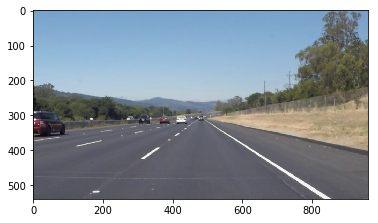

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [16]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_extraploted_line(slope, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=10):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, "intersection_x: ", intersection_x)
    point_one = (abs(int(intersection_x)), abs(int(intersection_x * coef + intercept)))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """            
    right_line_coordinates = []
    right_line_slope_intercept = []
    left_line_coordinates = []
    left_line_slope_intercept = []
    
    
    for line in lines:    
        for x1,y1,x2,y2 in line:
            
            ## Right line has positive slope and lef line has negative slope
            # Calculate slope
            if x2 - x1 == 0.:  # corner case, avoiding division by 0
                slope = 999.  # practically infinite slope
            else:
                slope = float(y1-y2)/float(x1-x2)
            
            if not math.isnan(slope):
                if slope > 0:
                    right_line_coordinates.append([x1,y1])
                    right_line_coordinates.append([x2,y2])
                    right_line_slope_intercept.append([slope, y1-slope*x1])
                elif slope < 0:
                    left_line_coordinates.append([x1,y1])
                    left_line_coordinates.append([x2,y2])
                    left_line_slope_intercept.append([slope, y1-slope*x1])          
            
            
    right_slope = [pair[0] for pair in right_line_slope_intercept]
    right_intercept = [pair[1] for pair in right_line_slope_intercept]

    left_slope = [pair[0] for pair in left_line_slope_intercept]
    left_intercept = [pair[1] for pair in left_line_slope_intercept]

    # Compute the mean for slope and intercept
    mean_right_slope = np.mean(right_slope)
    mean_right_intercept = np.mean(right_intercept)            
    mean_left_slope = np.mean(left_slope)
    mean_left_intercept = np.mean(left_intercept)

    intersection_x_coordinate = abs((mean_right_intercept-mean_left_intercept)/(mean_right_slope-mean_left_slope))
    
    #Plot Right Line
    draw_extraploted_line(mean_right_slope, mean_right_intercept, intersection_x_coordinate, img)
    #Plot Left Line
    draw_extraploted_line(mean_left_slope, mean_left_intercept, intersection_x_coordinate, img)
    
        
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(initial_img, img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def filter_white_and_yellow_color(image):
    white_threshold = 200
    lower_white = np.array([white_threshold,white_threshold,white_threshold])
    upper_white = np.array([255,255,255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    white_image = cv2.bitwise_and(image, image, mask=white_mask)
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)
    
    result = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)
    return result
    

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")
test_images_dir = "test_images/"
images = os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

In [5]:
## Global Parameter
# Gaussian smoothing
kernel_size = 5

# Canny Edge Detector
low_threshold = 50
high_threshold = 150

# Hough Transform
rho = 2
theta = np.pi/180
threshold = 45
min_line_len = 45
max_line_gap = 100


In [17]:
def detect_line_in_images(img):
    
    _image = mpimg.imread(img)
        
    # Filter out image with white and yellow color
    _filter_img = filter_white_and_yellow_color(_image)    

    # Grayscale the image
    _image_gray = grayscale(_filter_img)


    # Apply Gaussian smoothing to the image
    _image_blur_gray = gaussian_blur(_image_gray, kernel_size)

    # Apply open cv Canny Edge Detector
    _image_edges = canny(_image_blur_gray, low_threshold , high_threshold)    

    # Region Masking
    # Select region of interest in the image
    _imshape = _image.shape    
    vertices = np.array([[(0,_imshape[0]),(465, 320), (475, 320), (_imshape[1],_imshape[0])]], dtype=np.int32)
    _mask_edges = region_of_interest(_image_edges, vertices)

    _line_image = hough_lines(_mask_edges,rho, theta, threshold, min_line_len, max_line_gap)

    _weighted_image = weighted_img(_image,_line_image)
    plt.imshow(_weighted_image)



## Test Image 0

Coef:  0.569096029216 Intercept:  35.0680507835 intersection_x:  478.934782885
Point one:  (478, 307) Point two:  (960, 581)
Coef:  -0.796785331529 Intercept:  689.236143739 intersection_x:  478.934782885
Point one:  (478, 307) Point two:  (0, 689)


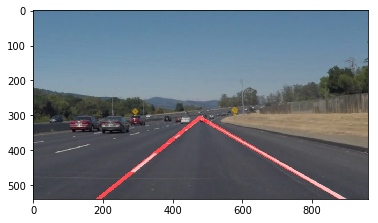

In [18]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#for img in images:
#    detect_line_in_images(img, image_count)

detect_line_in_images(test_images_dir + images[0])



## Test Image 1

Coef:  0.635084991123 Intercept:  3.20027727146 intersection_x:  480.911091931
Point one:  (480, 308) Point two:  (960, 612)
Coef:  -0.690623493492 Intercept:  640.74819219 intersection_x:  480.911091931
Point one:  (480, 308) Point two:  (0, 640)


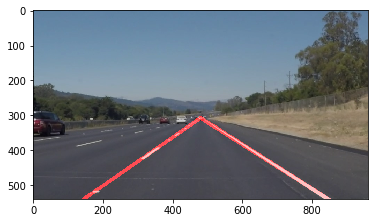

In [19]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#for img in images:
#    detect_line_in_images(img, image_count)

detect_line_in_images(test_images_dir + images[1])

## Test Image 2

Coef:  0.586232311321 Intercept:  32.3453714623 intersection_x:  476.739732191
Point one:  (476, 311) Point two:  (960, 595)
Coef:  -0.734678152655 Intercept:  662.075872306 intersection_x:  476.739732191
Point one:  (476, 311) Point two:  (0, 662)


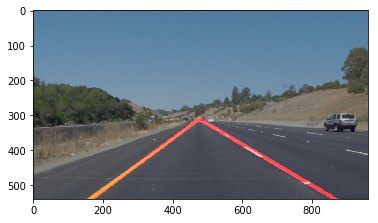

In [20]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#for img in images:
#    detect_line_in_images(img, image_count)

detect_line_in_images(test_images_dir + images[2])

## Test Image 3

Coef:  0.596311915793 Intercept:  27.4335798753 intersection_x:  476.355822344
Point one:  (476, 311) Point two:  (960, 599)
Coef:  -0.744037496907 Intercept:  665.91682659 intersection_x:  476.355822344
Point one:  (476, 311) Point two:  (0, 665)


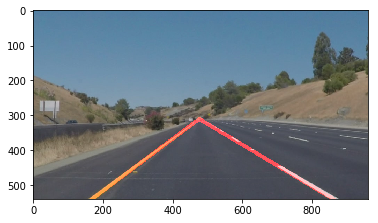

In [21]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#for img in images:
#    detect_line_in_images(img, image_count)

detect_line_in_images(test_images_dir + images[3])

## Test Image 4

Coef:  0.60873015873 Intercept:  20.9492063492 intersection_x:  477.91742028
Point one:  (477, 311) Point two:  (960, 605)
Coef:  -0.691020465576 Intercept:  642.122671725 intersection_x:  477.91742028
Point one:  (477, 311) Point two:  (0, 642)


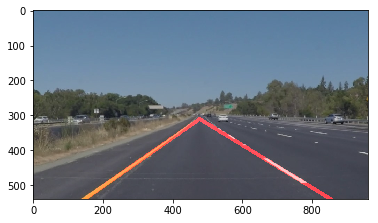

In [22]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#for img in images:
#    detect_line_in_images(img, image_count)

detect_line_in_images(test_images_dir + images[4])

## Test Image 5

Coef:  0.57514235934 Intercept:  35.4491862145 intersection_x:  484.350288053
Point one:  (484, 314) Point two:  (960, 587)
Coef:  -0.746547732782 Intercept:  675.610163051 intersection_x:  484.350288053
Point one:  (484, 314) Point two:  (0, 675)


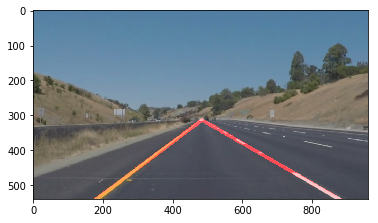

In [23]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#for img in images:
#    detect_line_in_images(img, image_count)

detect_line_in_images(test_images_dir + images[5])

## Test on Videos

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # Colour Selection
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image_blur = gaussian_blur(image_yuv, kernel_size)
    image_edges = canny(image_blur, low_threshold , high_threshold)

    # Region Masking
    # Select region of interest in the image
    imshape = image.shape
    vertices = np.array([[(150,imshape[0]),(420, 300), (520, 300), (820,imshape[0])]], dtype=np.int32)
    mask_edges = region_of_interest(image_edges, vertices)


    # Hough Transform to Find Lane Lines
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 10
    max_line_gap = 20

    houghed = np.copy(image)*0
    houghed = hough_lines(mask_edges,rho, theta, threshold, min_line_len, max_line_gap)

    weighted = weighted_img(houghed,image)
    return weighted


Let's try the one with the solid white lane on the right first ...

In [27]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Coef:  0.42315248019 Intercept:  100.231748594 intersection_x:  486.871347139
Point one:  (486, 306) Point two:  (960, 506)
Coef:  -0.404232245417 Intercept:  503.061664553 intersection_x:  486.871347139
Point one:  (486, 306) Point two:  (0, 503)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|                                                  | 0/222 [00:00<?, ?it/s]

Coef:  0.42315248019 Intercept:  100.231748594 intersection_x:  486.871347139
Point one:  (486, 306) Point two:  (960, 506)
Coef:  -0.404232245417 Intercept:  503.061664553 intersection_x:  486.871347139
Point one:  (486, 306) Point two:  (0, 503)


  0%|▏                                         | 1/222 [00:00<00:37,  5.85it/s]

Coef:  0.475322828089 Intercept:  76.6149258866 intersection_x:  466.522214131
Point one:  (466, 298) Point two:  (960, 532)
Coef:  -0.654119679453 Intercept:  603.524945239 intersection_x:  466.522214131
Point one:  (466, 298) Point two:  (0, 603)


  1%|▍                                         | 2/222 [00:00<00:34,  6.42it/s]

Coef:  0.329513235774 Intercept:  149.546801285 intersection_x:  466.27698159
Point one:  (466, 303) Point two:  (960, 465)
Coef:  -0.619832978613 Intercept:  592.205088613 intersection_x:  466.27698159
Point one:  (466, 303) Point two:  (0, 592)


  1%|▌                                         | 3/222 [00:00<00:31,  6.95it/s]

Coef:  0.440584337369 Intercept:  91.7046383997 intersection_x:  473.105746885
Point one:  (473, 300) Point two:  (960, 514)
Coef:  -0.568947777764 Intercept:  569.320083734 intersection_x:  473.105746885
Point one:  (473, 300) Point two:  (0, 569)


  2%|▊                                         | 4/222 [00:00<00:31,  6.91it/s]

Coef:  0.448963921047 Intercept:  88.401998676 intersection_x:  482.280707953
Point one:  (482, 304) Point two:  (960, 519)
Coef:  -0.554585773528 Intercept:  572.394655841 intersection_x:  482.280707953
Point one:  (482, 304) Point two:  (0, 572)


  2%|▉                                         | 5/222 [00:00<00:30,  7.13it/s]

Coef:  0.476514421572 Intercept:  76.589465183 intersection_x:  466.377852777
Point one:  (466, 298) Point two:  (960, 534)
Coef:  -0.587744820109 Intercept:  572.936405116 intersection_x:  466.377852777
Point one:  (466, 298) Point two:  (0, 572)


  3%|█▏                                        | 6/222 [00:00<00:27,  7.78it/s]

Coef:  0.496555794203 Intercept:  92.9367281732 intersection_x:  450.104175864
Point one:  (450, 316) Point two:  (960, 569)
Coef:  -0.546264432328 Intercept:  562.31446681 intersection_x:  450.104175864
Point one:  (450, 316) Point two:  (0, 562)


  3%|█▎                                        | 7/222 [00:00<00:26,  7.98it/s]

Coef:  0.305104079171 Intercept:  178.638453777 intersection_x:  464.822577145
Point one:  (464, 320) Point two:  (960, 471)
Coef:  -0.396694355065 Intercept:  504.850210615 intersection_x:  464.822577145
Point one:  (464, 320) Point two:  (0, 504)


  4%|█▌                                        | 8/222 [00:01<00:25,  8.32it/s]

Coef:  0.605060112484 Intercept:  24.1002131975 intersection_x:  466.488302202
Point one:  (466, 306) Point two:  (960, 604)
Coef:  -0.491179929907 Intercept:  535.483369378 intersection_x:  466.488302202
Point one:  (466, 306) Point two:  (0, 535)


  4%|█▋                                        | 9/222 [00:01<00:24,  8.67it/s]

Coef:  0.512645482839 Intercept:  69.902078005 intersection_x:  463.72152171
Point one:  (463, 307) Point two:  (960, 562)
Coef:  -0.584267552753 Intercept:  578.564260054 intersection_x:  463.72152171
Point one:  (463, 307) Point two:  (0, 578)
Coef:  0.387611915698 Intercept:  128.35470053 intersection_x:  468.993573808
Point one:  (468, 310) Point two:  (960, 500)
Coef:  -0.461652600831 Intercept:  526.654301245 intersection_x:  468.993573808
Point one:  (468, 310) Point two:  (0, 526)


  5%|██                                       | 11/222 [00:01<00:23,  9.08it/s]

Coef:  0.485163263218 Intercept:  80.2927419467 intersection_x:  459.469225639
Point one:  (459, 303) Point two:  (960, 546)
Coef:  -0.832226343986 Intercept:  685.592724633 intersection_x:  459.469225639
Point one:  (459, 303) Point two:  (0, 685)


  5%|██▏                                      | 12/222 [00:01<00:22,  9.21it/s]

Coef:  71.7997662752 Intercept:  -29293.2177489 intersection_x:  412.736542157
Point one:  (412, 341) Point two:  (960, 39634)
Coef:  -0.748811817373 Intercept:  650.231511449 intersection_x:  412.736542157
Point one:  (412, 341) Point two:  (0, 650)


  6%|██▍                                      | 13/222 [00:01<00:22,  9.22it/s]

Coef:  0.54241925321 Intercept:  52.3500756542 intersection_x:  467.454824583
Point one:  (467, 305) Point two:  (960, 573)
Coef:  -0.511336498504 Intercept:  544.933285725 intersection_x:  467.454824583
Point one:  (467, 305) Point two:  (0, 544)


  6%|██▌                                      | 14/222 [00:01<00:22,  9.08it/s]

Coef:  0.433263185402 Intercept:  94.2322541679 intersection_x:  480.189394646
Point one:  (480, 302) Point two:  (960, 510)
Coef:  -0.549467571359 Intercept:  566.129141357 intersection_x:  480.189394646
Point one:  (480, 302) Point two:  (0, 566)


  7%|██▊                                      | 15/222 [00:01<00:23,  8.77it/s]

Coef:  0.428675720608 Intercept:  105.962292502 intersection_x:  482.71916184
Point one:  (482, 312) Point two:  (960, 517)
Coef:  -0.603709163942 Intercept:  604.314258668 intersection_x:  482.71916184
Point one:  (482, 312) Point two:  (0, 604)


  7%|██▉                                      | 16/222 [00:01<00:23,  8.94it/s]

Coef:  0.558166893342 Intercept:  30.9909706542 intersection_x:  479.336413277
Point one:  (479, 298) Point two:  (960, 566)
Coef:  -0.514818913167 Intercept:  545.312138643 intersection_x:  479.336413277
Point one:  (479, 298) Point two:  (0, 545)
Coef:  0.516650793238 Intercept:  58.1658202134 intersection_x:  474.925445138
Point one:  (474, 303) Point two:  (960, 554)
Coef:  -0.529130511509 Intercept:  554.833971888 intersection_x:  474.925445138
Point one:  (474, 303) Point two:  (0, 554)


  8%|███▎                                     | 18/222 [00:02<00:22,  9.16it/s]

Coef:  83.6768012647 Intercept:  -34115.0902758 intersection_x:  411.775471791
Point one:  (411, 340) Point two:  (960, 46214)
Coef:  -0.579642381842 Intercept:  579.646558212 intersection_x:  411.775471791
Point one:  (411, 340) Point two:  (0, 579)


  9%|███▌                                     | 19/222 [00:02<00:21,  9.32it/s]

Coef:  0.451392303192 Intercept:  94.6910529039 intersection_x:  496.853107649
Point one:  (496, 318) Point two:  (960, 528)
Coef:  -0.320746732145 Intercept:  478.330732148 intersection_x:  496.853107649
Point one:  (496, 318) Point two:  (0, 478)
Coef:  0.476527063671 Intercept:  81.7807990863 intersection_x:  489.365264124
Point one:  (489, 314) Point two:  (960, 539)
Coef:  -0.443924650394 Intercept:  532.217895253 intersection_x:  489.365264124
Point one:  (489, 314) Point two:  (0, 532)


  9%|███▉                                     | 21/222 [00:02<00:20,  9.62it/s]

Coef:  95.5224212432 Intercept:  -39113.8824932 intersection_x:  413.029812169
Point one:  (413, 339) Point two:  (960, 52587)
Coef:  -0.520324835665 Intercept:  554.634879937 intersection_x:  413.029812169
Point one:  (413, 339) Point two:  (0, 554)


 10%|████                                     | 22/222 [00:02<00:20,  9.67it/s]

Coef:  37.4788245877 Intercept:  -16080.6166369 intersection_x:  438.008430715
Point one:  (438, 335) Point two:  (960, 19899)
Coef:  -0.584110686353 Intercept:  591.269910856 intersection_x:  438.008430715
Point one:  (438, 335) Point two:  (0, 591)


 10%|████▏                                    | 23/222 [00:02<00:20,  9.60it/s]

Coef:  43.8262381033 Intercept:  -17768.1975968 intersection_x:  413.304814687
Point one:  (413, 345) Point two:  (960, 24304)
Coef:  -0.550454564148 Intercept:  572.903142556 intersection_x:  413.304814687
Point one:  (413, 345) Point two:  (0, 572)
Coef:  0.525915779187 Intercept:  61.3836808609 intersection_x:  473.650541421
Point one:  (473, 310) Point two:  (960, 566)
Coef:  -0.457740235835 Intercept:  527.292884948 intersection_x:  473.650541421
Point one:  (473, 310) Point two:  (0, 527)


 11%|████▌                                    | 25/222 [00:02<00:20,  9.83it/s]

Coef:  0.517812546776 Intercept:  58.9043381628 intersection_x:  477.61236441
Point one:  (477, 306) Point two:  (960, 556)
Coef:  -0.515938383096 Intercept:  552.63656399 intersection_x:  477.61236441
Point one:  (477, 306) Point two:  (0, 552)


 12%|████▊                                    | 26/222 [00:02<00:19,  9.88it/s]

Coef:  0.452524062099 Intercept:  94.1474631352 intersection_x:  472.869052093
Point one:  (472, 308) Point two:  (960, 528)
Coef:  -0.49316681614 Intercept:  541.335412301 intersection_x:  472.869052093
Point one:  (472, 308) Point two:  (0, 541)


 12%|████▉                                    | 27/222 [00:02<00:19,  9.89it/s]

Coef:  0.352923994436 Intercept:  144.117278923 intersection_x:  480.167007767
Point one:  (480, 313) Point two:  (960, 482)
Coef:  -0.482744721294 Intercept:  545.377825639 intersection_x:  480.167007767
Point one:  (480, 313) Point two:  (0, 545)


 13%|█████▏                                   | 28/222 [00:03<00:19,  9.86it/s]

Coef:  0.381118183568 Intercept:  130.223724514 intersection_x:  465.071927893
Point one:  (465, 307) Point two:  (960, 496)
Coef:  -0.476384029945 Intercept:  529.023932125 intersection_x:  465.071927893
Point one:  (465, 307) Point two:  (0, 529)


 13%|█████▎                                   | 29/222 [00:03<00:19,  9.87it/s]

Coef:  0.444495202652 Intercept:  103.36176121 intersection_x:  479.799200157
Point one:  (479, 316) Point two:  (960, 530)
Coef:  -0.410299484416 Intercept:  513.491568364 intersection_x:  479.799200157
Point one:  (479, 316) Point two:  (0, 513)


 14%|█████▌                                   | 30/222 [00:03<00:19,  9.77it/s]

Coef:  0.546906552847 Intercept:  51.0814361549 intersection_x:  481.670923242
Point one:  (481, 314) Point two:  (960, 576)
Coef:  -0.359892885374 Intercept:  487.860358758 intersection_x:  481.670923242
Point one:  (481, 314) Point two:  (0, 487)


 14%|█████▋                                   | 31/222 [00:03<00:19,  9.69it/s]

Coef:  53.0401600084 Intercept:  -22840.0309806 intersection_x:  436.811537275
Point one:  (436, 328) Point two:  (960, 28078)
Coef:  -0.542581638402 Intercept:  565.528769524 intersection_x:  436.811537275
Point one:  (436, 328) Point two:  (0, 565)


 14%|█████▉                                   | 32/222 [00:03<00:19,  9.72it/s]

Coef:  0.50244781026 Intercept:  61.8247976179 intersection_x:  468.110416625
Point one:  (468, 297) Point two:  (960, 544)
Coef:  -0.866255712576 Intercept:  702.529173929 intersection_x:  468.110416625
Point one:  (468, 297) Point two:  (0, 702)
Coef:  0.533695612481 Intercept:  50.4056560656 intersection_x:  468.387309266
Point one:  (468, 300) Point two:  (960, 562)
Coef:  -0.713414637205 Intercept:  634.536270274 intersection_x:  468.387309266
Point one:  (468, 300) Point two:  (0, 634)


 15%|██████▎                                  | 34/222 [00:03<00:19,  9.83it/s]

Coef:  0.507079504134 Intercept:  77.2490149109 intersection_x:  464.201573141
Point one:  (464, 312) Point two:  (960, 564)
Coef:  -0.560166732525 Intercept:  572.666396897 intersection_x:  464.201573141
Point one:  (464, 312) Point two:  (0, 572)


 16%|██████▍                                  | 35/222 [00:03<00:19,  9.83it/s]

Coef:  0.554576779727 Intercept:  50.4762815445 intersection_x:  475.501447355
Point one:  (475, 314) Point two:  (960, 582)
Coef:  -0.483169061398 Intercept:  543.925930986 intersection_x:  475.501447355
Point one:  (475, 314) Point two:  (0, 543)


 16%|██████▋                                  | 36/222 [00:03<00:20,  9.25it/s]

Coef:  0.522126984586 Intercept:  55.0653689655 intersection_x:  486.891891384
Point one:  (486, 309) Point two:  (960, 556)
Coef:  -0.5234138984 Intercept:  564.130747002 intersection_x:  486.891891384
Point one:  (486, 309) Point two:  (0, 564)


 17%|██████▊                                  | 37/222 [00:04<00:20,  9.07it/s]

Coef:  0.492385954329 Intercept:  78.7987392776 intersection_x:  473.429523594
Point one:  (473, 311) Point two:  (960, 551)
Coef:  -0.503966555366 Intercept:  550.501433275 intersection_x:  473.429523594
Point one:  (473, 311) Point two:  (0, 550)


 17%|███████                                  | 38/222 [00:04<00:19,  9.31it/s]

Coef:  0.594752624861 Intercept:  28.72920278 intersection_x:  466.237940357
Point one:  (466, 306) Point two:  (960, 599)
Coef:  -0.681339817945 Intercept:  623.69191502 intersection_x:  466.237940357
Point one:  (466, 306) Point two:  (0, 623)


 18%|███████▏                                 | 39/222 [00:04<00:20,  8.92it/s]

Coef:  0.439275822569 Intercept:  102.239501979 intersection_x:  474.5916402
Point one:  (474, 310) Point two:  (960, 523)
Coef:  -0.484835352203 Intercept:  540.814940142 intersection_x:  474.5916402
Point one:  (474, 310) Point two:  (0, 540)


 18%|███████▍                                 | 40/222 [00:04<00:19,  9.19it/s]

Coef:  0.579107432114 Intercept:  12.549319924 intersection_x:  492.960111522
Point one:  (492, 298) Point two:  (960, 568)
Coef:  -0.477211984278 Intercept:  533.272657232 intersection_x:  492.960111522
Point one:  (492, 298) Point two:  (0, 533)


 18%|███████▌                                 | 41/222 [00:04<00:19,  9.24it/s]

Coef:  0.334305062702 Intercept:  155.846565638 intersection_x:  464.291919172
Point one:  (464, 311) Point two:  (960, 476)
Coef:  -0.510658390376 Intercept:  548.156268898 intersection_x:  464.291919172
Point one:  (464, 311) Point two:  (0, 548)


 19%|███████▊                                 | 42/222 [00:04<00:19,  9.40it/s]

Coef:  0.581956291812 Intercept:  25.8357530563 intersection_x:  484.122697903
Point one:  (484, 307) Point two:  (960, 584)
Coef:  -0.370241392499 Intercept:  486.816264922 intersection_x:  484.122697903
Point one:  (484, 307) Point two:  (0, 486)


 19%|███████▉                                 | 43/222 [00:04<00:20,  8.88it/s]

Coef:  0.409651522359 Intercept:  109.217516315 intersection_x:  495.078072131
Point one:  (495, 312) Point two:  (960, 502)
Coef:  -0.431006508687 Intercept:  525.408873646 intersection_x:  495.078072131
Point one:  (495, 312) Point two:  (0, 525)


 20%|████████▏                                | 44/222 [00:04<00:20,  8.69it/s]

Coef:  0.633145330626 Intercept:  1.51325425048 intersection_x:  489.4187165
Point one:  (489, 311) Point two:  (960, 609)
Coef:  -0.402753416975 Intercept:  508.501489725 intersection_x:  489.4187165
Point one:  (489, 311) Point two:  (0, 508)


 20%|████████▎                                | 45/222 [00:04<00:20,  8.81it/s]

Coef:  0.484409058024 Intercept:  72.3868568785 intersection_x:  471.878768379
Point one:  (471, 300) Point two:  (960, 537)
Coef:  -0.565693494346 Intercept:  567.907955963 intersection_x:  471.878768379
Point one:  (471, 300) Point two:  (0, 567)


 21%|████████▍                                | 46/222 [00:05<00:19,  9.03it/s]

Coef:  0.512822328954 Intercept:  59.7375809001 intersection_x:  471.707054437
Point one:  (471, 301) Point two:  (960, 552)
Coef:  -0.62489382802 Intercept:  596.406318091 intersection_x:  471.707054437
Point one:  (471, 301) Point two:  (0, 596)


 21%|████████▋                                | 47/222 [00:05<00:19,  9.10it/s]

Coef:  0.37526832514 Intercept:  125.542425359 intersection_x:  460.89122106
Point one:  (460, 298) Point two:  (960, 485)
Coef:  -0.795754853148 Intercept:  665.25672789 intersection_x:  460.89122106
Point one:  (460, 298) Point two:  (0, 665)


 22%|████████▊                                | 48/222 [00:05<00:19,  9.05it/s]

Coef:  0.527487344533 Intercept:  49.1404599278 intersection_x:  481.30081699
Point one:  (481, 303) Point two:  (960, 555)
Coef:  -0.486807089699 Intercept:  537.321199792 intersection_x:  481.30081699
Point one:  (481, 303) Point two:  (0, 537)


 22%|█████████                                | 49/222 [00:05<00:18,  9.11it/s]

Coef:  0.445636538788 Intercept:  96.4696623499 intersection_x:  474.139811199
Point one:  (474, 307) Point two:  (960, 524)
Coef:  -0.569410375377 Intercept:  577.74381459 intersection_x:  474.139811199
Point one:  (474, 307) Point two:  (0, 577)


 23%|█████████▏                               | 50/222 [00:05<00:19,  8.98it/s]

Coef:  77.2175950079 Intercept:  -31532.6910559 intersection_x:  412.740203434
Point one:  (412, 338) Point two:  (960, 42596)
Coef:  -0.453717168252 Intercept:  525.382132655 intersection_x:  412.740203434
Point one:  (412, 338) Point two:  (0, 525)


 23%|█████████▍                               | 51/222 [00:05<00:19,  8.89it/s]

Coef:  0.305221589355 Intercept:  181.441618079 intersection_x:  449.257715985
Point one:  (449, 318) Point two:  (960, 474)
Coef:  -0.516521483049 Intercept:  550.616033913 intersection_x:  449.257715985
Point one:  (449, 318) Point two:  (0, 550)


 23%|█████████▌                               | 52/222 [00:05<00:19,  8.72it/s]

Coef:  0.51038207971 Intercept:  58.6262608956 intersection_x:  467.074405532
Point one:  (467, 297) Point two:  (960, 548)
Coef:  -0.594467747026 Intercept:  574.67333692 intersection_x:  467.074405532
Point one:  (467, 297) Point two:  (0, 574)


 24%|█████████▊                               | 53/222 [00:05<00:19,  8.67it/s]

Coef:  71.7943345951 Intercept:  -29302.0772047 intersection_x:  412.860538499
Point one:  (412, 338) Point two:  (960, 39620)
Coef:  -0.539507259346 Intercept:  561.711694988 intersection_x:  412.860538499
Point one:  (412, 338) Point two:  (0, 561)


 24%|█████████▉                               | 54/222 [00:05<00:19,  8.54it/s]

Coef:  50.3250649625 Intercept:  -20501.9031365 intersection_x:  414.12748953
Point one:  (414, 339) Point two:  (960, 27810)
Coef:  -0.649980487296 Intercept:  608.26446432 intersection_x:  414.12748953
Point one:  (414, 339) Point two:  (0, 608)
Coef:  0.509990306487 Intercept:  65.2650315834 intersection_x:  467.594719635
Point one:  (467, 303) Point two:  (960, 554)
Coef:  -0.60437826139 Intercept:  586.33788965 intersection_x:  467.594719635
Point one:  (467, 303) Point two:  (0, 586)


 25%|██████████▎                              | 56/222 [00:06<00:19,  8.49it/s]

Coef:  62.9755360481 Intercept:  -25672.3552313 intersection_x:  413.099181904
Point one:  (413, 342) Point two:  (960, 34784)
Coef:  -0.563123588965 Intercept:  575.413084048 intersection_x:  413.099181904
Point one:  (413, 342) Point two:  (0, 575)


 26%|██████████▌                              | 57/222 [00:06<00:20,  8.19it/s]

Coef:  0.516585951789 Intercept:  73.8706870709 intersection_x:  464.228782903
Point one:  (464, 313) Point two:  (960, 569)
Coef:  -0.459329747588 Intercept:  526.918844409 intersection_x:  464.228782903
Point one:  (464, 313) Point two:  (0, 526)


 26%|██████████▋                              | 58/222 [00:06<00:20,  8.05it/s]

Coef:  0.564807803418 Intercept:  39.1452282082 intersection_x:  479.886232608
Point one:  (479, 310) Point two:  (960, 581)
Coef:  -0.401500692639 Intercept:  502.863371918 intersection_x:  479.886232608
Point one:  (479, 310) Point two:  (0, 502)


 27%|██████████▉                              | 59/222 [00:06<00:19,  8.18it/s]

Coef:  0.486184864931 Intercept:  75.2458633725 intersection_x:  461.709513763
Point one:  (461, 299) Point two:  (960, 541)
Coef:  -0.655385640345 Intercept:  602.31982629 intersection_x:  461.709513763
Point one:  (461, 299) Point two:  (0, 602)


 27%|███████████                              | 60/222 [00:06<00:19,  8.20it/s]

Coef:  0.612380138302 Intercept:  16.4262992218 intersection_x:  473.803044873
Point one:  (473, 306) Point two:  (960, 604)
Coef:  -0.487506035832 Intercept:  537.55571754 intersection_x:  473.803044873
Point one:  (473, 306) Point two:  (0, 537)


 27%|███████████▎                             | 61/222 [00:06<00:19,  8.28it/s]

Coef:  0.404373561036 Intercept:  117.41163885 intersection_x:  465.790632455
Point one:  (465, 305) Point two:  (960, 505)
Coef:  -0.540822131533 Intercept:  557.674938286 intersection_x:  465.790632455
Point one:  (465, 305) Point two:  (0, 557)


 28%|███████████▍                             | 62/222 [00:06<00:19,  8.22it/s]

Coef:  0.57696587522 Intercept:  32.8782960838 intersection_x:  474.624347676
Point one:  (474, 306) Point two:  (960, 586)
Coef:  -0.474004873062 Intercept:  531.694601914 intersection_x:  474.624347676
Point one:  (474, 306) Point two:  (0, 531)


 28%|███████████▋                             | 63/222 [00:07<00:18,  8.48it/s]

Coef:  0.953999186264 Intercept:  -118.835843461 intersection_x:  452.285101463
Point one:  (452, 312) Point two:  (960, 797)
Coef:  -0.540286912377 Intercept:  557.007496277 intersection_x:  452.285101463
Point one:  (452, 312) Point two:  (0, 557)


 29%|███████████▊                             | 64/222 [00:07<00:18,  8.50it/s]

Coef:  0.516343253632 Intercept:  64.3840971164 intersection_x:  460.223944796
Point one:  (460, 302) Point two:  (960, 560)
Coef:  -0.612771582912 Intercept:  584.029781318 intersection_x:  460.223944796
Point one:  (460, 302) Point two:  (0, 584)


 29%|████████████                             | 65/222 [00:07<00:18,  8.62it/s]

Coef:  0.618351023994 Intercept:  13.6236688196 intersection_x:  471.385412771
Point one:  (471, 305) Point two:  (960, 607)
Coef:  -0.448987697374 Intercept:  516.751572559 intersection_x:  471.385412771
Point one:  (471, 305) Point two:  (0, 516)


 30%|████████████▏                            | 66/222 [00:07<00:18,  8.65it/s]

Coef:  0.616016814734 Intercept:  13.5156700787 intersection_x:  485.15339929
Point one:  (485, 312) Point two:  (960, 604)
Coef:  -0.379703441086 Intercept:  496.592736932 intersection_x:  485.15339929
Point one:  (485, 312) Point two:  (0, 496)


 30%|████████████▎                            | 67/222 [00:07<00:18,  8.59it/s]

Coef:  0.448301854093 Intercept:  90.9690932493 intersection_x:  480.594453331
Point one:  (480, 306) Point two:  (960, 521)
Coef:  -0.432881421614 Intercept:  514.460887922 intersection_x:  480.594453331
Point one:  (480, 306) Point two:  (0, 514)


 31%|████████████▌                            | 68/222 [00:07<00:17,  8.62it/s]

Coef:  71.7979477314 Intercept:  -29233.7260027 intersection_x:  411.832759688
Point one:  (411, 335) Point two:  (960, 39692)
Coef:  -0.414416841938 Intercept:  505.69138307 intersection_x:  411.832759688
Point one:  (411, 335) Point two:  (0, 505)


 31%|████████████▋                            | 69/222 [00:07<00:17,  8.56it/s]

Coef:  0.398563670626 Intercept:  114.539865148 intersection_x:  481.723160023
Point one:  (481, 306) Point two:  (960, 497)
Coef:  -0.440864452566 Intercept:  518.911833264 intersection_x:  481.723160023
Point one:  (481, 306) Point two:  (0, 518)


 32%|████████████▉                            | 70/222 [00:07<00:17,  8.47it/s]

Coef:  0.468393596546 Intercept:  88.5118333097 intersection_x:  468.315649045
Point one:  (468, 307) Point two:  (960, 538)
Coef:  -0.457660320888 Intercept:  522.197374703 intersection_x:  468.315649045
Point one:  (468, 307) Point two:  (0, 522)


 32%|█████████████                            | 71/222 [00:07<00:17,  8.43it/s]

Coef:  0.429025869863 Intercept:  102.600202882 intersection_x:  471.834379569
Point one:  (471, 305) Point two:  (960, 514)
Coef:  -0.534831870015 Intercept:  557.38142157 intersection_x:  471.834379569
Point one:  (471, 305) Point two:  (0, 557)


 32%|█████████████▎                           | 72/222 [00:08<00:17,  8.77it/s]

Coef:  0.476688304558 Intercept:  79.5185565822 intersection_x:  475.9422359
Point one:  (475, 306) Point two:  (960, 537)
Coef:  -0.513248182532 Intercept:  550.671141647 intersection_x:  475.9422359
Point one:  (475, 306) Point two:  (0, 550)


 33%|█████████████▍                           | 73/222 [00:08<00:17,  8.66it/s]

Coef:  0.493681848394 Intercept:  71.4811639266 intersection_x:  477.331784708
Point one:  (477, 307) Point two:  (960, 545)
Coef:  -0.481665295155 Intercept:  537.045356667 intersection_x:  477.331784708
Point one:  (477, 307) Point two:  (0, 537)


 33%|█████████████▋                           | 74/222 [00:08<00:16,  8.81it/s]

Coef:  0.413461322278 Intercept:  110.806697463 intersection_x:  476.889686467
Point one:  (476, 307) Point two:  (960, 507)
Coef:  -0.459039066197 Intercept:  526.893134165 intersection_x:  476.889686467
Point one:  (476, 307) Point two:  (0, 526)


 34%|█████████████▊                           | 75/222 [00:08<00:17,  8.29it/s]

Coef:  0.544450858313 Intercept:  46.5904820442 intersection_x:  480.389417623
Point one:  (480, 308) Point two:  (960, 569)
Coef:  -0.438667651502 Intercept:  518.870210428 intersection_x:  480.389417623
Point one:  (480, 308) Point two:  (0, 518)


 34%|██████████████                           | 76/222 [00:08<00:18,  7.85it/s]

Coef:  0.640974397751 Intercept:  -4.26139321671 intersection_x:  472.069615264
Point one:  (472, 298) Point two:  (960, 611)
Coef:  -0.564412227806 Intercept:  564.765007354 intersection_x:  472.069615264
Point one:  (472, 298) Point two:  (0, 564)


 35%|██████████████▏                          | 77/222 [00:08<00:18,  7.95it/s]

Coef:  0.444131498587 Intercept:  114.059515067 intersection_x:  448.893488336
Point one:  (448, 313) Point two:  (960, 540)
Coef:  -0.456938651792 Intercept:  518.544038106 intersection_x:  448.893488336
Point one:  (448, 313) Point two:  (0, 518)


 35%|██████████████▍                          | 78/222 [00:08<00:17,  8.06it/s]

Coef:  0.508988631439 Intercept:  61.0713448306 intersection_x:  486.429918535
Point one:  (486, 308) Point two:  (960, 549)
Coef:  -0.511009746748 Intercept:  557.229072837 intersection_x:  486.429918535
Point one:  (486, 308) Point two:  (0, 557)
Coef:  0.467520346014 Intercept:  79.8076427163 intersection_x:  480.526165757
Point one:  (480, 304) Point two:  (960, 528)
Coef:  -0.431177956956 Intercept:  511.655692415 intersection_x:  480.526165757
Point one:  (480, 304) Point two:  (0, 511)


 36%|██████████████▊                          | 80/222 [00:08<00:15,  8.99it/s]

Coef:  0.483365766019 Intercept:  77.1370031162 intersection_x:  473.902187958
Point one:  (473, 306) Point two:  (960, 541)
Coef:  -0.490873338396 Intercept:  538.831046293 intersection_x:  473.902187958
Point one:  (473, 306) Point two:  (0, 538)
Coef:  0.616286897448 Intercept:  14.6469725677 intersection_x:  462.808735384
Point one:  (462, 299) Point two:  (960, 606)
Coef:  -0.590631826487 Intercept:  573.219500903 intersection_x:  462.808735384
Point one:  (462, 299) Point two:  (0, 573)


 37%|███████████████▏                         | 82/222 [00:09<00:14,  9.58it/s]

Coef:  176.671907698 Intercept:  -90663.6584513 intersection_x:  514.826655595
Point one:  (514, 291) Point two:  (960, 78941)
Coef:  -0.424755792167 Intercept:  510.424530388 intersection_x:  514.826655595
Point one:  (514, 291) Point two:  (0, 510)
Coef:  0.508988180096 Intercept:  60.5310450038 intersection_x:  475.988412215
Point one:  (475, 302) Point two:  (960, 549)
Coef:  -0.505004291206 Intercept:  543.179711417 intersection_x:  475.988412215
Point one:  (475, 302) Point two:  (0, 543)


 38%|███████████████▌                         | 84/222 [00:09<00:14,  9.64it/s]

Coef:  0.526719431992 Intercept:  51.1024469563 intersection_x:  483.571428775
Point one:  (483, 305) Point two:  (960, 556)
Coef:  -0.410317778793 Intercept:  504.226869791 intersection_x:  483.571428775
Point one:  (483, 305) Point two:  (0, 504)


 38%|███████████████▋                         | 85/222 [00:09<00:18,  7.25it/s]

Coef:  0.472889012045 Intercept:  80.6405583323 intersection_x:  480.025875464
Point one:  (480, 307) Point two:  (960, 534)
Coef:  -0.438719437044 Intercept:  518.236202187 intersection_x:  480.025875464
Point one:  (480, 307) Point two:  (0, 518)


 39%|███████████████▉                         | 86/222 [00:09<00:20,  6.67it/s]

Coef:  0.588160800705 Intercept:  23.486606806 intersection_x:  479.112076758
Point one:  (479, 305) Point two:  (960, 588)
Coef:  -0.429580196174 Intercept:  511.098609423 intersection_x:  479.112076758
Point one:  (479, 305) Point two:  (0, 511)


 39%|████████████████                         | 87/222 [00:09<00:19,  6.90it/s]

Coef:  0.584637813513 Intercept:  37.2431389102 intersection_x:  465.186781992
Point one:  (465, 309) Point two:  (960, 598)
Coef:  -0.473357061798 Intercept:  529.40837032 intersection_x:  465.186781992
Point one:  (465, 309) Point two:  (0, 529)


 40%|████████████████▎                        | 88/222 [00:09<00:17,  7.59it/s]

Coef:  0.472428357712 Intercept:  83.0616021926 intersection_x:  479.186426335
Point one:  (479, 309) Point two:  (960, 536)
Coef:  -0.33546998485 Intercept:  470.195521807 intersection_x:  479.186426335
Point one:  (479, 309) Point two:  (0, 470)


 40%|████████████████▍                        | 89/222 [00:10<00:21,  6.24it/s]

Coef:  0.418647086629 Intercept:  104.145892822 intersection_x:  486.659904417
Point one:  (486, 307) Point two:  (960, 506)
Coef:  -0.40448746693 Intercept:  504.732475979 intersection_x:  486.659904417
Point one:  (486, 307) Point two:  (0, 504)


 41%|████████████████▌                        | 90/222 [00:10<00:19,  6.73it/s]

Coef:  0.556044026823 Intercept:  48.8185894347 intersection_x:  464.723698563
Point one:  (464, 307) Point two:  (960, 582)
Coef:  -0.549282783408 Intercept:  562.490152807 intersection_x:  464.723698563
Point one:  (464, 307) Point two:  (0, 562)


 41%|████████████████▊                        | 91/222 [00:10<00:18,  7.21it/s]

Coef:  0.474429578571 Intercept:  83.0448959761 intersection_x:  476.044756298
Point one:  (476, 308) Point two:  (960, 538)
Coef:  -0.464389624924 Intercept:  529.964854912 intersection_x:  476.044756298
Point one:  (476, 308) Point two:  (0, 529)


 41%|████████████████▉                        | 92/222 [00:10<00:18,  6.98it/s]

Coef:  0.550549905268 Intercept:  56.2236729467 intersection_x:  468.100668162
Point one:  (468, 313) Point two:  (960, 584)
Coef:  -0.425708187474 Intercept:  513.210738458 intersection_x:  468.100668162
Point one:  (468, 313) Point two:  (0, 513)


 42%|█████████████████▏                       | 93/222 [00:10<00:16,  7.64it/s]

Coef:  0.524316620315 Intercept:  54.3923451268 intersection_x:  478.427460041
Point one:  (478, 305) Point two:  (960, 557)
Coef:  -0.368032176137 Intercept:  481.316513284 intersection_x:  478.427460041
Point one:  (478, 305) Point two:  (0, 481)


 42%|█████████████████▎                       | 94/222 [00:10<00:15,  8.02it/s]

Coef:  0.489496640658 Intercept:  70.5012049636 intersection_x:  482.904210304
Point one:  (482, 306) Point two:  (960, 540)
Coef:  -0.41861140873 Intercept:  509.030405424 intersection_x:  482.904210304
Point one:  (482, 306) Point two:  (0, 509)


 43%|█████████████████▌                       | 95/222 [00:10<00:16,  7.60it/s]

Coef:  0.56027900975 Intercept:  38.853132277 intersection_x:  474.073077874
Point one:  (474, 304) Point two:  (960, 576)
Coef:  -0.48699278128 Intercept:  535.336493621 intersection_x:  474.073077874
Point one:  (474, 304) Point two:  (0, 535)


 43%|█████████████████▋                       | 96/222 [00:11<00:16,  7.55it/s]

Coef:  0.664360175802 Intercept:  -22.4472405662 intersection_x:  480.723679654
Point one:  (480, 296) Point two:  (960, 615)
Coef:  -0.523378777556 Intercept:  548.526999561 intersection_x:  480.723679654
Point one:  (480, 296) Point two:  (0, 548)


 44%|█████████████████▉                       | 97/222 [00:11<00:15,  7.98it/s]

Coef:  0.59633403627 Intercept:  13.6178670078 intersection_x:  484.399530254
Point one:  (484, 302) Point two:  (960, 586)
Coef:  -0.407484973038 Intercept:  499.867323577 intersection_x:  484.399530254
Point one:  (484, 302) Point two:  (0, 499)


 44%|██████████████████                       | 98/222 [00:11<00:15,  8.04it/s]

Coef:  46.0248950441 Intercept:  -19982.1246562 intersection_x:  441.224436602
Point one:  (441, 325) Point two:  (960, 24201)
Coef:  -0.449909094456 Intercept:  523.694616059 intersection_x:  441.224436602
Point one:  (441, 325) Point two:  (0, 523)


 45%|██████████████████▎                      | 99/222 [00:11<00:14,  8.25it/s]

Coef:  0.520052464528 Intercept:  64.6020150016 intersection_x:  462.365996162
Point one:  (462, 305) Point two:  (960, 563)
Coef:  -0.512086330515 Intercept:  541.827897149 intersection_x:  462.365996162
Point one:  (462, 305) Point two:  (0, 541)


 45%|██████████████████                      | 100/222 [00:11<00:14,  8.19it/s]

Coef:  0.590031772721 Intercept:  18.0692590526 intersection_x:  481.72299493
Point one:  (481, 302) Point two:  (960, 584)
Coef:  -0.424836433382 Intercept:  506.954610756 intersection_x:  481.72299493
Point one:  (481, 302) Point two:  (0, 506)


 45%|██████████████████▏                     | 101/222 [00:11<00:14,  8.29it/s]

Coef:  0.476002049662 Intercept:  83.6284216741 intersection_x:  470.677581677
Point one:  (470, 307) Point two:  (960, 540)
Coef:  -0.383998082134 Intercept:  488.41120395 intersection_x:  470.677581677
Point one:  (470, 307) Point two:  (0, 488)


 46%|██████████████████▍                     | 102/222 [00:11<00:14,  8.45it/s]

Coef:  0.470838256193 Intercept:  78.6860282604 intersection_x:  486.439606673
Point one:  (486, 307) Point two:  (960, 530)
Coef:  -0.49241580464 Intercept:  547.250954738 intersection_x:  486.439606673
Point one:  (486, 307) Point two:  (0, 547)


 46%|██████████████████▌                     | 103/222 [00:11<00:13,  8.66it/s]

Coef:  0.49985615551 Intercept:  66.8554766244 intersection_x:  484.705172126
Point one:  (484, 309) Point two:  (960, 546)
Coef:  -0.429934444252 Intercept:  517.529789323 intersection_x:  484.705172126
Point one:  (484, 309) Point two:  (0, 517)


 47%|██████████████████▋                     | 104/222 [00:12<00:13,  8.74it/s]

Coef:  0.526079984509 Intercept:  58.5565839401 intersection_x:  473.723306431
Point one:  (473, 307) Point two:  (960, 563)
Coef:  -0.468533520295 Intercept:  529.728182057 intersection_x:  473.723306431
Point one:  (473, 307) Point two:  (0, 529)


 47%|██████████████████▉                     | 105/222 [00:12<00:13,  8.50it/s]

Coef:  0.542442973629 Intercept:  43.5122564642 intersection_x:  473.757398775
Point one:  (473, 300) Point two:  (960, 564)
Coef:  -0.57491915288 Intercept:  572.87083101 intersection_x:  473.757398775
Point one:  (473, 300) Point two:  (0, 572)


 48%|███████████████████                     | 106/222 [00:12<00:13,  8.72it/s]

Coef:  0.498117806911 Intercept:  69.8525341319 intersection_x:  470.764029643
Point one:  (470, 304) Point two:  (960, 548)
Coef:  -0.527667736994 Intercept:  552.75547033 intersection_x:  470.764029643
Point one:  (470, 304) Point two:  (0, 552)


 48%|███████████████████▎                    | 107/222 [00:12<00:13,  8.80it/s]

Coef:  0.522806609871 Intercept:  59.0521724979 intersection_x:  485.466928092
Point one:  (485, 312) Point two:  (960, 560)
Coef:  -0.425855597624 Intercept:  519.596300168 intersection_x:  485.466928092
Point one:  (485, 312) Point two:  (0, 519)
Coef:  0.557264887838 Intercept:  43.434700571 intersection_x:  472.851092369
Point one:  (472, 306) Point two:  (960, 578)
Coef:  -0.412744928486 Intercept:  502.104901828 intersection_x:  472.851092369
Point one:  (472, 306) Point two:  (0, 502)


 49%|███████████████████▋                    | 109/222 [00:12<00:12,  9.03it/s]

Coef:  0.432536849754 Intercept:  96.8984618193 intersection_x:  479.006688317
Point one:  (479, 304) Point two:  (960, 512)
Coef:  -0.484452827664 Intercept:  536.14265042 intersection_x:  479.006688317
Point one:  (479, 304) Point two:  (0, 536)


 50%|███████████████████▊                    | 110/222 [00:12<00:12,  9.17it/s]

Coef:  0.646440770361 Intercept:  -3.27489587246 intersection_x:  475.311214941
Point one:  (475, 303) Point two:  (960, 617)
Coef:  -0.527166991249 Intercept:  554.554035162 intersection_x:  475.311214941
Point one:  (475, 303) Point two:  (0, 554)


 50%|████████████████████                    | 111/222 [00:12<00:12,  9.10it/s]

Coef:  0.553122313007 Intercept:  36.9453630936 intersection_x:  481.727532662
Point one:  (481, 303) Point two:  (960, 567)
Coef:  -0.549408609456 Intercept:  568.064864055 intersection_x:  481.727532662
Point one:  (481, 303) Point two:  (0, 568)


 50%|████████████████████▏                   | 112/222 [00:12<00:12,  8.63it/s]

Coef:  0.57053229346 Intercept:  44.3077848015 intersection_x:  465.065669579
Point one:  (465, 309) Point two:  (960, 592)
Coef:  -0.50390394593 Intercept:  543.991193893 intersection_x:  465.065669579
Point one:  (465, 309) Point two:  (0, 543)


 51%|████████████████████▎                   | 113/222 [00:13<00:13,  7.85it/s]

Coef:  0.515135727661 Intercept:  56.3550784125 intersection_x:  474.433296081
Point one:  (474, 300) Point two:  (960, 550)
Coef:  -0.615598077413 Intercept:  592.812844544 intersection_x:  474.433296081
Point one:  (474, 300) Point two:  (0, 592)


 51%|████████████████████▌                   | 114/222 [00:13<00:15,  7.17it/s]

Coef:  0.507262513414 Intercept:  71.158744881 intersection_x:  481.576157952
Point one:  (481, 315) Point two:  (960, 558)
Coef:  -0.471594720953 Intercept:  542.553050991 intersection_x:  481.576157952
Point one:  (481, 315) Point two:  (0, 542)


 52%|████████████████████▋                   | 115/222 [00:13<00:16,  6.66it/s]

Coef:  0.556132319086 Intercept:  45.1743171517 intersection_x:  473.467737688
Point one:  (473, 308) Point two:  (960, 579)
Coef:  -0.476535840587 Intercept:  534.109374494 intersection_x:  473.467737688
Point one:  (473, 308) Point two:  (0, 534)


 52%|████████████████████▉                   | 116/222 [00:13<00:17,  5.99it/s]

Coef:  0.535182187234 Intercept:  54.3487727785 intersection_x:  476.963173523
Point one:  (476, 309) Point two:  (960, 568)
Coef:  -0.494021539898 Intercept:  545.241048673 intersection_x:  476.963173523
Point one:  (476, 309) Point two:  (0, 545)


 53%|█████████████████████                   | 117/222 [00:13<00:16,  6.26it/s]

Coef:  0.518431865288 Intercept:  53.4634041839 intersection_x:  456.796411225
Point one:  (456, 290) Point two:  (960, 551)
Coef:  -1.1871092798 Intercept:  832.548478457 intersection_x:  456.796411225
Point one:  (456, 290) Point two:  (0, 832)


 53%|█████████████████████▎                  | 118/222 [00:13<00:15,  6.63it/s]

Coef:  0.570500180521 Intercept:  29.8880866794 intersection_x:  475.496715316
Point one:  (475, 301) Point two:  (960, 577)
Coef:  -0.60741382702 Intercept:  589.98232819 intersection_x:  475.496715316
Point one:  (475, 301) Point two:  (0, 589)


 54%|█████████████████████▍                  | 119/222 [00:14<00:14,  7.06it/s]

Coef:  0.493763072026 Intercept:  71.2239219064 intersection_x:  479.853069523
Point one:  (479, 308) Point two:  (960, 545)
Coef:  -0.462258811277 Intercept:  529.973957141 intersection_x:  479.853069523
Point one:  (479, 308) Point two:  (0, 529)


 54%|█████████████████████▌                  | 120/222 [00:14<00:13,  7.64it/s]

Coef:  0.472970993948 Intercept:  80.8426452456 intersection_x:  477.261511233
Point one:  (477, 306) Point two:  (960, 534)
Coef:  -0.51050571257 Intercept:  550.218224461 intersection_x:  477.261511233
Point one:  (477, 306) Point two:  (0, 550)


 55%|█████████████████████▊                  | 121/222 [00:14<00:12,  7.78it/s]

Coef:  0.39834288297 Intercept:  116.778086621 intersection_x:  476.50781597
Point one:  (476, 306) Point two:  (960, 499)
Coef:  -0.506740625671 Intercept:  548.057452594 intersection_x:  476.50781597
Point one:  (476, 306) Point two:  (0, 548)


 55%|█████████████████████▉                  | 122/222 [00:14<00:12,  8.21it/s]

Coef:  63.0956957717 Intercept:  -26165.4834486 intersection_x:  420.031866466
Point one:  (420, 336) Point two:  (960, 34406)
Coef:  -0.42859832453 Intercept:  516.744366509 intersection_x:  420.031866466
Point one:  (420, 336) Point two:  (0, 516)


 55%|██████████████████████▏                 | 123/222 [00:14<00:11,  8.44it/s]

Coef:  0.454074754898 Intercept:  95.2382794129 intersection_x:  474.186223971
Point one:  (474, 310) Point two:  (960, 531)
Coef:  -0.525848627636 Intercept:  559.904447958 intersection_x:  474.186223971
Point one:  (474, 310) Point two:  (0, 559)


 56%|██████████████████████▎                 | 124/222 [00:14<00:11,  8.32it/s]

Coef:  0.536323741382 Intercept:  57.2037983796 intersection_x:  478.256804859
Point one:  (478, 313) Point two:  (960, 572)
Coef:  -0.374781630666 Intercept:  492.946142505 intersection_x:  478.256804859
Point one:  (478, 313) Point two:  (0, 492)


 56%|██████████████████████▌                 | 125/222 [00:14<00:12,  7.83it/s]

Coef:  0.400645480262 Intercept:  116.468016717 intersection_x:  478.663656262
Point one:  (478, 308) Point two:  (960, 501)
Coef:  -0.432644097881 Intercept:  515.333452916 intersection_x:  478.663656262
Point one:  (478, 308) Point two:  (0, 515)


 57%|██████████████████████▋                 | 126/222 [00:14<00:12,  7.90it/s]

Coef:  0.475919013005 Intercept:  89.3906305385 intersection_x:  475.640574188
Point one:  (475, 315) Point two:  (960, 546)
Coef:  -0.517541970772 Intercept:  561.920983296 intersection_x:  475.640574188
Point one:  (475, 315) Point two:  (0, 561)


 57%|██████████████████████▉                 | 127/222 [00:15<00:12,  7.40it/s]

Coef:  0.453024732847 Intercept:  89.5822279429 intersection_x:  481.269299661
Point one:  (481, 307) Point two:  (960, 524)
Coef:  -0.518361720341 Intercept:  557.080705969 intersection_x:  481.269299661
Point one:  (481, 307) Point two:  (0, 557)


 58%|███████████████████████                 | 128/222 [00:15<00:12,  7.69it/s]

Coef:  0.408836034735 Intercept:  128.585789154 intersection_x:  472.435759411
Point one:  (472, 321) Point two:  (960, 521)
Coef:  -0.42793777422 Intercept:  523.907659043 intersection_x:  472.435759411
Point one:  (472, 321) Point two:  (0, 523)


 58%|███████████████████████▏                | 129/222 [00:15<00:12,  7.54it/s]

Coef:  0.540147819884 Intercept:  44.0735643339 intersection_x:  466.418947812
Point one:  (466, 296) Point two:  (960, 562)
Coef:  -0.750418222311 Intercept:  646.018019816 intersection_x:  466.418947812
Point one:  (466, 296) Point two:  (0, 646)


 59%|███████████████████████▍                | 130/222 [00:15<00:11,  8.00it/s]

Coef:  0.490796591722 Intercept:  71.1004519199 intersection_x:  484.304332295
Point one:  (484, 308) Point two:  (960, 542)
Coef:  -0.494538350398 Intercept:  548.30243315 intersection_x:  484.304332295
Point one:  (484, 308) Point two:  (0, 548)


 59%|███████████████████████▌                | 131/222 [00:15<00:11,  7.87it/s]

Coef:  0.403403764352 Intercept:  114.918821555 intersection_x:  477.512295679
Point one:  (477, 307) Point two:  (960, 502)
Coef:  -0.498781818336 Intercept:  545.723530272 intersection_x:  477.512295679
Point one:  (477, 307) Point two:  (0, 545)


 59%|███████████████████████▊                | 132/222 [00:15<00:11,  7.95it/s]

Coef:  0.466827106502 Intercept:  87.9186996803 intersection_x:  474.895638112
Point one:  (474, 309) Point two:  (960, 536)
Coef:  -0.394589915882 Intercept:  497.001886206 intersection_x:  474.895638112
Point one:  (474, 309) Point two:  (0, 497)


 60%|███████████████████████▉                | 133/222 [00:15<00:11,  8.00it/s]

Coef:  0.55582001864 Intercept:  36.2548407218 intersection_x:  481.977969906
Point one:  (481, 304) Point two:  (960, 569)
Coef:  -0.612878373488 Intercept:  599.541719192 intersection_x:  481.977969906
Point one:  (481, 304) Point two:  (0, 599)


 60%|████████████████████████▏               | 134/222 [00:15<00:10,  8.02it/s]

Coef:  0.43052404039 Intercept:  95.1873610841 intersection_x:  473.154533757
Point one:  (473, 298) Point two:  (960, 508)
Coef:  -0.602280023206 Intercept:  583.863286257 intersection_x:  473.154533757
Point one:  (473, 298) Point two:  (0, 583)


 61%|████████████████████████▎               | 135/222 [00:16<00:11,  7.81it/s]

Coef:  0.45653717136 Intercept:  86.0902275616 intersection_x:  485.395325852
Point one:  (485, 307) Point two:  (960, 524)
Coef:  -0.398036810491 Intercept:  500.896443947 intersection_x:  485.395325852
Point one:  (485, 307) Point two:  (0, 500)


 61%|████████████████████████▌               | 136/222 [00:16<00:10,  7.86it/s]

Coef:  0.469853753965 Intercept:  78.153111552 intersection_x:  486.463805365
Point one:  (486, 306) Point two:  (960, 529)
Coef:  -0.484669587561 Intercept:  542.49416858 intersection_x:  486.463805365
Point one:  (486, 306) Point two:  (0, 542)


 62%|████████████████████████▋               | 137/222 [00:16<00:11,  7.56it/s]

Coef:  0.457908064483 Intercept:  85.6183639735 intersection_x:  488.119985276
Point one:  (488, 309) Point two:  (960, 525)
Coef:  -0.350961874148 Intercept:  480.443946509 intersection_x:  488.119985276
Point one:  (488, 309) Point two:  (0, 480)


 62%|████████████████████████▊               | 138/222 [00:16<00:10,  8.06it/s]

Coef:  0.505225214508 Intercept:  64.3600260416 intersection_x:  481.234051412
Point one:  (481, 307) Point two:  (960, 549)
Coef:  -0.434247376043 Intercept:  516.466226983 intersection_x:  481.234051412
Point one:  (481, 307) Point two:  (0, 516)


 63%|█████████████████████████               | 139/222 [00:16<00:10,  7.93it/s]

Coef:  0.37990138973 Intercept:  129.387949968 intersection_x:  484.061294117
Point one:  (484, 313) Point two:  (960, 494)
Coef:  -0.381678923244 Intercept:  498.039501839 intersection_x:  484.061294117
Point one:  (484, 313) Point two:  (0, 498)


 63%|█████████████████████████▏              | 140/222 [00:16<00:10,  7.60it/s]

Coef:  0.511711335075 Intercept:  73.2355267743 intersection_x:  477.423526587
Point one:  (477, 317) Point two:  (960, 564)
Coef:  -0.377673946164 Intercept:  497.848984238 intersection_x:  477.423526587
Point one:  (477, 317) Point two:  (0, 497)


 64%|█████████████████████████▍              | 141/222 [00:16<00:10,  8.02it/s]

Coef:  0.540344131214 Intercept:  43.694871351 intersection_x:  486.747518959
Point one:  (486, 306) Point two:  (960, 562)
Coef:  -0.483289011823 Intercept:  541.945764049 intersection_x:  486.747518959
Point one:  (486, 306) Point two:  (0, 541)


 64%|█████████████████████████▌              | 142/222 [00:16<00:09,  8.33it/s]

Coef:  0.430006995311 Intercept:  99.3528695524 intersection_x:  485.194678442
Point one:  (485, 307) Point two:  (960, 512)
Coef:  -0.512740190715 Intercept:  556.768787328 intersection_x:  485.194678442
Point one:  (485, 307) Point two:  (0, 556)


 64%|█████████████████████████▊              | 143/222 [00:16<00:09,  8.50it/s]

Coef:  0.30258942264 Intercept:  164.396607034 intersection_x:  484.446667469
Point one:  (484, 310) Point two:  (960, 454)
Coef:  -0.48801351104 Intercept:  547.401563547 intersection_x:  484.446667469
Point one:  (484, 310) Point two:  (0, 547)


 65%|█████████████████████████▉              | 144/222 [00:17<00:08,  8.81it/s]

Coef:  0.449096263456 Intercept:  89.7341236866 intersection_x:  478.366332212
Point one:  (478, 304) Point two:  (960, 520)
Coef:  -0.544023090685 Intercept:  564.808986576 intersection_x:  478.366332212
Point one:  (478, 304) Point two:  (0, 564)


 65%|██████████████████████████▏             | 145/222 [00:17<00:08,  8.80it/s]

Coef:  0.380960540661 Intercept:  125.638926476 intersection_x:  477.62650711
Point one:  (477, 307) Point two:  (960, 491)
Coef:  -0.563626324787 Intercept:  576.798651681 intersection_x:  477.62650711
Point one:  (477, 307) Point two:  (0, 576)


 66%|██████████████████████████▎             | 146/222 [00:17<00:08,  8.67it/s]

Coef:  0.428512114486 Intercept:  99.8577568705 intersection_x:  476.565317788
Point one:  (476, 304) Point two:  (960, 511)
Coef:  -0.571762421482 Intercept:  576.55390898 intersection_x:  476.565317788
Point one:  (476, 304) Point two:  (0, 576)
Coef:  0.414814350937 Intercept:  105.972756167 intersection_x:  481.252021565
Point one:  (481, 305) Point two:  (960, 504)
Coef:  -0.443959782679 Intercept:  519.259544037 intersection_x:  481.252021565
Point one:  (481, 305) Point two:  (0, 519)


 67%|██████████████████████████▋             | 148/222 [00:17<00:08,  9.10it/s]

Coef:  0.361016762906 Intercept:  135.457133068 intersection_x:  483.144201721
Point one:  (483, 309) Point two:  (960, 482)
Coef:  -0.474325196298 Intercept:  539.047757111 intersection_x:  483.144201721
Point one:  (483, 309) Point two:  (0, 539)


 67%|██████████████████████████▊             | 149/222 [00:17<00:08,  8.85it/s]

Coef:  0.389711553105 Intercept:  121.771581895 intersection_x:  478.455742145
Point one:  (478, 308) Point two:  (960, 495)
Coef:  -0.45175278659 Intercept:  524.375027032 intersection_x:  478.455742145
Point one:  (478, 308) Point two:  (0, 524)


 68%|███████████████████████████             | 150/222 [00:17<00:08,  8.71it/s]

Coef:  0.541340895164 Intercept:  52.2619392847 intersection_x:  478.121764657
Point one:  (478, 311) Point two:  (960, 571)
Coef:  -0.59641023282 Intercept:  596.245516337 intersection_x:  478.121764657
Point one:  (478, 311) Point two:  (0, 596)


 68%|███████████████████████████▏            | 151/222 [00:17<00:08,  8.09it/s]

Coef:  0.440392677396 Intercept:  93.943797702 intersection_x:  496.93953195
Point one:  (496, 312) Point two:  (960, 516)
Coef:  -0.398196154826 Intercept:  510.671739485 intersection_x:  496.93953195
Point one:  (496, 312) Point two:  (0, 510)
Coef:  0.469537094693 Intercept:  82.9797328315 intersection_x:  488.660102194
Point one:  (488, 312) Point two:  (960, 533)
Coef:  -0.489512441449 Intercept:  551.628977171 intersection_x:  488.660102194
Point one:  (488, 312) Point two:  (0, 551)


 69%|███████████████████████████▌            | 153/222 [00:18<00:08,  8.54it/s]

Coef:  0.467269040389 Intercept:  95.8337621888 intersection_x:  463.301492414
Point one:  (463, 312) Point two:  (960, 544)
Coef:  -0.520244881074 Intercept:  553.350435783 intersection_x:  463.301492414
Point one:  (463, 312) Point two:  (0, 553)


 69%|███████████████████████████▋            | 154/222 [00:18<00:07,  8.52it/s]

Coef:  0.453950278281 Intercept:  88.6291944816 intersection_x:  481.60890374
Point one:  (481, 307) Point two:  (960, 524)
Coef:  -0.608654491662 Intercept:  600.389112842 intersection_x:  481.60890374
Point one:  (481, 307) Point two:  (0, 600)


 70%|███████████████████████████▉            | 155/222 [00:18<00:07,  8.87it/s]

Coef:  71.7731923813 Intercept:  -30077.2849681 intersection_x:  423.737595306
Point one:  (423, 335) Point two:  (960, 38824)
Coef:  -0.503897055422 Intercept:  549.235105561 intersection_x:  423.737595306
Point one:  (423, 335) Point two:  (0, 549)


 70%|████████████████████████████            | 156/222 [00:18<00:07,  8.77it/s]

Coef:  0.436865288427 Intercept:  94.2814946984 intersection_x:  479.520798879
Point one:  (479, 303) Point two:  (960, 513)
Coef:  -0.623539105645 Intercept:  602.767456878 intersection_x:  479.520798879
Point one:  (479, 303) Point two:  (0, 602)


 71%|████████████████████████████▎           | 157/222 [00:18<00:07,  8.84it/s]

Coef:  0.42829807092 Intercept:  102.869659908 intersection_x:  473.479627189
Point one:  (473, 305) Point two:  (960, 514)
Coef:  -0.60612200328 Intercept:  592.646490998 intersection_x:  473.479627189
Point one:  (473, 305) Point two:  (0, 592)


 71%|████████████████████████████▍           | 158/222 [00:18<00:07,  8.82it/s]

Coef:  0.409047850885 Intercept:  110.871240702 intersection_x:  480.67743536
Point one:  (480, 307) Point two:  (960, 503)
Coef:  -0.562906841761 Intercept:  578.067929649 intersection_x:  480.67743536
Point one:  (480, 307) Point two:  (0, 578)


 72%|████████████████████████████▋           | 159/222 [00:18<00:07,  8.51it/s]

Coef:  71.6762315718 Intercept:  -30172.9281805 intersection_x:  425.71208705
Point one:  (425, 340) Point two:  (960, 38636)
Coef:  -0.546082959514 Intercept:  572.984070194 intersection_x:  425.71208705
Point one:  (425, 340) Point two:  (0, 572)


 72%|████████████████████████████▊           | 160/222 [00:18<00:07,  8.29it/s]

Coef:  0.401539094294 Intercept:  112.949808451 intersection_x:  479.388476486
Point one:  (479, 305) Point two:  (960, 498)
Coef:  -0.576002920637 Intercept:  581.57218569 intersection_x:  479.388476486
Point one:  (479, 305) Point two:  (0, 581)


 73%|█████████████████████████████           | 161/222 [00:19<00:07,  8.24it/s]

Coef:  0.370168202521 Intercept:  130.164070584 intersection_x:  484.682281141
Point one:  (484, 309) Point two:  (960, 485)
Coef:  -0.563952810528 Intercept:  582.91597405 intersection_x:  484.682281141
Point one:  (484, 309) Point two:  (0, 582)
Coef:  0.335607713803 Intercept:  148.357195635 intersection_x:  498.927324589
Point one:  (498, 315) Point two:  (960, 470)
Coef:  -0.530568067347 Intercept:  580.515960748 intersection_x:  498.927324589
Point one:  (498, 315) Point two:  (0, 580)


 73%|█████████████████████████████▎          | 163/222 [00:19<00:06,  8.63it/s]

Coef:  0.289769200334 Intercept:  168.120861638 intersection_x:  498.973780849
Point one:  (498, 312) Point two:  (960, 446)
Coef:  -0.447401114678 Intercept:  535.94952085 intersection_x:  498.973780849
Point one:  (498, 312) Point two:  (0, 535)


 74%|█████████████████████████████▌          | 164/222 [00:19<00:06,  8.86it/s]

Coef:  0.405552029719 Intercept:  110.456345468 intersection_x:  482.264036912
Point one:  (482, 306) Point two:  (960, 499)
Coef:  -0.502707055175 Intercept:  548.477038312 intersection_x:  482.264036912
Point one:  (482, 306) Point two:  (0, 548)


 74%|█████████████████████████████▋          | 165/222 [00:19<00:06,  8.95it/s]

Coef:  0.334574172641 Intercept:  147.935489779 intersection_x:  474.280141656
Point one:  (474, 306) Point two:  (960, 469)
Coef:  -0.599109300243 Intercept:  590.763019561 intersection_x:  474.280141656
Point one:  (474, 306) Point two:  (0, 590)


 75%|█████████████████████████████▉          | 166/222 [00:19<00:06,  8.92it/s]

Coef:  0.44336944564 Intercept:  92.8009130909 intersection_x:  477.564413457
Point one:  (477, 304) Point two:  (960, 518)
Coef:  -0.669556726451 Intercept:  624.294847687 intersection_x:  477.564413457
Point one:  (477, 304) Point two:  (0, 624)


 75%|██████████████████████████████          | 167/222 [00:19<00:06,  8.97it/s]

Coef:  0.232048267673 Intercept:  201.464042444 intersection_x:  471.692509692
Point one:  (471, 310) Point two:  (960, 424)
Coef:  -0.495327094269 Intercept:  544.561552406 intersection_x:  471.692509692
Point one:  (471, 310) Point two:  (0, 544)


 76%|██████████████████████████████▎         | 168/222 [00:19<00:05,  9.13it/s]

Coef:  0.34654166449 Intercept:  145.235156174 intersection_x:  477.697916889
Point one:  (477, 310) Point two:  (960, 477)
Coef:  -0.425812762577 Intercept:  514.187257084 intersection_x:  477.697916889
Point one:  (477, 310) Point two:  (0, 514)


 76%|██████████████████████████████▍         | 169/222 [00:19<00:05,  8.85it/s]

Coef:  0.416076349996 Intercept:  119.424084039 intersection_x:  462.79756487
Point one:  (462, 311) Point two:  (960, 518)
Coef:  -0.657196541249 Intercept:  616.132164548 intersection_x:  462.79756487
Point one:  (462, 311) Point two:  (0, 616)


 77%|██████████████████████████████▋         | 170/222 [00:20<00:06,  8.34it/s]

Coef:  0.355865598925 Intercept:  136.52200192 intersection_x:  482.251553244
Point one:  (482, 308) Point two:  (960, 478)
Coef:  -0.55433403425 Intercept:  575.467188781 intersection_x:  482.251553244
Point one:  (482, 308) Point two:  (0, 575)


 77%|██████████████████████████████▊         | 171/222 [00:20<00:06,  7.60it/s]

Coef:  0.39854650555 Intercept:  120.220386382 intersection_x:  467.354025626
Point one:  (467, 306) Point two:  (960, 502)
Coef:  -0.683565359007 Intercept:  625.94972246 intersection_x:  467.354025626
Point one:  (467, 306) Point two:  (0, 625)


 77%|██████████████████████████████▉         | 172/222 [00:20<00:07,  7.00it/s]

Coef:  0.368867967209 Intercept:  129.278635406 intersection_x:  482.896004359
Point one:  (482, 307) Point two:  (960, 483)
Coef:  -0.489581313849 Intercept:  543.820363174 intersection_x:  482.896004359
Point one:  (482, 307) Point two:  (0, 543)


 78%|███████████████████████████████▏        | 173/222 [00:20<00:07,  6.37it/s]

Coef:  40.3402762037 Intercept:  -17617.5554285 intersection_x:  444.632007664
Point one:  (444, 319) Point two:  (960, 21109)
Coef:  -0.57485072417 Intercept:  574.619601233 intersection_x:  444.632007664
Point one:  (444, 319) Point two:  (0, 574)


 78%|███████████████████████████████▎        | 174/222 [00:20<00:07,  6.76it/s]

Coef:  0.405664849264 Intercept:  116.867002215 intersection_x:  481.756021574
Point one:  (481, 312) Point two:  (960, 506)
Coef:  -0.33844233223 Intercept:  475.345117597 intersection_x:  481.756021574
Point one:  (481, 312) Point two:  (0, 475)


 79%|███████████████████████████████▌        | 175/222 [00:20<00:06,  6.84it/s]

Coef:  0.410073395304 Intercept:  111.160675497 intersection_x:  503.26934383
Point one:  (503, 317) Point two:  (960, 504)
Coef:  -0.485818035422 Intercept:  562.035367981 intersection_x:  503.26934383
Point one:  (503, 317) Point two:  (0, 562)


 79%|███████████████████████████████▋        | 176/222 [00:20<00:06,  7.36it/s]

Coef:  0.404277540879 Intercept:  114.794828452 intersection_x:  489.322794486
Point one:  (489, 312) Point two:  (960, 502)
Coef:  -0.492823523182 Intercept:  553.766828055 intersection_x:  489.322794486
Point one:  (489, 312) Point two:  (0, 553)


 80%|███████████████████████████████▉        | 177/222 [00:21<00:05,  7.54it/s]

Coef:  0.427602493354 Intercept:  105.718788686 intersection_x:  499.801903007
Point one:  (499, 319) Point two:  (960, 516)
Coef:  -0.513035272018 Intercept:  575.851333858 intersection_x:  499.801903007
Point one:  (499, 319) Point two:  (0, 575)


 80%|████████████████████████████████        | 178/222 [00:21<00:05,  7.45it/s]

Coef:  0.394754417252 Intercept:  124.289147 intersection_x:  471.432721585
Point one:  (471, 310) Point two:  (960, 503)
Coef:  -0.529777293698 Intercept:  560.143647686 intersection_x:  471.432721585
Point one:  (471, 310) Point two:  (0, 560)


 81%|████████████████████████████████▎       | 179/222 [00:21<00:05,  7.35it/s]

Coef:  0.424580900878 Intercept:  105.50534755 intersection_x:  482.451795221
Point one:  (482, 310) Point two:  (960, 513)
Coef:  -0.485708246356 Intercept:  544.675980803 intersection_x:  482.451795221
Point one:  (482, 310) Point two:  (0, 544)


 81%|████████████████████████████████▍       | 180/222 [00:21<00:05,  7.54it/s]

Coef:  0.380079970441 Intercept:  126.973402455 intersection_x:  480.501886853
Point one:  (480, 309) Point two:  (960, 491)
Coef:  -0.483122891425 Intercept:  541.744006319 intersection_x:  480.501886853
Point one:  (480, 309) Point two:  (0, 541)


 82%|████████████████████████████████▌       | 181/222 [00:21<00:05,  7.74it/s]

Coef:  0.489079178572 Intercept:  70.9300555811 intersection_x:  478.086099046
Point one:  (478, 304) Point two:  (960, 540)
Coef:  -0.52182789065 Intercept:  554.230672803 intersection_x:  478.086099046
Point one:  (478, 304) Point two:  (0, 554)


 82%|████████████████████████████████▊       | 182/222 [00:21<00:04,  8.24it/s]

Coef:  0.391137385328 Intercept:  119.214824248 intersection_x:  483.716747616
Point one:  (483, 308) Point two:  (960, 494)
Coef:  -0.522357266003 Intercept:  561.087485955 intersection_x:  483.716747616
Point one:  (483, 308) Point two:  (0, 561)


 82%|████████████████████████████████▉       | 183/222 [00:21<00:04,  8.68it/s]

Coef:  0.428169169908 Intercept:  102.767543366 intersection_x:  480.547812434
Point one:  (480, 308) Point two:  (960, 513)
Coef:  -0.622835265528 Intercept:  607.825425674 intersection_x:  480.547812434
Point one:  (480, 308) Point two:  (0, 607)


 83%|█████████████████████████████████▏      | 184/222 [00:21<00:04,  8.55it/s]

Coef:  0.477094965733 Intercept:  69.8583432154 intersection_x:  482.631105442
Point one:  (482, 300) Point two:  (960, 527)
Coef:  -0.574726743323 Intercept:  577.500217385 intersection_x:  482.631105442
Point one:  (482, 300) Point two:  (0, 577)


 83%|█████████████████████████████████▎      | 185/222 [00:22<00:04,  8.09it/s]

Coef:  0.378519014748 Intercept:  128.102683434 intersection_x:  485.289959123
Point one:  (485, 311) Point two:  (960, 491)
Coef:  -0.410161515461 Intercept:  510.8414257 intersection_x:  485.289959123
Point one:  (485, 311) Point two:  (0, 510)


 84%|█████████████████████████████████▌      | 186/222 [00:22<00:04,  8.16it/s]

Coef:  0.387725457718 Intercept:  122.821342428 intersection_x:  487.811202086
Point one:  (487, 311) Point two:  (960, 495)
Coef:  -0.442407166083 Intercept:  527.769335535 intersection_x:  487.811202086
Point one:  (487, 311) Point two:  (0, 527)


 84%|█████████████████████████████████▋      | 187/222 [00:22<00:04,  8.40it/s]

Coef:  0.371701726155 Intercept:  125.452451904 intersection_x:  503.65808209
Point one:  (503, 312) Point two:  (960, 482)
Coef:  -0.536365919961 Intercept:  582.808060955 intersection_x:  503.65808209
Point one:  (503, 312) Point two:  (0, 582)


 85%|█████████████████████████████████▊      | 188/222 [00:22<00:03,  8.80it/s]

Coef:  0.424426314046 Intercept:  105.139222884 intersection_x:  475.17687089
Point one:  (475, 306) Point two:  (960, 512)
Coef:  -0.650810330217 Intercept:  616.06680697 intersection_x:  475.17687089
Point one:  (475, 306) Point two:  (0, 616)


 85%|██████████████████████████████████      | 189/222 [00:22<00:03,  8.77it/s]

Coef:  50.3460071872 Intercept:  -20963.137653 intersection_x:  423.321420543
Point one:  (423, 349) Point two:  (960, 27369)
Coef:  -0.77507438503 Intercept:  677.511217808 intersection_x:  423.321420543
Point one:  (423, 349) Point two:  (0, 677)


 86%|██████████████████████████████████▏     | 190/222 [00:22<00:03,  8.66it/s]

Coef:  0.449171240816 Intercept:  95.8324931231 intersection_x:  464.272027826
Point one:  (464, 304) Point two:  (960, 527)
Coef:  -0.673732100143 Intercept:  617.165104283 intersection_x:  464.272027826
Point one:  (464, 304) Point two:  (0, 617)


 86%|██████████████████████████████████▍     | 191/222 [00:22<00:03,  9.02it/s]

Coef:  0.45268030448 Intercept:  91.5085167022 intersection_x:  465.589561082
Point one:  (465, 302) Point two:  (960, 526)
Coef:  -0.957176424988 Intercept:  747.923092564 intersection_x:  465.589561082
Point one:  (465, 302) Point two:  (0, 747)


 86%|██████████████████████████████████▌     | 192/222 [00:22<00:03,  8.60it/s]

Coef:  0.326567379882 Intercept:  151.821106127 intersection_x:  479.213043166
Point one:  (479, 308) Point two:  (960, 465)
Coef:  -0.505473206217 Intercept:  550.545807429 intersection_x:  479.213043166
Point one:  (479, 308) Point two:  (0, 550)


 87%|██████████████████████████████████▊     | 193/222 [00:22<00:03,  8.81it/s]

Coef:  0.274881677462 Intercept:  178.876318574 intersection_x:  472.431790209
Point one:  (472, 308) Point two:  (960, 442)
Coef:  -0.624605981151 Intercept:  603.822883404 intersection_x:  472.431790209
Point one:  (472, 308) Point two:  (0, 603)
Coef:  0.24411401883 Intercept:  192.482137114 intersection_x:  475.176609476
Point one:  (475, 308) Point two:  (960, 426)
Coef:  -0.561656007389 Intercept:  575.36520619 intersection_x:  475.176609476
Point one:  (475, 308) Point two:  (0, 575)


 88%|███████████████████████████████████▏    | 195/222 [00:23<00:02,  9.11it/s]

Coef:  0.438655712676 Intercept:  99.235592566 intersection_x:  484.390258735
Point one:  (484, 311) Point two:  (960, 520)
Coef:  -0.605479486559 Intercept:  605.004511878 intersection_x:  484.390258735
Point one:  (484, 311) Point two:  (0, 605)


 88%|███████████████████████████████████▎    | 196/222 [00:23<00:02,  9.10it/s]

Coef:  0.374304935631 Intercept:  128.297192021 intersection_x:  475.819777213
Point one:  (475, 306) Point two:  (960, 487)
Coef:  -0.642125152829 Intercept:  611.934730265 intersection_x:  475.819777213
Point one:  (475, 306) Point two:  (0, 611)
Coef:  0.399999358774 Intercept:  114.521007597 intersection_x:  474.902106049
Point one:  (474, 304) Point two:  (960, 498)
Coef:  -0.542487844163 Intercept:  562.110165196 intersection_x:  474.902106049
Point one:  (474, 304) Point two:  (0, 562)


 89%|███████████████████████████████████▋    | 198/222 [00:23<00:02,  9.36it/s]

Coef:  0.496989816472 Intercept:  65.0867202923 intersection_x:  484.883958835
Point one:  (484, 306) Point two:  (960, 542)
Coef:  -0.597983522138 Intercept:  596.021727537 intersection_x:  484.883958835
Point one:  (484, 306) Point two:  (0, 596)


 90%|███████████████████████████████████▊    | 199/222 [00:23<00:02,  9.30it/s]

Coef:  0.286621743206 Intercept:  174.787007779 intersection_x:  495.546478119
Point one:  (495, 316) Point two:  (960, 449)
Coef:  -0.44228792882 Intercept:  535.995628619 intersection_x:  495.546478119
Point one:  (495, 316) Point two:  (0, 535)


 90%|████████████████████████████████████    | 200/222 [00:23<00:02,  9.21it/s]

Coef:  0.358627897231 Intercept:  140.661016031 intersection_x:  497.506291407
Point one:  (497, 319) Point two:  (960, 484)
Coef:  -0.395020255835 Intercept:  515.605713689 intersection_x:  497.506291407
Point one:  (497, 319) Point two:  (0, 515)
Coef:  0.376779155828 Intercept:  129.70184682 intersection_x:  508.122004922
Point one:  (508, 321) Point two:  (960, 491)
Coef:  -0.468630187766 Intercept:  559.272937467 intersection_x:  508.122004922
Point one:  (508, 321) Point two:  (0, 559)


 91%|████████████████████████████████████▍   | 202/222 [00:23<00:02,  9.26it/s]

Coef:  0.287841790242 Intercept:  172.312089401 intersection_x:  471.895889535
Point one:  (471, 308) Point two:  (960, 448)
Coef:  -0.608608766526 Intercept:  595.343422311 intersection_x:  471.895889535
Point one:  (471, 308) Point two:  (0, 595)


 91%|████████████████████████████████████▌   | 203/222 [00:24<00:02,  9.14it/s]

Coef:  0.372755237028 Intercept:  129.084931767 intersection_x:  480.04868489
Point one:  (480, 308) Point two:  (960, 486)
Coef:  -0.506066117641 Intercept:  550.961967329 intersection_x:  480.04868489
Point one:  (480, 308) Point two:  (0, 550)


 92%|████████████████████████████████████▊   | 204/222 [00:24<00:01,  9.33it/s]

Coef:  0.402373541968 Intercept:  118.361118438 intersection_x:  476.060918826
Point one:  (476, 309) Point two:  (960, 504)
Coef:  -0.581406986654 Intercept:  586.700580816 intersection_x:  476.060918826
Point one:  (476, 309) Point two:  (0, 586)


 92%|████████████████████████████████████▉   | 205/222 [00:24<00:01,  8.86it/s]

Coef:  0.352023352485 Intercept:  140.542789888 intersection_x:  468.757988379
Point one:  (468, 305) Point two:  (960, 478)
Coef:  -0.621692407713 Intercept:  596.979830891 intersection_x:  468.757988379
Point one:  (468, 305) Point two:  (0, 596)


 93%|█████████████████████████████████████   | 206/222 [00:24<00:01,  8.72it/s]

Coef:  0.371134215889 Intercept:  127.67831472 intersection_x:  478.224169237
Point one:  (478, 305) Point two:  (960, 483)
Coef:  -0.615397966212 Intercept:  599.461847931 intersection_x:  478.224169237
Point one:  (478, 305) Point two:  (0, 599)


 93%|█████████████████████████████████████▎  | 207/222 [00:24<00:01,  8.87it/s]

Coef:  0.353073438619 Intercept:  139.661862181 intersection_x:  480.501867918
Point one:  (480, 309) Point two:  (960, 478)
Coef:  -0.6263695601 Intercept:  610.286052584 intersection_x:  480.501867918
Point one:  (480, 309) Point two:  (0, 610)


 94%|█████████████████████████████████████▍  | 208/222 [00:24<00:01,  8.96it/s]

Coef:  0.350912854259 Intercept:  138.585622171 intersection_x:  486.429140944
Point one:  (486, 309) Point two:  (960, 475)
Coef:  -0.580829693023 Intercept:  591.812349027 intersection_x:  486.429140944
Point one:  (486, 309) Point two:  (0, 591)


 94%|█████████████████████████████████████▋  | 209/222 [00:24<00:01,  9.07it/s]

Coef:  0.35969406999 Intercept:  135.273716985 intersection_x:  458.358014817
Point one:  (458, 300) Point two:  (960, 480)
Coef:  -2.11977397432 Intercept:  1271.75776758 intersection_x:  458.358014817
Point one:  (458, 300) Point two:  (0, 1271)


 95%|█████████████████████████████████████▊  | 210/222 [00:24<00:01,  8.91it/s]

Coef:  0.438287199452 Intercept:  103.379559768 intersection_x:  483.46683677
Point one:  (483, 315) Point two:  (960, 524)
Coef:  -0.373006453714 Intercept:  495.613135955 intersection_x:  483.46683677
Point one:  (483, 315) Point two:  (0, 495)


 95%|██████████████████████████████████████  | 211/222 [00:24<00:01,  8.82it/s]

Coef:  0.396849609866 Intercept:  116.724984134 intersection_x:  489.376261614
Point one:  (489, 310) Point two:  (960, 497)
Coef:  -0.379267047445 Intercept:  496.538052465 intersection_x:  489.376261614
Point one:  (489, 310) Point two:  (0, 496)


 95%|██████████████████████████████████████▏ | 212/222 [00:25<00:01,  9.04it/s]

Coef:  0.371850773077 Intercept:  128.146153778 intersection_x:  489.596852872
Point one:  (489, 310) Point two:  (960, 485)
Coef:  -0.523976759382 Intercept:  566.740494385 intersection_x:  489.596852872
Point one:  (489, 310) Point two:  (0, 566)


 96%|██████████████████████████████████████▍ | 213/222 [00:25<00:00,  9.03it/s]

Coef:  0.476062723089 Intercept:  84.7352658211 intersection_x:  485.057399679
Point one:  (485, 315) Point two:  (960, 541)
Coef:  -0.568923064066 Intercept:  591.61335444 intersection_x:  485.057399679
Point one:  (485, 315) Point two:  (0, 591)


 96%|██████████████████████████████████████▌ | 214/222 [00:25<00:00,  9.23it/s]

Coef:  0.807515372402 Intercept:  -88.2623871694 intersection_x:  491.324415905
Point one:  (491, 308) Point two:  (960, 686)
Coef:  -0.474854961612 Intercept:  541.797468164 intersection_x:  491.324415905
Point one:  (491, 308) Point two:  (0, 541)


 97%|██████████████████████████████████████▋ | 215/222 [00:25<00:00,  9.24it/s]

Coef:  0.490886541134 Intercept:  75.1270415548 intersection_x:  483.239718323
Point one:  (483, 312) Point two:  (960, 546)
Coef:  -0.425954405488 Intercept:  518.181002348 intersection_x:  483.239718323
Point one:  (483, 312) Point two:  (0, 518)


 97%|██████████████████████████████████████▉ | 216/222 [00:25<00:00,  9.02it/s]

Coef:  0.230442486937 Intercept:  205.419759268 intersection_x:  469.404933115
Point one:  (469, 313) Point two:  (960, 426)
Coef:  -0.520231252084 Intercept:  557.789715525 intersection_x:  469.404933115
Point one:  (469, 313) Point two:  (0, 557)


 98%|███████████████████████████████████████ | 217/222 [00:25<00:00,  9.27it/s]

Coef:  0.441697878417 Intercept:  96.0407045305 intersection_x:  476.088587869
Point one:  (476, 306) Point two:  (960, 520)
Coef:  -0.540318437893 Intercept:  563.567465827 intersection_x:  476.088587869
Point one:  (476, 306) Point two:  (0, 563)


 98%|███████████████████████████████████████▎| 218/222 [00:25<00:00,  9.19it/s]

Coef:  0.367735322515 Intercept:  134.500800022 intersection_x:  457.073169553
Point one:  (457, 302) Point two:  (960, 487)
Coef:  -1.06739652633 Intercept:  790.4610629 intersection_x:  457.073169553
Point one:  (457, 302) Point two:  (0, 790)


 99%|███████████████████████████████████████▍| 219/222 [00:25<00:00,  9.21it/s]

Coef:  0.409178983849 Intercept:  109.964237549 intersection_x:  487.963174029
Point one:  (487, 309) Point two:  (960, 502)
Coef:  -0.557638822689 Intercept:  581.735723135 intersection_x:  487.963174029
Point one:  (487, 309) Point two:  (0, 581)
Coef:  0.494942524663 Intercept:  69.9900555246 intersection_x:  482.739908647
Point one:  (482, 308) Point two:  (960, 545)
Coef:  -0.535480908117 Intercept:  567.416569332 intersection_x:  482.739908647
Point one:  (482, 308) Point two:  (0, 567)


100%|███████████████████████████████████████▊| 221/222 [00:26<00:00,  9.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 27 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [29]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lambda x: process_image(x))
%time yellow_clip.write_videofile(yellow_output, audio=False)

Coef:  0.833724280984 Intercept:  -113.636404317 intersection_x:  501.272828
Point one:  (501, 304) Point two:  (960, 686)
Coef:  -0.649755876832 Intercept:  629.991889674 intersection_x:  501.272828
Point one:  (501, 304) Point two:  (0, 629)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|                                                  | 0/682 [00:00<?, ?it/s]

Coef:  0.833724280984 Intercept:  -113.636404317 intersection_x:  501.272828
Point one:  (501, 304) Point two:  (960, 686)
Coef:  -0.649755876832 Intercept:  629.991889674 intersection_x:  501.272828
Point one:  (501, 304) Point two:  (0, 629)


  0%|                                          | 1/682 [00:00<01:56,  5.85it/s]

Coef:  0.816836586076 Intercept:  -103.492479276 intersection_x:  494.371172219
Point one:  (494, 300) Point two:  (960, 680)
Coef:  -0.645586633628 Intercept:  619.487402129 intersection_x:  494.371172219
Point one:  (494, 300) Point two:  (0, 619)


  0%|                                          | 2/682 [00:00<01:43,  6.55it/s]

Coef:  0.729037162423 Intercept:  -49.5987002189 intersection_x:  492.884682576
Point one:  (492, 309) Point two:  (960, 650)
Coef:  -0.666373940936 Intercept:  638.178058523 intersection_x:  492.884682576
Point one:  (492, 309) Point two:  (0, 638)
Coef:  0.745925587254 Intercept:  -60.5923267743 intersection_x:  492.609856931
Point one:  (492, 306) Point two:  (960, 655)
Coef:  -0.683425610288 Intercept:  643.520162151 intersection_x:  492.609856931
Point one:  (492, 306) Point two:  (0, 643)


  1%|▏                                         | 4/682 [00:00<01:28,  7.63it/s]

Coef:  0.784958863813 Intercept:  -83.1617065805 intersection_x:  509.167867892
Point one:  (509, 316) Point two:  (960, 670)
Coef:  -0.586827895134 Intercept:  615.308032674 intersection_x:  509.167867892
Point one:  (509, 316) Point two:  (0, 615)
Coef:  0.700404899982 Intercept:  -36.9979400956 intersection_x:  510.717740144
Point one:  (510, 320) Point two:  (960, 635)
Coef:  -0.572845085735 Intercept:  613.273415248 intersection_x:  510.717740144
Point one:  (510, 320) Point two:  (0, 613)


  1%|▎                                         | 6/682 [00:00<01:18,  8.61it/s]

Coef:  0.876378167648 Intercept:  -127.232976464 intersection_x:  490.860061989
Point one:  (490, 302) Point two:  (960, 714)
Coef:  -0.647468880374 Intercept:  620.76267999 intersection_x:  490.860061989
Point one:  (490, 302) Point two:  (0, 620)
Coef:  0.71738293208 Intercept:  -48.6855438695 intersection_x:  492.097208857
Point one:  (492, 304) Point two:  (960, 640)
Coef:  -0.735363543172 Intercept:  666.206941778 intersection_x:  492.097208857
Point one:  (492, 304) Point two:  (0, 666)


  1%|▍                                         | 8/682 [00:00<01:11,  9.39it/s]

Coef:  0.674568638721 Intercept:  -28.8325679239 intersection_x:  489.393628945
Point one:  (489, 301) Point two:  (960, 618)
Coef:  -0.691290594524 Intercept:  639.610238863 intersection_x:  489.393628945
Point one:  (489, 301) Point two:  (0, 639)


  1%|▌                                         | 9/682 [00:00<01:10,  9.51it/s]

Coef:  0.733971764684 Intercept:  -59.0902881472 intersection_x:  489.628266935
Point one:  (489, 300) Point two:  (960, 645)
Coef:  -0.688496868839 Intercept:  637.390563654 intersection_x:  489.628266935
Point one:  (489, 300) Point two:  (0, 637)
Coef:  0.703731483727 Intercept:  -39.5541082804 intersection_x:  488.036964105
Point one:  (488, 303) Point two:  (960, 636)
Coef:  -0.72337358659 Intercept:  656.925917695 intersection_x:  488.036964105
Point one:  (488, 303) Point two:  (0, 656)


  2%|▋                                        | 11/682 [00:01<01:06, 10.13it/s]

Coef:  0.733389592941 Intercept:  -59.9418527683 intersection_x:  486.030573119
Point one:  (486, 296) Point two:  (960, 644)
Coef:  -0.803001566811 Intercept:  686.791223141 intersection_x:  486.030573119
Point one:  (486, 296) Point two:  (0, 686)
Coef:  0.696297435814 Intercept:  -37.9622387127 intersection_x:  489.660780547
Point one:  (489, 302) Point two:  (960, 630)
Coef:  -0.714736778902 Intercept:  652.965876243 intersection_x:  489.660780547
Point one:  (489, 302) Point two:  (0, 652)


  2%|▊                                        | 13/682 [00:01<01:05, 10.19it/s]

Coef:  0.744186842694 Intercept:  -66.4046784788 intersection_x:  497.227745665
Point one:  (497, 303) Point two:  (960, 648)
Coef:  -0.704082258977 Intercept:  653.714902062 intersection_x:  497.227745665
Point one:  (497, 303) Point two:  (0, 653)
Coef:  0.737088316249 Intercept:  -64.181974009 intersection_x:  500.619117232
Point one:  (500, 304) Point two:  (960, 643)
Coef:  -0.687659506192 Intercept:  649.07402314 intersection_x:  500.619117232
Point one:  (500, 304) Point two:  (0, 649)


  2%|▉                                        | 15/682 [00:01<01:02, 10.65it/s]

Coef:  0.653468283453 Intercept:  -19.1242304749 intersection_x:  497.129515424
Point one:  (497, 305) Point two:  (960, 608)
Coef:  -0.611839795359 Intercept:  609.897761607 intersection_x:  497.129515424
Point one:  (497, 305) Point two:  (0, 609)
Coef:  0.686698811609 Intercept:  -22.2016624547 intersection_x:  483.17338623
Point one:  (483, 309) Point two:  (960, 637)
Coef:  -0.737071882923 Intercept:  665.726445237 intersection_x:  483.17338623
Point one:  (483, 309) Point two:  (0, 665)


  2%|█                                        | 17/682 [00:01<01:02, 10.64it/s]

Coef:  0.622565368664 Intercept:  11.8449515785 intersection_x:  476.105601938
Point one:  (476, 308) Point two:  (960, 609)
Coef:  -0.806556790329 Intercept:  692.258017329 intersection_x:  476.105601938
Point one:  (476, 308) Point two:  (0, 692)
Coef:  0.777332554944 Intercept:  -83.2432509034 intersection_x:  510.098606186
Point one:  (510, 313) Point two:  (960, 662)
Coef:  -2.01405861995 Intercept:  1340.64149673 intersection_x:  510.098606186
Point one:  (510, 313) Point two:  (0, 1340)


  3%|█▏                                       | 19/682 [00:01<00:59, 11.16it/s]

Coef:  0.707252346573 Intercept:  -46.4773356126 intersection_x:  484.165079669
Point one:  (484, 295) Point two:  (960, 632)
Coef:  -0.865516957682 Intercept:  715.002639883 intersection_x:  484.165079669
Point one:  (484, 295) Point two:  (0, 715)
Coef:  0.697220967664 Intercept:  -41.9222260135 intersection_x:  486.732312354
Point one:  (486, 297) Point two:  (960, 627)
Coef:  -0.767554326866 Intercept:  671.031240173 intersection_x:  486.732312354
Point one:  (486, 297) Point two:  (0, 671)


  3%|█▎                                       | 21/682 [00:01<00:57, 11.55it/s]

Coef:  0.681995326222 Intercept:  -30.6590304822 intersection_x:  489.872347128
Point one:  (489, 303) Point two:  (960, 624)
Coef:  -0.704401425096 Intercept:  648.498400136 intersection_x:  489.872347128
Point one:  (489, 303) Point two:  (0, 648)
Coef:  0.700153466014 Intercept:  -43.6756624996 intersection_x:  490.124199506
Point one:  (490, 299) Point two:  (960, 628)
Coef:  -0.735683441759 Intercept:  660.062752544 intersection_x:  490.124199506
Point one:  (490, 299) Point two:  (0, 660)


  3%|█▍                                       | 23/682 [00:02<00:56, 11.65it/s]

Coef:  0.691452051598 Intercept:  -37.5423160733 intersection_x:  490.495160952
Point one:  (490, 301) Point two:  (960, 626)
Coef:  -0.692562923784 Intercept:  641.310332036 intersection_x:  490.495160952
Point one:  (490, 301) Point two:  (0, 641)
Coef:  0.709167966512 Intercept:  -49.2564478653 intersection_x:  491.017261298
Point one:  (491, 298) Point two:  (960, 631)
Coef:  -0.789008870911 Intercept:  686.374239787 intersection_x:  491.017261298
Point one:  (491, 298) Point two:  (0, 686)


  4%|█▌                                       | 25/682 [00:02<00:58, 11.20it/s]

Coef:  0.721431273695 Intercept:  -50.8884363836 intersection_x:  482.736491017
Point one:  (482, 297) Point two:  (960, 641)
Coef:  -0.862495309227 Intercept:  713.730724284 intersection_x:  482.736491017
Point one:  (482, 297) Point two:  (0, 713)
Coef:  0.660479121648 Intercept:  -22.6642607875 intersection_x:  493.976251102
Point one:  (493, 303) Point two:  (960, 611)
Coef:  -0.751972149496 Intercept:  675.053122996 intersection_x:  493.976251102
Point one:  (493, 303) Point two:  (0, 675)


  4%|█▌                                       | 27/682 [00:02<01:02, 10.49it/s]

Coef:  0.702810737998 Intercept:  -43.8032165836 intersection_x:  487.132879312
Point one:  (487, 298) Point two:  (960, 630)
Coef:  -0.712760642823 Intercept:  645.768146028 intersection_x:  487.132879312
Point one:  (487, 298) Point two:  (0, 645)
Coef:  0.650347780219 Intercept:  -1.91805753487 intersection_x:  482.165293376
Point one:  (482, 311) Point two:  (960, 622)
Coef:  -0.764778128992 Intercept:  680.406541644 intersection_x:  482.165293376
Point one:  (482, 311) Point two:  (0, 680)


  4%|█▋                                       | 29/682 [00:02<01:07,  9.69it/s]

Coef:  0.784447275496 Intercept:  -90.9309541354 intersection_x:  506.021094514
Point one:  (506, 306) Point two:  (960, 662)
Coef:  -0.712624060791 Intercept:  666.618722018 intersection_x:  506.021094514
Point one:  (506, 306) Point two:  (0, 666)


  4%|█▊                                       | 30/682 [00:02<01:08,  9.50it/s]

Coef:  0.644699057247 Intercept:  16.4968973315 intersection_x:  462.781135979
Point one:  (462, 314) Point two:  (960, 635)
Coef:  -0.814829395158 Intercept:  691.93913253 intersection_x:  462.781135979
Point one:  (462, 314) Point two:  (0, 691)


  5%|█▊                                       | 31/682 [00:02<01:13,  8.90it/s]

Coef:  0.697976378198 Intercept:  -40.896561504 intersection_x:  483.769511173
Point one:  (483, 296) Point two:  (960, 629)
Coef:  -0.770134548973 Intercept:  669.330744081 intersection_x:  483.769511173
Point one:  (483, 296) Point two:  (0, 669)


  5%|█▉                                       | 32/682 [00:03<01:16,  8.46it/s]

Coef:  0.63980543485 Intercept:  -7.02754133134 intersection_x:  477.94353137
Point one:  (477, 298) Point two:  (960, 607)
Coef:  -0.823242742421 Intercept:  692.226871077 intersection_x:  477.94353137
Point one:  (477, 298) Point two:  (0, 692)


  5%|█▉                                       | 33/682 [00:03<01:15,  8.64it/s]

Coef:  0.628763749273 Intercept:  -7.98389289671 intersection_x:  481.648327685
Point one:  (481, 294) Point two:  (960, 595)
Coef:  -0.82574489226 Intercept:  692.577761901 intersection_x:  481.648327685
Point one:  (481, 294) Point two:  (0, 692)
Coef:  0.624412743446 Intercept:  -5.19512043157 intersection_x:  479.583631928
Point one:  (479, 294) Point two:  (960, 594)
Coef:  -0.885987847176 Intercept:  719.168280484 intersection_x:  479.583631928
Point one:  (479, 294) Point two:  (0, 719)


  5%|██                                       | 35/682 [00:03<01:12,  8.91it/s]

Coef:  0.697200225048 Intercept:  -43.1747551535 intersection_x:  483.557044615
Point one:  (483, 293) Point two:  (960, 626)
Coef:  -0.791588254953 Intercept:  676.739402293 intersection_x:  483.557044615
Point one:  (483, 293) Point two:  (0, 676)


  5%|██▏                                      | 36/682 [00:03<01:14,  8.68it/s]

Coef:  0.664675937806 Intercept:  -29.1576664411 intersection_x:  495.532638756
Point one:  (495, 300) Point two:  (960, 608)
Coef:  -0.71146565419 Intercept:  652.765407943 intersection_x:  495.532638756
Point one:  (495, 300) Point two:  (0, 652)


  5%|██▏                                      | 37/682 [00:03<01:16,  8.42it/s]

Coef:  0.668824780582 Intercept:  -30.2263880892 intersection_x:  485.478975241
Point one:  (485, 294) Point two:  (960, 611)
Coef:  -0.809989157712 Intercept:  687.706687246 intersection_x:  485.478975241
Point one:  (485, 294) Point two:  (0, 687)


  6%|██▎                                      | 38/682 [00:03<01:19,  8.15it/s]

Coef:  0.580929917318 Intercept:  14.1309880366 intersection_x:  493.363486148
Point one:  (493, 300) Point two:  (960, 571)
Coef:  -0.679778860934 Intercept:  636.118665893 intersection_x:  493.363486148
Point one:  (493, 300) Point two:  (0, 636)


  6%|██▎                                      | 39/682 [00:03<01:20,  7.99it/s]

Coef:  0.57134284888 Intercept:  18.5694370236 intersection_x:  486.33994649
Point one:  (486, 296) Point two:  (960, 567)
Coef:  -0.766700820757 Intercept:  669.313523716 intersection_x:  486.33994649
Point one:  (486, 296) Point two:  (0, 669)


  6%|██▍                                      | 40/682 [00:04<01:25,  7.54it/s]

Coef:  0.640045745243 Intercept:  -12.9987517242 intersection_x:  488.70134848
Point one:  (488, 299) Point two:  (960, 601)
Coef:  -0.672137467422 Intercept:  628.266953758 intersection_x:  488.70134848
Point one:  (488, 299) Point two:  (0, 628)


  6%|██▍                                      | 41/682 [00:04<01:25,  7.50it/s]

Coef:  0.71503941012 Intercept:  -53.7211967116 intersection_x:  489.594164561
Point one:  (489, 296) Point two:  (960, 632)
Coef:  -0.692136626127 Intercept:  635.223979145 intersection_x:  489.594164561
Point one:  (489, 296) Point two:  (0, 635)


  6%|██▌                                      | 42/682 [00:04<01:26,  7.37it/s]

Coef:  0.575636092697 Intercept:  21.9680848199 intersection_x:  484.502720252
Point one:  (484, 300) Point two:  (960, 574)
Coef:  -0.76208311366 Intercept:  670.096679234 intersection_x:  484.502720252
Point one:  (484, 300) Point two:  (0, 670)


  6%|██▌                                      | 43/682 [00:04<01:37,  6.54it/s]

Coef:  0.648783206052 Intercept:  -18.0593757329 intersection_x:  485.432918358
Point one:  (485, 296) Point two:  (960, 604)
Coef:  -0.758546906459 Intercept:  665.104987877 intersection_x:  485.432918358
Point one:  (485, 296) Point two:  (0, 665)


  6%|██▋                                      | 44/682 [00:04<01:33,  6.79it/s]

Coef:  0.672291585046 Intercept:  -26.669421326 intersection_x:  482.027032822
Point one:  (482, 297) Point two:  (960, 618)
Coef:  -0.785989261578 Intercept:  676.261368193 intersection_x:  482.027032822
Point one:  (482, 297) Point two:  (0, 676)


  7%|██▋                                      | 45/682 [00:04<01:28,  7.18it/s]

Coef:  0.679001497152 Intercept:  -32.5695346721 intersection_x:  481.614732675
Point one:  (481, 294) Point two:  (960, 619)
Coef:  -0.76482069785 Intercept:  662.796505804 intersection_x:  481.614732675
Point one:  (481, 294) Point two:  (0, 662)


  7%|██▊                                      | 46/682 [00:04<01:27,  7.24it/s]

Coef:  0.600362439107 Intercept:  11.7020797364 intersection_x:  474.871314968
Point one:  (474, 296) Point two:  (960, 588)
Coef:  -0.786025382898 Intercept:  670.057887828 intersection_x:  474.871314968
Point one:  (474, 296) Point two:  (0, 670)


  7%|██▊                                      | 47/682 [00:05<01:27,  7.28it/s]

Coef:  0.638349779065 Intercept:  -9.61350284162 intersection_x:  477.34256673
Point one:  (477, 295) Point two:  (960, 603)
Coef:  -0.823082468762 Intercept:  687.990317438 intersection_x:  477.34256673
Point one:  (477, 295) Point two:  (0, 687)


  7%|██▉                                      | 48/682 [00:05<01:21,  7.81it/s]

Coef:  0.661995210435 Intercept:  -22.1114998985 intersection_x:  485.188394757
Point one:  (485, 299) Point two:  (960, 613)
Coef:  -0.707671328655 Intercept:  642.434809555 intersection_x:  485.188394757
Point one:  (485, 299) Point two:  (0, 642)


  7%|██▉                                      | 49/682 [00:05<01:21,  7.74it/s]

Coef:  0.625009080869 Intercept:  -5.06537112283 intersection_x:  477.926222208
Point one:  (477, 293) Point two:  (960, 594)
Coef:  -0.761585188146 Intercept:  657.624389603 intersection_x:  477.926222208
Point one:  (477, 293) Point two:  (0, 657)


  7%|███                                      | 50/682 [00:05<01:20,  7.82it/s]

Coef:  0.63739613561 Intercept:  -0.273751446966 intersection_x:  476.313067425
Point one:  (476, 303) Point two:  (960, 611)
Coef:  -0.720367799898 Intercept:  646.446953515 intersection_x:  476.313067425
Point one:  (476, 303) Point two:  (0, 646)


  7%|███                                      | 51/682 [00:05<01:21,  7.76it/s]

Coef:  0.637052655473 Intercept:  0.329006541879 intersection_x:  471.264206561
Point one:  (471, 300) Point two:  (960, 611)
Coef:  -0.850677564162 Intercept:  701.443008075 intersection_x:  471.264206561
Point one:  (471, 300) Point two:  (0, 701)


  8%|███▏                                     | 52/682 [00:05<01:17,  8.10it/s]

Coef:  0.720485163929 Intercept:  -59.7536932538 intersection_x:  485.623960691
Point one:  (485, 290) Point two:  (960, 631)
Coef:  -0.818288057033 Intercept:  687.511452915 intersection_x:  485.623960691
Point one:  (485, 290) Point two:  (0, 687)


  8%|███▏                                     | 53/682 [00:05<01:17,  8.17it/s]

Coef:  0.617930917762 Intercept:  8.42728751637 intersection_x:  474.782123219
Point one:  (474, 301) Point two:  (960, 601)
Coef:  -0.757342586992 Intercept:  661.382562111 intersection_x:  474.782123219
Point one:  (474, 301) Point two:  (0, 661)


  8%|███▏                                     | 54/682 [00:05<01:20,  7.85it/s]

Coef:  0.801042133679 Intercept:  -97.1989797593 intersection_x:  490.772255483
Point one:  (490, 295) Point two:  (960, 671)
Coef:  -0.762115744673 Intercept:  669.955537876 intersection_x:  490.772255483
Point one:  (490, 295) Point two:  (0, 669)


  8%|███▎                                     | 55/682 [00:06<01:24,  7.44it/s]

Coef:  0.587719544495 Intercept:  16.8887334862 intersection_x:  481.335704751
Point one:  (481, 299) Point two:  (960, 581)
Coef:  -0.717987204377 Intercept:  645.372011652 intersection_x:  481.335704751
Point one:  (481, 299) Point two:  (0, 645)


  8%|███▎                                     | 56/682 [00:06<01:29,  6.99it/s]

Coef:  0.7160639751 Intercept:  -50.860773216 intersection_x:  486.276295606
Point one:  (486, 297) Point two:  (960, 636)
Coef:  -0.798117220275 Intercept:  685.449649347 intersection_x:  486.276295606
Point one:  (486, 297) Point two:  (0, 685)


  8%|███▍                                     | 57/682 [00:06<01:22,  7.55it/s]

Coef:  0.508197076075 Intercept:  58.716833714 intersection_x:  478.274677152
Point one:  (478, 301) Point two:  (960, 546)
Coef:  -0.802864223699 Intercept:  685.764253589 intersection_x:  478.274677152
Point one:  (478, 301) Point two:  (0, 685)


  9%|███▍                                     | 58/682 [00:06<01:20,  7.78it/s]

Coef:  0.576843599532 Intercept:  24.0777249089 intersection_x:  476.679227646
Point one:  (476, 299) Point two:  (960, 577)
Coef:  -0.777838427146 Intercept:  669.826507092 intersection_x:  476.679227646
Point one:  (476, 299) Point two:  (0, 669)


  9%|███▌                                     | 59/682 [00:06<01:22,  7.51it/s]

Coef:  0.596401659893 Intercept:  11.3601748981 intersection_x:  481.469957734
Point one:  (481, 298) Point two:  (960, 583)
Coef:  -0.699426587511 Intercept:  635.262546406 intersection_x:  481.469957734
Point one:  (481, 298) Point two:  (0, 635)


  9%|███▌                                     | 60/682 [00:06<01:18,  7.94it/s]

Coef:  0.676696654026 Intercept:  -28.9183855859 intersection_x:  479.856273549
Point one:  (479, 295) Point two:  (960, 620)
Coef:  -0.814248765917 Intercept:  686.521127693 intersection_x:  479.856273549
Point one:  (479, 295) Point two:  (0, 686)


  9%|███▋                                     | 61/682 [00:06<01:17,  8.04it/s]

Coef:  0.588221235869 Intercept:  21.2206080794 intersection_x:  479.054165293
Point one:  (479, 303) Point two:  (960, 585)
Coef:  -0.587727337061 Intercept:  584.563670112 intersection_x:  479.054165293
Point one:  (479, 303) Point two:  (0, 584)


  9%|███▋                                     | 62/682 [00:06<01:18,  7.91it/s]

Coef:  0.675088614477 Intercept:  -29.3490477383 intersection_x:  479.91216142
Point one:  (479, 294) Point two:  (960, 618)
Coef:  -0.640710631117 Intercept:  602.11901221 intersection_x:  479.91216142
Point one:  (479, 294) Point two:  (0, 602)


  9%|███▊                                     | 63/682 [00:07<01:19,  7.81it/s]

Coef:  0.615352564912 Intercept:  -0.270274244672 intersection_x:  490.464622251
Point one:  (490, 301) Point two:  (960, 590)
Coef:  -0.494532838727 Intercept:  544.089250994 intersection_x:  490.464622251
Point one:  (490, 301) Point two:  (0, 544)


  9%|███▊                                     | 64/682 [00:07<01:14,  8.25it/s]

Coef:  0.706201769909 Intercept:  -43.5746200059 intersection_x:  485.678410541
Point one:  (485, 299) Point two:  (960, 634)
Coef:  -0.700617495848 Intercept:  639.687124906 intersection_x:  485.678410541
Point one:  (485, 299) Point two:  (0, 639)


 10%|███▉                                     | 65/682 [00:07<01:20,  7.63it/s]

Coef:  0.518336895094 Intercept:  53.0574810154 intersection_x:  501.846834021
Point one:  (501, 313) Point two:  (960, 550)
Coef:  -0.521035015515 Intercept:  574.662983724 intersection_x:  501.846834021
Point one:  (501, 313) Point two:  (0, 574)


 10%|███▉                                     | 66/682 [00:07<01:21,  7.53it/s]

Coef:  0.50232312685 Intercept:  65.997481008 intersection_x:  479.773253828
Point one:  (479, 306) Point two:  (960, 548)
Coef:  -0.61224631894 Intercept:  600.738090632 intersection_x:  479.773253828
Point one:  (479, 306) Point two:  (0, 600)


 10%|████                                     | 67/682 [00:07<01:20,  7.61it/s]

Coef:  0.592467230098 Intercept:  17.9863920737 intersection_x:  492.791925802
Point one:  (492, 309) Point two:  (960, 586)
Coef:  -0.540922184351 Intercept:  576.511544304 intersection_x:  492.791925802
Point one:  (492, 309) Point two:  (0, 576)


 10%|████                                     | 68/682 [00:07<01:20,  7.58it/s]

Coef:  0.558451353459 Intercept:  54.9851742669 intersection_x:  469.891113832
Point one:  (469, 317) Point two:  (960, 591)
Coef:  -0.552531318314 Intercept:  577.026059354 intersection_x:  469.891113832
Point one:  (469, 317) Point two:  (0, 577)


 10%|████▏                                    | 69/682 [00:07<01:21,  7.53it/s]

Coef:  0.564524736171 Intercept:  34.5655025669 intersection_x:  470.455799605
Point one:  (470, 300) Point two:  (960, 576)
Coef:  -0.710177404677 Intercept:  634.256517498 intersection_x:  470.455799605
Point one:  (470, 300) Point two:  (0, 634)


 10%|████▏                                    | 70/682 [00:08<01:25,  7.17it/s]

Coef:  0.677152478842 Intercept:  -24.9500928834 intersection_x:  480.339839625
Point one:  (480, 300) Point two:  (960, 625)
Coef:  -0.716861300995 Intercept:  644.650262558 intersection_x:  480.339839625
Point one:  (480, 300) Point two:  (0, 644)


 10%|████▎                                    | 71/682 [00:08<01:24,  7.19it/s]

Coef:  0.472931797852 Intercept:  78.69071293 intersection_x:  482.217762439
Point one:  (482, 306) Point two:  (960, 532)
Coef:  -0.576143667893 Intercept:  584.573536652 intersection_x:  482.217762439
Point one:  (482, 306) Point two:  (0, 584)


 11%|████▎                                    | 72/682 [00:08<01:24,  7.22it/s]

Coef:  0.599748945935 Intercept:  17.8380870943 intersection_x:  470.061347442
Point one:  (470, 299) Point two:  (960, 593)
Coef:  -0.717204946776 Intercept:  636.887208421 intersection_x:  470.061347442
Point one:  (470, 299) Point two:  (0, 636)


 11%|████▍                                    | 73/682 [00:08<01:18,  7.77it/s]

Coef:  0.503350270072 Intercept:  71.7528216805 intersection_x:  472.823438889
Point one:  (472, 309) Point two:  (960, 554)
Coef:  -0.674688081291 Intercept:  628.756966115 intersection_x:  472.823438889
Point one:  (472, 309) Point two:  (0, 628)


 11%|████▍                                    | 74/682 [00:08<01:19,  7.61it/s]

Coef:  0.626825361443 Intercept:  -1.56724850068 intersection_x:  476.142943479
Point one:  (476, 296) Point two:  (960, 600)
Coef:  -0.679201513431 Intercept:  620.288231964 intersection_x:  476.142943479
Point one:  (476, 296) Point two:  (0, 620)


 11%|████▌                                    | 75/682 [00:08<01:21,  7.41it/s]

Coef:  0.682136849156 Intercept:  -25.1265509158 intersection_x:  484.288733323
Point one:  (484, 305) Point two:  (960, 629)
Coef:  -0.574421172851 Intercept:  583.410341909 intersection_x:  484.288733323
Point one:  (484, 305) Point two:  (0, 583)


 11%|████▌                                    | 76/682 [00:08<01:19,  7.66it/s]

Coef:  0.651370679223 Intercept:  -9.04962626174 intersection_x:  489.876908658
Point one:  (489, 310) Point two:  (960, 616)
Coef:  -0.515709443768 Intercept:  562.675976545 intersection_x:  489.876908658
Point one:  (489, 310) Point two:  (0, 562)


 11%|████▋                                    | 77/682 [00:08<01:18,  7.73it/s]

Coef:  0.57605892379 Intercept:  28.4675090785 intersection_x:  483.699961582
Point one:  (483, 307) Point two:  (960, 581)
Coef:  -0.650260361966 Intercept:  621.638100486 intersection_x:  483.699961582
Point one:  (483, 307) Point two:  (0, 621)


 11%|████▋                                    | 78/682 [00:09<01:15,  7.97it/s]

Coef:  0.546740806644 Intercept:  41.6224579022 intersection_x:  501.453212684
Point one:  (501, 315) Point two:  (960, 566)
Coef:  -0.609983085428 Intercept:  621.665369771 intersection_x:  501.453212684
Point one:  (501, 315) Point two:  (0, 621)


 12%|████▋                                    | 79/682 [00:09<01:12,  8.34it/s]

Coef:  0.732911290953 Intercept:  -57.5417662865 intersection_x:  508.203167809
Point one:  (508, 314) Point two:  (960, 646)
Coef:  -0.556889628522 Intercept:  597.939146833 intersection_x:  508.203167809
Point one:  (508, 314) Point two:  (0, 597)
Coef:  0.662737942308 Intercept:  -18.259630573 intersection_x:  499.940145525
Point one:  (499, 313) Point two:  (960, 617)
Coef:  -0.547389693589 Intercept:  586.731755822 intersection_x:  499.940145525
Point one:  (499, 313) Point two:  (0, 586)


 12%|████▊                                    | 81/682 [00:09<01:09,  8.71it/s]

Coef:  0.601818325821 Intercept:  15.033955921 intersection_x:  479.105105191
Point one:  (479, 303) Point two:  (960, 592)
Coef:  -0.592798703121 Intercept:  587.381073235 intersection_x:  479.105105191
Point one:  (479, 303) Point two:  (0, 587)


 12%|████▉                                    | 82/682 [00:09<01:09,  8.68it/s]

Coef:  0.544939407926 Intercept:  47.202604293 intersection_x:  474.457911682
Point one:  (474, 305) Point two:  (960, 570)
Coef:  -0.601959414932 Intercept:  591.357824696 intersection_x:  474.457911682
Point one:  (474, 305) Point two:  (0, 591)


 12%|████▉                                    | 83/682 [00:09<01:17,  7.72it/s]

Coef:  0.541491484179 Intercept:  48.6534803264 intersection_x:  462.917301792
Point one:  (462, 299) Point two:  (960, 568)
Coef:  -0.681421223022 Intercept:  614.760931071 intersection_x:  462.917301792
Point one:  (462, 299) Point two:  (0, 614)


 12%|█████                                    | 84/682 [00:09<01:15,  7.91it/s]

Coef:  0.650316649807 Intercept:  -10.5696017845 intersection_x:  480.40851563
Point one:  (480, 301) Point two:  (960, 613)
Coef:  -0.651568144209 Intercept:  614.86693963 intersection_x:  480.40851563
Point one:  (480, 301) Point two:  (0, 614)


 12%|█████                                    | 85/682 [00:09<01:14,  8.00it/s]

Coef:  0.593933027386 Intercept:  19.3981474209 intersection_x:  481.654584587
Point one:  (481, 305) Point two:  (960, 589)
Coef:  -0.62639856124 Intercept:  607.176451799 intersection_x:  481.654584587
Point one:  (481, 305) Point two:  (0, 607)


 13%|█████▏                                   | 86/682 [00:10<01:18,  7.63it/s]

Coef:  0.533108352528 Intercept:  49.0174915231 intersection_x:  471.292619268
Point one:  (471, 300) Point two:  (960, 560)
Coef:  -0.701047753323 Intercept:  630.666155235 intersection_x:  471.292619268
Point one:  (471, 300) Point two:  (0, 630)


 13%|█████▏                                   | 87/682 [00:10<01:15,  7.88it/s]

Coef:  0.598107283963 Intercept:  14.8847115698 intersection_x:  482.831791267
Point one:  (482, 303) Point two:  (960, 589)
Coef:  -0.630819749081 Intercept:  608.24975227 intersection_x:  482.831791267
Point one:  (482, 303) Point two:  (0, 608)


 13%|█████▎                                   | 88/682 [00:10<01:11,  8.33it/s]

Coef:  0.660341019648 Intercept:  -13.8510879711 intersection_x:  480.193344663
Point one:  (480, 303) Point two:  (960, 620)
Coef:  -0.749733804091 Intercept:  663.257457865 intersection_x:  480.193344663
Point one:  (480, 303) Point two:  (0, 663)


 13%|█████▎                                   | 89/682 [00:10<01:10,  8.38it/s]

Coef:  0.642827222415 Intercept:  -1.7130070035 intersection_x:  472.323975999
Point one:  (472, 301) Point two:  (960, 615)
Coef:  -0.609917966294 Intercept:  589.988581441 intersection_x:  472.323975999
Point one:  (472, 301) Point two:  (0, 589)


 13%|█████▍                                   | 90/682 [00:10<01:07,  8.76it/s]

Coef:  0.55466421406 Intercept:  32.9764678096 intersection_x:  486.985766594
Point one:  (486, 303) Point two:  (960, 565)
Coef:  -0.582469207102 Intercept:  586.744258634 intersection_x:  486.985766594
Point one:  (486, 303) Point two:  (0, 586)


 13%|█████▍                                   | 91/682 [00:10<01:12,  8.10it/s]

Coef:  0.511626661834 Intercept:  60.3437380842 intersection_x:  476.680883327
Point one:  (476, 304) Point two:  (960, 551)
Coef:  -0.646677501241 Intercept:  612.4851897 intersection_x:  476.680883327
Point one:  (476, 304) Point two:  (0, 612)


 13%|█████▌                                   | 92/682 [00:10<01:21,  7.21it/s]

Coef:  0.444509451474 Intercept:  92.048285419 intersection_x:  515.540398553
Point one:  (515, 321) Point two:  (960, 518)
Coef:  -0.34959920164 Intercept:  501.44337694 intersection_x:  515.540398553
Point one:  (515, 321) Point two:  (0, 501)


 14%|█████▌                                   | 93/682 [00:11<01:29,  6.57it/s]

Coef:  0.394214229618 Intercept:  143.397137731 intersection_x:  460.992340101
Point one:  (460, 325) Point two:  (960, 521)
Coef:  -0.488507664127 Intercept:  550.325169187 intersection_x:  460.992340101
Point one:  (460, 325) Point two:  (0, 550)


 14%|█████▋                                   | 94/682 [00:11<01:26,  6.83it/s]

Coef:  0.392888194875 Intercept:  120.893938808 intersection_x:  485.222015568
Point one:  (485, 311) Point two:  (960, 498)
Coef:  -0.472916284272 Intercept:  541.001333268 intersection_x:  485.222015568
Point one:  (485, 311) Point two:  (0, 541)
Coef:  0.531243519796 Intercept:  63.5941985745 intersection_x:  470.924446307
Point one:  (470, 313) Point two:  (960, 573)
Coef:  -0.57736874664 Intercept:  585.666816315 intersection_x:  470.924446307
Point one:  (470, 313) Point two:  (0, 585)


 14%|█████▊                                   | 96/682 [00:11<01:18,  7.44it/s]

Coef:  0.611641266961 Intercept:  17.0908229315 intersection_x:  478.406175159
Point one:  (478, 309) Point two:  (960, 604)
Coef:  -0.495898905936 Intercept:  546.944880882 intersection_x:  478.406175159
Point one:  (478, 309) Point two:  (0, 546)


 14%|█████▊                                   | 97/682 [00:11<01:18,  7.47it/s]

Coef:  0.430378200442 Intercept:  97.243042017 intersection_x:  468.096282484
Point one:  (468, 298) Point two:  (960, 510)
Coef:  -0.763827998253 Intercept:  656.246524146 intersection_x:  468.096282484
Point one:  (468, 298) Point two:  (0, 656)
Coef:  0.858785432011 Intercept:  -86.7246999585 intersection_x:  469.719481939
Point one:  (469, 316) Point two:  (960, 737)
Coef:  -0.481658262781 Intercept:  542.907817927 intersection_x:  469.719481939
Point one:  (469, 316) Point two:  (0, 542)


 15%|█████▉                                   | 99/682 [00:11<01:13,  7.98it/s]

Coef:  0.599706646198 Intercept:  16.1472421336 intersection_x:  487.400417946
Point one:  (487, 308) Point two:  (960, 591)
Coef:  -0.640153389732 Intercept:  620.455541841 intersection_x:  487.400417946
Point one:  (487, 308) Point two:  (0, 620)


 15%|█████▊                                  | 100/682 [00:11<01:10,  8.29it/s]

Coef:  0.580301950012 Intercept:  24.1722533781 intersection_x:  486.22605878
Point one:  (486, 306) Point two:  (960, 581)
Coef:  -0.530370833347 Intercept:  564.210303425 intersection_x:  486.22605878
Point one:  (486, 306) Point two:  (0, 564)


 15%|█████▉                                  | 101/682 [00:11<01:08,  8.47it/s]

Coef:  0.520822849857 Intercept:  59.375911406 intersection_x:  486.760896929
Point one:  (486, 312) Point two:  (960, 559)
Coef:  -0.543131993877 Intercept:  577.267525434 intersection_x:  486.760896929
Point one:  (486, 312) Point two:  (0, 577)


 15%|█████▉                                  | 102/682 [00:12<01:05,  8.85it/s]

Coef:  0.598963950566 Intercept:  12.9651258715 intersection_x:  498.783074143
Point one:  (498, 311) Point two:  (960, 587)
Coef:  -0.538615114122 Intercept:  580.370308837 intersection_x:  498.783074143
Point one:  (498, 311) Point two:  (0, 580)


 15%|██████                                  | 103/682 [00:12<01:13,  7.91it/s]

Coef:  0.585965820843 Intercept:  31.1970769466 intersection_x:  482.023179539
Point one:  (482, 313) Point two:  (960, 593)
Coef:  -0.539012957147 Intercept:  573.462924427 intersection_x:  482.023179539
Point one:  (482, 313) Point two:  (0, 573)


 15%|██████                                  | 104/682 [00:12<01:19,  7.31it/s]

Coef:  0.556385048438 Intercept:  33.6966050492 intersection_x:  501.473532192
Point one:  (501, 312) Point two:  (960, 567)
Coef:  -0.555214326254 Intercept:  591.134269858 intersection_x:  501.473532192
Point one:  (501, 312) Point two:  (0, 591)


 15%|██████▏                                 | 105/682 [00:12<01:25,  6.77it/s]

Coef:  0.695999266394 Intercept:  -37.5113854717 intersection_x:  507.196477631
Point one:  (507, 315) Point two:  (960, 630)
Coef:  -0.591620138158 Intercept:  615.564641046 intersection_x:  507.196477631
Point one:  (507, 315) Point two:  (0, 615)


 16%|██████▏                                 | 106/682 [00:12<01:21,  7.04it/s]

Coef:  0.544136742771 Intercept:  43.0895890166 intersection_x:  483.537335809
Point one:  (483, 306) Point two:  (960, 565)
Coef:  -0.474362497791 Intercept:  535.571998322 intersection_x:  483.537335809
Point one:  (483, 306) Point two:  (0, 535)


 16%|██████▎                                 | 107/682 [00:12<01:18,  7.32it/s]

Coef:  0.622368083898 Intercept:  5.11593004094 intersection_x:  480.897600841
Point one:  (480, 304) Point two:  (960, 602)
Coef:  -0.584890990532 Intercept:  585.683922528 intersection_x:  480.897600841
Point one:  (480, 304) Point two:  (0, 585)


 16%|██████▎                                 | 108/682 [00:12<01:16,  7.49it/s]

Coef:  0.510928203189 Intercept:  62.9434142847 intersection_x:  473.967930985
Point one:  (473, 305) Point two:  (960, 553)
Coef:  -0.632263592584 Intercept:  604.779664446 intersection_x:  473.967930985
Point one:  (473, 305) Point two:  (0, 604)


 16%|██████▍                                 | 109/682 [00:13<01:28,  6.50it/s]

Coef:  0.525368382691 Intercept:  52.9874689029 intersection_x:  478.395530917
Point one:  (478, 304) Point two:  (960, 557)
Coef:  -0.745758399664 Intercept:  661.08884081 intersection_x:  478.395530917
Point one:  (478, 304) Point two:  (0, 661)


 16%|██████▍                                 | 110/682 [00:13<01:23,  6.82it/s]

Coef:  0.535829748694 Intercept:  43.6519592327 intersection_x:  484.635705119
Point one:  (484, 303) Point two:  (960, 558)
Coef:  -0.655794177175 Intercept:  621.155460783 intersection_x:  484.635705119
Point one:  (484, 303) Point two:  (0, 621)


 16%|██████▌                                 | 111/682 [00:13<01:25,  6.68it/s]

Coef:  0.463045309355 Intercept:  95.2942170576 intersection_x:  467.671332561
Point one:  (467, 311) Point two:  (960, 539)
Coef:  -0.594630596236 Intercept:  589.938917243 intersection_x:  467.671332561
Point one:  (467, 311) Point two:  (0, 589)


 16%|██████▌                                 | 112/682 [00:13<01:24,  6.73it/s]

Coef:  0.617629869406 Intercept:  10.4537306313 intersection_x:  468.695693559
Point one:  (468, 299) Point two:  (960, 603)
Coef:  -0.729186595772 Intercept:  641.700807875 intersection_x:  468.695693559
Point one:  (468, 299) Point two:  (0, 641)


 17%|██████▋                                 | 113/682 [00:13<01:18,  7.20it/s]

Coef:  0.589266882568 Intercept:  19.2595608295 intersection_x:  483.72921261
Point one:  (483, 304) Point two:  (960, 584)
Coef:  -0.661179420997 Intercept:  624.136966664 intersection_x:  483.72921261
Point one:  (483, 304) Point two:  (0, 624)


 17%|██████▋                                 | 114/682 [00:13<01:13,  7.73it/s]

Coef:  0.437876886448 Intercept:  99.8898940406 intersection_x:  478.995991473
Point one:  (478, 309) Point two:  (960, 520)
Coef:  -0.537018568267 Intercept:  566.860908954 intersection_x:  478.995991473
Point one:  (478, 309) Point two:  (0, 566)


 17%|██████▋                                 | 115/682 [00:13<01:20,  7.04it/s]

Coef:  0.580703205201 Intercept:  26.9849055599 intersection_x:  486.366508113
Point one:  (486, 309) Point two:  (960, 584)
Coef:  -0.575127148689 Intercept:  589.142078752 intersection_x:  486.366508113
Point one:  (486, 309) Point two:  (0, 589)


 17%|██████▊                                 | 116/682 [00:14<01:20,  6.99it/s]

Coef:  0.620837843012 Intercept:  0.936203065376 intersection_x:  487.669684457
Point one:  (487, 303) Point two:  (960, 596)
Coef:  -0.595142394149 Intercept:  593.932901627 intersection_x:  487.669684457
Point one:  (487, 303) Point two:  (0, 593)


 17%|██████▊                                 | 117/682 [00:14<01:20,  7.04it/s]

Coef:  0.598087495615 Intercept:  19.5336661731 intersection_x:  513.794787048
Point one:  (513, 326) Point two:  (960, 593)
Coef:  -0.37927824462 Intercept:  521.699088545 intersection_x:  513.794787048
Point one:  (513, 326) Point two:  (0, 521)


 17%|██████▉                                 | 118/682 [00:14<01:15,  7.45it/s]

Coef:  0.459692492342 Intercept:  101.588767977 intersection_x:  484.654014963
Point one:  (484, 324) Point two:  (960, 542)
Coef:  -0.506713229902 Intercept:  569.961181346 intersection_x:  484.654014963
Point one:  (484, 324) Point two:  (0, 569)


 17%|██████▉                                 | 119/682 [00:14<01:12,  7.76it/s]

Coef:  0.515881772676 Intercept:  58.4614353485 intersection_x:  481.135724176
Point one:  (481, 306) Point two:  (960, 553)
Coef:  -0.618913909869 Intercept:  604.452177862 intersection_x:  481.135724176
Point one:  (481, 306) Point two:  (0, 604)


 18%|███████                                 | 120/682 [00:14<01:10,  7.93it/s]

Coef:  0.555524964236 Intercept:  37.2400675236 intersection_x:  484.29220497
Point one:  (484, 306) Point two:  (960, 570)
Coef:  -0.667960977458 Intercept:  629.764771977 intersection_x:  484.29220497
Point one:  (484, 306) Point two:  (0, 629)


 18%|███████                                 | 121/682 [00:14<01:06,  8.41it/s]

Coef:  0.509830272635 Intercept:  59.7348908578 intersection_x:  469.444949506
Point one:  (469, 299) Point two:  (960, 549)
Coef:  -0.676205900577 Intercept:  616.513582304 intersection_x:  469.444949506
Point one:  (469, 299) Point two:  (0, 616)


 18%|███████▏                                | 122/682 [00:14<01:03,  8.76it/s]

Coef:  0.409393764833 Intercept:  110.592126255 intersection_x:  468.517884429
Point one:  (468, 302) Point two:  (960, 503)
Coef:  -0.604950121861 Intercept:  585.830378133 intersection_x:  468.517884429
Point one:  (468, 302) Point two:  (0, 585)


 18%|███████▏                                | 123/682 [00:14<01:04,  8.70it/s]

Coef:  0.486805999498 Intercept:  73.649628797 intersection_x:  483.612417226
Point one:  (483, 309) Point two:  (960, 540)
Coef:  -0.661284833447 Intercept:  628.880611713 intersection_x:  483.612417226
Point one:  (483, 309) Point two:  (0, 628)


 18%|███████▎                                | 124/682 [00:14<01:02,  8.93it/s]

Coef:  0.633636650388 Intercept:  -7.01191109631 intersection_x:  480.203035566
Point one:  (480, 297) Point two:  (960, 601)
Coef:  -0.737143761587 Intercept:  651.241003828 intersection_x:  480.203035566
Point one:  (480, 297) Point two:  (0, 651)


 18%|███████▎                                | 125/682 [00:15<01:01,  9.03it/s]

Coef:  0.593116491613 Intercept:  17.3065301519 intersection_x:  483.12348306
Point one:  (483, 303) Point two:  (960, 586)
Coef:  -0.600447748819 Intercept:  593.945443246 intersection_x:  483.12348306
Point one:  (483, 303) Point two:  (0, 593)


 18%|███████▍                                | 126/682 [00:15<01:00,  9.14it/s]

Coef:  0.471997551874 Intercept:  79.799252352 intersection_x:  480.676658011
Point one:  (480, 306) Point two:  (960, 532)
Coef:  -0.597030517844 Intercept:  593.656092224 intersection_x:  480.676658011
Point one:  (480, 306) Point two:  (0, 593)


 19%|███████▍                                | 127/682 [00:15<01:00,  9.23it/s]

Coef:  0.410481991806 Intercept:  109.348146983 intersection_x:  491.424726975
Point one:  (491, 311) Point two:  (960, 503)
Coef:  -0.570274520993 Intercept:  591.316148514 intersection_x:  491.424726975
Point one:  (491, 311) Point two:  (0, 591)
Coef:  0.528752494181 Intercept:  53.2049063936 intersection_x:  491.561948039
Point one:  (491, 313) Point two:  (960, 560)
Coef:  -0.575852421058 Intercept:  596.186650342 intersection_x:  491.561948039
Point one:  (491, 313) Point two:  (0, 596)


 19%|███████▌                                | 129/682 [00:15<01:00,  9.11it/s]

Coef:  0.347952530825 Intercept:  141.314870653 intersection_x:  466.466866963
Point one:  (466, 303) Point two:  (960, 475)
Coef:  -0.774176810577 Intercept:  664.751028865 intersection_x:  466.466866963
Point one:  (466, 303) Point two:  (0, 664)


 19%|███████▌                                | 130/682 [00:15<01:14,  7.44it/s]

Coef:  0.363397304589 Intercept:  135.280180547 intersection_x:  473.132523761
Point one:  (473, 307) Point two:  (960, 484)
Coef:  -0.635455909772 Intercept:  607.870122724 intersection_x:  473.132523761
Point one:  (473, 307) Point two:  (0, 607)


 19%|███████▋                                | 131/682 [00:15<01:09,  7.94it/s]

Coef:  0.422922478932 Intercept:  102.908211302 intersection_x:  478.531661327
Point one:  (478, 305) Point two:  (960, 508)
Coef:  -0.644211476616 Intercept:  613.565595909 intersection_x:  478.531661327
Point one:  (478, 305) Point two:  (0, 613)


 19%|███████▋                                | 132/682 [00:15<01:13,  7.46it/s]

Coef:  0.418425118294 Intercept:  105.118895022 intersection_x:  475.980783256
Point one:  (475, 304) Point two:  (960, 506)
Coef:  -0.72874813807 Intercept:  651.151320116 intersection_x:  475.980783256
Point one:  (475, 304) Point two:  (0, 651)


 20%|███████▊                                | 133/682 [00:16<01:09,  7.94it/s]

Coef:  0.390884961271 Intercept:  120.422083754 intersection_x:  481.049211353
Point one:  (481, 308) Point two:  (960, 495)
Coef:  -0.65864654752 Intercept:  625.298388348 intersection_x:  481.049211353
Point one:  (481, 308) Point two:  (0, 625)


 20%|███████▊                                | 134/682 [00:16<01:04,  8.44it/s]

Coef:  0.410966233458 Intercept:  108.454347988 intersection_x:  483.650573802
Point one:  (483, 307) Point two:  (960, 502)
Coef:  -0.472821565442 Intercept:  535.898824046 intersection_x:  483.650573802
Point one:  (483, 307) Point two:  (0, 535)


 20%|███████▉                                | 135/682 [00:16<01:05,  8.39it/s]

Coef:  0.358672066784 Intercept:  140.581000583 intersection_x:  466.667996356
Point one:  (466, 307) Point two:  (960, 484)
Coef:  -0.664689198173 Intercept:  618.150951648 intersection_x:  466.667996356
Point one:  (466, 307) Point two:  (0, 618)


 20%|███████▉                                | 136/682 [00:16<01:08,  7.95it/s]

Coef:  0.48520220136 Intercept:  80.8860181014 intersection_x:  474.430105553
Point one:  (474, 311) Point two:  (960, 546)
Coef:  -0.64509094544 Intercept:  617.131115044 intersection_x:  474.430105553
Point one:  (474, 311) Point two:  (0, 617)


 20%|████████                                | 137/682 [00:16<01:06,  8.14it/s]

Coef:  0.483325300819 Intercept:  76.1247281554 intersection_x:  466.85762621
Point one:  (466, 301) Point two:  (960, 540)
Coef:  -0.771154173365 Intercept:  661.788037603 intersection_x:  466.85762621
Point one:  (466, 301) Point two:  (0, 661)


 20%|████████                                | 138/682 [00:16<01:05,  8.32it/s]

Coef:  0.497756242358 Intercept:  67.197011434 intersection_x:  484.089478584
Point one:  (484, 308) Point two:  (960, 545)
Coef:  -0.639176755452 Intercept:  617.574313529 intersection_x:  484.089478584
Point one:  (484, 308) Point two:  (0, 617)


 20%|████████▏                               | 139/682 [00:16<01:04,  8.39it/s]

Coef:  0.348289603291 Intercept:  148.740429134 intersection_x:  475.265348874
Point one:  (475, 314) Point two:  (960, 483)
Coef:  -0.540839939087 Intercept:  571.312891287 intersection_x:  475.265348874
Point one:  (475, 314) Point two:  (0, 571)


 21%|████████▏                               | 140/682 [00:16<01:02,  8.61it/s]

Coef:  0.479365516381 Intercept:  72.0473896973 intersection_x:  480.844767475
Point one:  (480, 302) Point two:  (960, 532)
Coef:  -0.659390101817 Intercept:  619.61207014 intersection_x:  480.844767475
Point one:  (480, 302) Point two:  (0, 619)


 21%|████████▎                               | 141/682 [00:17<01:03,  8.57it/s]

Coef:  0.402673541979 Intercept:  123.140949508 intersection_x:  466.101617412
Point one:  (466, 310) Point two:  (960, 509)
Coef:  -0.579941689597 Intercept:  581.13949824 intersection_x:  466.101617412
Point one:  (466, 310) Point two:  (0, 581)


 21%|████████▎                               | 142/682 [00:17<01:01,  8.81it/s]

Coef:  0.50126545871 Intercept:  66.9672024486 intersection_x:  479.13637922
Point one:  (479, 307) Point two:  (960, 548)
Coef:  -0.639586436488 Intercept:  613.59084874 intersection_x:  479.13637922
Point one:  (479, 307) Point two:  (0, 613)


 21%|████████▍                               | 143/682 [00:17<00:59,  9.04it/s]

Coef:  0.477479126096 Intercept:  73.4923083318 intersection_x:  519.346048778
Point one:  (519, 321) Point two:  (960, 531)
Coef:  -0.382042720602 Intercept:  519.881583253 intersection_x:  519.346048778
Point one:  (519, 321) Point two:  (0, 519)
Coef:  0.408475715774 Intercept:  117.022236792 intersection_x:  468.567512192
Point one:  (468, 308) Point two:  (960, 509)
Coef:  -0.594870241264 Intercept:  587.157555749 intersection_x:  468.567512192
Point one:  (468, 308) Point two:  (0, 587)


 21%|████████▌                               | 145/682 [00:17<00:57,  9.40it/s]

Coef:  0.406093894086 Intercept:  120.177037434 intersection_x:  469.37785313
Point one:  (469, 310) Point two:  (960, 510)
Coef:  -0.491426433546 Intercept:  541.453201959 intersection_x:  469.37785313
Point one:  (469, 310) Point two:  (0, 541)


 21%|████████▌                               | 146/682 [00:17<00:56,  9.49it/s]

Coef:  0.550490080478 Intercept:  36.1041891317 intersection_x:  478.650626388
Point one:  (478, 299) Point two:  (960, 564)
Coef:  -0.558545302723 Intercept:  566.944669988 intersection_x:  478.650626388
Point one:  (478, 299) Point two:  (0, 566)


 22%|████████▌                               | 147/682 [00:17<00:56,  9.55it/s]

Coef:  0.458758115774 Intercept:  87.7362474263 intersection_x:  484.986247821
Point one:  (484, 310) Point two:  (960, 528)
Coef:  -0.452170423681 Intercept:  529.52406181 intersection_x:  484.986247821
Point one:  (484, 310) Point two:  (0, 529)


 22%|████████▋                               | 148/682 [00:17<00:56,  9.52it/s]

Coef:  43.9508556829 Intercept:  -18396.3915797 intersection_x:  426.248828337
Point one:  (426, 337) Point two:  (960, 23796)
Coef:  -0.483066896327 Intercept:  543.515858151 intersection_x:  426.248828337
Point one:  (426, 337) Point two:  (0, 543)


 22%|████████▋                               | 149/682 [00:17<00:59,  8.93it/s]

Coef:  0.521743907267 Intercept:  54.3992163759 intersection_x:  483.13974436
Point one:  (483, 306) Point two:  (960, 555)
Coef:  -0.536684137963 Intercept:  565.767871571 intersection_x:  483.13974436
Point one:  (483, 306) Point two:  (0, 565)


 22%|████████▊                               | 150/682 [00:18<01:06,  7.95it/s]

Coef:  0.40944278358 Intercept:  115.734149623 intersection_x:  477.171660565
Point one:  (477, 311) Point two:  (960, 508)
Coef:  -0.469028829002 Intercept:  534.915907758 intersection_x:  477.171660565
Point one:  (477, 311) Point two:  (0, 534)


 22%|████████▊                               | 151/682 [00:18<01:10,  7.55it/s]

Coef:  0.49789045571 Intercept:  64.7274974756 intersection_x:  482.290976809
Point one:  (482, 304) Point two:  (960, 542)
Coef:  -0.58720761024 Intercept:  588.060503637 intersection_x:  482.290976809
Point one:  (482, 304) Point two:  (0, 588)


 22%|████████▉                               | 152/682 [00:18<01:06,  7.92it/s]

Coef:  0.514377429939 Intercept:  54.3095822733 intersection_x:  476.064035978
Point one:  (476, 299) Point two:  (960, 548)
Coef:  -0.613979964877 Intercept:  591.479957675 intersection_x:  476.064035978
Point one:  (476, 299) Point two:  (0, 591)


 22%|████████▉                               | 153/682 [00:18<01:03,  8.28it/s]

Coef:  0.412288268684 Intercept:  110.989518426 intersection_x:  473.9902629
Point one:  (473, 306) Point two:  (960, 506)
Coef:  -0.636732202217 Intercept:  608.215007215 intersection_x:  473.9902629
Point one:  (473, 306) Point two:  (0, 608)
Coef:  0.413874783919 Intercept:  111.240257343 intersection_x:  487.174175001
Point one:  (487, 312) Point two:  (960, 508)
Coef:  -0.494839230313 Intercept:  553.942257539 intersection_x:  487.174175001
Point one:  (487, 312) Point two:  (0, 553)


 23%|█████████                               | 155/682 [00:18<01:00,  8.69it/s]

Coef:  0.402353800322 Intercept:  115.080876441 intersection_x:  489.261695731
Point one:  (489, 311) Point two:  (960, 501)
Coef:  -0.523235305551 Intercept:  567.93617193 intersection_x:  489.261695731
Point one:  (489, 311) Point two:  (0, 567)


 23%|█████████▏                              | 156/682 [00:18<00:59,  8.90it/s]

Coef:  0.517607056147 Intercept:  56.9996634017 intersection_x:  488.909590338
Point one:  (488, 310) Point two:  (960, 553)
Coef:  -0.487476794232 Intercept:  548.394796946 intersection_x:  488.909590338
Point one:  (488, 310) Point two:  (0, 548)


 23%|█████████▏                              | 157/682 [00:18<00:57,  9.13it/s]

Coef:  0.459362617168 Intercept:  86.295157417 intersection_x:  476.910755214
Point one:  (476, 305) Point two:  (960, 527)
Coef:  -0.649557625344 Intercept:  615.151147745 intersection_x:  476.910755214
Point one:  (476, 305) Point two:  (0, 615)


 23%|█████████▎                              | 158/682 [00:18<00:56,  9.24it/s]

Coef:  0.429902435582 Intercept:  107.030170405 intersection_x:  481.09032209
Point one:  (481, 313) Point two:  (960, 519)
Coef:  -0.537195156386 Intercept:  572.291462418 intersection_x:  481.09032209
Point one:  (481, 313) Point two:  (0, 572)


 23%|█████████▎                              | 159/682 [00:19<00:57,  9.02it/s]

Coef:  0.324753130974 Intercept:  156.131974646 intersection_x:  474.007869721
Point one:  (474, 310) Point two:  (960, 467)
Coef:  -0.609128333158 Intercept:  598.799138031 intersection_x:  474.007869721
Point one:  (474, 310) Point two:  (0, 598)


 23%|█████████▍                              | 160/682 [00:19<00:58,  8.99it/s]

Coef:  0.478679362799 Intercept:  74.718818558 intersection_x:  487.404954335
Point one:  (487, 308) Point two:  (960, 534)
Coef:  -0.456658168175 Intercept:  530.60696513 intersection_x:  487.404954335
Point one:  (487, 308) Point two:  (0, 530)


 24%|█████████▍                              | 161/682 [00:19<00:58,  8.93it/s]

Coef:  0.375639624074 Intercept:  134.9192237 intersection_x:  464.280581944
Point one:  (464, 309) Point two:  (960, 495)
Coef:  -0.797378527575 Intercept:  679.528773779 intersection_x:  464.280581944
Point one:  (464, 309) Point two:  (0, 679)


 24%|█████████▌                              | 162/682 [00:19<00:58,  8.93it/s]

Coef:  0.47429039499 Intercept:  86.8605348059 intersection_x:  466.983225087
Point one:  (466, 308) Point two:  (960, 542)
Coef:  -0.66248626491 Intercept:  617.716165649 intersection_x:  466.983225087
Point one:  (466, 308) Point two:  (0, 617)


 24%|█████████▌                              | 163/682 [00:19<00:57,  9.07it/s]

Coef:  0.517326912239 Intercept:  55.1787598344 intersection_x:  487.43925339
Point one:  (487, 307) Point two:  (960, 551)
Coef:  -0.619350854107 Intercept:  609.240121607 intersection_x:  487.43925339
Point one:  (487, 307) Point two:  (0, 609)
Coef:  0.455050463695 Intercept:  87.2704951223 intersection_x:  488.845271405
Point one:  (488, 309) Point two:  (960, 524)
Coef:  -0.61343281495 Intercept:  609.593493463 intersection_x:  488.845271405
Point one:  (488, 309) Point two:  (0, 609)


 24%|█████████▋                              | 165/682 [00:19<00:54,  9.49it/s]

Coef:  0.406446326293 Intercept:  111.711338958 intersection_x:  491.7702561
Point one:  (491, 311) Point two:  (960, 501)
Coef:  -0.628674395094 Intercept:  620.752921209 intersection_x:  491.7702561
Point one:  (491, 311) Point two:  (0, 620)


 24%|█████████▋                              | 166/682 [00:19<00:54,  9.50it/s]

Coef:  0.369957759359 Intercept:  143.777209319 intersection_x:  477.999693352
Point one:  (477, 320) Point two:  (960, 498)
Coef:  -0.505860138137 Intercept:  562.417895754 intersection_x:  477.999693352
Point one:  (477, 320) Point two:  (0, 562)


 24%|█████████▊                              | 167/682 [00:19<00:53,  9.59it/s]

Coef:  0.468311823938 Intercept:  82.250373988 intersection_x:  490.23979949
Point one:  (490, 311) Point two:  (960, 531)
Coef:  -0.510767171646 Intercept:  562.233864467 intersection_x:  490.23979949
Point one:  (490, 311) Point two:  (0, 562)


 25%|█████████▊                              | 168/682 [00:19<00:54,  9.49it/s]

Coef:  0.311631480428 Intercept:  164.815811927 intersection_x:  493.159656584
Point one:  (493, 318) Point two:  (960, 463)
Coef:  -0.579894742196 Intercept:  604.480577713 intersection_x:  493.159656584
Point one:  (493, 318) Point two:  (0, 604)


 25%|█████████▉                              | 169/682 [00:20<00:53,  9.58it/s]

Coef:  0.460445382051 Intercept:  86.8552840905 intersection_x:  482.993873837
Point one:  (482, 309) Point two:  (960, 528)
Coef:  -0.612926451746 Intercept:  605.287304164 intersection_x:  482.993873837
Point one:  (482, 309) Point two:  (0, 605)
Coef:  0.369526020024 Intercept:  135.102740997 intersection_x:  481.711433068
Point one:  (481, 313) Point two:  (960, 489)
Coef:  -0.484583237397 Intercept:  546.536935386 intersection_x:  481.711433068
Point one:  (481, 313) Point two:  (0, 546)


 25%|██████████                              | 171/682 [00:20<00:57,  8.92it/s]

Coef:  0.440765419119 Intercept:  98.3145174552 intersection_x:  482.030249465
Point one:  (482, 310) Point two:  (960, 521)
Coef:  -0.539865517757 Intercept:  571.008292591 intersection_x:  482.030249465
Point one:  (482, 310) Point two:  (0, 571)


 25%|██████████                              | 172/682 [00:20<01:06,  7.64it/s]

Coef:  0.450065304632 Intercept:  94.7225214161 intersection_x:  480.707173093
Point one:  (480, 311) Point two:  (960, 526)
Coef:  -0.52601838771 Intercept:  563.932953864 intersection_x:  480.707173093
Point one:  (480, 311) Point two:  (0, 563)


 25%|██████████▏                             | 173/682 [00:20<01:02,  8.10it/s]

Coef:  0.499191824357 Intercept:  64.0646729861 intersection_x:  485.143978626
Point one:  (485, 306) Point two:  (960, 543)
Coef:  -0.558350626616 Intercept:  577.125025217 intersection_x:  485.143978626
Point one:  (485, 306) Point two:  (0, 577)


 26%|██████████▏                             | 174/682 [00:20<00:59,  8.54it/s]

Coef:  0.504028456457 Intercept:  65.6936168457 intersection_x:  489.268934274
Point one:  (489, 312) Point two:  (960, 549)
Coef:  -0.630469988938 Intercept:  620.768462159 intersection_x:  489.268934274
Point one:  (489, 312) Point two:  (0, 620)


 26%|██████████▎                             | 175/682 [00:20<01:01,  8.21it/s]

Coef:  0.368853529167 Intercept:  148.162449786 intersection_x:  461.073792993
Point one:  (461, 318) Point two:  (960, 502)
Coef:  -0.559883902251 Intercept:  576.378939984 intersection_x:  461.073792993
Point one:  (461, 318) Point two:  (0, 576)


 26%|██████████▎                             | 176/682 [00:20<00:59,  8.52it/s]

Coef:  66.8773378149 Intercept:  -34785.055602 intersection_x:  524.286229406
Point one:  (524, 277) Point two:  (960, 29417)
Coef:  -0.6229879212 Intercept:  604.435661837 intersection_x:  524.286229406
Point one:  (524, 277) Point two:  (0, 604)


 26%|██████████▍                             | 177/682 [00:21<01:02,  8.05it/s]

Coef:  0.441134381529 Intercept:  92.8776432086 intersection_x:  489.837593955
Point one:  (489, 308) Point two:  (960, 516)
Coef:  -0.614691269049 Intercept:  610.060739523 intersection_x:  489.837593955
Point one:  (489, 308) Point two:  (0, 610)


 26%|██████████▍                             | 178/682 [00:21<00:59,  8.44it/s]

Coef:  0.376843146003 Intercept:  128.724782783 intersection_x:  484.147848954
Point one:  (484, 311) Point two:  (960, 490)
Coef:  -0.633177166152 Intercept:  617.723944312 intersection_x:  484.147848954
Point one:  (484, 311) Point two:  (0, 617)


 26%|██████████▍                             | 179/682 [00:21<00:57,  8.67it/s]

Coef:  0.309427310422 Intercept:  160.517039187 intersection_x:  488.516981026
Point one:  (488, 311) Point two:  (960, 457)
Coef:  -0.651253015071 Intercept:  629.825691528 intersection_x:  488.516981026
Point one:  (488, 311) Point two:  (0, 629)


 26%|██████████▌                             | 180/682 [00:21<00:58,  8.63it/s]

Coef:  0.380037813145 Intercept:  130.266216414 intersection_x:  489.099686157
Point one:  (489, 316) Point two:  (960, 495)
Coef:  -0.446055447584 Intercept:  534.308170973 intersection_x:  489.099686157
Point one:  (489, 316) Point two:  (0, 534)


 27%|██████████▌                             | 181/682 [00:21<00:58,  8.54it/s]

Coef:  0.422941484447 Intercept:  109.352699319 intersection_x:  472.327800183
Point one:  (472, 309) Point two:  (960, 515)
Coef:  -0.519465367585 Intercept:  554.477654617 intersection_x:  472.327800183
Point one:  (472, 309) Point two:  (0, 554)


 27%|██████████▋                             | 182/682 [00:21<01:03,  7.84it/s]

Coef:  0.440017128928 Intercept:  98.1047385449 intersection_x:  482.566933739
Point one:  (482, 310) Point two:  (960, 520)
Coef:  -0.487174237587 Intercept:  545.536633273 intersection_x:  482.566933739
Point one:  (482, 310) Point two:  (0, 545)


 27%|██████████▋                             | 183/682 [00:21<01:03,  7.89it/s]

Coef:  0.468193762181 Intercept:  83.2216111113 intersection_x:  472.588601271
Point one:  (472, 304) Point two:  (960, 532)
Coef:  -0.557642564386 Intercept:  568.020165817 intersection_x:  472.588601271
Point one:  (472, 304) Point two:  (0, 568)


 27%|██████████▊                             | 184/682 [00:21<01:03,  7.79it/s]

Coef:  0.491018564279 Intercept:  70.332208464 intersection_x:  483.410850355
Point one:  (483, 307) Point two:  (960, 541)
Coef:  -0.627120644996 Intercept:  610.852834435 intersection_x:  483.410850355
Point one:  (483, 307) Point two:  (0, 610)


 27%|██████████▊                             | 185/682 [00:22<01:02,  7.93it/s]

Coef:  0.448703755282 Intercept:  102.025560885 intersection_x:  477.093252327
Point one:  (477, 316) Point two:  (960, 532)
Coef:  -0.527176178893 Intercept:  567.611292562 intersection_x:  477.093252327
Point one:  (477, 316) Point two:  (0, 567)


 27%|██████████▉                             | 186/682 [00:22<00:58,  8.45it/s]

Coef:  62.8714128746 Intercept:  -27179.4572102 intersection_x:  437.543377587
Point one:  (437, 329) Point two:  (960, 33177)
Coef:  -0.673239042249 Intercept:  624.084417064 intersection_x:  437.543377587
Point one:  (437, 329) Point two:  (0, 624)


 27%|██████████▉                             | 187/682 [00:22<00:56,  8.70it/s]

Coef:  0.56734857715 Intercept:  36.2441434005 intersection_x:  483.529081649
Point one:  (483, 310) Point two:  (960, 580)
Coef:  -0.571171273602 Intercept:  586.751601274 intersection_x:  483.529081649
Point one:  (483, 310) Point two:  (0, 586)


 28%|███████████                             | 188/682 [00:22<00:54,  9.03it/s]

Coef:  0.365879055347 Intercept:  133.205838419 intersection_x:  487.580117016
Point one:  (487, 311) Point two:  (960, 484)
Coef:  -0.555638290325 Intercept:  582.519373654 intersection_x:  487.580117016
Point one:  (487, 311) Point two:  (0, 582)


 28%|███████████                             | 189/682 [00:22<00:54,  9.07it/s]

Coef:  0.287663027641 Intercept:  176.012734279 intersection_x:  473.015988286
Point one:  (473, 312) Point two:  (960, 452)
Coef:  -0.625416860576 Intercept:  607.914119988 intersection_x:  473.015988286
Point one:  (473, 312) Point two:  (0, 607)


 28%|███████████▏                            | 190/682 [00:22<00:53,  9.18it/s]

Coef:  0.338402344966 Intercept:  152.535700232 intersection_x:  485.113907156
Point one:  (485, 316) Point two:  (960, 477)
Coef:  -0.605158339853 Intercept:  610.270110683 intersection_x:  485.113907156
Point one:  (485, 316) Point two:  (0, 610)


 28%|███████████▏                            | 191/682 [00:22<00:54,  8.93it/s]

Coef:  0.310363155179 Intercept:  165.919815735 intersection_x:  463.412811232
Point one:  (463, 309) Point two:  (960, 463)
Coef:  -0.676710382743 Intercept:  623.342338836 intersection_x:  463.412811232
Point one:  (463, 309) Point two:  (0, 623)


 28%|███████████▎                            | 192/682 [00:22<00:54,  8.93it/s]

Coef:  0.295466029047 Intercept:  169.418117749 intersection_x:  485.793906019
Point one:  (485, 312) Point two:  (960, 453)
Coef:  -0.529653053593 Intercept:  570.255939835 intersection_x:  485.793906019
Point one:  (485, 312) Point two:  (0, 570)


 28%|███████████▎                            | 193/682 [00:22<00:53,  9.12it/s]

Coef:  0.389744096636 Intercept:  155.276400143 intersection_x:  442.63976448
Point one:  (442, 327) Point two:  (960, 529)
Coef:  -0.52505555149 Intercept:  560.203100936 intersection_x:  442.63976448
Point one:  (442, 327) Point two:  (0, 560)


 28%|███████████▍                            | 194/682 [00:23<00:53,  9.09it/s]

Coef:  0.357960767623 Intercept:  141.321601012 intersection_x:  469.943867543
Point one:  (469, 309) Point two:  (960, 484)
Coef:  -0.642796508181 Intercept:  611.621345676 intersection_x:  469.943867543
Point one:  (469, 309) Point two:  (0, 611)


 29%|███████████▍                            | 195/682 [00:23<00:52,  9.27it/s]

Coef:  0.346451407076 Intercept:  142.646969013 intersection_x:  487.126446272
Point one:  (487, 311) Point two:  (960, 475)
Coef:  -0.422967268386 Intercept:  517.451154086 intersection_x:  487.126446272
Point one:  (487, 311) Point two:  (0, 517)


 29%|███████████▍                            | 196/682 [00:23<00:51,  9.37it/s]

Coef:  0.496555366736 Intercept:  78.9499204723 intersection_x:  475.891498253
Point one:  (475, 315) Point two:  (960, 555)
Coef:  -0.546765299833 Intercept:  575.457355643 intersection_x:  475.891498253
Point one:  (475, 315) Point two:  (0, 575)


 29%|███████████▌                            | 197/682 [00:23<00:51,  9.39it/s]

Coef:  0.480615826185 Intercept:  82.8490705521 intersection_x:  470.387457712
Point one:  (470, 308) Point two:  (960, 544)
Coef:  -0.64596572735 Intercept:  612.778903425 intersection_x:  470.387457712
Point one:  (470, 308) Point two:  (0, 612)


 29%|███████████▌                            | 198/682 [00:23<00:51,  9.48it/s]

Coef:  0.492488293356 Intercept:  72.2713181888 intersection_x:  479.714381636
Point one:  (479, 308) Point two:  (960, 545)
Coef:  -0.689965568334 Intercept:  639.511441263 intersection_x:  479.714381636
Point one:  (479, 308) Point two:  (0, 639)


 29%|███████████▋                            | 199/682 [00:23<00:51,  9.44it/s]

Coef:  0.442406500492 Intercept:  103.505539187 intersection_x:  471.963077374
Point one:  (471, 312) Point two:  (960, 528)
Coef:  -0.504272325455 Intercept:  550.302991166 intersection_x:  471.963077374
Point one:  (471, 312) Point two:  (0, 550)


 29%|███████████▋                            | 200/682 [00:23<00:52,  9.10it/s]

Coef:  0.472410089485 Intercept:  84.9559040977 intersection_x:  474.462904495
Point one:  (474, 309) Point two:  (960, 538)
Coef:  -0.670749214731 Intercept:  627.342587877 intersection_x:  474.462904495
Point one:  (474, 309) Point two:  (0, 627)


 29%|███████████▊                            | 201/682 [00:23<00:52,  9.23it/s]

Coef:  0.505551554339 Intercept:  65.012285697 intersection_x:  481.196318897
Point one:  (481, 308) Point two:  (960, 550)
Coef:  -0.668741391087 Intercept:  630.077728342 intersection_x:  481.196318897
Point one:  (481, 308) Point two:  (0, 630)
Coef:  0.453658820694 Intercept:  91.0609051164 intersection_x:  482.73872399
Point one:  (482, 310) Point two:  (960, 526)
Coef:  -0.556210004597 Intercept:  578.563693235 intersection_x:  482.73872399
Point one:  (482, 310) Point two:  (0, 578)


 30%|███████████▉                            | 203/682 [00:24<00:51,  9.27it/s]

Coef:  0.376160185962 Intercept:  138.314582153 intersection_x:  469.166130151
Point one:  (469, 314) Point two:  (960, 499)
Coef:  -0.6847446468 Intercept:  636.055196998 intersection_x:  469.166130151
Point one:  (469, 314) Point two:  (0, 636)


 30%|███████████▉                            | 204/682 [00:24<00:50,  9.40it/s]

Coef:  0.311622285846 Intercept:  175.479855263 intersection_x:  470.545446777
Point one:  (470, 322) Point two:  (960, 474)
Coef:  -0.552722544591 Intercept:  582.19337967 intersection_x:  470.545446777
Point one:  (470, 322) Point two:  (0, 582)


 30%|████████████                            | 205/682 [00:24<00:50,  9.52it/s]

Coef:  0.360352942993 Intercept:  146.324029509 intersection_x:  464.443826105
Point one:  (464, 313) Point two:  (960, 492)
Coef:  -0.787307192524 Intercept:  679.347693917 intersection_x:  464.443826105
Point one:  (464, 313) Point two:  (0, 679)
Coef:  0.461386049758 Intercept:  87.3615134541 intersection_x:  475.341227365
Point one:  (475, 306) Point two:  (960, 530)
Coef:  -0.55544440046 Intercept:  570.702947683 intersection_x:  475.341227365
Point one:  (475, 306) Point two:  (0, 570)


 30%|████████████▏                           | 207/682 [00:24<00:49,  9.60it/s]

Coef:  0.411670590784 Intercept:  111.487390284 intersection_x:  485.195452842
Point one:  (485, 311) Point two:  (960, 506)
Coef:  -0.468400953952 Intercept:  538.494101965 intersection_x:  485.195452842
Point one:  (485, 311) Point two:  (0, 538)


 30%|████████████▏                           | 208/682 [00:24<00:50,  9.31it/s]

Coef:  0.378263421613 Intercept:  135.325886366 intersection_x:  468.285216683
Point one:  (468, 312) Point two:  (960, 498)
Coef:  -0.581447248893 Intercept:  584.744205657 intersection_x:  468.285216683
Point one:  (468, 312) Point two:  (0, 584)


 31%|████████████▎                           | 209/682 [00:24<00:54,  8.64it/s]

Coef:  0.516813119052 Intercept:  67.9588272794 intersection_x:  470.895370011
Point one:  (470, 311) Point two:  (960, 564)
Coef:  -0.599473069227 Intercept:  593.612824947 intersection_x:  470.895370011
Point one:  (470, 311) Point two:  (0, 593)


 31%|████████████▎                           | 210/682 [00:24<01:01,  7.65it/s]

Coef:  0.483739084299 Intercept:  74.9935733423 intersection_x:  478.994861906
Point one:  (478, 306) Point two:  (960, 539)
Coef:  -0.592668299378 Intercept:  590.587179441 intersection_x:  478.994861906
Point one:  (478, 306) Point two:  (0, 590)


 31%|████████████▍                           | 211/682 [00:25<01:06,  7.10it/s]

Coef:  0.44756211556 Intercept:  96.5315210236 intersection_x:  471.260687723
Point one:  (471, 307) Point two:  (960, 526)
Coef:  -0.620078332255 Intercept:  599.668492702 intersection_x:  471.260687723
Point one:  (471, 307) Point two:  (0, 599)


 31%|████████████▍                           | 212/682 [00:25<01:03,  7.42it/s]

Coef:  0.498751006581 Intercept:  75.0350687433 intersection_x:  462.561747931
Point one:  (462, 305) Point two:  (960, 553)
Coef:  -0.606101904865 Intercept:  586.097762669 intersection_x:  462.561747931
Point one:  (462, 305) Point two:  (0, 586)
Coef:  0.431952416465 Intercept:  106.974102353 intersection_x:  468.983229924
Point one:  (468, 309) Point two:  (960, 521)
Coef:  -0.515215826033 Intercept:  551.180124002 intersection_x:  468.983229924
Point one:  (468, 309) Point two:  (0, 551)


 31%|████████████▌                           | 214/682 [00:25<00:58,  7.95it/s]

Coef:  0.392011344243 Intercept:  127.591581239 intersection_x:  477.724320595
Point one:  (477, 314) Point two:  (960, 503)
Coef:  -0.454751601523 Intercept:  532.110834211 intersection_x:  477.724320595
Point one:  (477, 314) Point two:  (0, 532)


 32%|████████████▌                           | 215/682 [00:25<00:57,  8.16it/s]

Coef:  0.453845216558 Intercept:  94.8328928132 intersection_x:  475.600540606
Point one:  (475, 310) Point two:  (960, 530)
Coef:  -0.575215338536 Intercept:  584.254649132 intersection_x:  475.600540606
Point one:  (475, 310) Point two:  (0, 584)


 32%|████████████▋                           | 216/682 [00:25<00:56,  8.29it/s]

Coef:  0.292184222469 Intercept:  194.689124143 intersection_x:  458.252185964
Point one:  (458, 328) Point two:  (960, 475)
Coef:  -0.596936497458 Intercept:  602.130637635 intersection_x:  458.252185964
Point one:  (458, 328) Point two:  (0, 602)


 32%|████████████▋                           | 217/682 [00:25<00:54,  8.47it/s]

Coef:  1.14424627947 Intercept:  -257.522444786 intersection_x:  496.015046459
Point one:  (496, 310) Point two:  (960, 840)
Coef:  -0.558668217096 Intercept:  587.148768345 intersection_x:  496.015046459
Point one:  (496, 310) Point two:  (0, 587)


 32%|████████████▊                           | 218/682 [00:25<00:52,  8.76it/s]

Coef:  0.334541390134 Intercept:  157.472740448 intersection_x:  480.49653766
Point one:  (480, 318) Point two:  (960, 478)
Coef:  -0.653639105619 Intercept:  632.290047241 intersection_x:  480.49653766
Point one:  (480, 318) Point two:  (0, 632)


 32%|████████████▊                           | 219/682 [00:25<00:59,  7.78it/s]

Coef:  0.57173816669 Intercept:  53.0491986708 intersection_x:  461.223055399
Point one:  (461, 316) Point two:  (960, 601)
Coef:  -0.596500212073 Intercept:  591.867673159 intersection_x:  461.223055399
Point one:  (461, 316) Point two:  (0, 591)


 32%|████████████▉                           | 220/682 [00:26<01:01,  7.46it/s]

Coef:  0.430211284477 Intercept:  105.953121442 intersection_x:  477.104652495
Point one:  (477, 311) Point two:  (960, 518)
Coef:  -0.541900445973 Intercept:  569.752150785 intersection_x:  477.104652495
Point one:  (477, 311) Point two:  (0, 569)


 32%|████████████▉                           | 221/682 [00:26<01:03,  7.30it/s]

Coef:  0.365328156613 Intercept:  139.437299485 intersection_x:  471.44823745
Point one:  (471, 311) Point two:  (960, 490)
Coef:  -0.639813929796 Intercept:  613.309764509 intersection_x:  471.44823745
Point one:  (471, 311) Point two:  (0, 613)


 33%|█████████████                           | 222/682 [00:26<01:00,  7.65it/s]

Coef:  0.48153909775 Intercept:  81.2285173006 intersection_x:  475.470219026
Point one:  (475, 310) Point two:  (960, 543)
Coef:  -0.530937486816 Intercept:  562.630980723 intersection_x:  475.470219026
Point one:  (475, 310) Point two:  (0, 562)


 33%|█████████████                           | 223/682 [00:26<01:00,  7.59it/s]

Coef:  0.490594153129 Intercept:  73.7203615016 intersection_x:  483.954385691
Point one:  (483, 311) Point two:  (960, 544)
Coef:  -0.529648714051 Intercept:  567.471371544 intersection_x:  483.954385691
Point one:  (483, 311) Point two:  (0, 567)


 33%|█████████████▏                          | 224/682 [00:26<00:58,  7.76it/s]

Coef:  0.528567739028 Intercept:  59.9851807191 intersection_x:  476.178377955
Point one:  (476, 311) Point two:  (960, 567)
Coef:  -0.430253793231 Intercept:  516.555262698 intersection_x:  476.178377955
Point one:  (476, 311) Point two:  (0, 516)


 33%|█████████████▏                          | 225/682 [00:26<00:59,  7.74it/s]

Coef:  0.548600846126 Intercept:  54.6183957901 intersection_x:  465.023547615
Point one:  (465, 309) Point two:  (960, 581)
Coef:  -0.639796893771 Intercept:  607.251328775 intersection_x:  465.023547615
Point one:  (465, 309) Point two:  (0, 607)


 33%|█████████████▎                          | 226/682 [00:26<01:00,  7.55it/s]

Coef:  0.393225622995 Intercept:  119.220086161 intersection_x:  476.95283575
Point one:  (476, 306) Point two:  (960, 496)
Coef:  -0.687740566791 Intercept:  634.78997573 intersection_x:  476.95283575
Point one:  (476, 306) Point two:  (0, 634)


 33%|█████████████▎                          | 227/682 [00:27<01:01,  7.44it/s]

Coef:  0.410462676364 Intercept:  119.260484554 intersection_x:  478.89881046
Point one:  (478, 315) Point two:  (960, 513)
Coef:  -0.539248975322 Intercept:  574.076264826 intersection_x:  478.89881046
Point one:  (478, 315) Point two:  (0, 574)


 33%|█████████████▎                          | 228/682 [00:27<00:59,  7.62it/s]

Coef:  0.45031910303 Intercept:  93.4881292774 intersection_x:  496.780139714
Point one:  (496, 317) Point two:  (960, 525)
Coef:  -0.550001142304 Intercept:  590.427360513 intersection_x:  496.780139714
Point one:  (496, 317) Point two:  (0, 590)


 34%|█████████████▍                          | 229/682 [00:27<01:00,  7.50it/s]

Coef:  0.452015507648 Intercept:  102.556649329 intersection_x:  487.600259864
Point one:  (487, 322) Point two:  (960, 536)
Coef:  -0.539894381944 Intercept:  586.212169256 intersection_x:  487.600259864
Point one:  (487, 322) Point two:  (0, 586)


 34%|█████████████▍                          | 230/682 [00:27<00:56,  8.07it/s]

Coef:  0.457849166912 Intercept:  95.5653480556 intersection_x:  474.124900629
Point one:  (474, 312) Point two:  (960, 535)
Coef:  -0.620101020913 Intercept:  606.648373742 intersection_x:  474.124900629
Point one:  (474, 312) Point two:  (0, 606)


 34%|█████████████▌                          | 231/682 [00:27<00:54,  8.29it/s]

Coef:  0.381776322995 Intercept:  127.342591684 intersection_x:  474.640903937
Point one:  (474, 308) Point two:  (960, 493)
Coef:  -0.561934084829 Intercept:  575.266152709 intersection_x:  474.640903937
Point one:  (474, 308) Point two:  (0, 575)
Coef:  0.437184681523 Intercept:  94.1349836951 intersection_x:  483.132982695
Point one:  (483, 305) Point two:  (960, 513)
Coef:  -0.480898814238 Intercept:  537.691401366 intersection_x:  483.132982695
Point one:  (483, 305) Point two:  (0, 537)


 34%|█████████████▋                          | 233/682 [00:27<00:53,  8.39it/s]

Coef:  0.434533620763 Intercept:  114.835817609 intersection_x:  462.220716007
Point one:  (462, 315) Point two:  (960, 531)
Coef:  -0.497245740873 Intercept:  545.523541304 intersection_x:  462.220716007
Point one:  (462, 315) Point two:  (0, 545)


 34%|█████████████▋                          | 234/682 [00:27<00:52,  8.48it/s]

Coef:  0.41528418883 Intercept:  113.667308358 intersection_x:  463.378155337
Point one:  (463, 306) Point two:  (960, 512)
Coef:  -0.575110446968 Intercept:  572.594547749 intersection_x:  463.378155337
Point one:  (463, 306) Point two:  (0, 572)


 34%|█████████████▊                          | 235/682 [00:27<00:50,  8.88it/s]

Coef:  0.77877226511 Intercept:  -81.3415082982 intersection_x:  491.645670366
Point one:  (491, 301) Point two:  (960, 666)
Coef:  -0.508298329039 Intercept:  551.441176771 intersection_x:  491.645670366
Point one:  (491, 301) Point two:  (0, 551)


 35%|█████████████▊                          | 236/682 [00:28<00:55,  8.06it/s]

Coef:  0.457248783713 Intercept:  94.4986716781 intersection_x:  474.477571363
Point one:  (474, 311) Point two:  (960, 533)
Coef:  -0.676280205713 Intercept:  632.332753651 intersection_x:  474.477571363
Point one:  (474, 311) Point two:  (0, 632)


 35%|█████████████▉                          | 237/682 [00:28<00:55,  8.08it/s]

Coef:  0.453878988119 Intercept:  90.8915941914 intersection_x:  475.908374605
Point one:  (475, 306) Point two:  (960, 526)
Coef:  -0.528694496348 Intercept:  558.506544114 intersection_x:  475.908374605
Point one:  (475, 306) Point two:  (0, 558)


 35%|█████████████▉                          | 238/682 [00:28<00:54,  8.17it/s]

Coef:  0.384675513911 Intercept:  116.985535422 intersection_x:  492.787639363
Point one:  (492, 306) Point two:  (960, 486)
Coef:  -0.510738658518 Intercept:  558.234571706 intersection_x:  492.787639363
Point one:  (492, 306) Point two:  (0, 558)


 35%|██████████████                          | 239/682 [00:28<00:53,  8.30it/s]

Coef:  0.697839276529 Intercept:  -33.3430592219 intersection_x:  488.025297755
Point one:  (488, 307) Point two:  (960, 636)
Coef:  -0.465895300761 Intercept:  534.588854367 intersection_x:  488.025297755
Point one:  (488, 307) Point two:  (0, 534)


 35%|██████████████                          | 240/682 [00:28<00:54,  8.09it/s]

Coef:  0.426394559887 Intercept:  111.407616919 intersection_x:  482.926740235
Point one:  (482, 317) Point two:  (960, 520)
Coef:  -0.435659997166 Intercept:  527.716814062 intersection_x:  482.926740235
Point one:  (482, 317) Point two:  (0, 527)
Coef:  0.369890521122 Intercept:  144.23758692 intersection_x:  459.746847862
Point one:  (459, 314) Point two:  (960, 499)
Coef:  -0.549921802534 Intercept:  567.118403345 intersection_x:  459.746847862
Point one:  (459, 314) Point two:  (0, 567)


 35%|██████████████▏                         | 242/682 [00:28<00:51,  8.58it/s]

Coef:  0.385960481191 Intercept:  145.45975701 intersection_x:  480.184304965
Point one:  (480, 330) Point two:  (960, 515)
Coef:  -0.523278173655 Intercept:  582.061888534 intersection_x:  480.184304965
Point one:  (480, 330) Point two:  (0, 582)


 36%|██████████████▎                         | 243/682 [00:28<00:55,  7.98it/s]

Coef:  0.371048738675 Intercept:  131.264726849 intersection_x:  494.944528159
Point one:  (494, 314) Point two:  (960, 487)
Coef:  -0.442920821663 Intercept:  534.134506827 intersection_x:  494.944528159
Point one:  (494, 314) Point two:  (0, 534)


 36%|██████████████▎                         | 244/682 [00:29<00:53,  8.24it/s]

Coef:  0.235055166057 Intercept:  199.577794416 intersection_x:  466.473058895
Point one:  (466, 309) Point two:  (960, 425)
Coef:  -0.657793164121 Intercept:  616.067486124 intersection_x:  466.473058895
Point one:  (466, 309) Point two:  (0, 616)


 36%|██████████████▎                         | 245/682 [00:29<00:53,  8.19it/s]

Coef:  0.582827982648 Intercept:  28.9304086849 intersection_x:  477.363762845
Point one:  (477, 307) Point two:  (960, 588)
Coef:  -0.505262387021 Intercept:  548.345321866 intersection_x:  477.363762845
Point one:  (477, 307) Point two:  (0, 548)


 36%|██████████████▍                         | 246/682 [00:29<00:56,  7.66it/s]

Coef:  0.330969900579 Intercept:  154.701028822 intersection_x:  468.505869521
Point one:  (468, 309) Point two:  (960, 472)
Coef:  -0.701319888388 Intercept:  638.334854 intersection_x:  468.505869521
Point one:  (468, 309) Point two:  (0, 638)


 36%|██████████████▍                         | 247/682 [00:29<00:54,  7.96it/s]

Coef:  0.506631897884 Intercept:  68.0257798901 intersection_x:  477.994758243
Point one:  (477, 310) Point two:  (960, 554)
Coef:  -0.672561079608 Intercept:  631.673842088 intersection_x:  477.994758243
Point one:  (477, 310) Point two:  (0, 631)


 36%|██████████████▌                         | 248/682 [00:29<00:51,  8.35it/s]

Coef:  0.36481551864 Intercept:  140.103267463 intersection_x:  477.066921068
Point one:  (477, 314) Point two:  (960, 490)
Coef:  -0.443252100009 Intercept:  525.605598307 intersection_x:  477.066921068
Point one:  (477, 314) Point two:  (0, 525)


 37%|██████████████▌                         | 249/682 [00:29<00:49,  8.72it/s]

Coef:  0.366243271466 Intercept:  139.478479504 intersection_x:  476.837354279
Point one:  (476, 314) Point two:  (960, 491)
Coef:  -0.528547837052 Intercept:  566.148304322 intersection_x:  476.837354279
Point one:  (476, 314) Point two:  (0, 566)


 37%|██████████████▋                         | 250/682 [00:29<00:51,  8.43it/s]

Coef:  0.367454038374 Intercept:  136.493170639 intersection_x:  468.056188535
Point one:  (468, 308) Point two:  (960, 489)
Coef:  -0.697726330046 Intercept:  635.057433984 intersection_x:  468.056188535
Point one:  (468, 308) Point two:  (0, 635)


 37%|██████████████▋                         | 251/682 [00:29<00:49,  8.70it/s]

Coef:  0.407248678754 Intercept:  124.503458397 intersection_x:  453.808559649
Point one:  (453, 309) Point two:  (960, 515)
Coef:  -0.747083251599 Intercept:  648.349169067 intersection_x:  453.808559649
Point one:  (453, 309) Point two:  (0, 648)


 37%|██████████████▊                         | 252/682 [00:29<00:49,  8.75it/s]

Coef:  0.407632483511 Intercept:  119.924694195 intersection_x:  463.00883543
Point one:  (463, 308) Point two:  (960, 511)
Coef:  -0.62885244774 Intercept:  599.826375154 intersection_x:  463.00883543
Point one:  (463, 308) Point two:  (0, 599)


 37%|██████████████▊                         | 253/682 [00:30<00:54,  7.94it/s]

Coef:  0.407848952493 Intercept:  121.736159111 intersection_x:  470.82694776
Point one:  (470, 313) Point two:  (960, 513)
Coef:  -0.645337732666 Intercept:  617.604831505 intersection_x:  470.82694776
Point one:  (470, 313) Point two:  (0, 617)


 37%|██████████████▉                         | 254/682 [00:30<00:51,  8.23it/s]

Coef:  0.407407386739 Intercept:  118.846391165 intersection_x:  471.614566761
Point one:  (471, 310) Point two:  (960, 509)
Coef:  -0.692166770203 Intercept:  637.421580813 intersection_x:  471.614566761
Point one:  (471, 310) Point two:  (0, 637)


 37%|██████████████▉                         | 255/682 [00:30<00:49,  8.69it/s]

Coef:  0.520080099307 Intercept:  60.6125413057 intersection_x:  483.870272502
Point one:  (483, 312) Point two:  (960, 559)
Coef:  -0.462960941823 Intercept:  536.276877758 intersection_x:  483.870272502
Point one:  (483, 312) Point two:  (0, 536)


 38%|███████████████                         | 256/682 [00:30<00:49,  8.60it/s]

Coef:  0.292432015191 Intercept:  170.641841607 intersection_x:  466.833042543
Point one:  (466, 307) Point two:  (960, 451)
Coef:  -0.571083175902 Intercept:  573.759265547 intersection_x:  466.833042543
Point one:  (466, 307) Point two:  (0, 573)


 38%|███████████████                         | 257/682 [00:30<00:48,  8.79it/s]

Coef:  0.574016457542 Intercept:  38.6756237707 intersection_x:  471.919993638
Point one:  (471, 309) Point two:  (960, 589)
Coef:  -0.642997063536 Intercept:  613.008636895 intersection_x:  471.919993638
Point one:  (471, 309) Point two:  (0, 613)


 38%|███████████████▏                        | 258/682 [00:30<00:49,  8.54it/s]

Coef:  0.331410308502 Intercept:  159.164141031 intersection_x:  462.479113619
Point one:  (462, 312) Point two:  (960, 477)
Coef:  -0.526648936654 Intercept:  555.998620163 intersection_x:  462.479113619
Point one:  (462, 312) Point two:  (0, 555)


 38%|███████████████▏                        | 259/682 [00:30<00:48,  8.72it/s]

Coef:  0.547310635656 Intercept:  57.4708646522 intersection_x:  470.792888039
Point one:  (470, 315) Point two:  (960, 582)
Coef:  -0.55223763593 Intercept:  575.130370971 intersection_x:  470.792888039
Point one:  (470, 315) Point two:  (0, 575)


 38%|███████████████▏                        | 260/682 [00:30<00:49,  8.51it/s]

Coef:  0.431749760255 Intercept:  105.829305735 intersection_x:  475.669284785
Point one:  (475, 311) Point two:  (960, 520)
Coef:  -0.40394118893 Intercept:  503.341821835 intersection_x:  475.669284785
Point one:  (475, 311) Point two:  (0, 503)


 38%|███████████████▎                        | 261/682 [00:31<00:56,  7.51it/s]

Coef:  0.431661452632 Intercept:  102.254073563 intersection_x:  480.132178917
Point one:  (480, 309) Point two:  (960, 516)
Coef:  -0.494825084988 Intercept:  547.090073607 intersection_x:  480.132178917
Point one:  (480, 309) Point two:  (0, 547)


 38%|███████████████▎                        | 262/682 [00:31<00:57,  7.30it/s]

Coef:  0.467055748794 Intercept:  95.8488372693 intersection_x:  470.569045363
Point one:  (470, 315) Point two:  (960, 544)
Coef:  -0.519475099635 Intercept:  560.079716836 intersection_x:  470.569045363
Point one:  (470, 315) Point two:  (0, 560)


 39%|███████████████▍                        | 263/682 [00:31<00:55,  7.61it/s]

Coef:  0.509359116807 Intercept:  68.8968103697 intersection_x:  480.11642482
Point one:  (480, 313) Point two:  (960, 557)
Coef:  -0.490144555897 Intercept:  548.774940303 intersection_x:  480.11642482
Point one:  (480, 313) Point two:  (0, 548)


 39%|███████████████▍                        | 264/682 [00:31<00:53,  7.87it/s]

Coef:  0.4147806865 Intercept:  112.021464357 intersection_x:  494.342578458
Point one:  (494, 317) Point two:  (960, 510)
Coef:  -0.437985833395 Intercept:  533.580264625 intersection_x:  494.342578458
Point one:  (494, 317) Point two:  (0, 533)
Coef:  0.388736801197 Intercept:  123.248469518 intersection_x:  493.713431674
Point one:  (493, 315) Point two:  (960, 496)
Coef:  -0.488031766333 Intercept:  556.120887777 intersection_x:  493.713431674
Point one:  (493, 315) Point two:  (0, 556)


 39%|███████████████▌                        | 266/682 [00:31<00:50,  8.19it/s]

Coef:  0.411030722884 Intercept:  120.197276489 intersection_x:  481.672843638
Point one:  (481, 318) Point two:  (960, 514)
Coef:  -0.500069556725 Intercept:  559.049539007 intersection_x:  481.672843638
Point one:  (481, 318) Point two:  (0, 559)


 39%|███████████████▋                        | 267/682 [00:31<00:53,  7.75it/s]

Coef:  0.316051031297 Intercept:  174.770240387 intersection_x:  471.8915208
Point one:  (471, 323) Point two:  (960, 478)
Coef:  -0.486056426378 Intercept:  553.277948435 intersection_x:  471.8915208
Point one:  (471, 323) Point two:  (0, 553)


 39%|███████████████▋                        | 268/682 [00:31<00:50,  8.19it/s]

Coef:  0.423076532881 Intercept:  117.233721507 intersection_x:  470.13270291
Point one:  (470, 316) Point two:  (960, 523)
Coef:  -0.442360065005 Intercept:  524.103768469 intersection_x:  470.13270291
Point one:  (470, 316) Point two:  (0, 524)


 39%|███████████████▊                        | 269/682 [00:32<00:50,  8.15it/s]

Coef:  0.443036414353 Intercept:  99.7422272342 intersection_x:  467.588737819
Point one:  (467, 306) Point two:  (960, 525)
Coef:  -0.508688291146 Intercept:  544.757981029 intersection_x:  467.588737819
Point one:  (467, 306) Point two:  (0, 544)


 40%|███████████████▊                        | 270/682 [00:32<00:50,  8.23it/s]

Coef:  0.38662264897 Intercept:  125.252674724 intersection_x:  476.852496255
Point one:  (476, 309) Point two:  (960, 496)
Coef:  -0.563484846856 Intercept:  578.313805819 intersection_x:  476.852496255
Point one:  (476, 309) Point two:  (0, 578)


 40%|███████████████▉                        | 271/682 [00:32<00:48,  8.47it/s]

Coef:  0.509309182971 Intercept:  66.90268313 intersection_x:  471.800922126
Point one:  (471, 307) Point two:  (960, 555)
Coef:  -0.620015193488 Intercept:  599.718965323 intersection_x:  471.800922126
Point one:  (471, 307) Point two:  (0, 599)


 40%|███████████████▉                        | 272/682 [00:32<00:50,  8.10it/s]

Coef:  0.423873551972 Intercept:  110.70226756 intersection_x:  481.898206486
Point one:  (481, 314) Point two:  (960, 517)
Coef:  -0.456646404718 Intercept:  535.023255465 intersection_x:  481.898206486
Point one:  (481, 314) Point two:  (0, 535)


 40%|████████████████                        | 273/682 [00:32<00:55,  7.42it/s]

Coef:  0.629272256905 Intercept:  15.7369131752 intersection_x:  474.473691835
Point one:  (474, 314) Point two:  (960, 619)
Coef:  -0.431774502438 Intercept:  519.175686291 intersection_x:  474.473691835
Point one:  (474, 314) Point two:  (0, 519)


 40%|████████████████                        | 274/682 [00:32<00:52,  7.71it/s]

Coef:  0.409306641548 Intercept:  118.248948014 intersection_x:  471.482665819
Point one:  (471, 311) Point two:  (960, 511)
Coef:  -0.438232037562 Intercept:  517.848743825 intersection_x:  471.482665819
Point one:  (471, 311) Point two:  (0, 517)


 40%|████████████████▏                       | 275/682 [00:32<00:50,  8.08it/s]

Coef:  0.436319255145 Intercept:  106.45832682 intersection_x:  475.978479667
Point one:  (475, 314) Point two:  (960, 525)
Coef:  -0.517354134491 Intercept:  560.386336917 intersection_x:  475.978479667
Point one:  (475, 314) Point two:  (0, 560)


 40%|████████████████▏                       | 276/682 [00:32<00:51,  7.86it/s]

Coef:  0.501358448749 Intercept:  70.8224828516 intersection_x:  473.660708685
Point one:  (473, 308) Point two:  (960, 552)
Coef:  -0.591426462217 Intercept:  588.43175822 intersection_x:  473.660708685
Point one:  (473, 308) Point two:  (0, 588)


 41%|████████████████▏                       | 277/682 [00:33<00:50,  8.06it/s]

Coef:  0.435305466357 Intercept:  107.391179126 intersection_x:  473.234312747
Point one:  (473, 313) Point two:  (960, 525)
Coef:  -0.499445625624 Intercept:  549.747469729 intersection_x:  473.234312747
Point one:  (473, 313) Point two:  (0, 549)


 41%|████████████████▎                       | 278/682 [00:33<00:50,  7.98it/s]

Coef:  0.488792040349 Intercept:  71.3793338896 intersection_x:  488.660412234
Point one:  (488, 310) Point two:  (960, 540)
Coef:  -0.666577394812 Intercept:  635.962638358 intersection_x:  488.660412234
Point one:  (488, 310) Point two:  (0, 635)
Coef:  0.292662342996 Intercept:  196.469167874 intersection_x:  446.115756102
Point one:  (446, 327) Point two:  (960, 477)
Coef:  -0.596387379985 Intercept:  593.088257255 intersection_x:  446.115756102
Point one:  (446, 327) Point two:  (0, 593)


 41%|████████████████▍                       | 280/682 [00:33<00:47,  8.55it/s]

Coef:  0.373665590316 Intercept:  150.511243656 intersection_x:  469.326646654
Point one:  (469, 325) Point two:  (960, 509)
Coef:  -0.511109809996 Intercept:  565.759915326 intersection_x:  469.326646654
Point one:  (469, 325) Point two:  (0, 565)


 41%|████████████████▍                       | 281/682 [00:33<00:45,  8.73it/s]

Coef:  0.358904948733 Intercept:  151.482870958 intersection_x:  477.42674414
Point one:  (477, 322) Point two:  (960, 496)
Coef:  -0.549150480121 Intercept:  585.012817854 intersection_x:  477.42674414
Point one:  (477, 322) Point two:  (0, 585)


 41%|████████████████▌                       | 282/682 [00:33<00:47,  8.39it/s]

Coef:  0.624232245557 Intercept:  8.64007744987 intersection_x:  486.173807245
Point one:  (486, 312) Point two:  (960, 607)
Coef:  -0.453697194995 Intercept:  532.701137505 intersection_x:  486.173807245
Point one:  (486, 312) Point two:  (0, 532)


 41%|████████████████▌                       | 283/682 [00:33<00:47,  8.41it/s]

Coef:  0.42707860234 Intercept:  118.568967273 intersection_x:  459.266942453
Point one:  (459, 314) Point two:  (960, 528)
Coef:  -0.709929470541 Intercept:  640.759188449 intersection_x:  459.266942453
Point one:  (459, 314) Point two:  (0, 640)


 42%|████████████████▋                       | 284/682 [00:33<00:53,  7.40it/s]

Coef:  0.393969283837 Intercept:  132.863839058 intersection_x:  468.238862342
Point one:  (468, 317) Point two:  (960, 511)
Coef:  -0.526923911109 Intercept:  564.061820998 intersection_x:  468.238862342
Point one:  (468, 317) Point two:  (0, 564)


 42%|████████████████▋                       | 285/682 [00:34<00:49,  7.95it/s]

Coef:  0.342666758682 Intercept:  163.575749137 intersection_x:  460.222852591
Point one:  (460, 321) Point two:  (960, 492)
Coef:  -0.530644612037 Intercept:  565.493599369 intersection_x:  460.222852591
Point one:  (460, 321) Point two:  (0, 565)


 42%|████████████████▊                       | 286/682 [00:34<00:51,  7.67it/s]

Coef:  0.386686159035 Intercept:  138.576364363 intersection_x:  472.554835786
Point one:  (472, 321) Point two:  (960, 509)
Coef:  -0.572538188615 Intercept:  591.862468448 intersection_x:  472.554835786
Point one:  (472, 321) Point two:  (0, 591)


 42%|████████████████▊                       | 287/682 [00:34<00:53,  7.36it/s]

Coef:  0.393832963493 Intercept:  139.236359028 intersection_x:  466.926811267
Point one:  (466, 323) Point two:  (960, 517)
Coef:  -0.63469894709 Intercept:  619.485484323 intersection_x:  466.926811267
Point one:  (466, 323) Point two:  (0, 619)


 42%|████████████████▉                       | 288/682 [00:34<00:53,  7.31it/s]

Coef:  0.39982588977 Intercept:  144.798476537 intersection_x:  456.182883972
Point one:  (456, 327) Point two:  (960, 528)
Coef:  -0.608223602639 Intercept:  604.65340117 intersection_x:  456.182883972
Point one:  (456, 327) Point two:  (0, 604)


 42%|████████████████▉                       | 289/682 [00:34<00:54,  7.23it/s]

Coef:  0.365922266259 Intercept:  168.975764204 intersection_x:  451.088154834
Point one:  (451, 334) Point two:  (960, 520)
Coef:  -0.464680895 Intercept:  543.651011615 intersection_x:  451.088154834
Point one:  (451, 334) Point two:  (0, 543)


 43%|█████████████████                       | 290/682 [00:34<00:50,  7.75it/s]

Coef:  36.0381734186 Intercept:  -15538.5579723 intersection_x:  440.628076972
Point one:  (440, 340) Point two:  (960, 19058)
Coef:  -0.668514918916 Intercept:  635.439521913 intersection_x:  440.628076972
Point one:  (440, 340) Point two:  (0, 635)


 43%|█████████████████                       | 291/682 [00:34<00:49,  7.94it/s]

Coef:  0.451639652944 Intercept:  101.081689996 intersection_x:  488.215881676
Point one:  (488, 321) Point two:  (960, 534)
Coef:  -0.517928639104 Intercept:  574.440328544 intersection_x:  488.215881676
Point one:  (488, 321) Point two:  (0, 574)


 43%|█████████████████▏                      | 292/682 [00:34<00:48,  8.03it/s]

Coef:  0.465824002752 Intercept:  92.0074740136 intersection_x:  465.972284891
Point one:  (465, 309) Point two:  (960, 539)
Coef:  -0.78931158983 Intercept:  676.865873937 intersection_x:  465.972284891
Point one:  (465, 309) Point two:  (0, 676)


 43%|█████████████████▏                      | 293/682 [00:35<00:47,  8.18it/s]

Coef:  0.349381716611 Intercept:  150.697305512 intersection_x:  482.682498754
Point one:  (482, 319) Point two:  (960, 486)
Coef:  -0.604583373179 Intercept:  611.159558776 intersection_x:  482.682498754
Point one:  (482, 319) Point two:  (0, 611)


 43%|█████████████████▏                      | 294/682 [00:35<00:47,  8.18it/s]

Coef:  0.682230659036 Intercept:  -5.76505052839 intersection_x:  470.903710957
Point one:  (470, 315) Point two:  (960, 649)
Coef:  -0.593994186245 Intercept:  595.213965131 intersection_x:  470.903710957
Point one:  (470, 315) Point two:  (0, 595)


 43%|█████████████████▎                      | 295/682 [00:35<00:47,  8.07it/s]

Coef:  0.496522240622 Intercept:  84.4278046111 intersection_x:  457.536935109
Point one:  (457, 311) Point two:  (960, 561)
Coef:  -0.565307803202 Intercept:  570.254268469 intersection_x:  457.536935109
Point one:  (457, 311) Point two:  (0, 570)


 43%|█████████████████▎                      | 296/682 [00:35<00:52,  7.42it/s]

Coef:  0.395862234334 Intercept:  124.9377904 intersection_x:  476.957016051
Point one:  (476, 313) Point two:  (960, 504)
Coef:  -0.470530297092 Intercept:  538.169786918 intersection_x:  476.957016051
Point one:  (476, 313) Point two:  (0, 538)


 44%|█████████████████▍                      | 297/682 [00:35<00:53,  7.15it/s]

Coef:  0.511170788494 Intercept:  68.9687658723 intersection_x:  471.671688548
Point one:  (471, 310) Point two:  (960, 559)
Coef:  -0.580347404422 Intercept:  583.806995006 intersection_x:  471.671688548
Point one:  (471, 310) Point two:  (0, 583)


 44%|█████████████████▍                      | 298/682 [00:35<00:52,  7.35it/s]

Coef:  0.528023639722 Intercept:  60.3699064519 intersection_x:  480.764070432
Point one:  (480, 314) Point two:  (960, 567)
Coef:  -0.525290257715 Intercept:  566.765383226 intersection_x:  480.764070432
Point one:  (480, 314) Point two:  (0, 566)


 44%|█████████████████▌                      | 299/682 [00:35<00:50,  7.65it/s]

Coef:  0.387098709194 Intercept:  130.854849931 intersection_x:  469.204966701
Point one:  (469, 312) Point two:  (960, 502)
Coef:  -0.665422435524 Intercept:  624.70299859 intersection_x:  469.204966701
Point one:  (469, 312) Point two:  (0, 624)


 44%|█████████████████▌                      | 300/682 [00:36<00:51,  7.48it/s]

Coef:  0.421693777497 Intercept:  111.998490793 intersection_x:  478.218928339
Point one:  (478, 313) Point two:  (960, 516)
Coef:  -0.588751700701 Intercept:  595.212644523 intersection_x:  478.218928339
Point one:  (478, 313) Point two:  (0, 595)


 44%|█████████████████▋                      | 301/682 [00:36<00:49,  7.71it/s]

Coef:  33.8141933132 Intercept:  -17088.4947153 intersection_x:  514.007741982
Point one:  (514, 292) Point two:  (960, 15373)
Coef:  -0.65838622205 Intercept:  630.678051874 intersection_x:  514.007741982
Point one:  (514, 292) Point two:  (0, 630)


 44%|█████████████████▋                      | 302/682 [00:36<00:48,  7.76it/s]

Coef:  0.538868978773 Intercept:  53.5268803874 intersection_x:  484.554264057
Point one:  (484, 314) Point two:  (960, 570)
Coef:  -0.478185520497 Intercept:  546.344974786 intersection_x:  484.554264057
Point one:  (484, 314) Point two:  (0, 546)


 44%|█████████████████▊                      | 303/682 [00:36<00:47,  7.94it/s]

Coef:  0.475985770338 Intercept:  77.3409826219 intersection_x:  482.003204088
Point one:  (482, 306) Point two:  (960, 534)
Coef:  -0.64392453448 Intercept:  617.141337835 intersection_x:  482.003204088
Point one:  (482, 306) Point two:  (0, 617)


 45%|█████████████████▊                      | 304/682 [00:36<00:46,  8.20it/s]

Coef:  0.38330196904 Intercept:  129.050981276 intersection_x:  484.73034542
Point one:  (484, 314) Point two:  (960, 497)
Coef:  -0.546084789822 Intercept:  579.552945928 intersection_x:  484.73034542
Point one:  (484, 314) Point two:  (0, 579)
Coef:  0.425480942024 Intercept:  112.083169626 intersection_x:  487.147902636
Point one:  (487, 319) Point two:  (960, 520)
Coef:  -0.49716297164 Intercept:  561.547217047 intersection_x:  487.147902636
Point one:  (487, 319) Point two:  (0, 561)


 45%|█████████████████▉                      | 306/682 [00:36<00:43,  8.57it/s]

Coef:  0.396413764536 Intercept:  120.526870794 intersection_x:  479.345180113
Point one:  (479, 310) Point two:  (960, 501)
Coef:  -0.640336018061 Intercept:  617.487882065 intersection_x:  479.345180113
Point one:  (479, 310) Point two:  (0, 617)


 45%|██████████████████                      | 307/682 [00:36<00:43,  8.68it/s]

Coef:  0.515344877186 Intercept:  65.2133412923 intersection_x:  474.753106052
Point one:  (474, 309) Point two:  (960, 559)
Coef:  -0.391159642729 Intercept:  495.579177772 intersection_x:  474.753106052
Point one:  (474, 309) Point two:  (0, 495)


 45%|██████████████████                      | 308/682 [00:36<00:44,  8.38it/s]

Coef:  0.502655542862 Intercept:  69.858523259 intersection_x:  476.522851677
Point one:  (476, 309) Point two:  (960, 552)
Coef:  -0.646276150675 Intercept:  617.350730245 intersection_x:  476.522851677
Point one:  (476, 309) Point two:  (0, 617)


 45%|██████████████████                      | 309/682 [00:37<00:46,  7.95it/s]

Coef:  0.523868138469 Intercept:  58.6005727468 intersection_x:  472.133683747
Point one:  (472, 305) Point two:  (960, 561)
Coef:  -0.638158037889 Intercept:  607.232272001 intersection_x:  472.133683747
Point one:  (472, 305) Point two:  (0, 607)


 45%|██████████████████▏                     | 310/682 [00:37<00:56,  6.54it/s]

Coef:  0.493520729863 Intercept:  75.7745342602 intersection_x:  473.618115585
Point one:  (473, 309) Point two:  (960, 549)
Coef:  -0.57676845856 Intercept:  582.682882812 intersection_x:  473.618115585
Point one:  (473, 309) Point two:  (0, 582)


 46%|██████████████████▏                     | 311/682 [00:37<00:53,  6.99it/s]

Coef:  0.485606216563 Intercept:  78.6026930003 intersection_x:  470.29997407
Point one:  (470, 306) Point two:  (960, 544)
Coef:  -0.616574179828 Intercept:  596.958104844 intersection_x:  470.29997407
Point one:  (470, 306) Point two:  (0, 596)


 46%|██████████████████▎                     | 312/682 [00:37<00:48,  7.58it/s]

Coef:  91.2412551344 Intercept:  -38756.4151251 intersection_x:  428.498814263
Point one:  (428, 340) Point two:  (960, 48835)
Coef:  -0.567578360577 Intercept:  583.56116639 intersection_x:  428.498814263
Point one:  (428, 340) Point two:  (0, 583)


 46%|██████████████████▎                     | 313/682 [00:37<00:46,  7.96it/s]

Coef:  0.434744711706 Intercept:  110.048420972 intersection_x:  473.721244924
Point one:  (473, 315) Point two:  (960, 527)
Coef:  -0.496557371209 Intercept:  551.22600309 intersection_x:  473.721244924
Point one:  (473, 315) Point two:  (0, 551)


 46%|██████████████████▍                     | 314/682 [00:37<00:45,  8.11it/s]

Coef:  0.556006021926 Intercept:  43.7543804305 intersection_x:  482.876009009
Point one:  (482, 312) Point two:  (960, 577)
Coef:  -0.608465325767 Intercept:  606.04965741 intersection_x:  482.876009009
Point one:  (482, 312) Point two:  (0, 606)


 46%|██████████████████▍                     | 315/682 [00:37<00:45,  8.11it/s]

Coef:  0.513424816316 Intercept:  64.4224327444 intersection_x:  488.557916053
Point one:  (488, 315) Point two:  (960, 557)
Coef:  -0.552507528692 Intercept:  585.192117875 intersection_x:  488.557916053
Point one:  (488, 315) Point two:  (0, 585)
Coef:  0.394215482704 Intercept:  127.485471936 intersection_x:  488.70371964
Point one:  (488, 320) Point two:  (960, 505)
Coef:  -0.535129818369 Intercept:  581.659977401 intersection_x:  488.70371964
Point one:  (488, 320) Point two:  (0, 581)


 46%|██████████████████▌                     | 317/682 [00:38<00:43,  8.48it/s]

Coef:  0.483028881786 Intercept:  82.6713759461 intersection_x:  475.467744242
Point one:  (475, 312) Point two:  (960, 546)
Coef:  -0.558723494094 Intercept:  577.991028165 intersection_x:  475.467744242
Point one:  (475, 312) Point two:  (0, 577)


 47%|██████████████████▋                     | 318/682 [00:38<00:40,  8.88it/s]

Coef:  0.364997539595 Intercept:  147.656090472 intersection_x:  489.221939538
Point one:  (489, 326) Point two:  (960, 498)
Coef:  -0.515815544783 Intercept:  578.569175982 intersection_x:  489.221939538
Point one:  (489, 326) Point two:  (0, 578)


 47%|██████████████████▋                     | 319/682 [00:38<00:39,  9.12it/s]

Coef:  0.535439983336 Intercept:  55.401092152 intersection_x:  465.154727203
Point one:  (465, 304) Point two:  (960, 569)
Coef:  -0.718221065154 Intercept:  638.547455167 intersection_x:  465.154727203
Point one:  (465, 304) Point two:  (0, 638)


 47%|██████████████████▊                     | 320/682 [00:38<00:39,  9.16it/s]

Coef:  0.419394115007 Intercept:  111.975668253 intersection_x:  474.08433322
Point one:  (474, 310) Point two:  (960, 514)
Coef:  -0.562445141454 Intercept:  577.450277481 intersection_x:  474.08433322
Point one:  (474, 310) Point two:  (0, 577)


 47%|██████████████████▊                     | 321/682 [00:38<00:47,  7.61it/s]

Coef:  0.484247681867 Intercept:  80.7277987974 intersection_x:  465.69021848
Point one:  (465, 306) Point two:  (960, 545)
Coef:  -0.760936080917 Intercept:  660.597697336 intersection_x:  465.69021848
Point one:  (465, 306) Point two:  (0, 660)


 47%|██████████████████▉                     | 322/682 [00:38<00:48,  7.43it/s]

Coef:  0.512406210025 Intercept:  66.9297245082 intersection_x:  467.927597357
Point one:  (467, 306) Point two:  (960, 558)
Coef:  -0.552438672401 Intercept:  565.2000319 intersection_x:  467.927597357
Point one:  (467, 306) Point two:  (0, 565)


 47%|██████████████████▉                     | 323/682 [00:38<00:45,  7.92it/s]

Coef:  0.506741201345 Intercept:  66.0703844267 intersection_x:  479.401784502
Point one:  (479, 309) Point two:  (960, 552)
Coef:  -0.517443001128 Intercept:  557.066118752 intersection_x:  479.401784502
Point one:  (479, 309) Point two:  (0, 557)


 48%|███████████████████                     | 324/682 [00:38<00:42,  8.45it/s]

Coef:  0.436189869605 Intercept:  107.864685414 intersection_x:  470.725260311
Point one:  (470, 313) Point two:  (960, 526)
Coef:  -0.44754210235 Intercept:  523.859647958 intersection_x:  470.725260311
Point one:  (470, 313) Point two:  (0, 523)
Coef:  0.433861145883 Intercept:  108.579039437 intersection_x:  474.598130319
Point one:  (474, 314) Point two:  (960, 525)
Coef:  -0.438533475586 Intercept:  522.615895686 intersection_x:  474.598130319
Point one:  (474, 314) Point two:  (0, 522)


 48%|███████████████████                     | 326/682 [00:39<00:40,  8.81it/s]

Coef:  0.463031130517 Intercept:  92.5637055363 intersection_x:  471.823399088
Point one:  (471, 311) Point two:  (960, 537)
Coef:  -0.417107021559 Intercept:  507.833480116 intersection_x:  471.823399088
Point one:  (471, 311) Point two:  (0, 507)
Coef:  0.535968750818 Intercept:  52.3820448148 intersection_x:  472.790359019
Point one:  (472, 305) Point two:  (960, 566)
Coef:  -0.620043882853 Intercept:  598.933672918 intersection_x:  472.790359019
Point one:  (472, 305) Point two:  (0, 598)


 48%|███████████████████▏                    | 328/682 [00:39<00:38,  9.11it/s]

Coef:  0.441598993493 Intercept:  108.121002278 intersection_x:  471.974406468
Point one:  (471, 316) Point two:  (960, 532)
Coef:  -0.469791747359 Intercept:  538.274106252 intersection_x:  471.974406468
Point one:  (471, 316) Point two:  (0, 538)
Coef:  0.390206400591 Intercept:  155.064523459 intersection_x:  444.667487559
Point one:  (444, 328) Point two:  (960, 529)
Coef:  -0.523552316158 Intercept:  561.383316271 intersection_x:  444.667487559
Point one:  (444, 328) Point two:  (0, 561)


 48%|███████████████████▎                    | 330/682 [00:39<00:39,  8.97it/s]

Coef:  0.351042105255 Intercept:  144.675362275 intersection_x:  474.271900067
Point one:  (474, 311) Point two:  (960, 481)
Coef:  -0.622710605225 Intercept:  606.498910469 intersection_x:  474.271900067
Point one:  (474, 311) Point two:  (0, 606)


 49%|███████████████████▍                    | 331/682 [00:39<00:44,  7.86it/s]

Coef:  0.67803849924 Intercept:  5.90489247478 intersection_x:  460.411318036
Point one:  (460, 318) Point two:  (960, 656)
Coef:  -0.52519792442 Intercept:  559.888560202 intersection_x:  460.411318036
Point one:  (460, 318) Point two:  (0, 559)


 49%|███████████████████▍                    | 332/682 [00:39<00:41,  8.34it/s]

Coef:  50.96751102 Intercept:  -21269.0431648 intersection_x:  423.932712911
Point one:  (423, 337) Point two:  (960, 27659)
Coef:  -0.516349077975 Intercept:  556.649317674 intersection_x:  423.932712911
Point one:  (423, 337) Point two:  (0, 556)
Coef:  34.8723828102 Intercept:  -14496.4122612 intersection_x:  425.279661257
Point one:  (425, 334) Point two:  (960, 18981)
Coef:  -0.497774375414 Intercept:  545.796205346 intersection_x:  425.279661257
Point one:  (425, 334) Point two:  (0, 545)


 49%|███████████████████▌                    | 334/682 [00:40<00:40,  8.64it/s]

Coef:  0.449866488769 Intercept:  99.7111998589 intersection_x:  472.050900396
Point one:  (472, 312) Point two:  (960, 531)
Coef:  -0.497084220375 Intercept:  546.720134741 intersection_x:  472.050900396
Point one:  (472, 312) Point two:  (0, 546)


 49%|███████████████████▋                    | 335/682 [00:40<00:41,  8.33it/s]

Coef:  0.432703017673 Intercept:  113.965628521 intersection_x:  462.184815724
Point one:  (462, 313) Point two:  (960, 529)
Coef:  -0.526938120161 Intercept:  557.497190972 intersection_x:  462.184815724
Point one:  (462, 313) Point two:  (0, 557)


 49%|███████████████████▋                    | 336/682 [00:40<00:43,  7.92it/s]

Coef:  0.429927214303 Intercept:  109.079178919 intersection_x:  478.079601609
Point one:  (478, 314) Point two:  (960, 521)
Coef:  -0.495500653465 Intercept:  551.50736526 intersection_x:  478.079601609
Point one:  (478, 314) Point two:  (0, 551)


 49%|███████████████████▊                    | 337/682 [00:40<00:41,  8.26it/s]

Coef:  0.43656397714 Intercept:  108.15074088 intersection_x:  481.224686921
Point one:  (481, 318) Point two:  (960, 527)
Coef:  -0.592321342386 Intercept:  603.275756646 intersection_x:  481.224686921
Point one:  (481, 318) Point two:  (0, 603)


 50%|███████████████████▊                    | 338/682 [00:40<00:39,  8.69it/s]

Coef:  0.413444532134 Intercept:  120.931967337 intersection_x:  453.931361672
Point one:  (453, 308) Point two:  (960, 517)
Coef:  -0.718105094763 Intercept:  634.577830274 intersection_x:  453.931361672
Point one:  (453, 308) Point two:  (0, 634)


 50%|███████████████████▉                    | 339/682 [00:40<00:39,  8.78it/s]

Coef:  0.341845546969 Intercept:  146.313400254 intersection_x:  485.763993453
Point one:  (485, 312) Point two:  (960, 474)
Coef:  -0.591286959736 Intercept:  599.595573132 intersection_x:  485.763993453
Point one:  (485, 312) Point two:  (0, 599)


 50%|███████████████████▉                    | 340/682 [00:40<00:37,  9.02it/s]

Coef:  0.402168371691 Intercept:  119.307878102 intersection_x:  471.215430188
Point one:  (471, 308) Point two:  (960, 505)
Coef:  -0.574720436328 Intercept:  579.632958018 intersection_x:  471.215430188
Point one:  (471, 308) Point two:  (0, 579)
Coef:  0.367097586957 Intercept:  140.160235861 intersection_x:  478.925414992
Point one:  (478, 315) Point two:  (960, 492)
Coef:  -0.606263337046 Intercept:  606.327520326 intersection_x:  478.925414992
Point one:  (478, 315) Point two:  (0, 606)


 50%|████████████████████                    | 342/682 [00:40<00:36,  9.20it/s]

Coef:  0.438582842542 Intercept:  111.22254314 intersection_x:  474.726837662
Point one:  (474, 319) Point two:  (960, 532)
Coef:  -0.506106371392 Intercept:  559.691866244 intersection_x:  474.726837662
Point one:  (474, 319) Point two:  (0, 559)


 50%|████████████████████                    | 343/682 [00:41<00:36,  9.37it/s]

Coef:  0.35851422486 Intercept:  148.1662018 intersection_x:  463.699340372
Point one:  (463, 314) Point two:  (960, 492)
Coef:  -0.649646317415 Intercept:  615.649580241 intersection_x:  463.699340372
Point one:  (463, 314) Point two:  (0, 615)


 50%|████████████████████▏                   | 344/682 [00:41<00:40,  8.33it/s]

Coef:  0.401855663351 Intercept:  129.852693803 intersection_x:  459.605844062
Point one:  (459, 314) Point two:  (960, 515)
Coef:  -0.643557003989 Intercept:  610.330465169 intersection_x:  459.605844062
Point one:  (459, 314) Point two:  (0, 610)


 51%|████████████████████▏                   | 345/682 [00:41<00:38,  8.66it/s]

Coef:  0.494898732674 Intercept:  79.0688156868 intersection_x:  464.910962215
Point one:  (464, 309) Point two:  (960, 554)
Coef:  -0.518601205295 Intercept:  550.256047053 intersection_x:  464.910962215
Point one:  (464, 309) Point two:  (0, 550)


 51%|████████████████████▎                   | 346/682 [00:41<00:37,  8.90it/s]

Coef:  0.545793357979 Intercept:  59.8536125139 intersection_x:  463.787502874
Point one:  (463, 312) Point two:  (960, 583)
Coef:  -0.537260040576 Intercept:  562.160243709 intersection_x:  463.787502874
Point one:  (463, 312) Point two:  (0, 562)


 51%|████████████████████▎                   | 347/682 [00:41<00:36,  9.08it/s]

Coef:  0.315970728503 Intercept:  166.441335253 intersection_x:  456.516671893
Point one:  (456, 310) Point two:  (960, 469)
Coef:  -0.678477450763 Intercept:  620.423508422 intersection_x:  456.516671893
Point one:  (456, 310) Point two:  (0, 620)


 51%|████████████████████▍                   | 348/682 [00:41<00:36,  9.11it/s]

Coef:  0.45938007668 Intercept:  104.475185173 intersection_x:  462.876353531
Point one:  (462, 317) Point two:  (960, 545)
Coef:  -0.483805342908 Intercept:  541.053412896 intersection_x:  462.876353531
Point one:  (462, 317) Point two:  (0, 541)


 51%|████████████████████▍                   | 349/682 [00:41<00:36,  9.05it/s]

Coef:  0.439192246429 Intercept:  101.262893985 intersection_x:  486.292721019
Point one:  (486, 314) Point two:  (960, 522)
Coef:  -0.456604390384 Intercept:  536.882277981 intersection_x:  486.292721019
Point one:  (486, 314) Point two:  (0, 536)


 51%|████████████████████▌                   | 350/682 [00:41<00:36,  9.11it/s]

Coef:  0.455156295565 Intercept:  96.2291545152 intersection_x:  476.121940858
Point one:  (476, 312) Point two:  (960, 533)
Coef:  -0.562163063681 Intercept:  580.597222312 intersection_x:  476.121940858
Point one:  (476, 312) Point two:  (0, 580)


 51%|████████████████████▌                   | 351/682 [00:41<00:36,  9.08it/s]

Coef:  0.391943247425 Intercept:  127.137651012 intersection_x:  470.033169951
Point one:  (470, 311) Point two:  (960, 503)
Coef:  -0.623043166652 Intercept:  604.214932677 intersection_x:  470.033169951
Point one:  (470, 311) Point two:  (0, 604)


 52%|████████████████████▋                   | 352/682 [00:42<00:38,  8.46it/s]

Coef:  0.424916850702 Intercept:  110.562592735 intersection_x:  476.614541629
Point one:  (476, 313) Point two:  (960, 518)
Coef:  -0.594936081663 Intercept:  596.639330622 intersection_x:  476.614541629
Point one:  (476, 313) Point two:  (0, 596)


 52%|████████████████████▋                   | 353/682 [00:42<00:38,  8.62it/s]

Coef:  0.417248657746 Intercept:  114.737856369 intersection_x:  480.918864659
Point one:  (480, 315) Point two:  (960, 515)
Coef:  -0.510772029492 Intercept:  561.040511655 intersection_x:  480.918864659
Point one:  (480, 315) Point two:  (0, 561)


 52%|████████████████████▊                   | 354/682 [00:42<00:39,  8.24it/s]

Coef:  0.373762592948 Intercept:  144.312941721 intersection_x:  478.245942747
Point one:  (478, 323) Point two:  (960, 503)
Coef:  -0.555294219343 Intercept:  588.630592781 intersection_x:  478.245942747
Point one:  (478, 323) Point two:  (0, 588)


 52%|████████████████████▊                   | 355/682 [00:42<00:41,  7.89it/s]

Coef:  0.411195396034 Intercept:  125.718316347 intersection_x:  463.219853659
Point one:  (463, 316) Point two:  (960, 520)
Coef:  -0.575151032698 Intercept:  582.613564721 intersection_x:  463.219853659
Point one:  (463, 316) Point two:  (0, 582)


 52%|████████████████████▉                   | 356/682 [00:42<00:39,  8.30it/s]

Coef:  0.352546043596 Intercept:  145.628350931 intersection_x:  469.508550316
Point one:  (469, 311) Point two:  (960, 484)
Coef:  -0.584158550122 Intercept:  585.419166802 intersection_x:  469.508550316
Point one:  (469, 311) Point two:  (0, 585)


 52%|████████████████████▉                   | 357/682 [00:42<00:38,  8.41it/s]

Coef:  0.429949814055 Intercept:  108.9302818 intersection_x:  465.245508805
Point one:  (465, 308) Point two:  (960, 521)
Coef:  -0.686137271367 Intercept:  628.184785727 intersection_x:  465.245508805
Point one:  (465, 308) Point two:  (0, 628)
Coef:  0.477719604422 Intercept:  85.6453572833 intersection_x:  466.286231289
Point one:  (466, 308) Point two:  (960, 544)
Coef:  -0.639142410831 Intercept:  606.422737246 intersection_x:  466.286231289
Point one:  (466, 308) Point two:  (0, 606)


 53%|█████████████████████                   | 359/682 [00:42<00:36,  8.93it/s]

Coef:  31.6975374376 Intercept:  -12986.4696843 intersection_x:  420.449784763
Point one:  (420, 340) Point two:  (960, 17443)
Coef:  -0.681031115181 Intercept:  627.09249463 intersection_x:  420.449784763
Point one:  (420, 340) Point two:  (0, 627)


 53%|█████████████████████                   | 360/682 [00:43<00:35,  9.07it/s]

Coef:  0.483115637983 Intercept:  85.2049908266 intersection_x:  474.409306838
Point one:  (474, 314) Point two:  (960, 548)
Coef:  -0.663190731515 Intercept:  629.023401004 intersection_x:  474.409306838
Point one:  (474, 314) Point two:  (0, 629)


 53%|█████████████████████▏                  | 361/682 [00:43<00:34,  9.18it/s]

Coef:  0.480766539531 Intercept:  85.5657549161 intersection_x:  473.114610167
Point one:  (473, 313) Point two:  (960, 547)
Coef:  -0.582378473699 Intercept:  588.555193402 intersection_x:  473.114610167
Point one:  (473, 313) Point two:  (0, 588)


 53%|█████████████████████▏                  | 362/682 [00:43<00:34,  9.33it/s]

Coef:  0.448576488178 Intercept:  101.521917719 intersection_x:  479.340117733
Point one:  (479, 316) Point two:  (960, 532)
Coef:  -0.538272773212 Intercept:  574.558358859 intersection_x:  479.340117733
Point one:  (479, 316) Point two:  (0, 574)


 53%|█████████████████████▎                  | 363/682 [00:43<00:35,  8.94it/s]

Coef:  0.48889141786 Intercept:  87.8173456623 intersection_x:  466.248976465
Point one:  (466, 315) Point two:  (960, 557)
Coef:  -0.589285459505 Intercept:  590.516211183 intersection_x:  466.248976465
Point one:  (466, 315) Point two:  (0, 590)


 53%|█████████████████████▎                  | 364/682 [00:43<00:35,  8.96it/s]

Coef:  0.338391967022 Intercept:  156.485229946 intersection_x:  474.519453139
Point one:  (474, 317) Point two:  (960, 481)
Coef:  -0.572076909325 Intercept:  588.520423251 intersection_x:  474.519453139
Point one:  (474, 317) Point two:  (0, 588)


 54%|█████████████████████▍                  | 365/682 [00:43<00:34,  9.12it/s]

Coef:  0.473791683399 Intercept:  92.1334909545 intersection_x:  469.276872135
Point one:  (469, 314) Point two:  (960, 546)
Coef:  -0.493414830279 Intercept:  546.021138402 intersection_x:  469.276872135
Point one:  (469, 314) Point two:  (0, 546)
Coef:  0.316354142599 Intercept:  175.08226348 intersection_x:  473.632121066
Point one:  (473, 324) Point two:  (960, 478)
Coef:  -0.590790160102 Intercept:  604.734943681 intersection_x:  473.632121066
Point one:  (473, 324) Point two:  (0, 604)


 54%|█████████████████████▌                  | 367/682 [00:43<00:33,  9.54it/s]

Coef:  0.353386707322 Intercept:  147.915569091 intersection_x:  482.329673067
Point one:  (482, 318) Point two:  (960, 487)
Coef:  -0.632460862497 Intercept:  623.419105136 intersection_x:  482.329673067
Point one:  (482, 318) Point two:  (0, 623)


 54%|█████████████████████▌                  | 368/682 [00:43<00:32,  9.54it/s]

Coef:  0.48157724819 Intercept:  90.036811746 intersection_x:  468.296706575
Point one:  (468, 315) Point two:  (960, 552)
Coef:  -0.572290484448 Intercept:  583.559600106 intersection_x:  468.296706575
Point one:  (468, 315) Point two:  (0, 583)
Coef:  0.475961737552 Intercept:  84.6900245224 intersection_x:  469.819567414
Point one:  (469, 308) Point two:  (960, 541)
Coef:  -0.537760807601 Intercept:  560.956712164 intersection_x:  469.819567414
Point one:  (469, 308) Point two:  (0, 560)


 54%|█████████████████████▋                  | 370/682 [00:44<00:32,  9.50it/s]

Coef:  0.440443147418 Intercept:  110.013415705 intersection_x:  464.424772904
Point one:  (464, 314) Point two:  (960, 532)
Coef:  -0.559149486473 Intercept:  574.248997696 intersection_x:  464.424772904
Point one:  (464, 314) Point two:  (0, 574)


 54%|█████████████████████▊                  | 371/682 [00:44<00:34,  9.15it/s]

Coef:  0.465294419794 Intercept:  91.0120008313 intersection_x:  471.598961346
Point one:  (471, 310) Point two:  (960, 537)
Coef:  -0.57314790218 Intercept:  580.740321292 intersection_x:  471.598961346
Point one:  (471, 310) Point two:  (0, 580)


 55%|█████████████████████▊                  | 372/682 [00:44<00:33,  9.31it/s]

Coef:  0.540631156156 Intercept:  51.2787783579 intersection_x:  465.291527059
Point one:  (465, 302) Point two:  (960, 570)
Coef:  -0.670674738679 Intercept:  614.889147901 intersection_x:  465.291527059
Point one:  (465, 302) Point two:  (0, 614)
Coef:  0.543637610481 Intercept:  51.6921327297 intersection_x:  472.934626956
Point one:  (472, 308) Point two:  (960, 573)
Coef:  -0.581857598518 Intercept:  583.977789538 intersection_x:  472.934626956
Point one:  (472, 308) Point two:  (0, 583)


 55%|█████████████████████▉                  | 374/682 [00:44<00:32,  9.56it/s]

Coef:  0.466854379896 Intercept:  89.766446588 intersection_x:  468.949875611
Point one:  (468, 308) Point two:  (960, 537)
Coef:  -0.558222755437 Intercept:  570.476241693 intersection_x:  468.949875611
Point one:  (468, 308) Point two:  (0, 570)
Coef:  0.472176440677 Intercept:  90.9773987273 intersection_x:  464.308944417
Point one:  (464, 310) Point two:  (960, 544)
Coef:  -0.565576528377 Intercept:  572.815384354 intersection_x:  464.308944417
Point one:  (464, 310) Point two:  (0, 572)


 55%|██████████████████████                  | 376/682 [00:44<00:31,  9.58it/s]

Coef:  0.455648281979 Intercept:  97.808576611 intersection_x:  467.121832905
Point one:  (467, 310) Point two:  (960, 535)
Coef:  -0.613355831465 Intercept:  597.163737466 intersection_x:  467.121832905
Point one:  (467, 310) Point two:  (0, 597)


 55%|██████████████████████                  | 377/682 [00:44<00:32,  9.29it/s]

Coef:  0.487396313996 Intercept:  96.6295914972 intersection_x:  449.940356911
Point one:  (449, 315) Point two:  (960, 564)
Coef:  -0.604142224957 Intercept:  587.756831296 intersection_x:  449.940356911
Point one:  (449, 315) Point two:  (0, 587)


 55%|██████████████████████▏                 | 378/682 [00:44<00:32,  9.26it/s]

Coef:  0.368503402041 Intercept:  137.211093669 intersection_x:  463.403585975
Point one:  (463, 307) Point two:  (960, 490)
Coef:  -0.73684064219 Intercept:  649.431487501 intersection_x:  463.403585975
Point one:  (463, 307) Point two:  (0, 649)
Coef:  0.496868823961 Intercept:  82.3638258116 intersection_x:  473.712302731
Point one:  (473, 317) Point two:  (960, 559)
Coef:  -0.541029170379 Intercept:  574.028874711 intersection_x:  473.712302731
Point one:  (473, 317) Point two:  (0, 574)


 56%|██████████████████████▎                 | 380/682 [00:45<00:31,  9.51it/s]

Coef:  0.442354520652 Intercept:  110.123735283 intersection_x:  455.277285802
Point one:  (455, 311) Point two:  (960, 534)
Coef:  -0.571603687956 Intercept:  571.755876415 intersection_x:  455.277285802
Point one:  (455, 311) Point two:  (0, 571)


 56%|██████████████████████▎                 | 381/682 [00:45<00:31,  9.49it/s]

Coef:  0.472121163035 Intercept:  94.3400608103 intersection_x:  462.145094546
Point one:  (462, 312) Point two:  (960, 547)
Coef:  -0.536562705117 Intercept:  560.498362425 intersection_x:  462.145094546
Point one:  (462, 312) Point two:  (0, 560)


 56%|██████████████████████▍                 | 382/682 [00:45<00:32,  9.34it/s]

Coef:  0.626805003438 Intercept:  11.6973662003 intersection_x:  465.292941777
Point one:  (465, 303) Point two:  (960, 613)
Coef:  -0.616781386199 Intercept:  590.329335788 intersection_x:  465.292941777
Point one:  (465, 303) Point two:  (0, 590)


 56%|██████████████████████▍                 | 383/682 [00:45<00:31,  9.45it/s]

Coef:  0.513570287851 Intercept:  68.9116226234 intersection_x:  454.675741453
Point one:  (454, 302) Point two:  (960, 561)
Coef:  -0.870358347729 Intercept:  698.150401123 intersection_x:  454.675741453
Point one:  (454, 302) Point two:  (0, 698)
Coef:  0.451428551912 Intercept:  99.4206467617 intersection_x:  468.371326015
Point one:  (468, 310) Point two:  (960, 532)
Coef:  -0.663223762683 Intercept:  621.491829394 intersection_x:  468.371326015
Point one:  (468, 310) Point two:  (0, 621)


 56%|██████████████████████▌                 | 385/682 [00:45<00:31,  9.54it/s]

Coef:  0.417251661738 Intercept:  119.707331682 intersection_x:  464.674151639
Point one:  (464, 313) Point two:  (960, 520)
Coef:  -0.497399769919 Intercept:  544.722209733 intersection_x:  464.674151639
Point one:  (464, 313) Point two:  (0, 544)


 57%|██████████████████████▋                 | 386/682 [00:45<00:30,  9.59it/s]

Coef:  0.490392203523 Intercept:  83.008136158 intersection_x:  462.595022322
Point one:  (462, 309) Point two:  (960, 553)
Coef:  -0.536167806378 Intercept:  557.889686853 intersection_x:  462.595022322
Point one:  (462, 309) Point two:  (0, 557)


 57%|██████████████████████▋                 | 387/682 [00:45<00:30,  9.57it/s]

Coef:  0.567979621805 Intercept:  35.6017947952 intersection_x:  477.951359791
Point one:  (477, 307) Point two:  (960, 580)
Coef:  -0.580839128331 Intercept:  584.681278576 intersection_x:  477.951359791
Point one:  (477, 307) Point two:  (0, 584)


 57%|██████████████████████▊                 | 388/682 [00:45<00:31,  9.45it/s]

Coef:  0.434239058107 Intercept:  105.527194084 intersection_x:  478.342995703
Point one:  (478, 313) Point two:  (960, 522)
Coef:  -0.55548366226 Intercept:  578.95412506 intersection_x:  478.342995703
Point one:  (478, 313) Point two:  (0, 578)
Coef:  0.467677610813 Intercept:  89.1106818822 intersection_x:  484.174085196
Point one:  (484, 315) Point two:  (960, 538)
Coef:  -0.539675182897 Intercept:  576.844799247 intersection_x:  484.174085196
Point one:  (484, 315) Point two:  (0, 576)


 57%|██████████████████████▊                 | 390/682 [00:46<00:30,  9.66it/s]

Coef:  0.452447415448 Intercept:  99.5304045435 intersection_x:  480.140800787
Point one:  (480, 316) Point two:  (960, 533)
Coef:  -0.538608915009 Intercept:  575.376984674 intersection_x:  480.140800787
Point one:  (480, 316) Point two:  (0, 575)
Coef:  0.373481372461 Intercept:  155.520125308 intersection_x:  451.416508642
Point one:  (451, 324) Point two:  (960, 514)
Coef:  -0.481678084352 Intercept:  541.553221634 intersection_x:  451.416508642
Point one:  (451, 324) Point two:  (0, 541)


 57%|██████████████████████▉                 | 392/682 [00:46<00:30,  9.61it/s]

Coef:  0.459249147242 Intercept:  89.1291437334 intersection_x:  462.323202646
Point one:  (462, 301) Point two:  (960, 530)
Coef:  -0.742106903183 Intercept:  644.543920485 intersection_x:  462.323202646
Point one:  (462, 301) Point two:  (0, 644)


 58%|███████████████████████                 | 393/682 [00:46<00:30,  9.47it/s]

Coef:  0.488281166685 Intercept:  75.5495404768 intersection_x:  478.673450479
Point one:  (478, 309) Point two:  (960, 544)
Coef:  -0.482759370085 Intercept:  540.360864767 intersection_x:  478.673450479
Point one:  (478, 309) Point two:  (0, 540)


 58%|███████████████████████                 | 394/682 [00:46<00:29,  9.62it/s]

Coef:  0.569277558291 Intercept:  41.024467501 intersection_x:  469.653149835
Point one:  (469, 308) Point two:  (960, 587)
Coef:  -0.5273434913 Intercept:  556.055997617 intersection_x:  469.653149835
Point one:  (469, 308) Point two:  (0, 556)
Coef:  0.466389913601 Intercept:  89.5554219351 intersection_x:  470.560913331
Point one:  (470, 309) Point two:  (960, 537)
Coef:  -0.536845217301 Intercept:  561.638661418 intersection_x:  470.560913331
Point one:  (470, 309) Point two:  (0, 561)


 58%|███████████████████████▏                | 396/682 [00:46<00:30,  9.51it/s]

Coef:  0.554883772735 Intercept:  43.2105540379 intersection_x:  478.156193693
Point one:  (478, 308) Point two:  (960, 575)
Coef:  -0.421997390523 Intercept:  510.312332752 intersection_x:  478.156193693
Point one:  (478, 308) Point two:  (0, 510)


 58%|███████████████████████▎                | 397/682 [00:46<00:31,  9.03it/s]

Coef:  0.450221413081 Intercept:  97.6464805076 intersection_x:  473.448450379
Point one:  (473, 310) Point two:  (960, 529)
Coef:  -0.366460717973 Intercept:  484.303369907 intersection_x:  473.448450379
Point one:  (473, 310) Point two:  (0, 484)
Coef:  0.549312132872 Intercept:  58.2911666195 intersection_x:  459.500141449
Point one:  (459, 310) Point two:  (960, 585)
Coef:  -0.517860209281 Intercept:  548.657008789 intersection_x:  459.500141449
Point one:  (459, 310) Point two:  (0, 548)


 59%|███████████████████████▍                | 399/682 [00:47<00:30,  9.26it/s]

Coef:  0.467940440537 Intercept:  90.6214494736 intersection_x:  466.535170169
Point one:  (466, 308) Point two:  (960, 539)
Coef:  -0.48377704957 Intercept:  534.631130673 intersection_x:  466.535170169
Point one:  (466, 308) Point two:  (0, 534)


 59%|███████████████████████▍                | 400/682 [00:47<00:30,  9.18it/s]

Coef:  40.4239007148 Intercept:  -17973.5919918 intersection_x:  452.40928047
Point one:  (452, 314) Point two:  (960, 20833)
Coef:  -1.86099304432 Intercept:  1156.48636852 intersection_x:  452.40928047
Point one:  (452, 314) Point two:  (0, 1156)


 59%|███████████████████████▌                | 401/682 [00:47<00:30,  9.31it/s]

Coef:  0.50055875993 Intercept:  77.2195842461 intersection_x:  468.18817963
Point one:  (468, 311) Point two:  (960, 557)
Coef:  -0.540544991031 Intercept:  564.652054214 intersection_x:  468.18817963
Point one:  (468, 311) Point two:  (0, 564)
Coef:  0.426018101443 Intercept:  113.391508729 intersection_x:  481.541778071
Point one:  (481, 318) Point two:  (960, 522)
Coef:  -0.544063223206 Intercept:  580.526194674 intersection_x:  481.541778071
Point one:  (481, 318) Point two:  (0, 580)


 59%|███████████████████████▋                | 403/682 [00:47<00:29,  9.53it/s]

Coef:  0.541669644174 Intercept:  51.5516186715 intersection_x:  497.555503836
Point one:  (497, 321) Point two:  (960, 571)
Coef:  -0.49465552489 Intercept:  567.180910303 intersection_x:  497.555503836
Point one:  (497, 321) Point two:  (0, 567)


 59%|███████████████████████▋                | 404/682 [00:47<00:29,  9.34it/s]

Coef:  0.535725952 Intercept:  55.9244179405 intersection_x:  467.624643024
Point one:  (467, 306) Point two:  (960, 570)
Coef:  -0.553869166894 Intercept:  565.445946454 intersection_x:  467.624643024
Point one:  (467, 306) Point two:  (0, 565)


 59%|███████████████████████▊                | 405/682 [00:47<00:29,  9.40it/s]

Coef:  0.567249337756 Intercept:  39.6363231576 intersection_x:  486.272750771
Point one:  (486, 315) Point two:  (960, 584)
Coef:  -0.508659689891 Intercept:  562.821565611 intersection_x:  486.272750771
Point one:  (486, 315) Point two:  (0, 562)


 60%|███████████████████████▊                | 406/682 [00:47<00:29,  9.46it/s]

Coef:  0.57595060627 Intercept:  39.7893096187 intersection_x:  457.541975553
Point one:  (457, 303) Point two:  (960, 592)
Coef:  -0.716590225695 Intercept:  631.180995359 intersection_x:  457.541975553
Point one:  (457, 303) Point two:  (0, 631)


 60%|███████████████████████▊                | 407/682 [00:47<00:28,  9.51it/s]

Coef:  0.468705649877 Intercept:  88.1396821288 intersection_x:  469.93228939
Point one:  (469, 308) Point two:  (960, 538)
Coef:  -0.507328868721 Intercept:  546.809817977 intersection_x:  469.93228939
Point one:  (469, 308) Point two:  (0, 546)


 60%|███████████████████████▉                | 408/682 [00:48<00:28,  9.65it/s]

Coef:  0.43114955079 Intercept:  103.779134171 intersection_x:  462.696912931
Point one:  (462, 303) Point two:  (960, 517)
Coef:  -0.691855831574 Intercept:  623.390257795 intersection_x:  462.696912931
Point one:  (462, 303) Point two:  (0, 623)


 60%|███████████████████████▉                | 409/682 [00:48<00:28,  9.64it/s]

Coef:  0.433550737956 Intercept:  110.359510356 intersection_x:  455.953986018
Point one:  (455, 308) Point two:  (960, 526)
Coef:  -0.598918163342 Intercept:  581.117821343 intersection_x:  455.953986018
Point one:  (455, 308) Point two:  (0, 581)


 60%|████████████████████████                | 410/682 [00:48<00:27,  9.74it/s]

Coef:  0.492389919835 Intercept:  84.2344170342 intersection_x:  459.560920224
Point one:  (459, 310) Point two:  (960, 556)
Coef:  -0.590001588276 Intercept:  581.659254544 intersection_x:  459.560920224
Point one:  (459, 310) Point two:  (0, 581)


 60%|████████████████████████                | 411/682 [00:48<00:27,  9.71it/s]

Coef:  0.528682112506 Intercept:  60.208437352 intersection_x:  474.941454962
Point one:  (474, 311) Point two:  (960, 567)
Coef:  -0.405720358241 Intercept:  503.994906329 intersection_x:  474.941454962
Point one:  (474, 311) Point two:  (0, 503)


 60%|████████████████████████▏               | 412/682 [00:48<00:28,  9.51it/s]

Coef:  0.479436464382 Intercept:  84.6944005686 intersection_x:  472.949317462
Point one:  (472, 311) Point two:  (960, 544)
Coef:  -0.598581745893 Intercept:  594.542377329 intersection_x:  472.949317462
Point one:  (472, 311) Point two:  (0, 594)


 61%|████████████████████████▏               | 413/682 [00:48<00:29,  9.08it/s]

Coef:  0.404389213464 Intercept:  126.767444425 intersection_x:  463.252758652
Point one:  (463, 314) Point two:  (960, 514)
Coef:  -0.550568102923 Intercept:  569.154055636 intersection_x:  463.252758652
Point one:  (463, 314) Point two:  (0, 569)
Coef:  0.600383882934 Intercept:  19.8671208649 intersection_x:  486.234533411
Point one:  (486, 311) Point two:  (960, 596)
Coef:  -0.357742536384 Intercept:  485.741273311 intersection_x:  486.234533411
Point one:  (486, 311) Point two:  (0, 485)


 61%|████████████████████████▎               | 415/682 [00:48<00:28,  9.33it/s]

Coef:  0.479952807486 Intercept:  81.1781962967 intersection_x:  504.04716089
Point one:  (504, 323) Point two:  (960, 541)
Coef:  -0.441895349452 Intercept:  545.833142573 intersection_x:  504.04716089
Point one:  (504, 323) Point two:  (0, 545)


 61%|████████████████████████▍               | 416/682 [00:48<00:28,  9.50it/s]

Coef:  0.528895477423 Intercept:  60.9449992147 intersection_x:  479.029448925
Point one:  (479, 314) Point two:  (960, 568)
Coef:  -0.500687376957 Intercept:  554.145506571 intersection_x:  479.029448925
Point one:  (479, 314) Point two:  (0, 554)


 61%|████████████████████████▍               | 417/682 [00:49<00:28,  9.24it/s]

Coef:  0.394212851134 Intercept:  134.071178728 intersection_x:  464.454245793
Point one:  (464, 317) Point two:  (960, 512)
Coef:  -0.631498510237 Intercept:  610.467175475 intersection_x:  464.454245793
Point one:  (464, 317) Point two:  (0, 610)


 61%|████████████████████████▌               | 418/682 [00:49<00:28,  9.12it/s]

Coef:  0.432480158375 Intercept:  112.336101347 intersection_x:  466.653193232
Point one:  (466, 314) Point two:  (960, 527)
Coef:  -0.483805694133 Intercept:  539.923820334 intersection_x:  466.653193232
Point one:  (466, 314) Point two:  (0, 539)


 61%|████████████████████████▌               | 419/682 [00:49<00:28,  9.24it/s]

Coef:  0.544743716191 Intercept:  52.0438851567 intersection_x:  474.54877803
Point one:  (474, 310) Point two:  (960, 574)
Coef:  -0.446433230938 Intercept:  522.405694228 intersection_x:  474.54877803
Point one:  (474, 310) Point two:  (0, 522)


 62%|████████████████████████▋               | 420/682 [00:49<00:28,  9.32it/s]

Coef:  0.475160752174 Intercept:  86.101640409 intersection_x:  471.871140581
Point one:  (471, 310) Point two:  (960, 542)
Coef:  -0.421898142149 Intercept:  509.397844042 intersection_x:  471.871140581
Point one:  (471, 310) Point two:  (0, 509)


 62%|████████████████████████▋               | 421/682 [00:49<00:27,  9.41it/s]

Coef:  0.427806833817 Intercept:  107.570617258 intersection_x:  476.595852484
Point one:  (476, 311) Point two:  (960, 518)
Coef:  -0.519323474084 Intercept:  558.968993766 intersection_x:  476.595852484
Point one:  (476, 311) Point two:  (0, 558)
Coef:  0.533708896286 Intercept:  57.6803637027 intersection_x:  473.988163654
Point one:  (473, 310) Point two:  (960, 570)
Coef:  -0.48388916968 Intercept:  540.009802328 intersection_x:  473.988163654
Point one:  (473, 310) Point two:  (0, 540)


 62%|████████████████████████▊               | 423/682 [00:49<00:26,  9.73it/s]

Coef:  0.454303252513 Intercept:  94.4144859507 intersection_x:  477.619230602
Point one:  (477, 311) Point two:  (960, 530)
Coef:  -0.587769481715 Intercept:  592.128463504 intersection_x:  477.619230602
Point one:  (477, 311) Point two:  (0, 592)
Coef:  0.566689615541 Intercept:  38.9166597573 intersection_x:  479.194696455
Point one:  (479, 310) Point two:  (960, 582)
Coef:  -0.544601184194 Intercept:  571.441317209 intersection_x:  479.194696455
Point one:  (479, 310) Point two:  (0, 571)


 62%|████████████████████████▉               | 425/682 [00:49<00:25,  9.90it/s]

Coef:  0.680252732137 Intercept:  -25.4264114184 intersection_x:  484.161996007
Point one:  (484, 303) Point two:  (960, 627)
Coef:  -0.573410773305 Intercept:  581.549813698 intersection_x:  484.161996007
Point one:  (484, 303) Point two:  (0, 581)
Coef:  0.474287484939 Intercept:  90.1342277894 intersection_x:  484.143423562
Point one:  (484, 319) Point two:  (960, 545)
Coef:  -0.393316792371 Intercept:  510.179132903 intersection_x:  484.143423562
Point one:  (484, 319) Point two:  (0, 510)


 63%|█████████████████████████               | 427/682 [00:50<00:25,  9.84it/s]

Coef:  0.481631564499 Intercept:  85.587806267 intersection_x:  488.991656134
Point one:  (488, 321) Point two:  (960, 547)
Coef:  -0.472186125364 Intercept:  551.996698083 intersection_x:  488.991656134
Point one:  (488, 321) Point two:  (0, 551)


 63%|█████████████████████████               | 428/682 [00:50<00:26,  9.55it/s]

Coef:  0.416283997108 Intercept:  116.644036104 intersection_x:  477.698263617
Point one:  (477, 315) Point two:  (960, 516)
Coef:  -0.554082358796 Intercept:  580.186359392 intersection_x:  477.698263617
Point one:  (477, 315) Point two:  (0, 580)


 63%|█████████████████████████▏              | 429/682 [00:50<00:29,  8.72it/s]

Coef:  0.408497816134 Intercept:  119.03364988 intersection_x:  476.252118845
Point one:  (476, 313) Point two:  (960, 511)
Coef:  -0.566840873314 Intercept:  583.540767321 intersection_x:  476.252118845
Point one:  (476, 313) Point two:  (0, 583)
Coef:  0.500102521362 Intercept:  69.8357347888 intersection_x:  478.423503965
Point one:  (478, 309) Point two:  (960, 549)
Coef:  -0.55062541937 Intercept:  572.528677908 intersection_x:  478.423503965
Point one:  (478, 309) Point two:  (0, 572)


 63%|█████████████████████████▎              | 431/682 [00:50<00:27,  9.14it/s]

Coef:  0.496875729024 Intercept:  67.4645021792 intersection_x:  477.856986116
Point one:  (477, 304) Point two:  (960, 544)
Coef:  -0.592486826461 Intercept:  588.024009731 intersection_x:  477.856986116
Point one:  (477, 304) Point two:  (0, 588)


 63%|█████████████████████████▎              | 432/682 [00:50<00:27,  9.10it/s]

Coef:  0.391478996583 Intercept:  127.912289903 intersection_x:  469.477788373
Point one:  (469, 311) Point two:  (960, 503)
Coef:  -0.536324047124 Intercept:  563.495210909 intersection_x:  469.477788373
Point one:  (469, 311) Point two:  (0, 563)
Coef:  0.427370021085 Intercept:  106.622407084 intersection_x:  475.873189891
Point one:  (475, 309) Point two:  (960, 516)
Coef:  -0.500368146346 Intercept:  548.108128204 intersection_x:  475.873189891
Point one:  (475, 309) Point two:  (0, 548)


 64%|█████████████████████████▍              | 434/682 [00:50<00:26,  9.51it/s]

Coef:  0.483899110168 Intercept:  91.2235731403 intersection_x:  461.09992157
Point one:  (461, 314) Point two:  (960, 555)
Coef:  -0.405470590564 Intercept:  501.311872394 intersection_x:  461.09992157
Point one:  (461, 314) Point two:  (0, 501)


 64%|█████████████████████████▌              | 435/682 [00:50<00:26,  9.20it/s]

Coef:  0.487576024696 Intercept:  82.7783440682 intersection_x:  476.615812235
Point one:  (476, 315) Point two:  (960, 550)
Coef:  -0.530360749287 Intercept:  567.943106404 intersection_x:  476.615812235
Point one:  (476, 315) Point two:  (0, 567)
Coef:  0.431330399999 Intercept:  118.507539906 intersection_x:  477.976788592
Point one:  (477, 324) Point two:  (960, 532)
Coef:  -0.469026502785 Intercept:  548.857240885 intersection_x:  477.976788592
Point one:  (477, 324) Point two:  (0, 548)


 64%|█████████████████████████▋              | 437/682 [00:51<00:25,  9.49it/s]

Coef:  0.384295670402 Intercept:  155.587415381 intersection_x:  472.008256789
Point one:  (472, 336) Point two:  (960, 524)
Coef:  -0.611907596113 Intercept:  625.803582617 intersection_x:  472.008256789
Point one:  (472, 336) Point two:  (0, 625)
Coef:  0.498934979527 Intercept:  90.5308887394 intersection_x:  460.308174277
Point one:  (460, 320) Point two:  (960, 569)
Coef:  -0.552774680912 Intercept:  574.641442405 intersection_x:  460.308174277
Point one:  (460, 320) Point two:  (0, 574)


 64%|█████████████████████████▋              | 439/682 [00:51<00:25,  9.70it/s]

Coef:  0.420576864637 Intercept:  111.717816134 intersection_x:  481.804272472
Point one:  (481, 314) Point two:  (960, 515)
Coef:  -0.505712989629 Intercept:  558.008225467 intersection_x:  481.804272472
Point one:  (481, 314) Point two:  (0, 558)


 65%|█████████████████████████▊              | 440/682 [00:51<00:26,  9.22it/s]

Coef:  0.489634189282 Intercept:  93.2035245675 intersection_x:  483.664656497
Point one:  (483, 330) Point two:  (960, 563)
Coef:  -0.331714975333 Intercept:  490.461086135 intersection_x:  483.664656497
Point one:  (483, 330) Point two:  (0, 490)


 65%|█████████████████████████▊              | 441/682 [00:51<00:28,  8.33it/s]

Coef:  0.429414242827 Intercept:  114.986175195 intersection_x:  460.782880016
Point one:  (460, 312) Point two:  (960, 527)
Coef:  -0.407139171639 Intercept:  500.4556668 intersection_x:  460.782880016
Point one:  (460, 312) Point two:  (0, 500)
Coef:  0.397344088006 Intercept:  132.34391617 intersection_x:  468.864807873
Point one:  (468, 318) Point two:  (960, 513)
Coef:  -0.406934500722 Intercept:  509.44184215 intersection_x:  468.864807873
Point one:  (468, 318) Point two:  (0, 509)


 65%|█████████████████████████▉              | 443/682 [00:51<00:27,  8.78it/s]

Coef:  0.537786927137 Intercept:  50.6338531325 intersection_x:  478.856886373
Point one:  (478, 308) Point two:  (960, 566)
Coef:  -0.446465127194 Intercept:  521.949727276 intersection_x:  478.856886373
Point one:  (478, 308) Point two:  (0, 521)


 65%|██████████████████████████              | 444/682 [00:51<00:26,  9.11it/s]

Coef:  0.429044167679 Intercept:  110.126450309 intersection_x:  464.40943801
Point one:  (464, 309) Point two:  (960, 522)
Coef:  -0.617216351149 Intercept:  596.01970987 intersection_x:  464.40943801
Point one:  (464, 309) Point two:  (0, 596)


 65%|██████████████████████████              | 445/682 [00:51<00:25,  9.23it/s]

Coef:  0.531861578933 Intercept:  54.8042032423 intersection_x:  472.959438195
Point one:  (472, 306) Point two:  (960, 565)
Coef:  -0.473982460368 Intercept:  530.527634982 intersection_x:  472.959438195
Point one:  (472, 306) Point two:  (0, 530)
Coef:  0.418378591541 Intercept:  112.596422589 intersection_x:  466.761494834
Point one:  (466, 307) Point two:  (960, 514)
Coef:  -0.52623839409 Intercept:  553.507258848 intersection_x:  466.761494834
Point one:  (466, 307) Point two:  (0, 553)


 66%|██████████████████████████▏             | 447/682 [00:52<00:25,  9.36it/s]

Coef:  0.494074937506 Intercept:  79.0647910598 intersection_x:  468.216680333
Point one:  (468, 310) Point two:  (960, 553)
Coef:  -0.517736569712 Intercept:  552.811816092 intersection_x:  468.216680333
Point one:  (468, 310) Point two:  (0, 552)


 66%|██████████████████████████▎             | 448/682 [00:52<00:26,  8.88it/s]

Coef:  0.545399769872 Intercept:  45.9574649647 intersection_x:  477.013787552
Point one:  (477, 306) Point two:  (960, 569)
Coef:  -0.424725661918 Intercept:  508.720671584 intersection_x:  477.013787552
Point one:  (477, 306) Point two:  (0, 508)
Coef:  0.402096198736 Intercept:  124.625841918 intersection_x:  463.692733486
Point one:  (463, 311) Point two:  (960, 510)
Coef:  -0.6028390259 Intercept:  590.607003206 intersection_x:  463.692733486
Point one:  (463, 311) Point two:  (0, 590)


 66%|██████████████████████████▍             | 450/682 [00:52<00:25,  9.23it/s]

Coef:  0.51714194104 Intercept:  65.255901723 intersection_x:  471.845540123
Point one:  (471, 309) Point two:  (960, 561)
Coef:  -0.44555852972 Intercept:  519.501825325 intersection_x:  471.845540123
Point one:  (471, 309) Point two:  (0, 519)


 66%|██████████████████████████▍             | 451/682 [00:52<00:25,  9.21it/s]

Coef:  0.445292038515 Intercept:  100.66373643 intersection_x:  494.177492944
Point one:  (494, 320) Point two:  (960, 528)
Coef:  -0.321489293626 Intercept:  479.589812784 intersection_x:  494.177492944
Point one:  (494, 320) Point two:  (0, 479)
Coef:  0.418185741266 Intercept:  116.025788014 intersection_x:  459.648193479
Point one:  (459, 308) Point two:  (960, 517)
Coef:  -0.694740348276 Intercept:  627.580254548 intersection_x:  459.648193479
Point one:  (459, 308) Point two:  (0, 627)


 66%|██████████████████████████▌             | 453/682 [00:52<00:24,  9.53it/s]

Coef:  0.453875465076 Intercept:  97.6094252427 intersection_x:  456.95954832
Point one:  (456, 305) Point two:  (960, 533)
Coef:  -0.589982370115 Intercept:  574.610230122 intersection_x:  456.95954832
Point one:  (456, 305) Point two:  (0, 574)


 67%|██████████████████████████▋             | 454/682 [00:52<00:24,  9.37it/s]

Coef:  0.521468111319 Intercept:  64.6335830585 intersection_x:  470.262272775
Point one:  (470, 309) Point two:  (960, 565)
Coef:  -0.402767911817 Intercept:  499.26691588 intersection_x:  470.262272775
Point one:  (470, 309) Point two:  (0, 499)


 67%|██████████████████████████▋             | 455/682 [00:52<00:24,  9.44it/s]

Coef:  0.500564941866 Intercept:  68.6869253186 intersection_x:  459.961355792
Point one:  (459, 298) Point two:  (960, 549)
Coef:  -0.690878276904 Intercept:  616.704763573 intersection_x:  459.961355792
Point one:  (459, 298) Point two:  (0, 616)
Coef:  0.46232764299 Intercept:  86.3083377197 intersection_x:  476.833572584
Point one:  (476, 306) Point two:  (960, 530)
Coef:  -0.517112915289 Intercept:  553.338478257 intersection_x:  476.833572584
Point one:  (476, 306) Point two:  (0, 553)


 67%|██████████████████████████▊             | 457/682 [00:53<00:23,  9.61it/s]

Coef:  0.604520805445 Intercept:  18.3766373369 intersection_x:  481.941905583
Point one:  (481, 309) Point two:  (960, 598)
Coef:  -0.520385464614 Intercept:  560.516108731 intersection_x:  481.941905583
Point one:  (481, 309) Point two:  (0, 560)


 67%|██████████████████████████▊             | 458/682 [00:53<00:23,  9.67it/s]

Coef:  0.582260478231 Intercept:  26.7554146151 intersection_x:  471.63320734
Point one:  (471, 301) Point two:  (960, 585)
Coef:  -0.657622239831 Intercept:  611.52527766 intersection_x:  471.63320734
Point one:  (471, 301) Point two:  (0, 611)


 67%|██████████████████████████▉             | 459/682 [00:53<00:23,  9.68it/s]

Coef:  0.560584524277 Intercept:  44.0106102407 intersection_x:  471.728501257
Point one:  (471, 308) Point two:  (960, 582)
Coef:  -0.441749386726 Intercept:  516.840083837 intersection_x:  471.728501257
Point one:  (471, 308) Point two:  (0, 516)


 67%|██████████████████████████▉             | 460/682 [00:53<00:23,  9.63it/s]

Coef:  0.415059187803 Intercept:  116.566513899 intersection_x:  483.242514386
Point one:  (483, 317) Point two:  (960, 515)
Coef:  -0.350628233911 Intercept:  486.579228802 intersection_x:  483.242514386
Point one:  (483, 317) Point two:  (0, 486)


 68%|███████████████████████████             | 461/682 [00:53<00:23,  9.38it/s]

Coef:  0.476207740056 Intercept:  81.2300027328 intersection_x:  480.512827821
Point one:  (480, 310) Point two:  (960, 538)
Coef:  -0.450820060722 Intercept:  526.678752754 intersection_x:  480.512827821
Point one:  (480, 310) Point two:  (0, 526)


 68%|███████████████████████████             | 462/682 [00:53<00:23,  9.43it/s]

Coef:  0.506896762056 Intercept:  72.3835199897 intersection_x:  474.521727728
Point one:  (474, 312) Point two:  (960, 559)
Coef:  -0.473172424581 Intercept:  537.447643726 intersection_x:  474.521727728
Point one:  (474, 312) Point two:  (0, 537)
Coef:  0.449133468552 Intercept:  98.5918025103 intersection_x:  491.356274333
Point one:  (491, 319) Point two:  (960, 529)
Coef:  -0.447552769838 Intercept:  539.184211852 intersection_x:  491.356274333
Point one:  (491, 319) Point two:  (0, 539)


 68%|███████████████████████████▏            | 464/682 [00:53<00:22,  9.63it/s]

Coef:  0.495231232573 Intercept:  83.6430499441 intersection_x:  470.277194531
Point one:  (470, 316) Point two:  (960, 559)
Coef:  -0.394485565407 Intercept:  502.056569625 intersection_x:  470.277194531
Point one:  (470, 316) Point two:  (0, 502)


 68%|███████████████████████████▎            | 465/682 [00:54<00:22,  9.74it/s]

Coef:  0.405946983976 Intercept:  120.840345225 intersection_x:  471.575614933
Point one:  (471, 312) Point two:  (960, 510)
Coef:  -0.462772338187 Intercept:  530.507193778 intersection_x:  471.575614933
Point one:  (471, 312) Point two:  (0, 530)


 68%|███████████████████████████▎            | 466/682 [00:54<00:22,  9.67it/s]

Coef:  0.376620397986 Intercept:  138.899011681 intersection_x:  458.027498166
Point one:  (458, 311) Point two:  (960, 500)
Coef:  -0.572990429626 Intercept:  573.846883284 intersection_x:  458.027498166
Point one:  (458, 311) Point two:  (0, 573)


 68%|███████████████████████████▍            | 467/682 [00:54<00:22,  9.55it/s]

Coef:  0.527591143415 Intercept:  67.2325469173 intersection_x:  466.715494281
Point one:  (466, 313) Point two:  (960, 573)
Coef:  -0.541368489976 Intercept:  566.132570582 intersection_x:  466.715494281
Point one:  (466, 313) Point two:  (0, 566)


 69%|███████████████████████████▍            | 468/682 [00:54<00:23,  9.12it/s]

Coef:  0.73181655946 Intercept:  -33.5710745817 intersection_x:  471.437031727
Point one:  (471, 311) Point two:  (960, 668)
Coef:  -0.487468876335 Intercept:  541.245232097 intersection_x:  471.437031727
Point one:  (471, 311) Point two:  (0, 541)


 69%|███████████████████████████▌            | 469/682 [00:54<00:22,  9.32it/s]

Coef:  0.54795820396 Intercept:  53.1320908427 intersection_x:  464.005102291
Point one:  (464, 307) Point two:  (960, 579)
Coef:  -0.685496426307 Intercept:  625.461332731 intersection_x:  464.005102291
Point one:  (464, 307) Point two:  (0, 625)


 69%|███████████████████████████▌            | 470/682 [00:54<00:22,  9.40it/s]

Coef:  0.486101803518 Intercept:  75.1497844761 intersection_x:  465.643234072
Point one:  (465, 301) Point two:  (960, 541)
Coef:  -0.685099597707 Intercept:  620.511792693 intersection_x:  465.643234072
Point one:  (465, 301) Point two:  (0, 620)
Coef:  0.390055805786 Intercept:  126.327574579 intersection_x:  474.838734649
Point one:  (474, 311) Point two:  (960, 500)
Coef:  -0.591942134511 Intercept:  592.618233977 intersection_x:  474.838734649
Point one:  (474, 311) Point two:  (0, 592)


 69%|███████████████████████████▋            | 472/682 [00:54<00:21,  9.55it/s]

Coef:  0.442861798936 Intercept:  99.248280174 intersection_x:  480.801359617
Point one:  (480, 312) Point two:  (960, 524)
Coef:  -0.520819408755 Intercept:  562.587515069 intersection_x:  480.801359617
Point one:  (480, 312) Point two:  (0, 562)
Coef:  0.447861240885 Intercept:  101.188250864 intersection_x:  465.900347764
Point one:  (465, 309) Point two:  (960, 531)
Coef:  -0.67344973488 Intercept:  623.607424424 intersection_x:  465.900347764
Point one:  (465, 309) Point two:  (0, 623)


 70%|███████████████████████████▊            | 474/682 [00:54<00:21,  9.68it/s]

Coef:  0.481165932421 Intercept:  92.7104533539 intersection_x:  467.160295
Point one:  (467, 317) Point two:  (960, 554)
Coef:  -0.503298628864 Intercept:  552.613208221 intersection_x:  467.160295
Point one:  (467, 317) Point two:  (0, 552)


 70%|███████████████████████████▊            | 475/682 [00:55<00:21,  9.49it/s]

Coef:  0.537555748073 Intercept:  57.7466970345 intersection_x:  465.751719224
Point one:  (465, 308) Point two:  (960, 573)
Coef:  -0.756340480685 Intercept:  660.381090076 intersection_x:  465.751719224
Point one:  (465, 308) Point two:  (0, 660)


 70%|███████████████████████████▉            | 476/682 [00:55<00:21,  9.58it/s]

Coef:  0.49746287724 Intercept:  75.1400970296 intersection_x:  471.875404785
Point one:  (471, 309) Point two:  (960, 552)
Coef:  -0.640024007999 Intercept:  611.89218144 intersection_x:  471.875404785
Point one:  (471, 309) Point two:  (0, 611)
Coef:  0.36996543004 Intercept:  136.51336596 intersection_x:  471.147824506
Point one:  (471, 310) Point two:  (960, 491)
Coef:  -0.465558866229 Intercept:  530.16882047 intersection_x:  471.147824506
Point one:  (471, 310) Point two:  (0, 530)


 70%|████████████████████████████            | 478/682 [00:55<00:20,  9.88it/s]

Coef:  0.415686872834 Intercept:  123.227425484 intersection_x:  475.402019025
Point one:  (475, 320) Point two:  (960, 522)
Coef:  -0.504829731656 Intercept:  560.842877804 intersection_x:  475.402019025
Point one:  (475, 320) Point two:  (0, 560)
Coef:  0.433875549591 Intercept:  102.506234307 intersection_x:  487.248426461
Point one:  (487, 313) Point two:  (960, 519)
Coef:  -0.52341511342 Intercept:  568.944603525 intersection_x:  487.248426461
Point one:  (487, 313) Point two:  (0, 568)


 70%|████████████████████████████▏           | 480/682 [00:55<00:20,  9.96it/s]

Coef:  0.404705028854 Intercept:  117.913701812 intersection_x:  460.015505866
Point one:  (460, 304) Point two:  (960, 506)
Coef:  -0.909925586877 Intercept:  722.664169535 intersection_x:  460.015505866
Point one:  (460, 304) Point two:  (0, 722)


 71%|████████████████████████████▏           | 481/682 [00:55<00:20,  9.77it/s]

Coef:  0.569612933971 Intercept:  41.4166068092 intersection_x:  468.208563952
Point one:  (468, 308) Point two:  (960, 588)
Coef:  -0.633286281705 Intercept:  604.62432116 intersection_x:  468.208563952
Point one:  (468, 308) Point two:  (0, 604)


 71%|████████████████████████████▎           | 482/682 [00:55<00:21,  9.44it/s]

Coef:  0.504130475305 Intercept:  80.1436782867 intersection_x:  463.910616904
Point one:  (463, 314) Point two:  (960, 564)
Coef:  -0.524937370384 Intercept:  557.539177416 intersection_x:  463.910616904
Point one:  (463, 314) Point two:  (0, 557)
Coef:  0.585724537601 Intercept:  31.486866545 intersection_x:  477.260712831
Point one:  (477, 311) Point two:  (960, 593)
Coef:  -0.59286168212 Intercept:  593.979765902 intersection_x:  477.260712831
Point one:  (477, 311) Point two:  (0, 593)


 71%|████████████████████████████▍           | 484/682 [00:55<00:20,  9.69it/s]

Coef:  0.55437763128 Intercept:  45.6896452954 intersection_x:  474.080632402
Point one:  (474, 308) Point two:  (960, 577)
Coef:  -0.62763213647 Intercept:  606.057583496 intersection_x:  474.080632402
Point one:  (474, 308) Point two:  (0, 606)
Coef:  0.481130215464 Intercept:  88.0300729485 intersection_x:  472.201389459
Point one:  (472, 315) Point two:  (960, 549)
Coef:  -0.387693874253 Intercept:  498.290015308 intersection_x:  472.201389459
Point one:  (472, 315) Point two:  (0, 498)


 71%|████████████████████████████▌           | 486/682 [00:56<00:19,  9.98it/s]

Coef:  0.647191026352 Intercept:  -8.44738691385 intersection_x:  485.096108442
Point one:  (485, 305) Point two:  (960, 612)
Coef:  -0.442274551839 Intercept:  520.048125348 intersection_x:  485.096108442
Point one:  (485, 305) Point two:  (0, 520)
Coef:  0.556352043421 Intercept:  44.0954910986 intersection_x:  462.657202348
Point one:  (462, 301) Point two:  (960, 578)
Coef:  -0.725194379673 Intercept:  637.012173887 intersection_x:  462.657202348
Point one:  (462, 301) Point two:  (0, 637)


 72%|████████████████████████████▌           | 488/682 [00:56<00:20,  9.61it/s]

Coef:  0.483504998199 Intercept:  95.9730200672 intersection_x:  461.560410397
Point one:  (461, 319) Point two:  (960, 560)
Coef:  -0.594728962264 Intercept:  593.643129362 intersection_x:  461.560410397
Point one:  (461, 319) Point two:  (0, 593)


 72%|████████████████████████████▋           | 489/682 [00:56<00:21,  9.02it/s]

Coef:  0.602219505578 Intercept:  19.635261318 intersection_x:  465.42374107
Point one:  (465, 299) Point two:  (960, 597)
Coef:  -0.82252816751 Intercept:  682.746653408 intersection_x:  465.42374107
Point one:  (465, 299) Point two:  (0, 682)


 72%|████████████████████████████▋           | 490/682 [00:56<00:23,  8.26it/s]

Coef:  0.455273064268 Intercept:  98.0872023265 intersection_x:  471.510963486
Point one:  (471, 312) Point two:  (960, 535)
Coef:  -0.475927591645 Intercept:  537.158520795 intersection_x:  471.510963486
Point one:  (471, 312) Point two:  (0, 537)


 72%|████████████████████████████▊           | 491/682 [00:56<00:22,  8.53it/s]

Coef:  0.468927647494 Intercept:  86.7110232355 intersection_x:  475.911248673
Point one:  (475, 309) Point two:  (960, 536)
Coef:  -0.447653603216 Intercept:  522.922350771 intersection_x:  475.911248673
Point one:  (475, 309) Point two:  (0, 522)


 72%|████████████████████████████▊           | 492/682 [00:56<00:22,  8.43it/s]

Coef:  0.599009633544 Intercept:  19.9036177776 intersection_x:  473.191570836
Point one:  (473, 303) Point two:  (960, 594)
Coef:  -0.502915477256 Intercept:  541.3252919 intersection_x:  473.191570836
Point one:  (473, 303) Point two:  (0, 541)
Coef:  0.492111514032 Intercept:  76.8781962621 intersection_x:  475.179392267
Point one:  (475, 310) Point two:  (960, 549)
Coef:  -0.439954659022 Intercept:  519.776833927 intersection_x:  475.179392267
Point one:  (475, 310) Point two:  (0, 519)


 72%|████████████████████████████▉           | 494/682 [00:57<00:22,  8.25it/s]

Coef:  0.436611594547 Intercept:  105.73911624 intersection_x:  469.015328055
Point one:  (469, 310) Point two:  (960, 524)
Coef:  -0.53925158231 Intercept:  563.433904271 intersection_x:  469.015328055
Point one:  (469, 310) Point two:  (0, 563)


 73%|█████████████████████████████           | 495/682 [00:57<00:24,  7.78it/s]

Coef:  0.597676729574 Intercept:  24.8504494244 intersection_x:  456.41427114
Point one:  (456, 297) Point two:  (960, 598)
Coef:  -0.681565550609 Intercept:  608.714882346 intersection_x:  456.41427114
Point one:  (456, 297) Point two:  (0, 608)


 73%|█████████████████████████████           | 496/682 [00:57<00:22,  8.31it/s]

Coef:  0.468874384206 Intercept:  84.7019606057 intersection_x:  473.351863982
Point one:  (473, 306) Point two:  (960, 534)
Coef:  -0.599703586047 Intercept:  590.515334635 intersection_x:  473.351863982
Point one:  (473, 306) Point two:  (0, 590)


 73%|█████████████████████████████▏          | 497/682 [00:57<00:21,  8.66it/s]

Coef:  0.53383179816 Intercept:  53.5380837795 intersection_x:  476.250535359
Point one:  (476, 307) Point two:  (960, 566)
Coef:  -0.569028953504 Intercept:  578.776107185 intersection_x:  476.250535359
Point one:  (476, 307) Point two:  (0, 578)


 73%|█████████████████████████████▏          | 498/682 [00:57<00:20,  8.81it/s]

Coef:  0.493762346797 Intercept:  75.5085912012 intersection_x:  484.100034012
Point one:  (484, 314) Point two:  (960, 549)
Coef:  -0.518932562791 Intercept:  565.754231376 intersection_x:  484.100034012
Point one:  (484, 314) Point two:  (0, 565)


 73%|█████████████████████████████▎          | 499/682 [00:57<00:20,  9.04it/s]

Coef:  0.58926787947 Intercept:  26.6618916807 intersection_x:  472.285217841
Point one:  (472, 304) Point two:  (960, 592)
Coef:  -0.556999626914 Intercept:  568.027090637 intersection_x:  472.285217841
Point one:  (472, 304) Point two:  (0, 568)


 73%|█████████████████████████████▎          | 500/682 [00:57<00:20,  8.93it/s]

Coef:  0.535456572912 Intercept:  48.1993047121 intersection_x:  485.185116495
Point one:  (485, 307) Point two:  (960, 562)
Coef:  -0.524082265955 Intercept:  562.271779679 intersection_x:  485.185116495
Point one:  (485, 307) Point two:  (0, 562)


 73%|█████████████████████████████▍          | 501/682 [00:57<00:20,  8.74it/s]

Coef:  0.473272945336 Intercept:  81.2704598264 intersection_x:  482.403536438
Point one:  (482, 309) Point two:  (960, 535)
Coef:  -0.674135820005 Intercept:  634.784505967 intersection_x:  482.403536438
Point one:  (482, 309) Point two:  (0, 634)
Coef:  0.455183591191 Intercept:  94.2204037538 intersection_x:  465.852349671
Point one:  (465, 306) Point two:  (960, 531)
Coef:  -0.708275639145 Intercept:  636.220619953 intersection_x:  465.852349671
Point one:  (465, 306) Point two:  (0, 636)


 74%|█████████████████████████████▌          | 503/682 [00:58<00:19,  9.12it/s]

Coef:  0.466980387338 Intercept:  95.3672069503 intersection_x:  465.512771595
Point one:  (465, 312) Point two:  (960, 543)
Coef:  -0.401719854875 Intercept:  499.758264389 intersection_x:  465.512771595
Point one:  (465, 312) Point two:  (0, 499)


 74%|█████████████████████████████▌          | 504/682 [00:58<00:19,  9.01it/s]

Coef:  0.467260512395 Intercept:  91.7862422921 intersection_x:  474.377015957
Point one:  (474, 313) Point two:  (960, 540)
Coef:  -0.416703425371 Intercept:  511.118417303 intersection_x:  474.377015957
Point one:  (474, 313) Point two:  (0, 511)


 74%|█████████████████████████████▌          | 505/682 [00:58<00:19,  9.16it/s]

Coef:  0.345926799107 Intercept:  149.45991234 intersection_x:  469.960139455
Point one:  (469, 312) Point two:  (960, 481)
Coef:  -0.486943704636 Intercept:  540.875850427 intersection_x:  469.960139455
Point one:  (469, 312) Point two:  (0, 540)
Coef:  0.482815018588 Intercept:  79.2735603287 intersection_x:  471.179776768
Point one:  (471, 306) Point two:  (960, 542)
Coef:  -0.562675004609 Intercept:  571.887316072 intersection_x:  471.179776768
Point one:  (471, 306) Point two:  (0, 571)


 74%|█████████████████████████████▋          | 507/682 [00:58<00:18,  9.52it/s]

Coef:  0.51159722918 Intercept:  69.1118883103 intersection_x:  470.996887197
Point one:  (470, 310) Point two:  (960, 560)
Coef:  -0.482750327911 Intercept:  537.446492492 intersection_x:  470.996887197
Point one:  (470, 310) Point two:  (0, 537)
Coef:  0.478658632381 Intercept:  80.8194544857 intersection_x:  469.44086924
Point one:  (469, 305) Point two:  (960, 540)
Coef:  -0.655360659384 Intercept:  613.174456547 intersection_x:  469.44086924
Point one:  (469, 305) Point two:  (0, 613)


 75%|█████████████████████████████▊          | 509/682 [00:58<00:18,  9.37it/s]

Coef:  0.461722373347 Intercept:  89.581054808 intersection_x:  475.096788626
Point one:  (475, 308) Point two:  (960, 532)
Coef:  -0.464530978383 Intercept:  529.641047669 intersection_x:  475.096788626
Point one:  (475, 308) Point two:  (0, 529)


 75%|█████████████████████████████▉          | 510/682 [00:58<00:18,  9.39it/s]

Coef:  0.506819183554 Intercept:  72.8805613903 intersection_x:  471.87282285
Point one:  (471, 312) Point two:  (960, 559)
Coef:  -0.464866303006 Intercept:  531.392534855 intersection_x:  471.87282285
Point one:  (471, 312) Point two:  (0, 531)


 75%|█████████████████████████████▉          | 511/682 [00:58<00:17,  9.57it/s]

Coef:  0.449417847223 Intercept:  101.273439151 intersection_x:  471.879259543
Point one:  (471, 313) Point two:  (960, 532)
Coef:  -0.450690512762 Intercept:  526.015905569 intersection_x:  471.879259543
Point one:  (471, 313) Point two:  (0, 526)


 75%|██████████████████████████████          | 512/682 [00:59<00:18,  9.11it/s]

Coef:  0.519389351827 Intercept:  65.0467227475 intersection_x:  483.997749324
Point one:  (483, 316) Point two:  (960, 563)
Coef:  -0.550585396839 Intercept:  582.912092935 intersection_x:  483.997749324
Point one:  (483, 316) Point two:  (0, 582)


 75%|██████████████████████████████          | 513/682 [00:59<00:20,  8.21it/s]

Coef:  0.474053152586 Intercept:  86.7486741464 intersection_x:  488.593663512
Point one:  (488, 318) Point two:  (960, 541)
Coef:  -0.528164054516 Intercept:  576.425650999 intersection_x:  488.593663512
Point one:  (488, 318) Point two:  (0, 576)
Coef:  0.455929075343 Intercept:  98.9786748201 intersection_x:  470.919446965
Point one:  (470, 313) Point two:  (960, 536)
Coef:  -0.448535909821 Intercept:  524.908825432 intersection_x:  470.919446965
Point one:  (470, 313) Point two:  (0, 524)


 76%|██████████████████████████████▏         | 515/682 [00:59<00:19,  8.78it/s]

Coef:  0.433803465705 Intercept:  110.198105269 intersection_x:  469.3950163
Point one:  (469, 313) Point two:  (960, 526)
Coef:  -0.620979768958 Intercept:  605.308098896 intersection_x:  469.3950163
Point one:  (469, 313) Point two:  (0, 605)
Coef:  0.437769219893 Intercept:  108.375633734 intersection_x:  470.38307537
Point one:  (470, 314) Point two:  (960, 528)
Coef:  -0.542493223196 Intercept:  569.474496383 intersection_x:  470.38307537
Point one:  (470, 314) Point two:  (0, 569)


 76%|██████████████████████████████▎         | 517/682 [00:59<00:17,  9.35it/s]

Coef:  0.484592847721 Intercept:  83.5530250734 intersection_x:  472.713163854
Point one:  (472, 312) Point two:  (960, 548)
Coef:  -0.590517194085 Intercept:  591.771694427 intersection_x:  472.713163854
Point one:  (472, 312) Point two:  (0, 591)


 76%|██████████████████████████████▍         | 518/682 [00:59<00:17,  9.46it/s]

Coef:  0.526448150671 Intercept:  60.5328248219 intersection_x:  471.780518246
Point one:  (471, 308) Point two:  (960, 565)
Coef:  -0.548940189619 Intercept:  567.88009332 intersection_x:  471.780518246
Point one:  (471, 308) Point two:  (0, 567)


 76%|██████████████████████████████▍         | 519/682 [00:59<00:17,  9.53it/s]

Coef:  0.4914181733 Intercept:  76.1418302715 intersection_x:  481.696254719
Point one:  (481, 312) Point two:  (960, 547)
Coef:  -0.492014459137 Intercept:  549.857646085 intersection_x:  481.696254719
Point one:  (481, 312) Point two:  (0, 549)


 76%|██████████████████████████████▍         | 520/682 [00:59<00:17,  9.53it/s]

Coef:  0.556829805917 Intercept:  52.472015306 intersection_x:  472.317784959
Point one:  (472, 315) Point two:  (960, 587)
Coef:  -0.421279985674 Intercept:  514.450665517 intersection_x:  472.317784959
Point one:  (472, 315) Point two:  (0, 514)


 76%|██████████████████████████████▌         | 521/682 [01:00<00:18,  8.89it/s]

Coef:  0.549734255945 Intercept:  46.3089753747 intersection_x:  481.826435242
Point one:  (481, 311) Point two:  (960, 574)
Coef:  -0.504623200392 Intercept:  554.326270032 intersection_x:  481.826435242
Point one:  (481, 311) Point two:  (0, 554)


 77%|██████████████████████████████▌         | 522/682 [01:00<00:17,  9.17it/s]

Coef:  0.473965857019 Intercept:  83.4969579163 intersection_x:  481.621379422
Point one:  (481, 311) Point two:  (960, 538)
Coef:  -0.453849365273 Intercept:  530.352605126 intersection_x:  481.621379422
Point one:  (481, 311) Point two:  (0, 530)
Coef:  0.382463074637 Intercept:  130.895658289 intersection_x:  485.979066428
Point one:  (485, 316) Point two:  (960, 498)
Coef:  -0.526168269065 Intercept:  572.471470429 intersection_x:  485.979066428
Point one:  (485, 316) Point two:  (0, 572)


 77%|██████████████████████████████▋         | 524/682 [01:00<00:16,  9.60it/s]

Coef:  0.534837399717 Intercept:  74.1427686812 intersection_x:  473.527646451
Point one:  (473, 327) Point two:  (960, 587)
Coef:  -0.341923997121 Intercept:  489.313529425 intersection_x:  473.527646451
Point one:  (473, 327) Point two:  (0, 489)
Coef:  0.518747462425 Intercept:  63.4152447682 intersection_x:  485.30991138
Point one:  (485, 315) Point two:  (960, 561)
Coef:  -0.38764602017 Intercept:  503.296985482 intersection_x:  485.30991138
Point one:  (485, 315) Point two:  (0, 503)


 77%|██████████████████████████████▊         | 526/682 [01:00<00:15,  9.84it/s]

Coef:  0.454423084852 Intercept:  118.696913388 intersection_x:  470.269144564
Point one:  (470, 332) Point two:  (960, 554)
Coef:  -0.430881679124 Intercept:  535.028427421 intersection_x:  470.269144564
Point one:  (470, 332) Point two:  (0, 535)


 77%|██████████████████████████████▉         | 527/682 [01:00<00:15,  9.80it/s]

Coef:  0.526384016503 Intercept:  62.6618807142 intersection_x:  480.37638486
Point one:  (480, 315) Point two:  (960, 567)
Coef:  -0.450371015916 Intercept:  531.871932081 intersection_x:  480.37638486
Point one:  (480, 315) Point two:  (0, 531)


 77%|██████████████████████████████▉         | 528/682 [01:00<00:16,  9.28it/s]

Coef:  0.556277873556 Intercept:  51.7028032671 intersection_x:  475.349590839
Point one:  (475, 316) Point two:  (960, 585)
Coef:  -0.426044579542 Intercept:  518.649379419 intersection_x:  475.349590839
Point one:  (475, 316) Point two:  (0, 518)


 78%|███████████████████████████████         | 529/682 [01:00<00:16,  9.46it/s]

Coef:  0.446672714223 Intercept:  103.100667894 intersection_x:  469.022566172
Point one:  (469, 312) Point two:  (960, 531)
Coef:  -0.631117753115 Intercept:  608.60871868 intersection_x:  469.022566172
Point one:  (469, 312) Point two:  (0, 608)


 78%|███████████████████████████████         | 530/682 [01:00<00:17,  8.76it/s]

Coef:  0.498086301021 Intercept:  69.8543088875 intersection_x:  472.945656974
Point one:  (472, 305) Point two:  (960, 548)
Coef:  -0.635013232564 Intercept:  605.748812216 intersection_x:  472.945656974
Point one:  (472, 305) Point two:  (0, 605)


 78%|███████████████████████████████▏        | 531/682 [01:01<00:18,  8.08it/s]

Coef:  0.455674502982 Intercept:  93.9066796718 intersection_x:  463.292145116
Point one:  (463, 305) Point two:  (960, 531)
Coef:  -0.576659088783 Intercept:  572.178723875 intersection_x:  463.292145116
Point one:  (463, 305) Point two:  (0, 572)


 78%|███████████████████████████████▏        | 532/682 [01:01<00:17,  8.34it/s]

Coef:  0.479007364999 Intercept:  76.3943735874 intersection_x:  482.62900487
Point one:  (482, 307) Point two:  (960, 536)
Coef:  -0.524828978772 Intercept:  560.874909234 intersection_x:  482.62900487
Point one:  (482, 307) Point two:  (0, 560)


 78%|███████████████████████████████▎        | 533/682 [01:01<00:17,  8.51it/s]

Coef:  0.443279408882 Intercept:  99.1187386604 intersection_x:  477.829080759
Point one:  (477, 310) Point two:  (960, 524)
Coef:  -0.41192458381 Intercept:  507.76007635 intersection_x:  477.829080759
Point one:  (477, 310) Point two:  (0, 507)


 78%|███████████████████████████████▎        | 534/682 [01:01<00:16,  8.88it/s]

Coef:  0.518340659334 Intercept:  63.1308682185 intersection_x:  481.106178439
Point one:  (481, 312) Point two:  (960, 560)
Coef:  -0.419289362271 Intercept:  514.230464703 intersection_x:  481.106178439
Point one:  (481, 312) Point two:  (0, 514)
Coef:  0.482755941228 Intercept:  86.0858494853 intersection_x:  474.136560513
Point one:  (474, 314) Point two:  (960, 549)
Coef:  -0.588810043655 Intercept:  594.154459921 intersection_x:  474.136560513
Point one:  (474, 314) Point two:  (0, 594)


 79%|███████████████████████████████▍        | 536/682 [01:01<00:15,  9.28it/s]

Coef:  0.416731945512 Intercept:  108.478406552 intersection_x:  492.12543649
Point one:  (492, 313) Point two:  (960, 508)
Coef:  -0.506333124774 Intercept:  562.742207175 intersection_x:  492.12543649
Point one:  (492, 313) Point two:  (0, 562)
Coef:  0.483001215893 Intercept:  79.6146441054 intersection_x:  497.094799827
Point one:  (497, 319) Point two:  (960, 543)
Coef:  -0.468935178645 Intercept:  552.817275597 intersection_x:  497.094799827
Point one:  (497, 319) Point two:  (0, 552)


 79%|███████████████████████████████▌        | 538/682 [01:01<00:15,  9.42it/s]

Coef:  0.466633401203 Intercept:  89.6614853362 intersection_x:  495.888592927
Point one:  (495, 321) Point two:  (960, 537)
Coef:  -0.476929076208 Intercept:  557.563354598 intersection_x:  495.888592927
Point one:  (495, 321) Point two:  (0, 557)


 79%|███████████████████████████████▌        | 539/682 [01:01<00:15,  9.19it/s]

Coef:  0.421867383692 Intercept:  109.56728893 intersection_x:  478.902977476
Point one:  (478, 311) Point two:  (960, 514)
Coef:  -0.531629005782 Intercept:  566.199548862 intersection_x:  478.902977476
Point one:  (478, 311) Point two:  (0, 566)


 79%|███████████████████████████████▋        | 540/682 [01:02<00:15,  9.36it/s]

Coef:  0.389134321136 Intercept:  124.9051424 intersection_x:  482.886218262
Point one:  (482, 312) Point two:  (960, 498)
Coef:  -0.541965018347 Intercept:  574.520181269 intersection_x:  482.886218262
Point one:  (482, 312) Point two:  (0, 574)


 79%|███████████████████████████████▋        | 541/682 [01:02<00:15,  8.93it/s]

Coef:  0.445401782313 Intercept:  95.3567298104 intersection_x:  480.010324185
Point one:  (480, 309) Point two:  (960, 522)
Coef:  -0.452622985687 Intercept:  526.417889824 intersection_x:  480.010324185
Point one:  (480, 309) Point two:  (0, 526)


 79%|███████████████████████████████▊        | 542/682 [01:02<00:15,  8.84it/s]

Coef:  0.450215519163 Intercept:  92.4369450791 intersection_x:  482.531317999
Point one:  (482, 309) Point two:  (960, 524)
Coef:  -0.414674314979 Intercept:  509.773376672 intersection_x:  482.531317999
Point one:  (482, 309) Point two:  (0, 509)


 80%|███████████████████████████████▊        | 543/682 [01:02<00:15,  8.94it/s]

Coef:  0.556120716122 Intercept:  42.0576756562 intersection_x:  480.944443805
Point one:  (480, 309) Point two:  (960, 575)
Coef:  -0.491092340088 Intercept:  545.708976521 intersection_x:  480.944443805
Point one:  (480, 309) Point two:  (0, 545)


 80%|███████████████████████████████▉        | 544/682 [01:02<00:14,  9.23it/s]

Coef:  0.505137462272 Intercept:  62.9904093055 intersection_x:  488.407266034
Point one:  (488, 309) Point two:  (960, 547)
Coef:  -0.445735812165 Intercept:  527.403825618 intersection_x:  488.407266034
Point one:  (488, 309) Point two:  (0, 527)


 80%|███████████████████████████████▉        | 545/682 [01:02<00:14,  9.29it/s]

Coef:  0.593659736492 Intercept:  19.6389062289 intersection_x:  483.409646427
Point one:  (483, 306) Point two:  (960, 589)
Coef:  -0.440818513183 Intercept:  519.715671141 intersection_x:  483.409646427
Point one:  (483, 306) Point two:  (0, 519)


 80%|████████████████████████████████        | 546/682 [01:02<00:15,  8.86it/s]

Coef:  0.580134840397 Intercept:  30.2502907204 intersection_x:  485.781038404
Point one:  (485, 312) Point two:  (960, 587)
Coef:  -0.397745162092 Intercept:  505.285853764 intersection_x:  485.781038404
Point one:  (485, 312) Point two:  (0, 505)


 80%|████████████████████████████████        | 547/682 [01:02<00:16,  8.29it/s]

Coef:  0.61711666671 Intercept:  7.63034996086 intersection_x:  485.034500325
Point one:  (485, 306) Point two:  (960, 600)
Coef:  -0.418956586309 Intercept:  510.161622539 intersection_x:  485.034500325
Point one:  (485, 306) Point two:  (0, 510)
Coef:  0.552410486675 Intercept:  38.6235372346 intersection_x:  485.762254596
Point one:  (485, 306) Point two:  (960, 568)
Coef:  -0.457432476696 Intercept:  529.167131909 intersection_x:  485.762254596
Point one:  (485, 306) Point two:  (0, 529)


 80%|████████████████████████████████▏       | 549/682 [01:03<00:14,  8.91it/s]

Coef:  0.619898401148 Intercept:  4.38720671221 intersection_x:  493.565191265
Point one:  (493, 310) Point two:  (960, 599)
Coef:  -0.396194460612 Intercept:  505.89527437 intersection_x:  493.565191265
Point one:  (493, 310) Point two:  (0, 505)
Coef:  0.463448134036 Intercept:  88.7574463955 intersection_x:  476.201690936
Point one:  (476, 309) Point two:  (960, 533)
Coef:  -0.606269962174 Intercept:  598.159012636 intersection_x:  476.201690936
Point one:  (476, 309) Point two:  (0, 598)


 81%|████████████████████████████████▎       | 551/682 [01:03<00:14,  9.24it/s]

Coef:  0.541897516707 Intercept:  42.6701523119 intersection_x:  482.65691025
Point one:  (482, 304) Point two:  (960, 562)
Coef:  -0.492128597354 Intercept:  541.750001643 intersection_x:  482.65691025
Point one:  (482, 304) Point two:  (0, 541)


 81%|████████████████████████████████▍       | 552/682 [01:03<00:14,  9.19it/s]

Coef:  0.527658435197 Intercept:  54.4056726692 intersection_x:  482.465228818
Point one:  (482, 308) Point two:  (960, 560)
Coef:  -0.483446084262 Intercept:  542.228446009 intersection_x:  482.465228818
Point one:  (482, 308) Point two:  (0, 542)


 81%|████████████████████████████████▍       | 553/682 [01:03<00:13,  9.24it/s]

Coef:  0.648616845026 Intercept:  -6.65504519704 intersection_x:  480.767118401
Point one:  (480, 305) Point two:  (960, 616)
Coef:  -0.481524334575 Intercept:  536.679673106 intersection_x:  480.767118401
Point one:  (480, 305) Point two:  (0, 536)
Coef:  0.549472087061 Intercept:  44.3110967313 intersection_x:  479.539984619
Point one:  (479, 307) Point two:  (960, 571)
Coef:  -0.566369780576 Intercept:  579.401888775 intersection_x:  479.539984619
Point one:  (479, 307) Point two:  (0, 579)


 81%|████████████████████████████████▌       | 555/682 [01:03<00:13,  9.13it/s]

Coef:  0.499412723507 Intercept:  68.875181745 intersection_x:  477.397980147
Point one:  (477, 307) Point two:  (960, 548)
Coef:  -0.429970920781 Intercept:  512.56105631 intersection_x:  477.397980147
Point one:  (477, 307) Point two:  (0, 512)


 82%|████████████████████████████████▌       | 556/682 [01:03<00:13,  9.32it/s]

Coef:  0.457863721735 Intercept:  83.7666505322 intersection_x:  478.870605048
Point one:  (478, 303) Point two:  (960, 523)
Coef:  -0.525969688037 Intercept:  554.895550736 intersection_x:  478.870605048
Point one:  (478, 303) Point two:  (0, 554)


 82%|████████████████████████████████▋       | 557/682 [01:03<00:14,  8.83it/s]

Coef:  0.543348706704 Intercept:  49.3534354144 intersection_x:  473.974043804
Point one:  (473, 306) Point two:  (960, 570)
Coef:  -0.628303233866 Intercept:  604.686043617 intersection_x:  473.974043804
Point one:  (473, 306) Point two:  (0, 604)


 82%|████████████████████████████████▋       | 558/682 [01:04<00:14,  8.35it/s]

Coef:  0.464544568386 Intercept:  83.1289226583 intersection_x:  488.171044672
Point one:  (488, 309) Point two:  (960, 529)
Coef:  -0.472496670994 Intercept:  540.565323387 intersection_x:  488.171044672
Point one:  (488, 309) Point two:  (0, 540)


 82%|████████████████████████████████▊       | 559/682 [01:04<00:14,  8.30it/s]

Coef:  0.463497399627 Intercept:  81.5804400848 intersection_x:  483.915997484
Point one:  (483, 305) Point two:  (960, 526)
Coef:  -0.529739638805 Intercept:  562.223732276 intersection_x:  483.915997484
Point one:  (483, 305) Point two:  (0, 562)
Coef:  0.457572753908 Intercept:  87.2426711983 intersection_x:  487.688432823
Point one:  (487, 310) Point two:  (960, 526)
Coef:  -0.523728848636 Intercept:  565.81211187 intersection_x:  487.688432823
Point one:  (487, 310) Point two:  (0, 565)


 82%|████████████████████████████████▉       | 561/682 [01:04<00:13,  8.82it/s]

Coef:  0.513536763896 Intercept:  59.4642576498 intersection_x:  490.098577009
Point one:  (490, 311) Point two:  (960, 552)
Coef:  -0.554425665208 Intercept:  582.871124453 intersection_x:  490.098577009
Point one:  (490, 311) Point two:  (0, 582)


 82%|████████████████████████████████▉       | 562/682 [01:04<00:13,  9.14it/s]

Coef:  0.525284114547 Intercept:  48.2906236625 intersection_x:  497.504224002
Point one:  (497, 309) Point two:  (960, 552)
Coef:  -0.469234778178 Intercept:  543.067973643 intersection_x:  497.504224002
Point one:  (497, 309) Point two:  (0, 543)
Coef:  0.517903931336 Intercept:  58.9960499618 intersection_x:  475.855739154
Point one:  (475, 305) Point two:  (960, 556)
Coef:  -0.637111982322 Intercept:  608.61700129 intersection_x:  475.855739154
Point one:  (475, 305) Point two:  (0, 608)


 83%|█████████████████████████████████       | 564/682 [01:04<00:12,  9.38it/s]

Coef:  0.476886084961 Intercept:  79.0499639753 intersection_x:  473.064109735
Point one:  (473, 304) Point two:  (960, 536)
Coef:  -0.682393674301 Intercept:  627.463611224 intersection_x:  473.064109735
Point one:  (473, 304) Point two:  (0, 627)


 83%|█████████████████████████████████▏      | 565/682 [01:04<00:12,  9.51it/s]

Coef:  0.62166866699 Intercept:  3.24273739891 intersection_x:  486.10330104
Point one:  (486, 305) Point two:  (960, 600)
Coef:  -0.554497348286 Intercept:  574.980919995 intersection_x:  486.10330104
Point one:  (486, 305) Point two:  (0, 574)
Coef:  0.412184510467 Intercept:  110.936975517 intersection_x:  476.161308759
Point one:  (476, 307) Point two:  (960, 506)
Coef:  -0.626944572552 Intercept:  605.730039657 intersection_x:  476.161308759
Point one:  (476, 307) Point two:  (0, 605)


 83%|█████████████████████████████████▎      | 567/682 [01:04<00:11,  9.89it/s]

Coef:  0.697324712312 Intercept:  -8.98586985759 intersection_x:  462.67978795
Point one:  (462, 313) Point two:  (960, 660)
Coef:  -0.577463273999 Intercept:  580.83276533 intersection_x:  462.67978795
Point one:  (462, 313) Point two:  (0, 580)
Coef:  0.382972627402 Intercept:  134.427679261 intersection_x:  473.406405105
Point one:  (473, 315) Point two:  (960, 502)
Coef:  -0.551486052901 Intercept:  576.806403823 intersection_x:  473.406405105
Point one:  (473, 315) Point two:  (0, 576)


 83%|█████████████████████████████████▎      | 569/682 [01:05<00:11, 10.03it/s]

Coef:  0.527267221231 Intercept:  57.8632211798 intersection_x:  477.74380488
Point one:  (477, 309) Point two:  (960, 564)
Coef:  -0.497812386171 Intercept:  547.588653125 intersection_x:  477.74380488
Point one:  (477, 309) Point two:  (0, 547)
Coef:  0.604648788725 Intercept:  13.8231283152 intersection_x:  488.521874811
Point one:  (488, 309) Point two:  (960, 594)
Coef:  -0.50307999418 Intercept:  554.972870122 intersection_x:  488.521874811
Point one:  (488, 309) Point two:  (0, 554)


 84%|█████████████████████████████████▍      | 571/682 [01:05<00:11, 10.08it/s]

Coef:  0.454472952872 Intercept:  87.2557348067 intersection_x:  483.214245381
Point one:  (483, 306) Point two:  (960, 523)
Coef:  -0.585895720027 Intercept:  589.976698 intersection_x:  483.214245381
Point one:  (483, 306) Point two:  (0, 589)
Coef:  0.475862481547 Intercept:  81.8008489701 intersection_x:  474.018722398
Point one:  (474, 307) Point two:  (960, 538)
Coef:  -0.641614012941 Intercept:  611.505629197 intersection_x:  474.018722398
Point one:  (474, 307) Point two:  (0, 611)


 84%|█████████████████████████████████▌      | 573/682 [01:05<00:10, 10.03it/s]

Coef:  0.45834862285 Intercept:  93.061806018 intersection_x:  476.865072833
Point one:  (476, 311) Point two:  (960, 533)
Coef:  -0.600601955228 Intercept:  598.03835056 intersection_x:  476.865072833
Point one:  (476, 311) Point two:  (0, 598)
Coef:  0.309216659994 Intercept:  175.834533985 intersection_x:  459.242926656
Point one:  (459, 317) Point two:  (960, 472)
Coef:  -0.584345334009 Intercept:  586.196559259 intersection_x:  459.242926656
Point one:  (459, 317) Point two:  (0, 586)


 84%|█████████████████████████████████▋      | 575/682 [01:05<00:10,  9.90it/s]

Coef:  0.320593011993 Intercept:  155.036709775 intersection_x:  484.758053655
Point one:  (484, 310) Point two:  (960, 462)
Coef:  -0.526370390945 Intercept:  565.6090405 intersection_x:  484.758053655
Point one:  (484, 310) Point two:  (0, 565)


 84%|█████████████████████████████████▊      | 576/682 [01:05<00:10,  9.84it/s]

Coef:  0.469994661458 Intercept:  81.1940825866 intersection_x:  485.644399714
Point one:  (485, 309) Point two:  (960, 532)
Coef:  -0.583329768433 Intercept:  592.735193045 intersection_x:  485.644399714
Point one:  (485, 309) Point two:  (0, 592)


 85%|█████████████████████████████████▊      | 577/682 [01:05<00:10,  9.86it/s]

Coef:  0.587291489759 Intercept:  18.164066159 intersection_x:  488.668230131
Point one:  (488, 305) Point two:  (960, 581)
Coef:  -0.576075547007 Intercept:  586.664577008 intersection_x:  488.668230131
Point one:  (488, 305) Point two:  (0, 586)


 85%|█████████████████████████████████▉      | 578/682 [01:06<00:10,  9.59it/s]

Coef:  0.523164700721 Intercept:  53.5899078351 intersection_x:  486.875235119
Point one:  (486, 308) Point two:  (960, 555)
Coef:  -0.515690145488 Intercept:  559.382605337 intersection_x:  486.875235119
Point one:  (486, 308) Point two:  (0, 559)
Coef:  0.532708817923 Intercept:  51.3157916422 intersection_x:  476.60809595
Point one:  (476, 305) Point two:  (960, 562)
Coef:  -0.519200343318 Intercept:  552.664214094 intersection_x:  476.60809595
Point one:  (476, 305) Point two:  (0, 552)


 85%|██████████████████████████████████      | 580/682 [01:06<00:10,  9.74it/s]

Coef:  0.448569660336 Intercept:  97.6263914629 intersection_x:  477.628675894
Point one:  (477, 311) Point two:  (960, 528)
Coef:  -0.537446346563 Intercept:  568.575911249 intersection_x:  477.628675894
Point one:  (477, 311) Point two:  (0, 568)
Coef:  0.450014275248 Intercept:  97.0559739826 intersection_x:  474.213324471
Point one:  (474, 310) Point two:  (960, 529)
Coef:  -0.529780684715 Intercept:  561.687799246 intersection_x:  474.213324471
Point one:  (474, 310) Point two:  (0, 561)


 85%|██████████████████████████████████▏     | 582/682 [01:06<00:10,  9.83it/s]

Coef:  0.421769277584 Intercept:  111.894542875 intersection_x:  473.010266862
Point one:  (473, 311) Point two:  (960, 516)
Coef:  -0.647608309339 Intercept:  617.721120642 intersection_x:  473.010266862
Point one:  (473, 311) Point two:  (0, 617)
Coef:  0.521663432391 Intercept:  55.5579445114 intersection_x:  482.333559162
Point one:  (482, 307) Point two:  (960, 556)
Coef:  -0.507787205583 Intercept:  552.096534707 intersection_x:  482.333559162
Point one:  (482, 307) Point two:  (0, 552)


 86%|██████████████████████████████████▎     | 584/682 [01:06<00:09,  9.94it/s]

Coef:  0.346714092206 Intercept:  145.884088324 intersection_x:  475.617991692
Point one:  (475, 310) Point two:  (960, 478)
Coef:  -0.61528926195 Intercept:  603.430191628 intersection_x:  475.617991692
Point one:  (475, 310) Point two:  (0, 603)
Coef:  0.550838780844 Intercept:  43.0900532182 intersection_x:  470.771107611
Point one:  (470, 302) Point two:  (960, 571)
Coef:  -0.687277684134 Intercept:  625.959512787 intersection_x:  470.771107611
Point one:  (470, 302) Point two:  (0, 625)


 86%|██████████████████████████████████▎     | 586/682 [01:06<00:09, 10.15it/s]

Coef:  0.408110671716 Intercept:  119.179001337 intersection_x:  493.071322148
Point one:  (493, 320) Point two:  (960, 510)
Coef:  -0.522421540114 Intercept:  577.997749326 intersection_x:  493.071322148
Point one:  (493, 320) Point two:  (0, 577)
Coef:  0.45857697237 Intercept:  105.652721803 intersection_x:  459.110403982
Point one:  (459, 316) Point two:  (960, 545)
Coef:  -0.528434339662 Intercept:  558.799884005 intersection_x:  459.110403982
Point one:  (459, 316) Point two:  (0, 558)


 86%|██████████████████████████████████▍     | 588/682 [01:07<00:09, 10.34it/s]

Coef:  0.350576515811 Intercept:  160.29088034 intersection_x:  464.549061982
Point one:  (464, 323) Point two:  (960, 496)
Coef:  -0.600437161619 Intercept:  602.083392122 intersection_x:  464.549061982
Point one:  (464, 323) Point two:  (0, 602)
Coef:  0.7495672319 Intercept:  -40.1624273352 intersection_x:  474.560834502
Point one:  (474, 315) Point two:  (960, 679)
Coef:  -0.470271856153 Intercept:  538.725428249 intersection_x:  474.560834502
Point one:  (474, 315) Point two:  (0, 538)


 87%|██████████████████████████████████▌     | 590/682 [01:07<00:09, 10.11it/s]

Coef:  0.510591384796 Intercept:  58.8364435731 intersection_x:  480.963695341
Point one:  (480, 304) Point two:  (960, 549)
Coef:  -0.698712515123 Intercept:  640.467716068 intersection_x:  480.963695341
Point one:  (480, 304) Point two:  (0, 640)
Coef:  0.464670946097 Intercept:  89.9158625228 intersection_x:  483.279000099
Point one:  (483, 314) Point two:  (960, 535)
Coef:  -0.47428285903 Intercept:  543.692518604 intersection_x:  483.279000099
Point one:  (483, 314) Point two:  (0, 543)


 87%|██████████████████████████████████▋     | 592/682 [01:07<00:08, 10.25it/s]

Coef:  0.486808584364 Intercept:  76.4558478371 intersection_x:  483.316724974
Point one:  (483, 311) Point two:  (960, 543)
Coef:  -0.468767604691 Intercept:  538.301801994 intersection_x:  483.316724974
Point one:  (483, 311) Point two:  (0, 538)
Coef:  0.48683827357 Intercept:  79.2818311395 intersection_x:  476.912546848
Point one:  (476, 311) Point two:  (960, 546)
Coef:  -0.538868388018 Intercept:  568.454207437 intersection_x:  476.912546848
Point one:  (476, 311) Point two:  (0, 568)


 87%|██████████████████████████████████▊     | 594/682 [01:07<00:08,  9.83it/s]

Coef:  0.413251430061 Intercept:  115.214865036 intersection_x:  482.460182827
Point one:  (482, 314) Point two:  (960, 511)
Coef:  -0.493760002184 Intercept:  552.811766464 intersection_x:  482.460182827
Point one:  (482, 314) Point two:  (0, 552)


 87%|██████████████████████████████████▉     | 595/682 [01:07<00:08,  9.68it/s]

Coef:  0.448442623743 Intercept:  105.430282246 intersection_x:  470.097446743
Point one:  (470, 316) Point two:  (960, 535)
Coef:  -0.574477753897 Intercept:  586.302539996 intersection_x:  470.097446743
Point one:  (470, 316) Point two:  (0, 586)
Coef:  0.547119669553 Intercept:  44.0615356322 intersection_x:  486.467143068
Point one:  (486, 310) Point two:  (960, 569)
Coef:  -0.491898776056 Intercept:  549.509870462 intersection_x:  486.467143068
Point one:  (486, 310) Point two:  (0, 549)


 88%|███████████████████████████████████     | 597/682 [01:07<00:08,  9.93it/s]

Coef:  0.616670632193 Intercept:  2.58405133339 intersection_x:  485.881553115
Point one:  (485, 302) Point two:  (960, 594)
Coef:  -0.576671989134 Intercept:  582.407217582 intersection_x:  485.881553115
Point one:  (485, 302) Point two:  (0, 582)


 88%|███████████████████████████████████     | 598/682 [01:08<00:08,  9.75it/s]

Coef:  0.422118565496 Intercept:  110.044048185 intersection_x:  485.366190931
Point one:  (485, 314) Point two:  (960, 515)
Coef:  -0.583456965257 Intercept:  598.116413241 intersection_x:  485.366190931
Point one:  (485, 314) Point two:  (0, 598)
Coef:  0.43347008254 Intercept:  106.667912342 intersection_x:  486.715912913
Point one:  (486, 317) Point two:  (960, 522)
Coef:  -0.546421697792 Intercept:  583.596834762 intersection_x:  486.715912913
Point one:  (486, 317) Point two:  (0, 583)


 88%|███████████████████████████████████▏    | 600/682 [01:08<00:08,  9.75it/s]

Coef:  0.40892564655 Intercept:  115.70685784 intersection_x:  481.979938869
Point one:  (481, 312) Point two:  (960, 508)
Coef:  -0.647996760085 Intercept:  625.122254779 intersection_x:  481.979938869
Point one:  (481, 312) Point two:  (0, 625)


 88%|███████████████████████████████████▏    | 601/682 [01:08<00:08,  9.74it/s]

Coef:  0.39116917232 Intercept:  127.496889112 intersection_x:  462.578891182
Point one:  (462, 308) Point two:  (960, 503)
Coef:  -0.787819771589 Intercept:  672.872287501 intersection_x:  462.578891182
Point one:  (462, 308) Point two:  (0, 672)
Coef:  0.485316999119 Intercept:  80.6234178485 intersection_x:  471.725493176
Point one:  (471, 309) Point two:  (960, 546)
Coef:  -0.652432428482 Intercept:  617.328827695 intersection_x:  471.725493176
Point one:  (471, 309) Point two:  (0, 617)


 88%|███████████████████████████████████▎    | 603/682 [01:08<00:08,  9.79it/s]

Coef:  0.43191663453 Intercept:  110.431018225 intersection_x:  470.589992917
Point one:  (470, 313) Point two:  (960, 525)
Coef:  -0.497689546639 Intercept:  547.894384437 intersection_x:  470.589992917
Point one:  (470, 313) Point two:  (0, 547)


 89%|███████████████████████████████████▍    | 604/682 [01:08<00:08,  9.25it/s]

Coef:  0.458378361349 Intercept:  92.9735572804 intersection_x:  474.064515001
Point one:  (474, 310) Point two:  (960, 533)
Coef:  -0.611261919065 Intercept:  600.052058041 intersection_x:  474.064515001
Point one:  (474, 310) Point two:  (0, 600)
Coef:  0.482541539098 Intercept:  79.9054921541 intersection_x:  474.354121325
Point one:  (474, 308) Point two:  (960, 543)
Coef:  -0.532181895056 Intercept:  561.24373515 intersection_x:  474.354121325
Point one:  (474, 308) Point two:  (0, 561)


 89%|███████████████████████████████████▌    | 606/682 [01:08<00:07,  9.61it/s]

Coef:  0.429248562793 Intercept:  112.624167541 intersection_x:  467.041526963
Point one:  (467, 313) Point two:  (960, 524)
Coef:  -0.56393204236 Intercept:  576.480753922 intersection_x:  467.041526963
Point one:  (467, 313) Point two:  (0, 576)


 89%|███████████████████████████████████▌    | 607/682 [01:09<00:07,  9.72it/s]

Coef:  0.339448037242 Intercept:  151.127093211 intersection_x:  467.039435897
Point one:  (467, 309) Point two:  (960, 476)
Coef:  -0.704829647362 Intercept:  638.845953947 intersection_x:  467.039435897
Point one:  (467, 309) Point two:  (0, 638)
Coef:  0.433206407438 Intercept:  99.6832341966 intersection_x:  482.545695448
Point one:  (482, 308) Point two:  (960, 515)
Coef:  -0.454857018082 Intercept:  528.214417466 intersection_x:  482.545695448
Point one:  (482, 308) Point two:  (0, 528)


 89%|███████████████████████████████████▋    | 609/682 [01:09<00:07,  9.85it/s]

Coef:  0.350519453136 Intercept:  156.156357141 intersection_x:  471.532492778
Point one:  (471, 321) Point two:  (960, 492)
Coef:  -0.508530265922 Intercept:  561.226212589 intersection_x:  471.532492778
Point one:  (471, 321) Point two:  (0, 561)


 89%|███████████████████████████████████▊    | 610/682 [01:09<00:07,  9.89it/s]

Coef:  0.337158655776 Intercept:  151.260744539 intersection_x:  486.628316748
Point one:  (486, 315) Point two:  (960, 474)
Coef:  -0.552733805441 Intercept:  584.307615027 intersection_x:  486.628316748
Point one:  (486, 315) Point two:  (0, 584)
Coef:  0.425450325175 Intercept:  107.092105933 intersection_x:  484.755035133
Point one:  (484, 313) Point two:  (960, 515)
Coef:  -0.583538174132 Intercept:  596.204361363 intersection_x:  484.755035133
Point one:  (484, 313) Point two:  (0, 596)


 90%|███████████████████████████████████▉    | 612/682 [01:09<00:06, 10.12it/s]

Coef:  0.490816464237 Intercept:  92.2375204844 intersection_x:  468.712934192
Point one:  (468, 322) Point two:  (960, 563)
Coef:  -0.578941134177 Intercept:  593.646743312 intersection_x:  468.712934192
Point one:  (468, 322) Point two:  (0, 593)
Coef:  0.5181261101 Intercept:  72.0484056265 intersection_x:  478.754886357
Point one:  (478, 320) Point two:  (960, 569)
Coef:  -0.628649345201 Intercept:  621.072758406 intersection_x:  478.754886357
Point one:  (478, 320) Point two:  (0, 621)


 90%|████████████████████████████████████    | 614/682 [01:09<00:06, 10.02it/s]

Coef:  0.562857716159 Intercept:  41.0665280773 intersection_x:  481.315432964
Point one:  (481, 311) Point two:  (960, 581)
Coef:  -0.499767942517 Intercept:  552.524657062 intersection_x:  481.315432964
Point one:  (481, 311) Point two:  (0, 552)
Coef:  0.464302143598 Intercept:  95.006209824 intersection_x:  462.892156603
Point one:  (462, 309) Point two:  (960, 540)
Coef:  -0.690011741577 Intercept:  629.329053529 intersection_x:  462.892156603
Point one:  (462, 309) Point two:  (0, 629)


 90%|████████████████████████████████████▏   | 616/682 [01:09<00:06,  9.78it/s]

Coef:  0.432318824778 Intercept:  107.875201275 intersection_x:  480.942983042
Point one:  (480, 315) Point two:  (960, 522)
Coef:  -0.474408713827 Intercept:  543.959448498 intersection_x:  480.942983042
Point one:  (480, 315) Point two:  (0, 543)
Coef:  0.42632552877 Intercept:  107.471644058 intersection_x:  482.548548193
Point one:  (482, 313) Point two:  (960, 516)
Coef:  -0.575479455304 Intercept:  590.891184696 intersection_x:  482.548548193
Point one:  (482, 313) Point two:  (0, 590)


 91%|████████████████████████████████████▏   | 618/682 [01:10<00:06,  9.89it/s]

Coef:  0.454985945471 Intercept:  95.7420721476 intersection_x:  472.334733772
Point one:  (472, 310) Point two:  (960, 532)
Coef:  -0.785797651078 Intercept:  681.807261892 intersection_x:  472.334733772
Point one:  (472, 310) Point two:  (0, 681)
Coef:  0.367244182698 Intercept:  134.60159883 intersection_x:  482.300994859
Point one:  (482, 311) Point two:  (960, 487)
Coef:  -0.643685354909 Intercept:  622.173920551 intersection_x:  482.300994859
Point one:  (482, 311) Point two:  (0, 622)


 91%|████████████████████████████████████▎   | 620/682 [01:10<00:06, 10.06it/s]

Coef:  0.416293519632 Intercept:  112.922932488 intersection_x:  481.534702419
Point one:  (481, 313) Point two:  (960, 512)
Coef:  -0.520072937422 Intercept:  563.81587574 intersection_x:  481.534702419
Point one:  (481, 313) Point two:  (0, 563)
Coef:  0.455545146289 Intercept:  100.508133153 intersection_x:  476.623984714
Point one:  (476, 317) Point two:  (960, 537)
Coef:  -0.619980501002 Intercept:  613.129452826 intersection_x:  476.623984714
Point one:  (476, 317) Point two:  (0, 613)


 91%|████████████████████████████████████▍   | 622/682 [01:10<00:06,  9.98it/s]

Coef:  0.404758977987 Intercept:  119.142493986 intersection_x:  483.1453245
Point one:  (483, 314) Point two:  (960, 507)
Coef:  -0.610688572667 Intercept:  609.751230359 intersection_x:  483.1453245
Point one:  (483, 314) Point two:  (0, 609)


 91%|████████████████████████████████████▌   | 623/682 [01:10<00:05,  9.96it/s]

Coef:  0.510364089394 Intercept:  67.3603622777 intersection_x:  471.743225943
Point one:  (471, 308) Point two:  (960, 557)
Coef:  -0.7194264527 Intercept:  647.505719839 intersection_x:  471.743225943
Point one:  (471, 308) Point two:  (0, 647)


 91%|████████████████████████████████████▌   | 624/682 [01:10<00:06,  9.65it/s]

Coef:  0.414187247129 Intercept:  142.712281427 intersection_x:  448.19261063
Point one:  (448, 328) Point two:  (960, 540)
Coef:  -0.551798114267 Intercept:  575.659782382 intersection_x:  448.19261063
Point one:  (448, 328) Point two:  (0, 575)


 92%|████████████████████████████████████▋   | 625/682 [01:10<00:05,  9.53it/s]

Coef:  0.453219813098 Intercept:  91.0531293466 intersection_x:  480.148501084
Point one:  (480, 308) Point two:  (960, 526)
Coef:  -0.516532617624 Intercept:  556.67830538 intersection_x:  480.148501084
Point one:  (480, 308) Point two:  (0, 556)
Coef:  0.416317869687 Intercept:  114.442016557 intersection_x:  474.896592915
Point one:  (474, 312) Point two:  (960, 514)
Coef:  -0.589763454551 Intercept:  592.226609633 intersection_x:  474.896592915
Point one:  (474, 312) Point two:  (0, 592)


 92%|████████████████████████████████████▊   | 627/682 [01:11<00:05,  9.75it/s]

Coef:  0.501185750168 Intercept:  71.2144246828 intersection_x:  469.607597937
Point one:  (469, 306) Point two:  (960, 552)
Coef:  -0.668894985796 Intercept:  620.693228491 intersection_x:  469.607597937
Point one:  (469, 306) Point two:  (0, 620)


 92%|████████████████████████████████████▊   | 628/682 [01:11<00:05,  9.10it/s]

Coef:  0.411739834721 Intercept:  115.740453926 intersection_x:  465.057033376
Point one:  (465, 307) Point two:  (960, 511)
Coef:  -0.699872988677 Intercept:  632.703815839 intersection_x:  465.057033376
Point one:  (465, 307) Point two:  (0, 632)


 92%|████████████████████████████████████▉   | 629/682 [01:11<00:06,  8.83it/s]

Coef:  0.429664816736 Intercept:  105.646518064 intersection_x:  469.32905243
Point one:  (469, 307) Point two:  (960, 518)
Coef:  -0.654862507594 Intercept:  614.646699527 intersection_x:  469.32905243
Point one:  (469, 307) Point two:  (0, 614)


 92%|████████████████████████████████████▉   | 630/682 [01:11<00:05,  9.15it/s]

Coef:  0.508110758366 Intercept:  63.6813922076 intersection_x:  478.158456455
Point one:  (478, 306) Point two:  (960, 551)
Coef:  -0.625344163995 Intercept:  605.652448345 intersection_x:  478.158456455
Point one:  (478, 306) Point two:  (0, 605)
Coef:  0.445908387317 Intercept:  97.9862475632 intersection_x:  478.788016687
Point one:  (478, 311) Point two:  (960, 526)
Coef:  -0.538554313533 Intercept:  569.335191606 intersection_x:  478.788016687
Point one:  (478, 311) Point two:  (0, 569)


 93%|█████████████████████████████████████   | 632/682 [01:11<00:05,  9.44it/s]

Coef:  0.534776971323 Intercept:  49.8340334885 intersection_x:  478.005083059
Point one:  (478, 305) Point two:  (960, 563)
Coef:  -0.549645699217 Intercept:  568.193582191 intersection_x:  478.005083059
Point one:  (478, 305) Point two:  (0, 568)


 93%|█████████████████████████████████████▏  | 633/682 [01:11<00:05,  8.96it/s]

Coef:  0.437517948812 Intercept:  101.026390705 intersection_x:  484.981485492
Point one:  (484, 313) Point two:  (960, 521)
Coef:  -0.553295988395 Intercept:  581.552805817 intersection_x:  484.981485492
Point one:  (484, 313) Point two:  (0, 581)


 93%|█████████████████████████████████████▏  | 634/682 [01:11<00:05,  9.25it/s]

Coef:  0.429969491983 Intercept:  108.062530721 intersection_x:  478.991430467
Point one:  (478, 314) Point two:  (960, 520)
Coef:  -0.573313247002 Intercept:  588.62636503 intersection_x:  478.991430467
Point one:  (478, 314) Point two:  (0, 588)
Coef:  0.52714773265 Intercept:  57.224500501 intersection_x:  490.690324732
Point one:  (490, 315) Point two:  (960, 563)
Coef:  -0.458053186631 Intercept:  540.65305951 intersection_x:  490.690324732
Point one:  (490, 315) Point two:  (0, 540)


 93%|█████████████████████████████████████▎  | 636/682 [01:12<00:05,  8.30it/s]

Coef:  100.331731855 Intercept:  -28753.3409944 intersection_x:  290.5429138
Point one:  (290, 397) Point two:  (960, 67565)
Coef:  -0.44758350419 Intercept:  527.374940858 intersection_x:  290.5429138
Point one:  (290, 397) Point two:  (0, 527)


 93%|█████████████████████████████████████▎  | 637/682 [01:12<00:05,  8.20it/s]

Coef:  0.484408287664 Intercept:  94.0730597843 intersection_x:  462.270687345
Point one:  (462, 318) Point two:  (960, 559)
Coef:  -0.644530191081 Intercept:  615.948226324 intersection_x:  462.270687345
Point one:  (462, 318) Point two:  (0, 615)
Coef:  0.507683904983 Intercept:  67.6109565132 intersection_x:  467.756959746
Point one:  (467, 305) Point two:  (960, 554)
Coef:  -0.61256392841 Intercept:  591.614677223 intersection_x:  467.756959746
Point one:  (467, 305) Point two:  (0, 591)


 94%|█████████████████████████████████████▍  | 639/682 [01:12<00:05,  8.31it/s]

Coef:  0.443947366306 Intercept:  105.242426751 intersection_x:  464.728631436
Point one:  (464, 311) Point two:  (960, 531)
Coef:  -0.663671234019 Intercept:  619.984503034 intersection_x:  464.728631436
Point one:  (464, 311) Point two:  (0, 619)
Coef:  0.478242867446 Intercept:  79.5760189985 intersection_x:  471.80005777
Point one:  (471, 305) Point two:  (960, 538)
Coef:  -0.640530556132 Intercept:  607.413384874 intersection_x:  471.80005777
Point one:  (471, 305) Point two:  (0, 607)


 94%|█████████████████████████████████████▌  | 641/682 [01:12<00:04,  9.01it/s]

Coef:  0.594548899755 Intercept:  23.4462194388 intersection_x:  464.873748689
Point one:  (464, 299) Point two:  (960, 594)
Coef:  -0.722427114906 Intercept:  635.673796308 intersection_x:  464.873748689
Point one:  (464, 299) Point two:  (0, 635)


 94%|█████████████████████████████████████▋  | 642/682 [01:12<00:05,  7.54it/s]

Coef:  0.593889410773 Intercept:  24.656090998 intersection_x:  468.357159102
Point one:  (468, 302) Point two:  (960, 594)
Coef:  -0.493490094729 Intercept:  533.938067061 intersection_x:  468.357159102
Point one:  (468, 302) Point two:  (0, 533)


 94%|█████████████████████████████████████▋  | 643/682 [01:12<00:05,  7.53it/s]

Coef:  0.511235408413 Intercept:  66.5271868503 intersection_x:  468.89078578
Point one:  (468, 306) Point two:  (960, 557)
Coef:  -0.603711560183 Intercept:  589.315547059 intersection_x:  468.89078578
Point one:  (468, 306) Point two:  (0, 589)


 94%|█████████████████████████████████████▊  | 644/682 [01:13<00:04,  8.14it/s]

Coef:  0.465035352742 Intercept:  85.8404547598 intersection_x:  466.359968606
Point one:  (466, 302) Point two:  (960, 532)
Coef:  -0.712825598116 Intercept:  635.147650825 intersection_x:  466.359968606
Point one:  (466, 302) Point two:  (0, 635)


 95%|█████████████████████████████████████▊  | 645/682 [01:13<00:04,  8.49it/s]

Coef:  0.490959088759 Intercept:  73.484048982 intersection_x:  469.74559
Point one:  (469, 304) Point two:  (960, 544)
Coef:  -0.656416262165 Intercept:  612.458560154 intersection_x:  469.74559
Point one:  (469, 304) Point two:  (0, 612)


 95%|█████████████████████████████████████▉  | 646/682 [01:13<00:04,  8.44it/s]

Coef:  0.426581007939 Intercept:  114.009312878 intersection_x:  473.162574437
Point one:  (473, 315) Point two:  (960, 523)
Coef:  -0.532914742018 Intercept:  568.006792089 intersection_x:  473.162574437
Point one:  (473, 315) Point two:  (0, 568)


 95%|█████████████████████████████████████▉  | 647/682 [01:13<00:04,  8.45it/s]

Coef:  0.494313957102 Intercept:  72.6533533299 intersection_x:  468.743820551
Point one:  (468, 304) Point two:  (960, 547)
Coef:  -0.770197408433 Intercept:  665.385241941 intersection_x:  468.743820551
Point one:  (468, 304) Point two:  (0, 665)
Coef:  0.449675770953 Intercept:  104.898008277 intersection_x:  466.656667147
Point one:  (466, 314) Point two:  (960, 536)
Coef:  -0.681094599415 Intercept:  632.579540621 intersection_x:  466.656667147
Point one:  (466, 314) Point two:  (0, 632)


 95%|██████████████████████████████████████  | 649/682 [01:13<00:03,  8.90it/s]

Coef:  0.457021713782 Intercept:  93.325707347 intersection_x:  476.554022025
Point one:  (476, 311) Point two:  (960, 532)
Coef:  -0.61285132381 Intercept:  603.178006468 intersection_x:  476.554022025
Point one:  (476, 311) Point two:  (0, 603)


 95%|██████████████████████████████████████  | 650/682 [01:13<00:03,  8.86it/s]

Coef:  0.522192889105 Intercept:  85.5968776504 intersection_x:  458.053581141
Point one:  (458, 324) Point two:  (960, 586)
Coef:  -0.462438488496 Intercept:  536.610806265 intersection_x:  458.053581141
Point one:  (458, 324) Point two:  (0, 536)


 95%|██████████████████████████████████████▏ | 651/682 [01:13<00:03,  8.88it/s]

Coef:  0.491829517984 Intercept:  75.8075336264 intersection_x:  474.635956276
Point one:  (474, 309) Point two:  (960, 547)
Coef:  -0.431025408131 Intercept:  513.827663987 intersection_x:  474.635956276
Point one:  (474, 309) Point two:  (0, 513)


 96%|██████████████████████████████████████▏ | 652/682 [01:13<00:03,  8.99it/s]

Coef:  0.404001645722 Intercept:  119.846415966 intersection_x:  474.753963221
Point one:  (474, 311) Point two:  (960, 507)
Coef:  -0.526977724787 Intercept:  561.832561792 intersection_x:  474.753963221
Point one:  (474, 311) Point two:  (0, 561)


 96%|██████████████████████████████████████▎ | 653/682 [01:14<00:03,  8.97it/s]

Coef:  0.481718446093 Intercept:  80.8355969375 intersection_x:  473.365096068
Point one:  (473, 308) Point two:  (960, 543)
Coef:  -0.570499481475 Intercept:  578.918837305 intersection_x:  473.365096068
Point one:  (473, 308) Point two:  (0, 578)
Coef:  0.384631691299 Intercept:  128.146480674 intersection_x:  471.811853948
Point one:  (471, 309) Point two:  (960, 497)
Coef:  -0.712776831853 Intercept:  645.916830521 intersection_x:  471.811853948
Point one:  (471, 309) Point two:  (0, 645)


 96%|██████████████████████████████████████▍ | 655/682 [01:14<00:02,  9.35it/s]

Coef:  0.53083398963 Intercept:  54.1842518145 intersection_x:  474.845714818
Point one:  (474, 306) Point two:  (960, 563)
Coef:  -0.571764567844 Intercept:  577.748451996 intersection_x:  474.845714818
Point one:  (474, 306) Point two:  (0, 577)


 96%|██████████████████████████████████████▍ | 656/682 [01:14<00:02,  9.43it/s]

Coef:  0.526245673097 Intercept:  54.6421525614 intersection_x:  473.770828152
Point one:  (473, 303) Point two:  (960, 559)
Coef:  -0.501193064512 Intercept:  541.412654154 intersection_x:  473.770828152
Point one:  (473, 303) Point two:  (0, 541)


 96%|██████████████████████████████████████▌ | 657/682 [01:14<00:02,  8.71it/s]

Coef:  0.476914627503 Intercept:  84.936410325 intersection_x:  469.853454816
Point one:  (469, 309) Point two:  (960, 542)
Coef:  -0.605834208204 Intercept:  593.66969148 intersection_x:  469.853454816
Point one:  (469, 309) Point two:  (0, 593)
Coef:  0.42630131719 Intercept:  111.7189614 intersection_x:  469.207818793
Point one:  (469, 311) Point two:  (960, 520)
Coef:  -0.548425450777 Intercept:  569.068382117 intersection_x:  469.207818793
Point one:  (469, 311) Point two:  (0, 569)


 97%|██████████████████████████████████████▋ | 659/682 [01:14<00:02,  9.13it/s]

Coef:  0.510696037816 Intercept:  62.934889688 intersection_x:  481.825311756
Point one:  (481, 309) Point two:  (960, 553)
Coef:  -0.514756567726 Intercept:  557.023911044 intersection_x:  481.825311756
Point one:  (481, 309) Point two:  (0, 557)
Coef:  0.386484412457 Intercept:  124.859720814 intersection_x:  480.160489216
Point one:  (480, 310) Point two:  (960, 495)
Coef:  -0.593021340438 Intercept:  595.179682314 intersection_x:  480.160489216
Point one:  (480, 310) Point two:  (0, 595)


 97%|██████████████████████████████████████▊ | 661/682 [01:14<00:02,  9.59it/s]

Coef:  0.371386592903 Intercept:  170.388952479 intersection_x:  431.505595573
Point one:  (431, 330) Point two:  (960, 526)
Coef:  -0.655170269194 Intercept:  613.353982647 intersection_x:  431.505595573
Point one:  (431, 330) Point two:  (0, 613)
Coef:  0.402112594235 Intercept:  136.586943804 intersection_x:  466.549329304
Point one:  (466, 324) Point two:  (960, 522)
Coef:  -0.515482613922 Intercept:  564.690372741 intersection_x:  466.549329304
Point one:  (466, 324) Point two:  (0, 564)


 97%|██████████████████████████████████████▉ | 663/682 [01:15<00:01,  9.76it/s]

Coef:  53.0175609956 Intercept:  -26348.7633241 intersection_x:  502.203288151
Point one:  (502, 276) Point two:  (960, 24548)
Coef:  -0.655517195845 Intercept:  606.033028817 intersection_x:  502.203288151
Point one:  (502, 276) Point two:  (0, 606)
Coef:  0.410516076088 Intercept:  114.709046244 intersection_x:  472.074181084
Point one:  (472, 308) Point two:  (960, 508)
Coef:  -0.560182083121 Intercept:  572.950584832 intersection_x:  472.074181084
Point one:  (472, 308) Point two:  (0, 572)


 98%|███████████████████████████████████████ | 665/682 [01:15<00:01,  9.98it/s]

Coef:  0.457307969525 Intercept:  93.1468034404 intersection_x:  468.413454527
Point one:  (468, 307) Point two:  (960, 532)
Coef:  -0.618051527978 Intercept:  596.859660524 intersection_x:  468.413454527
Point one:  (468, 307) Point two:  (0, 596)
Coef:  0.419097882496 Intercept:  113.977599511 intersection_x:  473.539061325
Point one:  (473, 312) Point two:  (960, 516)
Coef:  -0.598255819399 Intercept:  595.734316542 intersection_x:  473.539061325
Point one:  (473, 312) Point two:  (0, 595)


 98%|███████████████████████████████████████ | 667/682 [01:15<00:01, 10.02it/s]

Coef:  0.434202789973 Intercept:  104.478727491 intersection_x:  476.838048319
Point one:  (476, 311) Point two:  (960, 521)
Coef:  -0.399176462171 Intercept:  501.865663593 intersection_x:  476.838048319
Point one:  (476, 311) Point two:  (0, 501)
Coef:  0.468874192619 Intercept:  86.8703530589 intersection_x:  469.694909991
Point one:  (469, 307) Point two:  (960, 536)
Coef:  -0.556200088734 Intercept:  568.342525374 intersection_x:  469.694909991
Point one:  (469, 307) Point two:  (0, 568)


 98%|███████████████████████████████████████▏| 669/682 [01:15<00:01, 10.13it/s]

Coef:  0.408818804053 Intercept:  118.960489461 intersection_x:  470.820445529
Point one:  (470, 311) Point two:  (960, 511)
Coef:  -0.457826454494 Intercept:  526.994796206 intersection_x:  470.820445529
Point one:  (470, 311) Point two:  (0, 526)
Coef:  0.46868010056 Intercept:  89.2111285646 intersection_x:  463.862014771
Point one:  (463, 306) Point two:  (960, 539)
Coef:  -0.774823073275 Intercept:  666.025016154 intersection_x:  463.862014771
Point one:  (463, 306) Point two:  (0, 666)


 98%|███████████████████████████████████████▎| 671/682 [01:15<00:01, 10.05it/s]

Coef:  0.473244120944 Intercept:  87.4264863765 intersection_x:  469.630433185
Point one:  (469, 309) Point two:  (960, 541)
Coef:  -0.713408219565 Intercept:  644.714539089 intersection_x:  469.630433185
Point one:  (469, 309) Point two:  (0, 644)
Coef:  0.547147056657 Intercept:  49.9835700431 intersection_x:  480.815570986
Point one:  (480, 313) Point two:  (960, 575)
Coef:  -0.593576679835 Intercept:  598.461304742 intersection_x:  480.815570986
Point one:  (480, 313) Point two:  (0, 598)


 99%|███████████████████████████████████████▍| 673/682 [01:16<00:00, 10.11it/s]

Coef:  0.367509148085 Intercept:  139.500400089 intersection_x:  477.299757981
Point one:  (477, 314) Point two:  (960, 492)
Coef:  -0.54109566278 Intercept:  573.177256415 intersection_x:  477.299757981
Point one:  (477, 314) Point two:  (0, 573)
Coef:  0.542281572131 Intercept:  67.7061445167 intersection_x:  472.119152127
Point one:  (472, 323) Point two:  (960, 588)
Coef:  -0.60208783217 Intercept:  607.984857396 intersection_x:  472.119152127
Point one:  (472, 323) Point two:  (0, 607)


 99%|███████████████████████████████████████▌| 675/682 [01:16<00:00,  9.90it/s]

Coef:  0.418884456741 Intercept:  120.315560328 intersection_x:  463.209599068
Point one:  (463, 314) Point two:  (960, 522)
Coef:  -0.805061167514 Intercept:  687.258922221 intersection_x:  463.209599068
Point one:  (463, 314) Point two:  (0, 687)


 99%|███████████████████████████████████████▋| 676/682 [01:16<00:00,  9.42it/s]

Coef:  0.427174000558 Intercept:  111.494019776 intersection_x:  462.843795778
Point one:  (462, 309) Point two:  (960, 521)
Coef:  -0.663084349224 Intercept:  616.113332768 intersection_x:  462.843795778
Point one:  (462, 309) Point two:  (0, 616)


 99%|███████████████████████████████████████▋| 677/682 [01:16<00:00,  9.43it/s]

Coef:  0.40569692349 Intercept:  127.901201024 intersection_x:  459.961094803
Point one:  (459, 314) Point two:  (960, 517)
Coef:  -0.679579903718 Intercept:  627.08631863 intersection_x:  459.961094803
Point one:  (459, 314) Point two:  (0, 627)
Coef:  0.431331615364 Intercept:  114.611344926 intersection_x:  453.644746711
Point one:  (453, 310) Point two:  (960, 528)
Coef:  -0.807766664127 Intercept:  676.721770076 intersection_x:  453.644746711
Point one:  (453, 310) Point two:  (0, 676)


100%|███████████████████████████████████████▊| 679/682 [01:16<00:00,  9.62it/s]

Coef:  0.434426053973 Intercept:  108.749640827 intersection_x:  462.477416277
Point one:  (462, 309) Point two:  (960, 525)
Coef:  -0.645995811885 Intercept:  608.420353838 intersection_x:  462.477416277
Point one:  (462, 309) Point two:  (0, 608)
Coef:  0.452979714636 Intercept:  100.676853803 intersection_x:  456.812469749
Point one:  (456, 307) Point two:  (960, 535)
Coef:  -0.794863477563 Intercept:  670.707184291 intersection_x:  456.812469749
Point one:  (456, 307) Point two:  (0, 670)


100%|███████████████████████████████████████▉| 681/682 [01:16<00:00,  9.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 1min 17s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Detecting lane projects explores tools/library (opencv) which can be used to identify objects in images.

The steps are as below
1. Read image and grayscale the image.
2. Filter out the lines which are white and yellow in the image.
3. Detect the edge in the image using Canny Edge Detector.
4. Use Hough Transform to get the coordinates in the lines.
5. Build a regression model from the coordinates in step 4.
6. Use the regression model to plot the lines.
7. Combine the lines plotted back to the original image.


Finally read the opencv documentation if have any doubts http://docs.opencv.org/2.4/doc/tutorials/tutorials.html


Improvement Needed:
1. There seem to be noises in the model which causes the lines to be unstable when run with the videos.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [31]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Coef:  0.184340582083 Intercept:  342.866427056 intersection_x:  567.414835634
Point one:  (567, 447) Point two:  (960, 519)
Coef:  -0.498452574392 Intercept:  730.293393709 intersection_x:  567.414835634
Point one:  (567, 447) Point two:  (0, 730)
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|                                                  | 0/251 [00:00<?, ?it/s]

Coef:  0.184340582083 Intercept:  342.866427056 intersection_x:  567.414835634
Point one:  (567, 447) Point two:  (960, 519)
Coef:  -0.498452574392 Intercept:  730.293393709 intersection_x:  567.414835634
Point one:  (567, 447) Point two:  (0, 730)


  0%|▏                                         | 1/251 [00:00<00:44,  5.68it/s]

Coef:  0.212937557754 Intercept:  383.102817819 intersection_x:  485.804525176
Point one:  (485, 486) Point two:  (960, 587)
Coef:  -0.482914774193 Intercept:  721.151029533 intersection_x:  485.804525176
Point one:  (485, 486) Point two:  (0, 721)


  1%|▎                                         | 2/251 [00:00<00:38,  6.39it/s]

Coef:  0.193366372667 Intercept:  360.660723124 intersection_x:  520.419585903
Point one:  (520, 461) Point two:  (960, 546)
Coef:  -0.604262814637 Intercept:  775.762574484 intersection_x:  520.419585903
Point one:  (520, 461) Point two:  (0, 775)


  1%|▌                                         | 3/251 [00:00<00:35,  6.91it/s]

Coef:  0.289188949178 Intercept:  254.357410613 intersection_x:  594.59026907
Point one:  (594, 426) Point two:  (960, 531)
Coef:  -0.393195056037 Intercept:  660.096299883 intersection_x:  594.59026907
Point one:  (594, 426) Point two:  (0, 660)


  2%|▋                                         | 4/251 [00:00<00:32,  7.53it/s]

Coef:  0.814441384579 Intercept:  19.8229346187 intersection_x:  540.509530357
Point one:  (540, 460) Point two:  (960, 801)
Coef:  -0.720416768559 Intercept:  849.428394137 intersection_x:  540.509530357
Point one:  (540, 460) Point two:  (0, 849)


  2%|▊                                         | 5/251 [00:00<00:31,  7.79it/s]

Coef:  43.6516558796 Intercept:  -21393.0197811 intersection_x:  500.512515957
Point one:  (500, 455) Point two:  (960, 20512)
Coef:  -0.731588050046 Intercept:  821.349304417 intersection_x:  500.512515957
Point one:  (500, 455) Point two:  (0, 821)


  2%|█                                         | 6/251 [00:00<00:30,  8.16it/s]

Coef:  42.9791259409 Intercept:  -17935.1639428 intersection_x:  429.700446066
Point one:  (429, 532) Point two:  (960, 23324)
Coef:  -0.861526377584 Intercept:  903.183914317 intersection_x:  429.700446066
Point one:  (429, 532) Point two:  (0, 903)


  3%|█▏                                        | 7/251 [00:00<00:28,  8.42it/s]

Coef:  0.288913636365 Intercept:  290.253165839 intersection_x:  542.787297761
Point one:  (542, 447) Point two:  (960, 567)
Coef:  -0.318015345038 Intercept:  619.686507588 intersection_x:  542.787297761
Point one:  (542, 447) Point two:  (0, 619)


  3%|█▎                                        | 8/251 [00:00<00:27,  8.77it/s]

Coef:  0.787424844669 Intercept:  93.8121966554 intersection_x:  495.480623114
Point one:  (495, 483) Point two:  (960, 849)
Coef:  -0.492343102503 Intercept:  727.912416561 intersection_x:  495.480623114
Point one:  (495, 483) Point two:  (0, 727)
Coef:  0.281684201215 Intercept:  300.523967526 intersection_x:  514.016810574
Point one:  (514, 445) Point two:  (960, 570)
Coef:  -0.525578121219 Intercept:  715.4703718 intersection_x:  514.016810574
Point one:  (514, 445) Point two:  (0, 715)


  4%|█▋                                       | 10/251 [00:01<00:26,  9.14it/s]

Coef:  31.4096657791 Intercept:  -12720.3404173 intersection_x:  421.9090905
Point one:  (421, 531) Point two:  (960, 17432)
Coef:  -1.11447745122 Intercept:  1001.89127228 intersection_x:  421.9090905
Point one:  (421, 531) Point two:  (0, 1001)


  4%|█▊                                       | 11/251 [00:01<00:25,  9.36it/s]

Coef:  0.473401274332 Intercept:  174.408031512 intersection_x:  586.434359364
Point one:  (586, 452) Point two:  (960, 628)
Coef:  -0.361645943047 Intercept:  664.108411474 intersection_x:  586.434359364
Point one:  (586, 452) Point two:  (0, 664)
Coef:  0.483581484913 Intercept:  220.866180172 intersection_x:  506.747274902
Point one:  (506, 465) Point two:  (960, 685)
Coef:  -0.428398932848 Intercept:  683.009771636 intersection_x:  506.747274902
Point one:  (506, 465) Point two:  (0, 683)


  5%|██                                       | 13/251 [00:01<00:24,  9.60it/s]

Coef:  0.233446926063 Intercept:  357.186140924 intersection_x:  499.457916021
Point one:  (499, 473) Point two:  (960, 581)
Coef:  -0.428452388729 Intercept:  687.776993305 intersection_x:  499.457916021
Point one:  (499, 473) Point two:  (0, 687)
Coef:  0.321924001514 Intercept:  310.775282561 intersection_x:  526.420307789
Point one:  (526, 480) Point two:  (960, 619)
Coef:  -0.455695769985 Intercept:  720.130122017 intersection_x:  526.420307789
Point one:  (526, 480) Point two:  (0, 720)


  6%|██▍                                      | 15/251 [00:01<00:24,  9.74it/s]

Coef:  0.520095180036 Intercept:  194.342343305 intersection_x:  519.098505017
Point one:  (519, 464) Point two:  (960, 693)
Coef:  -0.542969614437 Intercept:  746.177688852 intersection_x:  519.098505017
Point one:  (519, 464) Point two:  (0, 746)


  6%|██▌                                      | 16/251 [00:01<00:24,  9.43it/s]

Coef:  0.223055052125 Intercept:  316.831487894 intersection_x:  632.732262801
Point one:  (632, 457) Point two:  (960, 530)
Coef:  -0.366128782169 Intercept:  689.627108573 intersection_x:  632.732262801
Point one:  (632, 457) Point two:  (0, 689)
Coef:  0.337632718023 Intercept:  283.290336901 intersection_x:  479.77294698
Point one:  (479, 445) Point two:  (960, 607)
Coef:  -1.01991761378 Intercept:  934.606260263 intersection_x:  479.77294698
Point one:  (479, 445) Point two:  (0, 934)


  7%|██▉                                      | 18/251 [00:01<00:24,  9.63it/s]

Coef:  1.06947811679 Intercept:  -14.6895461008 intersection_x:  470.318406626
Point one:  (470, 488) Point two:  (960, 1012)
Coef:  -0.739713648901 Intercept:  836.206642419 intersection_x:  470.318406626
Point one:  (470, 488) Point two:  (0, 836)


  8%|███                                      | 19/251 [00:02<00:24,  9.52it/s]

Coef:  71.8210550377 Intercept:  -35501.0094258 intersection_x:  500.720058329
Point one:  (500, 461) Point two:  (960, 33447)
Coef:  -0.724664830405 Intercept:  824.087658028 intersection_x:  500.720058329
Point one:  (500, 461) Point two:  (0, 824)


  8%|███▎                                     | 20/251 [00:02<00:26,  8.63it/s]

Coef:  33.684527066 Intercept:  -12495.0383593 intersection_x:  386.368564063
Point one:  (386, 519) Point two:  (960, 19842)
Coef:  -0.544594432471 Intercept:  730.018163189 intersection_x:  386.368564063
Point one:  (386, 519) Point two:  (0, 730)


  8%|███▍                                     | 21/251 [00:02<00:27,  8.43it/s]

Coef:  0.374993821152 Intercept:  252.252723375 intersection_x:  567.730581932
Point one:  (567, 465) Point two:  (960, 612)
Coef:  -0.348395425997 Intercept:  662.942921622 intersection_x:  567.730581932
Point one:  (567, 465) Point two:  (0, 662)


  9%|███▌                                     | 22/251 [00:02<00:25,  8.85it/s]

Coef:  0.967562264286 Intercept:  -14.2306653839 intersection_x:  472.096693631
Point one:  (472, 442) Point two:  (960, 914)
Coef:  -0.596142672283 Intercept:  723.989264986 intersection_x:  472.096693631
Point one:  (472, 442) Point two:  (0, 723)


  9%|███▊                                     | 23/251 [00:02<00:26,  8.71it/s]

Coef:  0.542041647239 Intercept:  177.61965346 intersection_x:  519.73681776
Point one:  (519, 459) Point two:  (960, 697)
Coef:  -0.402403231316 Intercept:  668.48242919 intersection_x:  519.73681776
Point one:  (519, 459) Point two:  (0, 668)


 10%|███▉                                     | 24/251 [00:02<00:28,  8.09it/s]

Coef:  1.9394413348 Intercept:  -608.129086836 intersection_x:  545.974802835
Point one:  (545, 450) Point two:  (960, 1253)
Coef:  -0.610838453768 Intercept:  784.259417904 intersection_x:  545.974802835
Point one:  (545, 450) Point two:  (0, 784)


 10%|████                                     | 25/251 [00:02<00:29,  7.76it/s]

Coef:  24.9238623768 Intercept:  -9103.07716393 intersection_x:  386.37414821
Point one:  (386, 526) Point two:  (960, 14823)
Coef:  -0.515622686544 Intercept:  726.082208335 intersection_x:  386.37414821
Point one:  (386, 526) Point two:  (0, 726)


 10%|████▏                                    | 26/251 [00:02<00:31,  7.14it/s]

Coef:  182.463365215 Intercept:  -76096.9988082 intersection_x:  419.841713888
Point one:  (419, 508) Point two:  (960, 99067)
Coef:  -1.86160657881 Intercept:  1290.31326208 intersection_x:  419.841713888
Point one:  (419, 508) Point two:  (0, 1290)


 11%|████▍                                    | 27/251 [00:03<00:33,  6.78it/s]

Coef:  30.4333952751 Intercept:  -16608.604048 intersection_x:  560.510648535
Point one:  (560, 449) Point two:  (960, 12607)
Coef:  -0.687544836806 Intercept:  835.014277078 intersection_x:  560.510648535
Point one:  (560, 449) Point two:  (0, 835)


 11%|████▌                                    | 28/251 [00:03<00:34,  6.37it/s]

Coef:  0.849947457068 Intercept:  3.49051441802 intersection_x:  498.692521539
Point one:  (498, 427) Point two:  (960, 819)
Coef:  -0.826376728353 Intercept:  839.460849363 intersection_x:  498.692521539
Point one:  (498, 427) Point two:  (0, 839)


 12%|████▋                                    | 29/251 [00:03<00:35,  6.23it/s]

Coef:  0.79333395022 Intercept:  72.6580047937 intersection_x:  499.010875689
Point one:  (499, 468) Point two:  (960, 834)
Coef:  -0.499885188439 Intercept:  717.988419634 intersection_x:  499.010875689
Point one:  (499, 468) Point two:  (0, 717)


 12%|████▉                                    | 30/251 [00:03<00:34,  6.32it/s]

Coef:  35.8745275176 Intercept:  -18318.9223474 intersection_x:  523.722410932
Point one:  (523, 469) Point two:  (960, 16120)
Coef:  -0.778038204057 Intercept:  876.847739178 intersection_x:  523.722410932
Point one:  (523, 469) Point two:  (0, 876)


 12%|█████                                    | 31/251 [00:03<00:34,  6.30it/s]

Coef:  1.38674147438 Intercept:  -336.97719199 intersection_x:  565.210131395
Point one:  (565, 446) Point two:  (960, 994)
Coef:  -0.439960632315 Intercept:  695.493345754 intersection_x:  565.210131395
Point one:  (565, 446) Point two:  (0, 695)


 13%|█████▏                                   | 32/251 [00:04<00:36,  6.05it/s]

Coef:  59.626892993 Intercept:  -27884.4483214 intersection_x:  476.337421647
Point one:  (476, 518) Point two:  (960, 29357)
Coef:  -0.963499840595 Intercept:  977.023177544 intersection_x:  476.337421647
Point one:  (476, 518) Point two:  (0, 977)


 13%|█████▍                                   | 33/251 [00:04<00:39,  5.57it/s]

Coef:  84.6669291403 Intercept:  -42051.3088988 intersection_x:  502.464676872
Point one:  (502, 490) Point two:  (960, 39228)
Coef:  -1.35048976462 Intercept:  1169.4056966 intersection_x:  502.464676872
Point one:  (502, 490) Point two:  (0, 1169)


 14%|█████▌                                   | 34/251 [00:04<00:40,  5.34it/s]

Coef:  38.1512212732 Intercept:  -20816.0774511 intersection_x:  557.38918049
Point one:  (557, 449) Point two:  (960, 15809)
Coef:  -0.63235479383 Intercept:  801.468229368 intersection_x:  557.38918049
Point one:  (557, 449) Point two:  (0, 801)


 14%|█████▋                                   | 35/251 [00:04<00:39,  5.49it/s]

Coef:  29.6539521796 Intercept:  -14360.6790211 intersection_x:  499.9410028
Point one:  (499, 464) Point two:  (960, 14107)
Coef:  -0.611294671546 Intercept:  770.158839636 intersection_x:  499.9410028
Point one:  (499, 464) Point two:  (0, 770)


 14%|█████▉                                   | 36/251 [00:04<00:37,  5.78it/s]

Coef:  18.1722618333 Intercept:  -9718.08283801 intersection_x:  554.169371786
Point one:  (554, 352) Point two:  (960, 7727)
Coef:  -1.15579713938 Intercept:  992.935460704 intersection_x:  554.169371786
Point one:  (554, 352) Point two:  (0, 992)


 15%|██████                                   | 37/251 [00:04<00:37,  5.69it/s]

Coef:  20.2421145009 Intercept:  -10536.0980394 intersection_x:  542.917129001
Point one:  (542, 453) Point two:  (960, 8896)
Coef:  -0.465321308343 Intercept:  706.323559089 intersection_x:  542.917129001
Point one:  (542, 453) Point two:  (0, 706)


 15%|██████▏                                  | 38/251 [00:05<00:36,  5.88it/s]

Coef:  51.9975335604 Intercept:  -26702.952704 intersection_x:  522.103445534
Point one:  (522, 445) Point two:  (960, 23214)
Coef:  -0.624582282476 Intercept:  771.235288888 intersection_x:  522.103445534
Point one:  (522, 445) Point two:  (0, 771)


 16%|██████▎                                  | 39/251 [00:05<00:35,  5.97it/s]

Coef:  0.704115230046 Intercept:  27.9366657232 intersection_x:  571.673763557
Point one:  (571, 430) Point two:  (960, 703)
Coef:  -0.530049342053 Intercept:  733.476171503 intersection_x:  571.673763557
Point one:  (571, 430) Point two:  (0, 733)


 16%|██████▌                                  | 40/251 [00:05<00:38,  5.51it/s]

Coef:  1.51592601517 Intercept:  -397.803416137 intersection_x:  544.336458888
Point one:  (544, 427) Point two:  (960, 1057)
Coef:  -0.473748347937 Intercept:  685.248881017 intersection_x:  544.336458888
Point one:  (544, 427) Point two:  (0, 685)


 16%|██████▋                                  | 41/251 [00:05<00:35,  5.87it/s]

Coef:  26.8727959662 Intercept:  -13679.0502338 intersection_x:  524.974077412
Point one:  (524, 428) Point two:  (960, 12118)
Coef:  -0.706247020832 Intercept:  799.232414252 intersection_x:  524.974077412
Point one:  (524, 428) Point two:  (0, 799)


 17%|██████▊                                  | 42/251 [00:05<00:34,  6.00it/s]

Coef:  14.6357464009 Intercept:  -7367.22050667 intersection_x:  532.141632393
Point one:  (532, 421) Point two:  (960, 6683)
Coef:  -1.46422839461 Intercept:  1200.2463625 intersection_x:  532.141632393
Point one:  (532, 421) Point two:  (0, 1200)


 17%|███████                                  | 43/251 [00:05<00:34,  6.07it/s]

Coef:  15.0739135946 Intercept:  -7613.57326084 intersection_x:  533.554318591
Point one:  (533, 429) Point two:  (960, 6857)
Coef:  -1.0174810676 Intercept:  972.059853312 intersection_x:  533.554318591
Point one:  (533, 429) Point two:  (0, 972)


 18%|███████▏                                 | 44/251 [00:06<00:34,  6.04it/s]

Coef:  68.629711237 Intercept:  -34468.2207272 intersection_x:  506.681339104
Point one:  (506, 305) Point two:  (960, 31416)
Coef:  -4.08906113871 Intercept:  2377.02423816 intersection_x:  506.681339104
Point one:  (506, 305) Point two:  (0, 2377)


 18%|███████▎                                 | 45/251 [00:06<00:33,  6.13it/s]

Coef:  0.98013518847 Intercept:  -112.441133072 intersection_x:  528.631808975
Point one:  (528, 405) Point two:  (960, 828)
Coef:  -0.71898939113 Intercept:  785.770167116 intersection_x:  528.631808975
Point one:  (528, 405) Point two:  (0, 785)


 18%|███████▌                                 | 46/251 [00:06<00:34,  5.91it/s]

Coef:  0.960254688948 Intercept:  -130.035635875 intersection_x:  560.236026023
Point one:  (560, 407) Point two:  (960, 791)
Coef:  -0.536246648389 Intercept:  708.358326292 intersection_x:  560.236026023
Point one:  (560, 407) Point two:  (0, 708)


 19%|███████▋                                 | 47/251 [00:06<00:35,  5.75it/s]

Coef:  22.8069536931 Intercept:  -11549.8185311 intersection_x:  523.37656463
Point one:  (523, 386) Point two:  (960, 10344)
Coef:  -0.827171623018 Intercept:  819.728784942 intersection_x:  523.37656463
Point one:  (523, 386) Point two:  (0, 819)


 19%|███████▊                                 | 48/251 [00:06<00:38,  5.25it/s]

Coef:  38.2582851981 Intercept:  -19004.3909278 intersection_x:  507.6646073
Point one:  (507, 417) Point two:  (960, 17723)
Coef:  -0.732108430591 Intercept:  789.651942171 intersection_x:  507.6646073
Point one:  (507, 417) Point two:  (0, 789)


 20%|████████                                 | 49/251 [00:07<00:39,  5.11it/s]

Coef:  11.9241426738 Intercept:  -5729.78512644 intersection_x:  515.741027719
Point one:  (515, 419) Point two:  (960, 5717)
Coef:  -1.04871894172 Intercept:  960.851855608 intersection_x:  515.741027719
Point one:  (515, 419) Point two:  (0, 960)


 20%|████████▏                                | 50/251 [00:07<00:37,  5.29it/s]

Coef:  10.4511044231 Intercept:  -4881.91392426 intersection_x:  506.090218683
Point one:  (506, 407) Point two:  (960, 5151)
Coef:  -2.40454535891 Intercept:  1624.20468522 intersection_x:  506.090218683
Point one:  (506, 407) Point two:  (0, 1624)


 20%|████████▎                                | 51/251 [00:07<00:36,  5.43it/s]

Coef:  10.7435425101 Intercept:  -6042.66153698 intersection_x:  595.478389663
Point one:  (595, 354) Point two:  (960, 4271)
Coef:  -0.657565066588 Intercept:  746.451643146 intersection_x:  595.478389663
Point one:  (595, 354) Point two:  (0, 746)


 21%|████████▍                                | 52/251 [00:07<00:38,  5.23it/s]

Coef:  38.90270062 Intercept:  -16747.2091116 intersection_x:  442.49205805
Point one:  (442, 466) Point two:  (960, 20599)
Coef:  -0.691627411532 Intercept:  772.966586143 intersection_x:  442.49205805
Point one:  (442, 466) Point two:  (0, 772)


 21%|████████▋                                | 53/251 [00:07<00:35,  5.60it/s]

Coef:  45.6011242606 Intercept:  -20631.8279638 intersection_x:  463.010955416
Point one:  (463, 481) Point two:  (960, 23145)
Coef:  -0.876629121399 Intercept:  887.88103526 intersection_x:  463.010955416
Point one:  (463, 481) Point two:  (0, 887)


 22%|████████▊                                | 54/251 [00:07<00:34,  5.64it/s]

Coef:  26.2730652103 Intercept:  -11965.8626976 intersection_x:  471.552752258
Point one:  (471, 423) Point two:  (960, 13256)
Coef:  -0.603497830621 Intercept:  707.85457555 intersection_x:  471.552752258
Point one:  (471, 423) Point two:  (0, 707)


 22%|████████▉                                | 55/251 [00:08<00:33,  5.94it/s]

Coef:  20.9801906558 Intercept:  -11176.7515077 intersection_x:  549.332850654
Point one:  (549, 348) Point two:  (960, 8964)
Coef:  -1.04642704212 Intercept:  923.19318251 intersection_x:  549.332850654
Point one:  (549, 348) Point two:  (0, 923)


 22%|█████████▏                               | 56/251 [00:08<00:32,  6.03it/s]

Coef:  16.8696723118 Intercept:  -7602.92082892 intersection_x:  479.349498714
Point one:  (479, 483) Point two:  (960, 8591)
Coef:  -1.94219248397 Intercept:  1414.53713079 intersection_x:  479.349498714
Point one:  (479, 483) Point two:  (0, 1414)


 23%|█████████▎                               | 57/251 [00:08<00:32,  6.05it/s]

Coef:  10.6015737729 Intercept:  -5033.29733275 intersection_x:  513.49426542
Point one:  (513, 410) Point two:  (960, 5144)
Coef:  -0.905879730319 Intercept:  875.714050722 intersection_x:  513.49426542
Point one:  (513, 410) Point two:  (0, 875)


 23%|█████████▍                               | 58/251 [00:08<00:31,  6.13it/s]

Coef:  0.778010892561 Intercept:  -3.50954938456 intersection_x:  496.197064838
Point one:  (496, 382) Point two:  (960, 743)
Coef:  -1.1222230397 Intercept:  939.380950306 intersection_x:  496.197064838
Point one:  (496, 382) Point two:  (0, 939)


 24%|█████████▋                               | 59/251 [00:08<00:30,  6.22it/s]

Coef:  0.729626603327 Intercept:  25.5597711635 intersection_x:  519.999333012
Point one:  (519, 404) Point two:  (960, 726)
Coef:  -0.993957961792 Intercept:  921.822595416 intersection_x:  519.999333012
Point one:  (519, 404) Point two:  (0, 921)


 24%|█████████▊                               | 60/251 [00:08<00:30,  6.25it/s]

Coef:  33.8972432215 Intercept:  -16046.5979499 intersection_x:  485.45302183
Point one:  (485, 408) Point two:  (960, 16494)
Coef:  -1.01659626486 Intercept:  902.430932472 intersection_x:  485.45302183
Point one:  (485, 408) Point two:  (0, 902)


 24%|█████████▉                               | 61/251 [00:09<00:30,  6.25it/s]

Coef:  26.9047273658 Intercept:  -12278.9221471 intersection_x:  471.509068537
Point one:  (471, 406) Point two:  (960, 13549)
Coef:  -1.26573706646 Intercept:  1003.70729758 intersection_x:  471.509068537
Point one:  (471, 406) Point two:  (0, 1003)


 25%|██████████▏                              | 62/251 [00:09<00:29,  6.31it/s]

Coef:  48.5164444123 Intercept:  -24033.3656324 intersection_x:  502.719412947
Point one:  (502, 356) Point two:  (960, 22542)
Coef:  -1.91799394845 Intercept:  1321.0056126 intersection_x:  502.719412947
Point one:  (502, 356) Point two:  (0, 1321)


 25%|██████████▎                              | 63/251 [00:09<00:29,  6.28it/s]

Coef:  21.7664268903 Intercept:  -9575.8605912 intersection_x:  459.753286053
Point one:  (459, 431) Point two:  (960, 11319)
Coef:  -1.02965826489 Intercept:  904.714468015 intersection_x:  459.753286053
Point one:  (459, 431) Point two:  (0, 904)


 25%|██████████▍                              | 64/251 [00:09<00:30,  6.10it/s]

Coef:  43.9735756322 Intercept:  -21543.2628995 intersection_x:  498.446209807
Point one:  (498, 375) Point two:  (960, 20671)
Coef:  -1.50566407336 Intercept:  1125.69175668 intersection_x:  498.446209807
Point one:  (498, 375) Point two:  (0, 1125)


 26%|██████████▌                              | 65/251 [00:09<00:31,  5.98it/s]

Coef:  40.4150778023 Intercept:  -17370.9268375 intersection_x:  440.825801817
Point one:  (440, 445) Point two:  (960, 21427)
Coef:  -1.42518787315 Intercept:  1073.34182713 intersection_x:  440.825801817
Point one:  (440, 445) Point two:  (0, 1073)


 26%|██████████▊                              | 66/251 [00:09<00:30,  6.08it/s]

Coef:  43.7262173233 Intercept:  -19745.1309843 intersection_x:  462.508373131
Point one:  (462, 478) Point two:  (960, 22232)
Coef:  -1.83124467998 Intercept:  1325.57665086 intersection_x:  462.508373131
Point one:  (462, 478) Point two:  (0, 1325)


 27%|██████████▉                              | 67/251 [00:10<00:31,  5.87it/s]

Coef:  49.0646843077 Intercept:  -24800.823221 intersection_x:  513.390166316
Point one:  (513, 388) Point two:  (960, 22301)
Coef:  -1.00226076605 Intercept:  903.054037343 intersection_x:  513.390166316
Point one:  (513, 388) Point two:  (0, 903)


 27%|███████████                              | 68/251 [00:10<00:30,  6.07it/s]

Coef:  52.6068008691 Intercept:  -24220.4845664 intersection_x:  468.451814664
Point one:  (468, 423) Point two:  (960, 26282)
Coef:  -1.71694738066 Intercept:  1227.5738806 intersection_x:  468.451814664
Point one:  (468, 423) Point two:  (0, 1227)


 27%|███████████▎                             | 69/251 [00:10<00:29,  6.10it/s]

Coef:  17.4387669321 Intercept:  -8497.2170098 intersection_x:  509.790509457
Point one:  (509, 392) Point two:  (960, 8243)
Coef:  -1.54661299788 Intercept:  1181.34949692 intersection_x:  509.790509457
Point one:  (509, 392) Point two:  (0, 1181)


 28%|███████████▍                             | 70/251 [00:10<00:29,  6.04it/s]

Coef:  16.0681250226 Intercept:  -7557.01670338 intersection_x:  494.275658862
Point one:  (494, 385) Point two:  (960, 7868)
Coef:  -1.45307966878 Intercept:  1103.28828951 intersection_x:  494.275658862
Point one:  (494, 385) Point two:  (0, 1103)


 28%|███████████▌                             | 71/251 [00:10<00:29,  6.18it/s]

Coef:  58.5377020036 Intercept:  -28161.4032153 intersection_x:  487.869255083
Point one:  (487, 397) Point two:  (960, 28034)
Coef:  -1.56184877575 Intercept:  1159.3198542 intersection_x:  487.869255083
Point one:  (487, 397) Point two:  (0, 1159)


 29%|███████████▊                             | 72/251 [00:10<00:28,  6.28it/s]

Coef:  70.076063041 Intercept:  -31524.5308107 intersection_x:  456.140689193
Point one:  (456, 440) Point two:  (960, 35748)
Coef:  -1.62497219125 Intercept:  1181.22881596 intersection_x:  456.140689193
Point one:  (456, 440) Point two:  (0, 1181)


 29%|███████████▉                             | 73/251 [00:11<00:31,  5.65it/s]

Coef:  48.7928521869 Intercept:  -19977.7579781 intersection_x:  418.432958844
Point one:  (418, 438) Point two:  (960, 26863)
Coef:  -0.78524716247 Intercept:  767.352826533 intersection_x:  418.432958844
Point one:  (418, 438) Point two:  (0, 767)


 29%|████████████                             | 74/251 [00:11<00:36,  4.87it/s]

Coef:  41.1179871745 Intercept:  -19173.1782186 intersection_x:  475.019210961
Point one:  (475, 358) Point two:  (960, 20300)
Coef:  -2.03886957809 Intercept:  1327.15782361 intersection_x:  475.019210961
Point one:  (475, 358) Point two:  (0, 1327)


 30%|████████████▎                            | 75/251 [00:11<00:37,  4.73it/s]

Coef:  13.4010358142 Intercept:  -5995.50851349 intersection_x:  476.812479734
Point one:  (476, 394) Point two:  (960, 6869)
Coef:  -1.29778790025 Intercept:  1013.07407097 intersection_x:  476.812479734
Point one:  (476, 394) Point two:  (0, 1013)


 30%|████████████▍                            | 76/251 [00:11<00:42,  4.15it/s]

Coef:  2.73112607566 Intercept:  -852.098217883 intersection_x:  465.907834236
Point one:  (465, 420) Point two:  (960, 1769)
Coef:  -1.09112892867 Intercept:  928.720333082 intersection_x:  465.907834236
Point one:  (465, 420) Point two:  (0, 928)


 31%|████████████▌                            | 77/251 [00:12<00:41,  4.24it/s]

Coef:  30.7485182766 Intercept:  -13009.359754 intersection_x:  437.46364606
Point one:  (437, 441) Point two:  (960, 16509)
Coef:  -0.814383988728 Intercept:  798.262551243 intersection_x:  437.46364606
Point one:  (437, 441) Point two:  (0, 798)


 31%|████████████▋                            | 78/251 [00:12<00:40,  4.22it/s]

Coef:  13.9734551393 Intercept:  -5035.95470681 intersection_x:  395.640979878
Point one:  (395, 492) Point two:  (960, 8378)
Coef:  -0.739978721612 Intercept:  785.282683291 intersection_x:  395.640979878
Point one:  (395, 492) Point two:  (0, 785)


 31%|████████████▉                            | 79/251 [00:12<00:39,  4.33it/s]

Coef:  99.3339735443 Intercept:  -44594.4670137 intersection_x:  453.531933943
Point one:  (453, 456) Point two:  (960, 50766)
Coef:  -0.840306330265 Intercept:  837.767869207 intersection_x:  453.531933943
Point one:  (453, 456) Point two:  (0, 837)


 32%|█████████████                            | 80/251 [00:12<00:38,  4.49it/s]

Coef:  1.08185662361 Intercept:  -35.3482615974 intersection_x:  472.467023402
Point one:  (472, 475) Point two:  (960, 1003)
Coef:  -0.673208778907 Intercept:  793.862265004 intersection_x:  472.467023402
Point one:  (472, 475) Point two:  (0, 793)


 32%|█████████████▏                           | 81/251 [00:12<00:37,  4.48it/s]

Coef:  32.1453092299 Intercept:  -10565.6614675 intersection_x:  345.670423805
Point one:  (345, 546) Point two:  (960, 20293)
Coef:  -0.555341850305 Intercept:  737.986450114 intersection_x:  345.670423805
Point one:  (345, 546) Point two:  (0, 737)


 33%|█████████████▍                           | 82/251 [00:13<00:36,  4.66it/s]

Coef:  17.2335138151 Intercept:  -8068.03519019 intersection_x:  497.158477523
Point one:  (497, 499) Point two:  (960, 8476)
Coef:  -1.73858975163 Intercept:  1364.10693448 intersection_x:  497.158477523
Point one:  (497, 499) Point two:  (0, 1364)


 33%|█████████████▌                           | 83/251 [00:13<00:36,  4.60it/s]

Coef:  30.3166659948 Intercept:  -12104.6547069 intersection_x:  415.854519459
Point one:  (415, 502) Point two:  (960, 16999)
Coef:  -0.891863816978 Intercept:  873.553461011 intersection_x:  415.854519459
Point one:  (415, 502) Point two:  (0, 873)


 33%|█████████████▋                           | 84/251 [00:13<00:37,  4.44it/s]

Coef:  21.015722712 Intercept:  -10320.1147438 intersection_x:  509.953955467
Point one:  (509, 396) Point two:  (960, 9854)
Coef:  -1.24736752823 Intercept:  1033.03618512 intersection_x:  509.953955467
Point one:  (509, 396) Point two:  (0, 1033)


 34%|█████████████▉                           | 85/251 [00:13<00:38,  4.33it/s]

Coef:  1.99571501997 Intercept:  -354.415592613 intersection_x:  421.178686887
Point one:  (421, 486) Point two:  (960, 1561)
Coef:  -0.677405628181 Intercept:  771.445851868 intersection_x:  421.178686887
Point one:  (421, 486) Point two:  (0, 771)


 34%|██████████████                           | 86/251 [00:14<00:38,  4.23it/s]

Coef:  18.8714064081 Intercept:  -7368.23590129 intersection_x:  416.826779213
Point one:  (416, 497) Point two:  (960, 10748)
Coef:  -0.583657269865 Intercept:  741.155630996 intersection_x:  416.826779213
Point one:  (416, 497) Point two:  (0, 741)


 35%|██████████████▏                          | 87/251 [00:14<00:37,  4.42it/s]

Coef:  68.313465359 Intercept:  -33377.7603004 intersection_x:  495.453177571
Point one:  (495, 468) Point two:  (960, 32203)
Coef:  -1.09100198671 Intercept:  1008.90358362 intersection_x:  495.453177571
Point one:  (495, 468) Point two:  (0, 1008)


 35%|██████████████▎                          | 88/251 [00:14<00:36,  4.47it/s]

Coef:  34.3142956779 Intercept:  -16732.4750626 intersection_x:  500.746866706
Point one:  (500, 450) Point two:  (960, 16209)
Coef:  -0.664586264538 Intercept:  783.090470935 intersection_x:  500.746866706
Point one:  (500, 450) Point two:  (0, 783)


 35%|██████████████▌                          | 89/251 [00:14<00:36,  4.45it/s]

Coef:  1.34509080369 Intercept:  -84.9290379817 intersection_x:  423.83345258
Point one:  (423, 485) Point two:  (960, 1206)
Coef:  -0.802533372613 Intercept:  825.305931507 intersection_x:  423.83345258
Point one:  (423, 485) Point two:  (0, 825)


 36%|██████████████▋                          | 90/251 [00:14<00:33,  4.76it/s]

Coef:  36.9614066622 Intercept:  -15538.8849563 intersection_x:  434.013605459
Point one:  (434, 502) Point two:  (960, 19944)
Coef:  -0.709718310019 Intercept:  810.895814605 intersection_x:  434.013605459
Point one:  (434, 502) Point two:  (0, 810)


 36%|██████████████▊                          | 91/251 [00:15<00:32,  4.87it/s]

Coef:  31.4983048932 Intercept:  -15573.6972121 intersection_x:  508.139532819
Point one:  (508, 431) Point two:  (960, 14664)
Coef:  -0.90872432067 Intercept:  893.595472691 intersection_x:  508.139532819
Point one:  (508, 431) Point two:  (0, 893)


 37%|███████████████                          | 92/251 [00:15<00:33,  4.74it/s]

Coef:  1.12089427325 Intercept:  16.8503657148 intersection_x:  431.270285338
Point one:  (431, 500) Point two:  (960, 1092)
Coef:  -0.543966952228 Intercept:  734.855541473 intersection_x:  431.270285338
Point one:  (431, 500) Point two:  (0, 734)


 37%|███████████████▏                         | 93/251 [00:15<00:34,  4.53it/s]

Coef:  2.26008997913 Intercept:  -499.641743532 intersection_x:  447.494788953
Point one:  (447, 511) Point two:  (960, 1670)
Coef:  -0.895778855404 Intercept:  912.593114539 intersection_x:  447.494788953
Point one:  (447, 511) Point two:  (0, 912)


 37%|███████████████▎                         | 94/251 [00:15<00:33,  4.74it/s]

Coef:  54.6735240275 Intercept:  -24199.4101237 intersection_x:  452.126499612
Point one:  (452, 519) Point two:  (960, 28287)
Coef:  -0.788909744688 Intercept:  876.625917701 intersection_x:  452.126499612
Point one:  (452, 519) Point two:  (0, 876)


 38%|███████████████▌                         | 95/251 [00:16<00:33,  4.69it/s]

Coef:  37.4937011713 Intercept:  -17318.1821883 intersection_x:  474.709124065
Point one:  (474, 480) Point two:  (960, 18675)
Coef:  -0.688693310195 Intercept:  807.34885074 intersection_x:  474.709124065
Point one:  (474, 480) Point two:  (0, 807)


 38%|███████████████▋                         | 96/251 [00:16<00:32,  4.72it/s]

Coef:  46.1516393583 Intercept:  -22550.605485 intersection_x:  498.361246354
Point one:  (498, 449) Point two:  (960, 21754)
Coef:  -0.931108987004 Intercept:  913.611662167 intersection_x:  498.361246354
Point one:  (498, 449) Point two:  (0, 913)


 39%|███████████████▊                         | 97/251 [00:16<00:30,  5.00it/s]

Coef:  1.55055524995 Intercept:  -181.121564469 intersection_x:  440.609925608
Point one:  (440, 502) Point two:  (960, 1307)
Coef:  -0.707276774873 Intercept:  813.701636022 intersection_x:  440.609925608
Point one:  (440, 502) Point two:  (0, 813)


 39%|████████████████                         | 98/251 [00:16<00:29,  5.11it/s]

Coef:  56.8519439026 Intercept:  -23273.7238802 intersection_x:  418.728402016
Point one:  (418, 531) Point two:  (960, 31304)
Coef:  -1.0678916681 Intercept:  978.956313372 intersection_x:  418.728402016
Point one:  (418, 531) Point two:  (0, 978)


 39%|████████████████▏                        | 99/251 [00:16<00:30,  4.97it/s]

Coef:  37.4919980529 Intercept:  -15006.8316499 intersection_x:  414.023424667
Point one:  (414, 515) Point two:  (960, 20985)
Coef:  -0.988504732228 Intercept:  924.997896083 intersection_x:  414.023424667
Point one:  (414, 515) Point two:  (0, 924)


 40%|███████████████▉                        | 100/251 [00:16<00:28,  5.32it/s]

Coef:  41.7363042605 Intercept:  -20519.6313424 intersection_x:  501.642597808
Point one:  (501, 417) Point two:  (960, 19547)
Coef:  -1.14948625757 Intercept:  993.708022091 intersection_x:  501.642597808
Point one:  (501, 417) Point two:  (0, 993)


 40%|████████████████                        | 101/251 [00:17<00:28,  5.33it/s]

Coef:  106.234662011 Intercept:  -54398.4080096 intersection_x:  516.213300443
Point one:  (516, 441) Point two:  (960, 47586)
Coef:  -0.727326938889 Intercept:  816.793328274 intersection_x:  516.213300443
Point one:  (516, 441) Point two:  (0, 816)


 41%|████████████████▎                       | 102/251 [00:17<00:28,  5.31it/s]

Coef:  44.7887657255 Intercept:  -18842.4290132 intersection_x:  432.516502323
Point one:  (432, 529) Point two:  (960, 24154)
Coef:  -1.4122057382 Intercept:  1140.25356822 intersection_x:  432.516502323
Point one:  (432, 529) Point two:  (0, 1140)


 41%|████████████████▍                       | 103/251 [00:17<00:27,  5.37it/s]

Coef:  31.4940143112 Intercept:  -15672.1578733 intersection_x:  510.815309617
Point one:  (510, 415) Point two:  (960, 14562)
Coef:  -0.707471395611 Intercept:  776.854018154 intersection_x:  510.815309617
Point one:  (510, 415) Point two:  (0, 776)


 41%|████████████████▌                       | 104/251 [00:17<00:26,  5.59it/s]

Coef:  40.6128668281 Intercept:  -22213.1907873 intersection_x:  556.008607977
Point one:  (556, 367) Point two:  (960, 16775)
Coef:  -1.20612230679 Intercept:  1038.52714861 intersection_x:  556.008607977
Point one:  (556, 367) Point two:  (0, 1038)


 42%|████████████████▋                       | 105/251 [00:17<00:26,  5.55it/s]

Coef:  56.5872800699 Intercept:  -27582.1893775 intersection_x:  494.496620015
Point one:  (494, 400) Point two:  (960, 26741)
Coef:  -1.74641050807 Intercept:  1263.62344628 intersection_x:  494.496620015
Point one:  (494, 400) Point two:  (0, 1263)


 42%|████████████████▉                       | 106/251 [00:18<00:25,  5.60it/s]

Coef:  51.9189947725 Intercept:  -26415.6090335 intersection_x:  517.428679586
Point one:  (517, 448) Point two:  (960, 23426)
Coef:  -1.21911317456 Intercept:  1079.57199722 intersection_x:  517.428679586
Point one:  (517, 448) Point two:  (0, 1079)


 43%|█████████████████                       | 107/251 [00:18<00:26,  5.48it/s]

Coef:  11.845280525 Intercept:  -4870.01608187 intersection_x:  452.405704856
Point one:  (452, 488) Point two:  (960, 6501)
Coef:  -1.73876564374 Intercept:  1275.48389992 intersection_x:  452.405704856
Point one:  (452, 488) Point two:  (0, 1275)


 43%|█████████████████▏                      | 108/251 [00:18<00:27,  5.19it/s]

Coef:  33.5744986304 Intercept:  -15460.0380399 intersection_x:  475.665121415
Point one:  (475, 510) Point two:  (960, 16771)
Coef:  -0.831008332684 Intercept:  905.461607061 intersection_x:  475.665121415
Point one:  (475, 510) Point two:  (0, 905)


 43%|█████████████████▎                      | 109/251 [00:18<00:26,  5.44it/s]

Coef:  15.720124569 Intercept:  -7198.46343513 intersection_x:  488.569670954
Point one:  (488, 481) Point two:  (960, 7892)
Coef:  -1.47297959177 Intercept:  1201.56580738 intersection_x:  488.569670954
Point one:  (488, 481) Point two:  (0, 1201)


 44%|█████████████████▌                      | 110/251 [00:18<00:25,  5.61it/s]

Coef:  63.5740565459 Intercept:  -28147.8711007 intersection_x:  452.966500953
Point one:  (452, 649) Point two:  (960, 32883)
Coef:  -1.77974272294 Intercept:  1455.21067811 intersection_x:  452.966500953
Point one:  (452, 649) Point two:  (0, 1455)


 44%|█████████████████▋                      | 111/251 [00:18<00:25,  5.49it/s]

Coef:  52.5674405917 Intercept:  -35091.7074712 intersection_x:  672.750034328
Point one:  (672, 273) Point two:  (960, 15373)
Coef:  -0.883371879414 Intercept:  867.328453622 intersection_x:  672.750034328
Point one:  (672, 273) Point two:  (0, 867)


 45%|█████████████████▊                      | 112/251 [00:19<00:24,  5.62it/s]

Coef:  22.0693340693 Intercept:  -10204.4581051 intersection_x:  484.538069378
Point one:  (484, 488) Point two:  (960, 10982)
Coef:  -1.252014731 Intercept:  1095.6232179 intersection_x:  484.538069378
Point one:  (484, 488) Point two:  (0, 1095)


 45%|██████████████████                      | 113/251 [00:19<00:25,  5.44it/s]

Coef:  51.8152839444 Intercept:  -22611.0066821 intersection_x:  445.371410062
Point one:  (445, 466) Point two:  (960, 27131)
Coef:  -1.48152189666 Intercept:  1125.86688717 intersection_x:  445.371410062
Point one:  (445, 466) Point two:  (0, 1125)


 45%|██████████████████▏                     | 114/251 [00:19<00:24,  5.58it/s]

Coef:  13.3768977864 Intercept:  -6050.76314154 intersection_x:  486.340201421
Point one:  (486, 454) Point two:  (960, 6791)
Coef:  -0.685747210628 Intercept:  788.466458814 intersection_x:  486.340201421
Point one:  (486, 454) Point two:  (0, 788)


 46%|██████████████████▎                     | 115/251 [00:19<00:24,  5.60it/s]

Coef:  43.3078126796 Intercept:  -22297.5850516 intersection_x:  524.124534401
Point one:  (524, 401) Point two:  (960, 19277)
Coef:  -1.08824771806 Intercept:  971.479433534 intersection_x:  524.124534401
Point one:  (524, 401) Point two:  (0, 971)


 46%|██████████████████▍                     | 116/251 [00:19<00:25,  5.36it/s]

Coef:  81.8252329053 Intercept:  -38402.5181747 intersection_x:  474.268547637
Point one:  (474, 404) Point two:  (960, 40149)
Coef:  -1.87285727298 Intercept:  1292.85349411 intersection_x:  474.268547637
Point one:  (474, 404) Point two:  (0, 1292)


 47%|██████████████████▋                     | 117/251 [00:20<00:25,  5.32it/s]

Coef:  11.2680536296 Intercept:  -5445.42567043 intersection_x:  518.062061002
Point one:  (518, 392) Point two:  (960, 5371)
Coef:  -0.743849017988 Intercept:  777.485371755 intersection_x:  518.062061002
Point one:  (518, 392) Point two:  (0, 777)


 47%|██████████████████▊                     | 118/251 [00:20<00:25,  5.19it/s]

Coef:  84.0706476752 Intercept:  -32734.9360693 intersection_x:  395.013663315
Point one:  (395, 474) Point two:  (960, 47972)
Coef:  -1.5913289629 Intercept:  1102.71512929 intersection_x:  395.013663315
Point one:  (395, 474) Point two:  (0, 1102)


 47%|██████████████████▉                     | 119/251 [00:20<00:26,  5.07it/s]

Coef:  38.507701516 Intercept:  -16238.3130499 intersection_x:  433.743764905
Point one:  (433, 464) Point two:  (960, 20729)
Coef:  -1.02893301051 Intercept:  910.455661342 intersection_x:  433.743764905
Point one:  (433, 464) Point two:  (0, 910)


 48%|███████████████████                     | 120/251 [00:20<00:25,  5.09it/s]

Coef:  67.3681927613 Intercept:  -30826.7706629 intersection_x:  462.921038353
Point one:  (462, 359) Point two:  (960, 33846)
Coef:  -1.58482971193 Intercept:  1093.03409805 intersection_x:  462.921038353
Point one:  (462, 359) Point two:  (0, 1093)


 48%|███████████████████▎                    | 121/251 [00:20<00:26,  4.95it/s]

Coef:  15.2896012207 Intercept:  -7179.75103044 intersection_x:  494.666516849
Point one:  (494, 383) Point two:  (960, 7498)
Coef:  -1.20185372976 Intercept:  978.019547669 intersection_x:  494.666516849
Point one:  (494, 383) Point two:  (0, 978)


 49%|███████████████████▍                    | 122/251 [00:21<00:25,  5.14it/s]

Coef:  46.8427958499 Intercept:  -23763.0583629 intersection_x:  514.863331848
Point one:  (514, 354) Point two:  (960, 21206)
Coef:  -1.24381764906 Intercept:  994.975680465 intersection_x:  514.863331848
Point one:  (514, 354) Point two:  (0, 994)


 49%|███████████████████▌                    | 123/251 [00:21<00:23,  5.41it/s]

Coef:  10.5971054039 Intercept:  -5076.23485586 intersection_x:  516.903435013
Point one:  (516, 401) Point two:  (960, 5096)
Coef:  -1.17531198779 Intercept:  1008.96813232 intersection_x:  516.903435013
Point one:  (516, 401) Point two:  (0, 1008)


 49%|███████████████████▊                    | 124/251 [00:21<00:21,  5.78it/s]

Coef:  56.9031899353 Intercept:  -24308.1844783 intersection_x:  435.179767687
Point one:  (435, 454) Point two:  (960, 30318)
Coef:  -1.06408099261 Intercept:  917.999017528 intersection_x:  435.179767687
Point one:  (435, 454) Point two:  (0, 917)


 50%|███████████████████▉                    | 125/251 [00:21<00:24,  5.06it/s]

Coef:  1.07244672329 Intercept:  -89.5405661782 intersection_x:  472.844985277
Point one:  (472, 417) Point two:  (960, 940)
Coef:  -0.763335407897 Intercept:  778.499808614 intersection_x:  472.844985277
Point one:  (472, 417) Point two:  (0, 778)


 50%|████████████████████                    | 126/251 [00:21<00:23,  5.29it/s]

Coef:  63.1946153914 Intercept:  -23826.4793973 intersection_x:  384.668051737
Point one:  (384, 482) Point two:  (960, 36840)
Coef:  -1.00974039326 Intercept:  870.885055365 intersection_x:  384.668051737
Point one:  (384, 482) Point two:  (0, 870)


 51%|████████████████████▏                   | 127/251 [00:21<00:23,  5.31it/s]

Coef:  48.2557778451 Intercept:  -19512.4533018 intersection_x:  414.032811777
Point one:  (414, 467) Point two:  (960, 26813)
Coef:  -0.743035140267 Intercept:  774.66301227 intersection_x:  414.032811777
Point one:  (414, 467) Point two:  (0, 774)


 51%|████████████████████▍                   | 128/251 [00:22<00:21,  5.67it/s]

Coef:  32.3088724653 Intercept:  -14323.5300702 intersection_x:  456.397051521
Point one:  (456, 422) Point two:  (960, 16692)
Coef:  -1.1025054829 Intercept:  925.324312636 intersection_x:  456.397051521
Point one:  (456, 422) Point two:  (0, 925)


 51%|████████████████████▌                   | 129/251 [00:22<00:24,  5.00it/s]

Coef:  0.65889162638 Intercept:  119.813354807 intersection_x:  448.001980994
Point one:  (448, 414) Point two:  (960, 752)
Coef:  -1.53861574519 Intercept:  1104.30101052 intersection_x:  448.001980994
Point one:  (448, 414) Point two:  (0, 1104)


 52%|████████████████████▋                   | 130/251 [00:22<00:24,  4.88it/s]

Coef:  77.1988805959 Intercept:  -37366.5008929 intersection_x:  489.15010448
Point one:  (489, 395) Point two:  (960, 36744)
Coef:  -1.03752253365 Intercept:  902.843872065 intersection_x:  489.15010448
Point one:  (489, 395) Point two:  (0, 902)


 52%|████████████████████▉                   | 131/251 [00:22<00:23,  5.09it/s]

Coef:  54.744244348 Intercept:  -23430.0209032 intersection_x:  436.069887206
Point one:  (436, 442) Point two:  (960, 29124)
Coef:  -1.49067895983 Intercept:  1092.33576071 intersection_x:  436.069887206
Point one:  (436, 442) Point two:  (0, 1092)


 53%|█████████████████████                   | 132/251 [00:22<00:23,  5.11it/s]

Coef:  36.0189323447 Intercept:  -16020.0546345 intersection_x:  457.045137728
Point one:  (457, 442) Point two:  (960, 18558)
Coef:  -0.973069750191 Intercept:  886.960057736 intersection_x:  457.045137728
Point one:  (457, 442) Point two:  (0, 886)


 53%|█████████████████████▏                  | 133/251 [00:23<00:23,  5.03it/s]

Coef:  26.9720940604 Intercept:  -13797.6355597 intersection_x:  525.006243869
Point one:  (525, 362) Point two:  (960, 12095)
Coef:  -0.803221405912 Intercept:  784.578485516 intersection_x:  525.006243869
Point one:  (525, 362) Point two:  (0, 784)


 53%|█████████████████████▎                  | 134/251 [00:23<00:23,  4.92it/s]

Coef:  39.4348195902 Intercept:  -16890.2215233 intersection_x:  438.925039019
Point one:  (438, 418) Point two:  (960, 20967)
Coef:  -1.81690721448 Intercept:  1216.19427406 intersection_x:  438.925039019
Point one:  (438, 418) Point two:  (0, 1216)


 54%|█████████████████████▌                  | 135/251 [00:23<00:23,  4.88it/s]

Coef:  19.6113665729 Intercept:  -8534.39334643 intersection_x:  456.168692919
Point one:  (456, 411) Point two:  (960, 10292)
Coef:  -1.03595918146 Intercept:  884.270255221 intersection_x:  456.168692919
Point one:  (456, 411) Point two:  (0, 884)


 54%|█████████████████████▋                  | 136/251 [00:23<00:24,  4.65it/s]

Coef:  2.0523172295 Intercept:  -441.191461055 intersection_x:  425.501667239
Point one:  (425, 432) Point two:  (960, 1529)
Coef:  -1.07074143658 Intercept:  887.675208248 intersection_x:  425.501667239
Point one:  (425, 432) Point two:  (0, 887)


 55%|█████████████████████▊                  | 137/251 [00:24<00:23,  4.95it/s]

Coef:  14.1622984434 Intercept:  -5703.72016028 intersection_x:  433.306889678
Point one:  (433, 432) Point two:  (960, 7892)
Coef:  -0.887231538078 Intercept:  817.344867094 intersection_x:  433.306889678
Point one:  (433, 432) Point two:  (0, 817)


 55%|█████████████████████▉                  | 138/251 [00:24<00:21,  5.32it/s]

Coef:  54.4244206668 Intercept:  -21873.6213251 intersection_x:  409.93947233
Point one:  (409, 437) Point two:  (960, 30373)
Coef:  -0.945402465885 Intercept:  824.654752882 intersection_x:  409.93947233
Point one:  (409, 437) Point two:  (0, 824)


 55%|██████████████████████▏                 | 139/251 [00:24<00:22,  4.90it/s]

Coef:  0.656805974302 Intercept:  118.799565619 intersection_x:  466.32311389
Point one:  (466, 425) Point two:  (960, 749)
Coef:  -0.684031086691 Intercept:  744.062879121 intersection_x:  466.32311389
Point one:  (466, 425) Point two:  (0, 744)


 56%|██████████████████████▎                 | 140/251 [00:24<00:21,  5.21it/s]

Coef:  51.4719678278 Intercept:  -22068.9550853 intersection_x:  437.811183757
Point one:  (437, 466) Point two:  (960, 27344)
Coef:  -0.749444206408 Intercept:  794.163134903 intersection_x:  437.811183757
Point one:  (437, 466) Point two:  (0, 794)


 56%|██████████████████████▍                 | 141/251 [00:24<00:21,  5.16it/s]

Coef:  0.954508051619 Intercept:  -0.359506022632 intersection_x:  465.948873327
Point one:  (465, 444) Point two:  (960, 915)
Coef:  -1.14445189603 Intercept:  977.648516741 intersection_x:  465.948873327
Point one:  (465, 444) Point two:  (0, 977)


 57%|██████████████████████▋                 | 142/251 [00:24<00:21,  5.07it/s]

Coef:  61.4076915908 Intercept:  -30632.6357128 intersection_x:  505.916253894
Point one:  (505, 434) Point two:  (960, 28318)
Coef:  -1.31103268953 Intercept:  1097.78632405 intersection_x:  505.916253894
Point one:  (505, 434) Point two:  (0, 1097)


 57%|██████████████████████▊                 | 143/251 [00:25<00:21,  5.08it/s]

Coef:  79.0892634176 Intercept:  -37310.0293366 intersection_x:  477.034326137
Point one:  (477, 418) Point two:  (960, 38615)
Coef:  -1.10303210232 Intercept:  944.448318191 intersection_x:  477.034326137
Point one:  (477, 418) Point two:  (0, 944)


 57%|██████████████████████▉                 | 144/251 [00:25<00:20,  5.31it/s]

Coef:  0.697081850858 Intercept:  174.227068067 intersection_x:  463.834414774
Point one:  (463, 497) Point two:  (960, 843)
Coef:  -0.65206858345 Intercept:  800.009470207 intersection_x:  463.834414774
Point one:  (463, 497) Point two:  (0, 800)


 58%|███████████████████████                 | 145/251 [00:25<00:19,  5.42it/s]

Coef:  45.1016416226 Intercept:  -17512.8391575 intersection_x:  400.581497011
Point one:  (400, 554) Point two:  (960, 25784)
Coef:  -1.13404102529 Intercept:  1008.31981296 intersection_x:  400.581497011
Point one:  (400, 554) Point two:  (0, 1008)


 58%|███████████████████████▎                | 146/251 [00:25<00:20,  5.03it/s]

Coef:  15.4546030959 Intercept:  -7031.59998502 intersection_x:  489.517034754
Point one:  (489, 533) Point two:  (960, 7804)
Coef:  -0.452975199863 Intercept:  755.430572413 intersection_x:  489.517034754
Point one:  (489, 533) Point two:  (0, 755)


 59%|███████████████████████▍                | 147/251 [00:25<00:21,  4.95it/s]

Coef:  7.12010172367 Intercept:  -3941.96565141 intersection_x:  620.059358624
Point one:  (620, 472) Point two:  (960, 2893)
Coef:  -0.40665775549 Intercept:  725.072003758 intersection_x:  620.059358624
Point one:  (620, 472) Point two:  (0, 725)


 59%|███████████████████████▌                | 148/251 [00:26<00:21,  4.84it/s]

Coef:  9.17483286144 Intercept:  -2614.13656986 intersection_x:  349.319493345
Point one:  (349, 590) Point two:  (960, 6193)
Coef:  -0.52139848782 Intercept:  772.946052421 intersection_x:  349.319493345
Point one:  (349, 590) Point two:  (0, 772)


 59%|███████████████████████▋                | 149/251 [00:26<00:19,  5.10it/s]

Coef:  23.1842232147 Intercept:  -11006.6157276 intersection_x:  492.844886853
Point one:  (492, 419) Point two:  (960, 11250)
Coef:  -0.754926146792 Intercept:  791.671630788 intersection_x:  492.844886853
Point one:  (492, 419) Point two:  (0, 791)


 60%|███████████████████████▉                | 150/251 [00:26<00:18,  5.42it/s]

Coef:  91.0230509383 Intercept:  -39992.4514685 intersection_x:  444.834325358
Point one:  (444, 497) Point two:  (960, 47389)
Coef:  -0.427057826279 Intercept:  687.695967642 intersection_x:  444.834325358
Point one:  (444, 497) Point two:  (0, 687)


 60%|████████████████████████                | 151/251 [00:26<00:17,  5.70it/s]

Coef:  0.553900552386 Intercept:  213.955026202 intersection_x:  441.49891166
Point one:  (441, 458) Point two:  (960, 745)
Coef:  -0.892386490109 Intercept:  852.489181411 intersection_x:  441.49891166
Point one:  (441, 458) Point two:  (0, 852)


 61%|████████████████████████▏               | 152/251 [00:26<00:18,  5.34it/s]

Coef:  0.727517823639 Intercept:  167.928014443 intersection_x:  457.544678791
Point one:  (457, 500) Point two:  (960, 866)
Coef:  -0.45101093719 Intercept:  707.157577763 intersection_x:  457.544678791
Point one:  (457, 500) Point two:  (0, 707)


 61%|████████████████████████▍               | 153/251 [00:27<00:17,  5.59it/s]

Coef:  18.8661549496 Intercept:  -8972.27743999 intersection_x:  499.938864814
Point one:  (499, 459) Point two:  (960, 9139)
Coef:  -0.527132167751 Intercept:  723.180506486 intersection_x:  499.938864814
Point one:  (499, 459) Point two:  (0, 723)


 61%|████████████████████████▌               | 154/251 [00:27<00:17,  5.45it/s]

Coef:  28.7980678472 Intercept:  -10781.3076653 intersection_x:  392.535942918
Point one:  (392, 522) Point two:  (960, 16864)
Coef:  -0.512694832136 Intercept:  724.220200723 intersection_x:  392.535942918
Point one:  (392, 522) Point two:  (0, 724)


 62%|████████████████████████▋               | 155/251 [00:27<00:16,  5.84it/s]

Coef:  0.166591734305 Intercept:  456.171099255 intersection_x:  385.806552876
Point one:  (385, 520) Point two:  (960, 616)
Coef:  -0.33118240597 Intercept:  648.215624425 intersection_x:  385.806552876
Point one:  (385, 520) Point two:  (0, 648)


 62%|████████████████████████▊               | 156/251 [00:27<00:17,  5.46it/s]

Coef:  1.35084077244 Intercept:  -135.955159534 intersection_x:  446.763544984
Point one:  (446, 467) Point two:  (960, 1160)
Coef:  -0.317416741689 Intercept:  609.361481426 intersection_x:  446.763544984
Point one:  (446, 467) Point two:  (0, 609)


 63%|█████████████████████████               | 157/251 [00:27<00:16,  5.75it/s]

Coef:  0.308160608807 Intercept:  340.247864855 intersection_x:  468.09986801
Point one:  (468, 484) Point two:  (960, 636)
Coef:  -0.407849791649 Intercept:  675.412238803 intersection_x:  468.09986801
Point one:  (468, 484) Point two:  (0, 675)


 63%|█████████████████████████▏              | 158/251 [00:27<00:15,  6.12it/s]

Coef:  0.272465650021 Intercept:  379.183849434 intersection_x:  416.786622367
Point one:  (416, 492) Point two:  (960, 640)
Coef:  -0.458796071862 Intercept:  683.963952564 intersection_x:  416.786622367
Point one:  (416, 492) Point two:  (0, 683)


 63%|█████████████████████████▎              | 159/251 [00:28<00:14,  6.15it/s]

Coef:  40.3399998844 Intercept:  -17239.061484 intersection_x:  440.011636695
Point one:  (440, 511) Point two:  (960, 21487)
Coef:  -0.505712122766 Intercept:  733.527108234 intersection_x:  440.011636695
Point one:  (440, 511) Point two:  (0, 733)


 64%|█████████████████████████▍              | 160/251 [00:28<00:15,  6.03it/s]

Coef:  0.587514175251 Intercept:  158.978503246 intersection_x:  487.532069458
Point one:  (487, 445) Point two:  (960, 722)
Coef:  -0.346721668386 Intercept:  614.448437456 intersection_x:  487.532069458
Point one:  (487, 445) Point two:  (0, 614)


 64%|█████████████████████████▋              | 161/251 [00:28<00:18,  4.94it/s]

Coef:  0.395216000123 Intercept:  216.085393111 intersection_x:  522.117089311
Point one:  (522, 422) Point two:  (960, 595)
Coef:  -0.541314554978 Intercept:  705.064000591 intersection_x:  522.117089311
Point one:  (522, 422) Point two:  (0, 705)


 65%|█████████████████████████▊              | 162/251 [00:28<00:17,  5.07it/s]

Coef:  0.576320610009 Intercept:  157.27693836 intersection_x:  486.82161486
Point one:  (486, 437) Point two:  (960, 710)
Coef:  -0.393872559758 Intercept:  629.587943991 intersection_x:  486.82161486
Point one:  (486, 437) Point two:  (0, 629)


 65%|█████████████████████████▉              | 163/251 [00:28<00:16,  5.19it/s]

Coef:  0.428683349685 Intercept:  229.883419861 intersection_x:  504.699728247
Point one:  (504, 446) Point two:  (960, 641)
Coef:  -0.454955370086 Intercept:  675.855641598 intersection_x:  504.699728247
Point one:  (504, 446) Point two:  (0, 675)


 65%|██████████████████████████▏             | 164/251 [00:29<00:16,  5.20it/s]

Coef:  0.679648095383 Intercept:  66.3016118176 intersection_x:  523.446149704
Point one:  (523, 422) Point two:  (960, 718)
Coef:  -0.757579604151 Intercept:  818.612917387 intersection_x:  523.446149704
Point one:  (523, 422) Point two:  (0, 818)


 66%|██████████████████████████▎             | 165/251 [00:29<00:14,  5.75it/s]

Coef:  0.517369798 Intercept:  136.38034562 intersection_x:  561.966993812
Point one:  (561, 427) Point two:  (960, 633)
Coef:  -0.405812451148 Intercept:  655.178298914 intersection_x:  561.966993812
Point one:  (561, 427) Point two:  (0, 655)


 66%|██████████████████████████▍             | 166/251 [00:29<00:14,  5.73it/s]

Coef:  0.388982788562 Intercept:  238.604030619 intersection_x:  542.782942117
Point one:  (542, 449) Point two:  (960, 612)
Coef:  -0.379836066815 Intercept:  655.905790896 intersection_x:  542.782942117
Point one:  (542, 449) Point two:  (0, 655)


 67%|██████████████████████████▌             | 167/251 [00:29<00:14,  5.93it/s]

Coef:  0.73165055078 Intercept:  64.3668643727 intersection_x:  491.644073445
Point one:  (491, 424) Point two:  (960, 766)
Coef:  -0.465086837889 Intercept:  652.735708982 intersection_x:  491.644073445
Point one:  (491, 424) Point two:  (0, 652)


 67%|██████████████████████████▊             | 168/251 [00:29<00:14,  5.69it/s]

Coef:  0.140276091372 Intercept:  356.860483524 intersection_x:  455.489671477
Point one:  (455, 420) Point two:  (960, 491)
Coef:  -0.894206089596 Intercept:  828.056432282 intersection_x:  455.489671477
Point one:  (455, 420) Point two:  (0, 828)


 67%|██████████████████████████▉             | 169/251 [00:29<00:13,  6.07it/s]

Coef:  0.907357608702 Intercept:  53.567126368 intersection_x:  476.149967334
Point one:  (476, 485) Point two:  (960, 924)
Coef:  -0.274898074194 Intercept:  616.49813116 intersection_x:  476.149967334
Point one:  (476, 485) Point two:  (0, 616)


 68%|███████████████████████████             | 170/251 [00:29<00:13,  6.16it/s]

Coef:  0.189510150175 Intercept:  390.770235338 intersection_x:  449.287120386
Point one:  (449, 475) Point two:  (960, 572)
Coef:  -0.452333410967 Intercept:  679.142280662 intersection_x:  449.287120386
Point one:  (449, 475) Point two:  (0, 679)


 68%|███████████████████████████▎            | 171/251 [00:30<00:12,  6.37it/s]

Coef:  0.581305414841 Intercept:  145.00322983 intersection_x:  515.06740481
Point one:  (515, 444) Point two:  (960, 703)
Coef:  -0.327186984605 Intercept:  612.938052303 intersection_x:  515.06740481
Point one:  (515, 444) Point two:  (0, 612)


 69%|███████████████████████████▍            | 172/251 [00:30<00:12,  6.36it/s]

Coef:  53.3109960806 Intercept:  -26439.6883554 intersection_x:  504.903248871
Point one:  (504, 477) Point two:  (960, 24738)
Coef:  -0.869920533736 Intercept:  916.432469969 intersection_x:  504.903248871
Point one:  (504, 477) Point two:  (0, 916)


 69%|███████████████████████████▌            | 173/251 [00:30<00:12,  6.49it/s]

Coef:  0.381886232279 Intercept:  227.421285172 intersection_x:  549.120638983
Point one:  (549, 437) Point two:  (960, 594)
Coef:  -0.431036733892 Intercept:  673.8140638 intersection_x:  549.120638983
Point one:  (549, 437) Point two:  (0, 673)


 69%|███████████████████████████▋            | 174/251 [00:30<00:11,  6.53it/s]

Coef:  0.294362930487 Intercept:  273.078598381 intersection_x:  564.966937259
Point one:  (564, 439) Point two:  (960, 555)
Coef:  -0.418632524053 Intercept:  675.897456612 intersection_x:  564.966937259
Point one:  (564, 439) Point two:  (0, 675)


 70%|███████████████████████████▉            | 175/251 [00:30<00:11,  6.53it/s]

Coef:  40.6531545757 Intercept:  -20068.1935373 intersection_x:  504.820953692
Point one:  (504, 454) Point two:  (960, 18958)
Coef:  -0.468620147204 Intercept:  690.939995789 intersection_x:  504.820953692
Point one:  (504, 454) Point two:  (0, 690)


 70%|████████████████████████████            | 176/251 [00:30<00:11,  6.68it/s]

Coef:  1.94966787806 Intercept:  -458.32454267 intersection_x:  477.663155956
Point one:  (477, 472) Point two:  (960, 1413)
Coef:  -0.743564973272 Intercept:  828.133560821 intersection_x:  477.663155956
Point one:  (477, 472) Point two:  (0, 828)


 71%|████████████████████████████▏           | 177/251 [00:31<00:11,  6.61it/s]

Coef:  59.8156470295 Intercept:  -23735.1752466 intersection_x:  404.654483256
Point one:  (404, 469) Point two:  (960, 33687)
Coef:  -0.349447846916 Intercept:  610.900130665 intersection_x:  404.654483256
Point one:  (404, 469) Point two:  (0, 610)


 71%|████████████████████████████▎           | 178/251 [00:31<00:11,  6.40it/s]

Coef:  0.809606852823 Intercept:  28.2859547703 intersection_x:  527.342356808
Point one:  (527, 455) Point two:  (960, 805)
Coef:  -0.325606268936 Intercept:  626.931917878 intersection_x:  527.342356808
Point one:  (527, 455) Point two:  (0, 626)


 71%|████████████████████████████▌           | 179/251 [00:31<00:11,  6.41it/s]

Coef:  0.607866403302 Intercept:  122.986016698 intersection_x:  506.376643377
Point one:  (506, 430) Point two:  (960, 706)
Coef:  -0.534080029113 Intercept:  701.24101806 intersection_x:  506.376643377
Point one:  (506, 430) Point two:  (0, 701)


 72%|████████████████████████████▋           | 180/251 [00:31<00:11,  6.24it/s]

Coef:  40.3969965237 Intercept:  -16141.1260053 intersection_x:  411.32575083
Point one:  (411, 475) Point two:  (960, 22639)
Coef:  -0.490340711842 Intercept:  676.88868252 intersection_x:  411.32575083
Point one:  (411, 475) Point two:  (0, 676)


 72%|████████████████████████████▊           | 181/251 [00:31<00:11,  6.25it/s]

Coef:  31.9183481689 Intercept:  -15308.7832332 intersection_x:  493.836932416
Point one:  (493, 453) Point two:  (960, 15332)
Coef:  -0.378560807301 Intercept:  640.623222096 intersection_x:  493.836932416
Point one:  (493, 453) Point two:  (0, 640)


 73%|█████████████████████████████           | 182/251 [00:31<00:11,  6.11it/s]

Coef:  40.2633548827 Intercept:  -19865.9148443 intersection_x:  504.012287349
Point one:  (504, 427) Point two:  (960, 18786)
Coef:  -0.512230370157 Intercept:  685.481146961 intersection_x:  504.012287349
Point one:  (504, 427) Point two:  (0, 685)


 73%|█████████████████████████████▏          | 183/251 [00:32<00:10,  6.33it/s]

Coef:  38.9743131081 Intercept:  -19708.128058 intersection_x:  515.970192731
Point one:  (515, 401) Point two:  (960, 17707)
Coef:  -0.586898727148 Intercept:  704.278037256 intersection_x:  515.970192731
Point one:  (515, 401) Point two:  (0, 704)


 73%|█████████████████████████████▎          | 184/251 [00:32<00:10,  6.14it/s]

Coef:  0.678900157438 Intercept:  118.409772461 intersection_x:  488.065409118
Point one:  (488, 449) Point two:  (960, 770)
Coef:  -0.536710675379 Intercept:  711.707370908 intersection_x:  488.065409118
Point one:  (488, 449) Point two:  (0, 711)


 74%|█████████████████████████████▍          | 185/251 [00:32<00:10,  6.37it/s]

Coef:  0.694029713566 Intercept:  100.938816341 intersection_x:  506.633227404
Point one:  (506, 452) Point two:  (960, 767)
Coef:  -0.532735750175 Intercept:  722.458962504 intersection_x:  506.633227404
Point one:  (506, 452) Point two:  (0, 722)


 74%|█████████████████████████████▋          | 186/251 [00:32<00:09,  6.65it/s]

Coef:  0.865982243276 Intercept:  106.344883142 intersection_x:  412.898359181
Point one:  (412, 463) Point two:  (960, 937)
Coef:  -0.601588506774 Intercept:  712.30243782 intersection_x:  412.898359181
Point one:  (412, 463) Point two:  (0, 712)


 75%|█████████████████████████████▊          | 187/251 [00:32<00:09,  6.44it/s]

Coef:  0.390666165717 Intercept:  243.117536767 intersection_x:  485.019476338
Point one:  (485, 432) Point two:  (960, 618)
Coef:  -0.593080611158 Intercept:  720.253883336 intersection_x:  485.019476338
Point one:  (485, 432) Point two:  (0, 720)


 75%|█████████████████████████████▉          | 188/251 [00:32<00:09,  6.69it/s]

Coef:  0.280692410205 Intercept:  286.986142199 intersection_x:  533.524530082
Point one:  (533, 436) Point two:  (960, 556)
Coef:  -0.365618096261 Intercept:  631.808651449 intersection_x:  533.524530082
Point one:  (533, 436) Point two:  (0, 631)


 75%|██████████████████████████████          | 189/251 [00:32<00:09,  6.69it/s]

Coef:  0.150625073049 Intercept:  320.461495817 intersection_x:  598.519599484
Point one:  (598, 410) Point two:  (960, 465)
Coef:  -0.454394130134 Intercept:  682.577346987 intersection_x:  598.519599484
Point one:  (598, 410) Point two:  (0, 682)


 76%|██████████████████████████████▎         | 190/251 [00:33<00:09,  6.44it/s]

Coef:  126.080589379 Intercept:  -51707.8217889 intersection_x:  413.86025303
Point one:  (413, 471) Point two:  (960, 69329)
Coef:  -0.669619456524 Intercept:  749.051711419 intersection_x:  413.86025303
Point one:  (413, 471) Point two:  (0, 749)


 76%|██████████████████████████████▍         | 191/251 [00:33<00:09,  6.22it/s]

Coef:  111.337651242 Intercept:  -49736.5087074 intersection_x:  450.925432761
Point one:  (450, 468) Point two:  (960, 57147)
Coef:  -0.451110658596 Intercept:  671.887130543 intersection_x:  450.925432761
Point one:  (450, 468) Point two:  (0, 671)


 76%|██████████████████████████████▌         | 192/251 [00:33<00:09,  6.36it/s]

Coef:  0.70712252296 Intercept:  97.4337899908 intersection_x:  487.415754546
Point one:  (487, 442) Point two:  (960, 776)
Coef:  -0.445307144827 Intercept:  659.146166077 intersection_x:  487.415754546
Point one:  (487, 442) Point two:  (0, 659)


 77%|██████████████████████████████▊         | 193/251 [00:33<00:08,  6.45it/s]

Coef:  0.324538680615 Intercept:  229.336758033 intersection_x:  544.312245363
Point one:  (544, 405) Point two:  (960, 540)
Coef:  -0.776432450632 Intercept:  828.608826561 intersection_x:  544.312245363
Point one:  (544, 405) Point two:  (0, 828)


 77%|██████████████████████████████▉         | 194/251 [00:33<00:08,  6.41it/s]

Coef:  1.35285866361 Intercept:  -225.366500809 intersection_x:  498.616786514
Point one:  (498, 449) Point two:  (960, 1073)
Coef:  -0.558677494717 Intercept:  727.75751576 intersection_x:  498.616786514
Point one:  (498, 449) Point two:  (0, 727)


 78%|███████████████████████████████         | 195/251 [00:33<00:08,  6.29it/s]

Coef:  0.981300611549 Intercept:  -66.9560534027 intersection_x:  537.29547847
Point one:  (537, 460) Point two:  (960, 875)
Coef:  -0.291618180951 Intercept:  616.977458267 intersection_x:  537.29547847
Point one:  (537, 460) Point two:  (0, 616)


 78%|███████████████████████████████▏        | 196/251 [00:34<00:08,  6.31it/s]

Coef:  0.465290358421 Intercept:  139.290743445 intersection_x:  612.032647288
Point one:  (612, 424) Point two:  (960, 585)
Coef:  -0.409571209415 Intercept:  674.734584818 intersection_x:  612.032647288
Point one:  (612, 424) Point two:  (0, 674)


 78%|███████████████████████████████▍        | 197/251 [00:34<00:08,  6.54it/s]

Coef:  0.313550522049 Intercept:  242.122914375 intersection_x:  519.852241857
Point one:  (519, 405) Point two:  (960, 543)
Coef:  -1.40461654803 Intercept:  1135.31591764 intersection_x:  519.852241857
Point one:  (519, 405) Point two:  (0, 1135)


 79%|███████████████████████████████▌        | 198/251 [00:34<00:09,  5.79it/s]

Coef:  23.8006776927 Intercept:  -9602.33257296 intersection_x:  423.788027315
Point one:  (423, 484) Point two:  (960, 13246)
Coef:  -0.357602131994 Intercept:  635.657177294 intersection_x:  423.788027315
Point one:  (423, 484) Point two:  (0, 635)


 79%|███████████████████████████████▋        | 199/251 [00:34<00:09,  5.77it/s]

Coef:  59.5179703657 Intercept:  -26923.3732569 intersection_x:  460.288463138
Point one:  (460, 472) Point two:  (960, 30213)
Coef:  -1.08327882743 Intercept:  970.682598466 intersection_x:  460.288463138
Point one:  (460, 472) Point two:  (0, 970)


 80%|███████████████████████████████▊        | 200/251 [00:34<00:08,  5.71it/s]

Coef:  0.933460647146 Intercept:  10.922441847 intersection_x:  473.124098281
Point one:  (473, 452) Point two:  (960, 907)
Coef:  -0.683024752288 Intercept:  775.720638838 intersection_x:  473.124098281
Point one:  (473, 452) Point two:  (0, 775)


 80%|████████████████████████████████        | 201/251 [00:34<00:08,  5.69it/s]

Coef:  76.6271880335 Intercept:  -40028.5586738 intersection_x:  527.960976737
Point one:  (527, 427) Point two:  (960, 33533)
Coef:  -0.912755675349 Intercept:  909.505742854 intersection_x:  527.960976737
Point one:  (527, 427) Point two:  (0, 909)


 80%|████████████████████████████████▏       | 202/251 [00:35<00:08,  5.99it/s]

Coef:  1.54176412954 Intercept:  -383.182340197 intersection_x:  516.200160671
Point one:  (516, 412) Point two:  (960, 1096)
Coef:  -0.81044216903 Intercept:  831.026929056 intersection_x:  516.200160671
Point one:  (516, 412) Point two:  (0, 831)


 81%|████████████████████████████████▎       | 203/251 [00:35<00:08,  5.74it/s]

Coef:  1.01807476247 Intercept:  -123.278494667 intersection_x:  548.663406902
Point one:  (548, 435) Point two:  (960, 854)
Coef:  -1.11053215452 Intercept:  1044.61022836 intersection_x:  548.663406902
Point one:  (548, 435) Point two:  (0, 1044)


 81%|████████████████████████████████▌       | 204/251 [00:35<00:08,  5.82it/s]

Coef:  0.836802529397 Intercept:  -60.4960078503 intersection_x:  550.419369441
Point one:  (550, 400) Point two:  (960, 742)
Coef:  -0.751849413524 Intercept:  813.928792833 intersection_x:  550.419369441
Point one:  (550, 400) Point two:  (0, 813)


 82%|████████████████████████████████▋       | 205/251 [00:35<00:07,  6.20it/s]

Coef:  175.80582912 Intercept:  -81682.0237292 intersection_x:  467.350416182
Point one:  (467, 480) Point two:  (960, 87091)
Coef:  -0.672664546855 Intercept:  795.273733095 intersection_x:  467.350416182
Point one:  (467, 480) Point two:  (0, 795)


 82%|████████████████████████████████▊       | 206/251 [00:35<00:07,  6.00it/s]

Coef:  2.66077008145 Intercept:  -959.757385539 intersection_x:  522.479588255
Point one:  (522, 430) Point two:  (960, 1594)
Coef:  -0.463555351179 Intercept:  672.638880074 intersection_x:  522.479588255
Point one:  (522, 430) Point two:  (0, 672)


 82%|████████████████████████████████▉       | 207/251 [00:35<00:07,  6.23it/s]

Coef:  2.25551204907 Intercept:  -658.670567783 intersection_x:  480.379982928
Point one:  (480, 424) Point two:  (960, 1506)
Coef:  -1.43014439041 Intercept:  1111.84500969 intersection_x:  480.379982928
Point one:  (480, 424) Point two:  (0, 1111)


 83%|█████████████████████████████████▏      | 208/251 [00:36<00:07,  5.92it/s]

Coef:  123.641693858 Intercept:  -54936.590763 intersection_x:  447.950319844
Point one:  (447, 448) Point two:  (960, 63759)
Coef:  -0.909651874041 Intercept:  856.2243948 intersection_x:  447.950319844
Point one:  (447, 448) Point two:  (0, 856)


 83%|█████████████████████████████████▎      | 209/251 [00:36<00:07,  5.39it/s]

Coef:  0.659544103314 Intercept:  105.001432017 intersection_x:  501.208422846
Point one:  (501, 435) Point two:  (960, 738)
Coef:  -1.40241242213 Intercept:  1138.47141011 intersection_x:  501.208422846
Point one:  (501, 435) Point two:  (0, 1138)


 84%|█████████████████████████████████▍      | 210/251 [00:36<00:07,  5.79it/s]

Coef:  0.487535965517 Intercept:  166.781758188 intersection_x:  500.962452225
Point one:  (500, 411) Point two:  (960, 634)
Coef:  -0.896451117499 Intercept:  860.107321144 intersection_x:  500.962452225
Point one:  (500, 411) Point two:  (0, 860)


 84%|█████████████████████████████████▋      | 211/251 [00:36<00:06,  5.90it/s]

Coef:  0.561697093879 Intercept:  91.078065296 intersection_x:  518.94839698
Point one:  (518, 382) Point two:  (960, 630)
Coef:  -0.946220011201 Intercept:  873.609229755 intersection_x:  518.94839698
Point one:  (518, 382) Point two:  (0, 873)


 84%|█████████████████████████████████▊      | 212/251 [00:36<00:06,  6.14it/s]

Coef:  1.39443201659 Intercept:  -263.789619343 intersection_x:  500.02439402
Point one:  (500, 433) Point two:  (960, 1074)
Coef:  -0.869325716279 Intercept:  868.144469243 intersection_x:  500.02439402
Point one:  (500, 433) Point two:  (0, 868)


 85%|█████████████████████████████████▉      | 213/251 [00:37<00:07,  5.33it/s]

Coef:  35.027274224 Intercept:  -17117.3731059 intersection_x:  499.781721497
Point one:  (499, 388) Point two:  (960, 16508)
Coef:  -1.11154167731 Intercept:  944.146518077 intersection_x:  499.781721497
Point one:  (499, 388) Point two:  (0, 944)


 85%|██████████████████████████████████      | 214/251 [00:37<00:06,  5.35it/s]

Coef:  0.66275918053 Intercept:  74.1179436004 intersection_x:  499.818364941
Point one:  (499, 405) Point two:  (960, 710)
Coef:  -0.880329263141 Intercept:  845.381886476 intersection_x:  499.818364941
Point one:  (499, 405) Point two:  (0, 845)


 86%|██████████████████████████████████▎     | 215/251 [00:37<00:06,  5.54it/s]

Coef:  71.6450794095 Intercept:  -35324.7600885 intersection_x:  499.27769389
Point one:  (499, 446) Point two:  (960, 33454)
Coef:  -0.962078549071 Intercept:  926.374296944 intersection_x:  499.27769389
Point one:  (499, 446) Point two:  (0, 926)


 86%|██████████████████████████████████▍     | 216/251 [00:37<00:06,  5.73it/s]

Coef:  186.193632715 Intercept:  -92479.5893023 intersection_x:  499.038121171
Point one:  (499, 438) Point two:  (960, 86266)
Coef:  -0.513528905727 Intercept:  694.401841969 intersection_x:  499.038121171
Point one:  (499, 438) Point two:  (0, 694)


 86%|██████████████████████████████████▌     | 217/251 [00:37<00:05,  5.70it/s]

Coef:  65.3399813495 Intercept:  -32082.2646224 intersection_x:  497.611684718
Point one:  (497, 431) Point two:  (960, 30644)
Coef:  -0.505835588058 Intercept:  683.383275554 intersection_x:  497.611684718
Point one:  (497, 431) Point two:  (0, 683)


 87%|██████████████████████████████████▋     | 218/251 [00:37<00:06,  5.24it/s]

Coef:  37.321214676 Intercept:  -14951.191244 intersection_x:  413.443109989
Point one:  (413, 479) Point two:  (960, 20877)
Coef:  -0.607019188349 Intercept:  729.97572127 intersection_x:  413.443109989
Point one:  (413, 479) Point two:  (0, 729)


 87%|██████████████████████████████████▉     | 219/251 [00:38<00:07,  4.56it/s]

Coef:  182.682590403 Intercept:  -88813.1286249 intersection_x:  488.620775367
Point one:  (488, 449) Point two:  (960, 86562)
Coef:  -0.451789089816 Intercept:  670.133879509 intersection_x:  488.620775367
Point one:  (488, 449) Point two:  (0, 670)


 88%|███████████████████████████████████     | 220/251 [00:38<00:07,  4.41it/s]

Coef:  1.98843971274 Intercept:  -523.658804186 intersection_x:  483.252358922
Point one:  (483, 437) Point two:  (960, 1385)
Coef:  -0.425999539857 Intercept:  643.124660106 intersection_x:  483.252358922
Point one:  (483, 437) Point two:  (0, 643)


 88%|███████████████████████████████████▏    | 221/251 [00:38<00:06,  4.39it/s]

Coef:  39.7308344746 Intercept:  -19133.378514 intersection_x:  491.540150859
Point one:  (491, 395) Point two:  (960, 19008)
Coef:  -0.510728089734 Intercept:  646.965219631 intersection_x:  491.540150859
Point one:  (491, 395) Point two:  (0, 646)


 88%|███████████████████████████████████▍    | 222/251 [00:38<00:06,  4.27it/s]

Coef:  62.2175751984 Intercept:  -26046.8872492 intersection_x:  426.085799371
Point one:  (426, 463) Point two:  (960, 33681)
Coef:  -1.04244445674 Intercept:  907.308793822 intersection_x:  426.085799371
Point one:  (426, 463) Point two:  (0, 907)


 89%|███████████████████████████████████▌    | 223/251 [00:39<00:06,  4.50it/s]

Coef:  35.2748818342 Intercept:  -16826.2145235 intersection_x:  488.352744345
Point one:  (488, 400) Point two:  (960, 17037)
Coef:  -0.882152120195 Intercept:  831.172235468 intersection_x:  488.352744345
Point one:  (488, 400) Point two:  (0, 831)


 89%|███████████████████████████████████▋    | 224/251 [00:39<00:05,  4.80it/s]

Coef:  2.80940430688 Intercept:  -934.710610951 intersection_x:  484.704103666
Point one:  (484, 427) Point two:  (960, 1762)
Coef:  -0.926813364601 Intercept:  876.249426606 intersection_x:  484.704103666
Point one:  (484, 427) Point two:  (0, 876)


 90%|███████████████████████████████████▊    | 225/251 [00:39<00:05,  4.54it/s]

Coef:  52.0501499489 Intercept:  -23321.1047099 intersection_x:  457.181011615
Point one:  (457, 475) Point two:  (960, 26647)
Coef:  -0.644054048791 Intercept:  769.684779974 intersection_x:  457.181011615
Point one:  (457, 475) Point two:  (0, 769)


 90%|████████████████████████████████████    | 226/251 [00:39<00:04,  5.03it/s]

Coef:  83.0783935843 Intercept:  -41915.9460197 intersection_x:  509.80057334
Point one:  (509, 437) Point two:  (960, 37839)
Coef:  -0.733346875958 Intercept:  811.32731955 intersection_x:  509.80057334
Point one:  (509, 437) Point two:  (0, 811)


 90%|████████████████████████████████████▏   | 227/251 [00:39<00:04,  5.06it/s]

Coef:  3.3785401856 Intercept:  -1226.20264918 intersection_x:  492.611232715
Point one:  (492, 438) Point two:  (960, 2017)
Coef:  -0.770527498539 Intercept:  817.674697324 intersection_x:  492.611232715
Point one:  (492, 438) Point two:  (0, 817)


 91%|████████████████████████████████████▎   | 228/251 [00:40<00:04,  5.04it/s]

Coef:  126.601553643 Intercept:  -59814.9217167 intersection_x:  476.009474484
Point one:  (476, 448) Point two:  (960, 61722)
Coef:  -1.57621068593 Intercept:  1198.90852203 intersection_x:  476.009474484
Point one:  (476, 448) Point two:  (0, 1198)


 91%|████████████████████████████████████▍   | 229/251 [00:40<00:04,  5.05it/s]

Coef:  2.46757376055 Intercept:  -806.079941663 intersection_x:  504.332074094
Point one:  (504, 438) Point two:  (960, 1562)
Coef:  -0.619161626317 Intercept:  750.659718174 intersection_x:  504.332074094
Point one:  (504, 438) Point two:  (0, 750)


 92%|████████████████████████████████████▋   | 230/251 [00:40<00:03,  5.33it/s]

Coef:  78.7721914419 Intercept:  -36001.6398986 intersection_x:  462.747051504
Point one:  (462, 449) Point two:  (960, 39619)
Coef:  -0.751490075487 Intercept:  797.709248314 intersection_x:  462.747051504
Point one:  (462, 449) Point two:  (0, 797)


 92%|████████████████████████████████████▊   | 231/251 [00:40<00:03,  5.75it/s]

Coef:  121.379255985 Intercept:  -60435.3908019 intersection_x:  501.43414356
Point one:  (501, 428) Point two:  (960, 56088)
Coef:  -0.768596416969 Intercept:  813.712955002 intersection_x:  501.43414356
Point one:  (501, 428) Point two:  (0, 813)


 92%|████████████████████████████████████▉   | 232/251 [00:40<00:03,  6.01it/s]

Coef:  97.3278493864 Intercept:  -45793.2015838 intersection_x:  475.107289241
Point one:  (475, 447) Point two:  (960, 47641)
Coef:  -0.919619000626 Intercept:  884.886796302 intersection_x:  475.107289241
Point one:  (475, 447) Point two:  (0, 884)


 93%|█████████████████████████████████████▏  | 233/251 [00:40<00:03,  5.85it/s]

Coef:  64.0161916287 Intercept:  -31569.4751893 intersection_x:  499.572459423
Point one:  (499, 411) Point two:  (960, 29886)
Coef:  -1.02110410638 Intercept:  921.366595315 intersection_x:  499.572459423
Point one:  (499, 411) Point two:  (0, 921)


 93%|█████████████████████████████████████▎  | 234/251 [00:41<00:03,  5.58it/s]

Coef:  84.7869458205 Intercept:  -35982.7470069 intersection_x:  429.994438564
Point one:  (429, 475) Point two:  (960, 45412)
Coef:  -0.731354559396 Intercept:  789.646551967 intersection_x:  429.994438564
Point one:  (429, 475) Point two:  (0, 789)


 94%|█████████████████████████████████████▍  | 235/251 [00:41<00:03,  5.27it/s]

Coef:  67.1137610675 Intercept:  -31812.9356689 intersection_x:  480.75485231
Point one:  (480, 452) Point two:  (960, 32616)
Coef:  -0.403740373372 Intercept:  646.430764613 intersection_x:  480.75485231
Point one:  (480, 452) Point two:  (0, 646)


 94%|█████████████████████████████████████▌  | 236/251 [00:41<00:02,  5.53it/s]

Coef:  121.063422585 Intercept:  -57978.9938031 intersection_x:  482.562589066
Point one:  (482, 441) Point two:  (960, 58241)
Coef:  -0.639108638263 Intercept:  750.094759859 intersection_x:  482.562589066
Point one:  (482, 441) Point two:  (0, 750)


 94%|█████████████████████████████████████▊  | 237/251 [00:41<00:02,  5.73it/s]

Coef:  27.4134991818 Intercept:  -13314.1436817 intersection_x:  501.125901792
Point one:  (501, 423) Point two:  (960, 13002)
Coef:  -0.507967477034 Intercept:  678.026477075 intersection_x:  501.125901792
Point one:  (501, 423) Point two:  (0, 678)


 95%|█████████████████████████████████████▉  | 238/251 [00:41<00:02,  5.77it/s]

Coef:  127.162170114 Intercept:  -62760.6704494 intersection_x:  497.014366211
Point one:  (497, 440) Point two:  (960, 59315)
Coef:  -0.440332914267 Intercept:  659.606720263 intersection_x:  497.014366211
Point one:  (497, 440) Point two:  (0, 659)


 95%|██████████████████████████████████████  | 239/251 [00:42<00:02,  5.36it/s]

Coef:  30.4797381608 Intercept:  -13034.1411772 intersection_x:  443.071108015
Point one:  (443, 470) Point two:  (960, 16226)
Coef:  -0.573497145009 Intercept:  724.650197137 intersection_x:  443.071108015
Point one:  (443, 470) Point two:  (0, 724)


 96%|██████████████████████████████████████▏ | 240/251 [00:42<00:02,  5.24it/s]

Coef:  159.270275475 Intercept:  -76765.4265714 intersection_x:  484.759490293
Point one:  (484, 442) Point two:  (960, 76134)
Coef:  -0.485833477991 Intercept:  677.863375771 intersection_x:  484.759490293
Point one:  (484, 442) Point two:  (0, 677)


 96%|██████████████████████████████████████▍ | 241/251 [00:42<00:01,  5.32it/s]

Coef:  0.733918834764 Intercept:  16.4349532303 intersection_x:  551.87565395
Point one:  (551, 421) Point two:  (960, 720)
Coef:  -0.548132251824 Intercept:  723.967735038 intersection_x:  551.87565395
Point one:  (551, 421) Point two:  (0, 723)


 96%|██████████████████████████████████████▌ | 242/251 [00:42<00:01,  5.44it/s]

Coef:  22.8569371133 Intercept:  -9570.79047375 intersection_x:  439.919880017
Point one:  (439, 484) Point two:  (960, 12371)
Coef:  -0.882275714587 Intercept:  872.56118517 intersection_x:  439.919880017
Point one:  (439, 484) Point two:  (0, 872)


 97%|██████████████████████████████████████▋ | 243/251 [00:42<00:01,  5.50it/s]

Coef:  21.7699320742 Intercept:  -9023.88893927 intersection_x:  436.875771767
Point one:  (436, 486) Point two:  (960, 11875)
Coef:  -1.10009739577 Intercept:  967.472835744 intersection_x:  436.875771767
Point one:  (436, 486) Point two:  (0, 967)


 97%|██████████████████████████████████████▉ | 244/251 [00:42<00:01,  5.31it/s]

Coef:  1.41356559941 Intercept:  -279.180264989 intersection_x:  503.510347952
Point one:  (503, 432) Point two:  (960, 1077)
Coef:  -0.467786899171 Intercept:  668.100186191 intersection_x:  503.510347952
Point one:  (503, 432) Point two:  (0, 668)


 98%|███████████████████████████████████████ | 245/251 [00:43<00:01,  4.60it/s]

Coef:  0.683752634972 Intercept:  32.8853700605 intersection_x:  564.189588384
Point one:  (564, 418) Point two:  (960, 689)
Coef:  -0.484455812516 Intercept:  691.976413196 intersection_x:  564.189588384
Point one:  (564, 418) Point two:  (0, 691)


 98%|███████████████████████████████████████▏| 246/251 [00:43<00:01,  4.91it/s]

Coef:  15.9813604969 Intercept:  -6333.92984683 intersection_x:  427.706291271
Point one:  (427, 501) Point two:  (960, 9008)
Coef:  -0.465268974223 Intercept:  700.397048173 intersection_x:  427.706291271
Point one:  (427, 501) Point two:  (0, 700)


 98%|███████████████████████████████████████▎| 247/251 [00:43<00:00,  4.69it/s]

Coef:  19.6214038815 Intercept:  -9255.15247486 intersection_x:  492.44615288
Point one:  (492, 407) Point two:  (960, 9581)
Coef:  -0.945912843032 Intercept:  873.143521179 intersection_x:  492.44615288
Point one:  (492, 407) Point two:  (0, 873)


 99%|███████████████████████████████████████▌| 248/251 [00:43<00:00,  4.14it/s]

Coef:  16.0619514635 Intercept:  -7746.79173021 intersection_x:  508.653686115
Point one:  (508, 423) Point two:  (960, 7672)
Coef:  -0.95462065261 Intercept:  908.750401714 intersection_x:  508.653686115
Point one:  (508, 423) Point two:  (0, 908)


 99%|███████████████████████████████████████▋| 249/251 [00:44<00:00,  4.20it/s]

Coef:  0.630840824804 Intercept:  75.9901636566 intersection_x:  514.601616946
Point one:  (514, 400) Point two:  (960, 681)
Coef:  -0.599807480629 Intercept:  709.283771523 intersection_x:  514.601616946
Point one:  (514, 400) Point two:  (0, 709)


100%|███████████████████████████████████████▊| 250/251 [00:44<00:00,  4.21it/s]

Coef:  0.332272341709 Intercept:  220.334197012 intersection_x:  548.642786694
Point one:  (548, 402) Point two:  (960, 539)
Coef:  -0.579324047911 Intercept:  720.474980554 intersection_x:  548.642786694
Point one:  (548, 402) Point two:  (0, 720)


100%|████████████████████████████████████████| 251/251 [00:44<00:00,  4.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 48.2 s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))